# Import library

In [1]:
from tqdm import tqdm # library to show progress bar
import pickle # library to load/dump binary file
import matplotlib.pyplot as plt
from itertools import permutations  

# Global function

In [2]:
def printPath(path):
    for i in path:
        print(f"{i['eng']:<40}{i['thai']:<40}{i['choice']:<20}")

In [3]:
def readFile(filePath):
    f = open(filePath, "rb") #สั่งเปิดไฟล์
    file = pickle.load(f) # load ไฟล์
    f.close() #สั่งปิดไฟล์
    
    return file

# Import dictionary thai-english & english-thai

In [4]:
thai_dic = readFile("./dictionary/thai_test_set_dictionary.pkl") # อ่านไฟล์ thai dictionary
eng_dic = readFile("./dictionary/eng_dictionary_new.pkl") # อ่านไฟล์ english dictionary

# Import sentences thai & english

In [5]:
def readSentences(filePath, NER=False):

    file = readFile(filePath)
    
    if NER: # case ที่ มี NER tag ในข้อมูลด้วย
        sents = []
        ners = []
        for i in file:
            sent = []
            ner = []
            for j in i:
                sent.append(j[0])
                ner.append(j[1])
            sents.append(sent)
            ners.append(ner)
        return sents, ners
    else: # case ที่ ไม่มี NER tag ในข้อมูลด้วย
        return file

# Edit distance

### With NER case (case #1)

In [33]:
def editDistDP_NER(eng_sentence, thai_sentence, eng_ner, thai_ner, block_size=1, findPath=False): 
    # initial variable
    m = len(eng_sentence)
    n = len(thai_sentence)
    dp = [[0 for x in range(int(n/block_size) + 1)] for x in range(int(m/block_size) + 1)] # Create a table to store results of subproblems
    if findPath: # ถ้าอยากดู path
        path = [['' for x in range(int(n/block_size) + 1)] for x in range(int(m/block_size) + 1)]  
    same_meaning_matrix = [[1 for x in range(n)] for x in range(m)]
    for i in range(m):
        for j in range(n):
            try:
                if set(eng_dic[eng_sentence[i]]).intersection(set(thai_dic[thai_sentence[j]])):
                    same_meaning_matrix[i][j] = 0
            except:
                if eng_ner[i] != 'O' and eng_ner[i] != '*' and (thai_ner[j] == eng_ner[i]):
                    same_meaning_matrix[i][j] = 0
                
    
    # check empty sentence
    if (not eng_sentence) or (not thai_sentence):
        return 9999
    
    def check_score(thai, perms):
        all_per = {}
        for per in perms:
            total = 0
            for pe, th in zip(per, thai): 
                if same_meaning_matrix[pe][th] != 0:
                    total += 1
            all_per[''.join([str(a) for a in per])] = total
        key_min = min(all_per.keys(), key=(lambda k: all_per[k]))
        
        return key_min, all_per[key_min]
                
    # Edit distance
    for i in range(int(m/block_size) + 1):
        for j in range(int(n/block_size) + 1):
            
            if i != 0 and j != 0:
                thai = [x for x in range((j-1)*block_size, (j-1)*block_size+block_size)]
                perms = permutations([x for x in range((i-1)*block_size, (i-1)*block_size+block_size)])
                min_path, score = check_score(thai, perms)

            # If first sentence is empty, only option is to
            # insert all words of second sentence
            if i == 0:
                dp[i][j] = j*block_size   # Min. operations = j
 
            # If second sentence is empty, only option is to
            # remove all words of second sentence
            elif j == 0:
                dp[i][j] = i*block_size   # Min. operations = i

            # If last word are different meaning, consider all
            # possibilities and find minimum
            else:
                choice = min(dp[i][j-1],        # Insert
                             dp[i-1][j],        # Remove
                             dp[i-1][j-1])      # Replace
                dp[i][j] = score + choice
                    
                if findPath:
                    if choice == dp[i][j-1]:
                        path[i][j] = 'Insert'
                    elif choice == dp[i-1][j]:
                        path[i][j] = 'Remove'
                    else:
                        path[i][j] = 'Replace'
                
#     if findPath:
#         return dp[int(m/block_size)][int(n/block_size)], PathFindding(m/block_size, n/block_size)
#     else:
    return dp[int(m/block_size)][int(n/block_size)]

# Main program

In [ ]:
read_ner = True

In [20]:
thai_file_path = "./data/thai_sent_NER.data"
if read_ner:
    thai_sents, thai_ners = readSentences(thai_file_path, read_ner)
else:
    thai_sents = readSentences(thai_file_path, read_ner)

In [21]:
eng_file_path = "./data/eng_sent_stanfordNER.data"
if read_ner:
    eng_sents, eng_ners = readSentences(eng_file_path, read_ner)
else:
    eng_sents = readSentences(eng_file_path, read_ner)

In [22]:
block_size = 7

In [23]:
# for i in tqdm(range(len(thai_sents))):
#     while len(thai_sents[i]) > len(eng_sents[i]):
#         eng_sents[i].append('*')
#     while len(thai_sents[i]) < len(eng_sents[i]):
#         thai_sents[i].append('*')

In [24]:
for index in range(len(thai_sents)):
    while len(thai_sents[index]) % block_size != 0:
        thai_sents[index].append('*')
        thai_ners[index].append('*')

In [31]:
len(thai_sents[1])

77

In [26]:
for index in range(len(eng_sents)):
    while len(eng_sents[index]) % block_size != 0:
        eng_sents[index].append('*')
        eng_ners[index].append('*')    

In [32]:
len(eng_sents[1])

63

In [34]:
num = 0
alt_num = 1
thai_sentence = thai_sents[num]
thai_ner = thai_ners[num]
eng_sentence = eng_sents[alt_num]
eng_ner = eng_ners[alt_num]

score = editDistDP_NER(eng_sentence, thai_sentence, eng_ner, thai_ner, block_size, True)

score

59

# Evaluate

In [35]:
import random

In [36]:
# กำหนด seed เพื่อสุ่ม 1000 ประโยคภาษาอังกฤษ
N = 1000 # จำนวนประโยคภาษาไทยที่จะสุ่ม

seed = [x for x in range(N)] 

random.seed(1999)
thai_sents_sample = random.sample(range(len(thai_sents)), N)

In [37]:
eng_sents_sample = []
for i in range(N):
    random.seed(i)
    eng_index = random.sample(range(len(eng_sents)), 1000)
    eng_index.append(thai_sents_sample[i])
    eng_index = list(set(eng_index))
    if len(eng_index) > 1000:
        if eng_index[0] == thai_sents_sample[i]:
            eng_index.pop(1)
        else:
            eng_index.pop(0)
    eng_sents_sample.append(eng_index)

In [38]:
# Check
total = 0
for i, j in zip(thai_sents_sample, eng_sents_sample):
    if i in j:
        total += 1
total 

1000

In [39]:
def evaluate(case=1):
    count = {} # เอาไว้วัด acc
    length = {}
    for eng_index, thai_index in tqdm(zip(eng_sents_sample, thai_sents_sample)):
        similarity = {}
        key_min = ''
        if case == 0:
            for index in eng_index: # index = one of eng_index
                similarity[index] = editDistDP(eng_sents[index],
                                               thai_sents[thai_index],
                                              )
        elif case == 1:
            for index in eng_index: # index = one of eng_index
                similarity[index] = editDistDP_NER(eng_sents[index],
                                                   thai_sents[thai_index],
                                                   eng_ners[index],
                                                   thai_ners[thai_index]
                                                  )
        elif case == 2:
            for index in eng_index: # index = one of eng_index
                similarity[index] = editDistDP_NP( eng_sents[index],
                                                   thai_sents[thai_index],
                                                   eng_ners[index],
                                                   thai_ners[thai_index]
                                                  )

        sorted_tuples = sorted(similarity.items(), key=lambda item: item[1])
        sorted_similarity = {}
        prev = 0
        rank = 0
        for i, v in enumerate(sorted_tuples):
            if v[1] != prev:
                sorted_similarity[v[0]] = (i, v[1])
                rank = i
            else:
                sorted_similarity[v[0]] = (rank, v[1])
            prev = v[1]

        if (sorted_similarity[thai_index][0] not in length) :
            length[sorted_similarity[thai_index][0]] = [len(eng_sents[thai_index])]
        else:
            length[sorted_similarity[thai_index][0]].append(len(eng_sents[thai_index]))
        print("Index ประโยคภาษาไทย: " + str(thai_index))
        print("ประโยค: " + ''.join(thai_sents[thai_index]))

        print("Same index: " + str(thai_index) + " Value: " + str(sorted_similarity[thai_index][1]) + " Rank: " + str(sorted_similarity[thai_index][0]))
        print("Sentence: " + ' '.join(eng_sents[thai_index]))

        print("Minimum index: " + str(list(sorted_similarity)[0]) + " Value: " + str(sorted_similarity[list(sorted_similarity)[0]][1]))
        print("Sentence: " + ' '.join(eng_sents[list(sorted_similarity)[0]]))
        print("========================================")

        pos = sorted_similarity[thai_index][0]
        if pos in count:
            count[pos] += 1
        else:
            count[pos] = 1
    return count, length

In [40]:
count, length = evaluate(1)

1it [00:00,  1.39it/s]

Index ประโยคภาษาไทย: 122618
ประโยค: จะแนะนำของนี่ค่ะ**
Same index: 122618 Value: 5 Rank: 0
Sentence: i would recommend this item * *
Minimum index: 636936 Value: 5
Sentence: yes that should good * * *


2it [00:02,  1.09s/it]

Index ประโยคภาษาไทย: 371094
ประโยค: คุณไม่มีทางเลือกหลังจากนั้นเว้นแต่คุณจะเป็นหนึ่งในศิลปินที่ไม่รู้จักที่ยิ่งใหญ่ที่มาพร้อมกับคุณ**
Same index: 371094 Value: 22 Rank: 739
Sentence: you really have no choice after that unless it 's from one of those great unknown artist that come along and hook you * * * * *
Minimum index: 661596 Value: 17
Sentence: no use the visa card * *


3it [00:03,  1.12s/it]

Index ประโยคภาษาไทย: 149231
ประโยค: ต้องซื้ออันใหม่เพราะลูกสาวเราอยากได้******
Same index: 149231 Value: 8 Rank: 15
Sentence: had to get a new one because our daughter wanted it * * *
Minimum index: 522259 Value: 7
Sentence: i bought newspaper already already * *


4it [00:04,  1.01it/s]

Index ประโยคภาษาไทย: 760404
ประโยค: ขอพิซซาสมีทเลิฟเวอร์ แล้วก็บรอคโคลีพิเศษชีสค่ะ**
Same index: 760404 Value: 12 Rank: 446
Sentence: can i get a meat lover and a broccoli pizza with extra cheese *
Minimum index: 794932 Value: 4
Sentence: gary shamblin * * * * * *


5it [00:05,  1.08s/it]

Index ประโยคภาษาไทย: 593846
ประโยค: การขนส่งสินค้าชีวภาพทางบกถูกห้ามในประเทศจีนประกาศณวันที่20 ธันวาคม 2562**
Same index: 593846 Value: 14 Rank: 472
Sentence: biological commodity prohibited from transiting china on road posted on december 20 , 2019 created with sketch
Minimum index: 518298 Value: 11
Sentence: in march 67 percent connected through cable up from 63 percent a year earlier * *


6it [00:07,  1.13s/it]

Index ประโยคภาษาไทย: 521957
ประโยค: ได้ยังไงกันฝนยังตกอยู่อีกหรอ*****
Same index: 521957 Value: 8 Rank: 0
Sentence: how izzit still raining * * *
Minimum index: 485426 Value: 8
Sentence: okay i will not be concerned *


7it [00:17,  3.85s/it]

Index ประโยคภาษาไทย: 967499
ประโยค: ประเภทINEARสีBLACKอื่นๆพลังเสียงไดนามิกแบบไดรเวอร์คู่คมชัดโดยPOWERBEATS3WIRELESSเชื่อมต่อกับอุปกรณ์ด้วยCLASS1BLUETOOTHอิสระในการออกกำลังกายแบบไร้สายแบตเตอรี่ใช้งานได้นานสูงสุด12 ชมช่วยให้สามารถออกกำลังกายได้หลายกิจกรรมแบบไม่มีสะดุดเมื่อแบตเตอรี่ใกล้หมดคุณสมบัติFASTFUELจะทำให้การชาร์จเพียง5 นาทีสามารถฟังเพลงได้นานถึง1 ชั่วโมงคุณสมบัติการทนเหงื่อและน้ำช่วยรับมือกับการฝึกซ้อมที่หนักหน่วงได้เป็นอย่างดีขาคล้องหลังใบหูที่สามารถปรับให้กระชับแน่นพอดีช่วยเพิ่มความมั่นคงและความสบายในการสวมใส่ได้อย่างสูงสุดพลังเสียงไดนามิกประสิทธิภาพสูงที่จะผลักดันคุณให้ก้าวขึ้นไปอีกขั้นรับสายควบคุมเพลงและเปิดใช้งานSIRIได้ด้วยREMOTETALK
Same index: 967499 Value: 107 Rank: 1
Sentence: type in-ear• color black• others powerbeats3 wireless dual-mode dynamic sound driver connected to the device with the class 1 bluetooth wireless freedom for exercise up to 12 hour of battery life and many more the fast fuel feature 5 minute of charging time up to 1 hour of music sweat and water han

8it [00:19,  3.40s/it]

Index ประโยคภาษาไทย: 267660
ประโยค: ในขณะที่คำอธิบายบางส่วนของเขาถูกดึงออกมาได้ดีพวกเขาก็กลายเป็นคนที่ซ้ำซากราวกับว่าเราเคยเห็นฉากเหล่านี้มาก่อน*****
Same index: 267660 Value: 21 Rank: 0
Sentence: while some of his description were well drawn out they also became very repetitive a if we had all seen these scene before * * * * *
Minimum index: 827468 Value: 21
Sentence: i 'm looking to get a grande iced caffe americano * * * *


9it [00:20,  2.74s/it]

Index ประโยคภาษาไทย: 653025
ประโยค: มีอะไรให้ฉันช่วยอีกมั้ยคะ******
Same index: 653025 Value: 9 Rank: 236
Sentence: is there anything else i can help you with * * * * *
Minimum index: 325687 Value: 7
Sentence: keep the keyboard safe from scratch *


10it [00:22,  2.28s/it]

Index ประโยคภาษาไทย: 593451
ประโยค: ลูกค้าของเราได้รับการจัดอันดับแอฟริกาใต้รถเช่าที่มีค่าเฉลี่ย***
Same index: 593451 Value: 14 Rank: 497
Sentence: our customer rated south africa car rental with an average of 9.00 based on 8 rating * * * * * *
Minimum index: 443114 Value: 9
Sentence: you wo n't find better value for your money * * * * *


11it [00:24,  2.32s/it]

Index ประโยคภาษาไทย: 205918
ประโยค: การออกแบบน่ารักเหมือนนรกโดยเฉพาะถ้าคุณรักแมวและไม่ใช่ของปลอมเหล่านั้นหรือเหมือนกับแมวที่แพงมากๆ******
Same index: 205918 Value: 18 Rank: 0
Sentence: the design is cute a hell especially if you love cat and not one of those fake one or just like really nice expensive cat * * *
Minimum index: 205918 Value: 18
Sentence: the design is cute a hell especially if you love cat and not one of those fake one or just like really nice expensive cat * * *


12it [00:25,  2.02s/it]

Index ประโยคภาษาไทย: 180055
ประโยค: ด้วยเหตุผลเพียงอย่างเดียวฉันจะบอกว่าฉันซื้อหนังสือเล่มนี้
Same index: 180055 Value: 13 Rank: 1
Sentence: for that reason alone i 'd say buy this book * * * *
Minimum index: 288627 Value: 12
Sentence: this might just have been an anomaly


13it [00:28,  2.12s/it]

Index ประโยคภาษาไทย: 627273
ประโยค: สั่งเครื่องดื่มจากสตาร์บัคส์สาขาเบย์วิวเรียบร้อยแล้วค่ะอีกเดี๋ยวไปรับได้เลยนะคะส่งใบเสร็จไปให้ทางโทรศัพท์ผ่านข้อความแล้วค่ะ**
Same index: 627273 Value: 27 Rank: 732
Sentence: i placed your order at the bayview starbucks it will be ready for pick up shortly and the receipt ha been sent to your phone via text message message * * * * * *
Minimum index: 718865 Value: 22
Sentence: hello i need to take my car to get it repaired * * *


14it [00:29,  1.86s/it]

Index ประโยคภาษาไทย: 832146
ประโยค: ได้ค่ะตั๋วผู้ใหญ่3ใบสักครู่นะคะ******
Same index: 832146 Value: 9 Rank: 229
Sentence: got it i 'll get you 3 adult ticket one moment * * *
Minimum index: 633077 Value: 7
Sentence: got it and what is your phone number * * * * * *


15it [00:30,  1.68s/it]

Index ประโยคภาษาไทย: 960337
ประโยค: แฟ้มโชว์เอกสารA4เขียว40 ซองตราช้างN401***
Same index: 960337 Value: 9 Rank: 0
Sentence: view binder a4 green 40 sheet elephant n401 n401 * * * * *
Minimum index: 960337 Value: 9
Sentence: view binder a4 green 40 sheet elephant n401 n401 * * * * *


16it [00:37,  3.30s/it]

Index ประโยคภาษาไทย: 876259
ประโยค: ขับเคลื่อนทุกการเรียนรู้สนุกไปกับการเสริมสร้างจิตนาการด้วยDICKIETOYSรถแวนส์ที่มาให้คุณหนูๆได้เล่นอย่างสมจริงรถแวนส์SurferVanมาพร้อมสติ๊กเกอร์สำหรับให้คุณหนูๆตกแต่งรถประตูสามารถเปิดปิดได้มาในอัตราส่วน114ขนาด32 ซมกว้างxยาวxสูง4145  405 ซมเหมาะสำหรับเด็กอายุ35ปีหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ****
Same index: 876259 Value: 74 Rank: 0
Sentence: dickie toy surfer van friction-driven toy van opening door two removable surfboard sticker licence vw scale 01:14 size 32 cm width x length x height 41 45 40.5 cm recommended age 3 5 year caution in term of item color it may be slightly different from each monitor display and specification * * * * *
Minimum index: 876259 Value: 74
Sentence: dickie toy surfer van friction-driven toy van opening door two removable surfboard sticker licence vw scale 01:14 size 32 cm width x length x height 41 45 40.5 cm recommended age 3 5 year caution in term of item colo

17it [00:38,  2.50s/it]

Index ประโยคภาษาไทย: 216581
ประโยค: ฉันเป็นเจ้าของสุนัขสองตัว**
Same index: 216581 Value: 3 Rank: 0
Sentence: i own two dog * * *
Minimum index: 216581 Value: 3
Sentence: i own two dog * * *


18it [00:39,  2.11s/it]

Index ประโยคภาษาไทย: 677303
ประโยค: ดูเหมือนว่าท่อน้ำมันจะย้อนกลับมาที่ตัวรถค่ะ****
Same index: 677303 Value: 12 Rank: 385
Sentence: my car 's gas pipe seems to be redirecting back into the car *
Minimum index: 574221 Value: 9
Sentence: you had better to ask the individual graduate school * * * * *


19it [00:40,  1.67s/it]

Index ประโยคภาษาไทย: 888651
ประโยค: ความถี่50Hzถึง60 Hz เฟสเดียว**
Same index: 888651 Value: 7 Rank: 175
Sentence: frequency 50 hz to 60 hz single phase phase * * * * *
Minimum index: 747521 Value: 5
Sentence: hello becky * * * * * *


20it [00:41,  1.52s/it]

Index ประโยคภาษาไทย: 49740
ประโยค: อาจจะเป็นวันที่ดีฉันแน่ใจดีใจที่คุณได้รับชื่อของคุณกลับมาแล้ว
Same index: 49740 Value: 13 Rank: 8
Sentence: might be great one day i 'm sure glad u got your name back
Minimum index: 661756 Value: 12
Sentence: you are welcome enjoy your coffee coffee


21it [00:42,  1.27s/it]

Index ประโยคภาษาไทย: 424159
ประโยค: ข้างในมีกระเป๋ามากมาย***
Same index: 424159 Value: 3 Rank: 0
Sentence: plenty of pocket inside * * *
Minimum index: 424159 Value: 3
Sentence: plenty of pocket inside * * *


22it [00:43,  1.27s/it]

Index ประโยคภาษาไทย: 414751
ประโยค: ทุกคนที่ใช้แท็บเล็ตมีความต้องการของรายการนี้*****
Same index: 414751 Value: 9 Rank: 50
Sentence: everyone that us a tablet ha need of this item * * * *
Minimum index: 159046 Value: 6
Sentence: this strap take care of that *


23it [00:45,  1.59s/it]

Index ประโยคภาษาไทย: 98062
ประโยค: จะแนะนำแน่นอนแต่ระวังด้วยใส่ของบนหัวของสัตว์เลี้ยงของคุณอย่างใกลเกินไปแล้วมันอาจจะคันมากๆเอาได้***
Same index: 98062 Value: 23 Rank: 3
Sentence: would definitely recommend but be careful putting something on your pet 's head too close a it will get them very itchy * * * * * *
Minimum index: 706652 Value: 21
Sentence: sure thing what type of car do you want * * * * *


24it [00:46,  1.47s/it]

Index ประโยคภาษาไทย: 649319
ประโยค: โชคไม่ดีเลยค่ะวันอาทิตย์รอบยังคงเป็น6 โมงครึ่งและ3 ทุ่มค่ะ***
Same index: 649319 Value: 10 Rank: 2
Sentence: unfortunately on sunday the showtime are still 6:30pm and 9:00pm 9:00pm * * *
Minimum index: 153742 Value: 9
Sentence: they have comfortable grip while still being light weight * * * * *


25it [00:47,  1.22s/it]

Index ประโยคภาษาไทย: 55690
ประโยค: มันแข็งแรงเกินไปสำหรับผู้หญิงโดยเฉลี่ย*
Same index: 55690 Value: 7 Rank: 179
Sentence: it 's just too strong on an average woman * * * * *
Minimum index: 714763 Value: 6
Sentence: okay when * * * * *


26it [00:48,  1.24s/it]

Index ประโยคภาษาไทย: 154146
ประโยค: สำหรับฉันมันรู้สึกเหมือน45ดาวมากกว่า******
Same index: 154146 Value: 7 Rank: 0
Sentence: for me that mean more like 4.5 star actually * * * * *
Minimum index: 350375 Value: 7
Sentence: but you get what u pay *


27it [00:50,  1.25s/it]

Index ประโยคภาษาไทย: 774422
ประโยค: ค่ะดีเลยค่ะมีรอบประมาณ1 ทุ่มหรือ2 ทุ่มมั้ยคะ**
Same index: 774422 Value: 11 Rank: 1
Sentence: all right sound great is there a showing around 7:00 or 8:00 * *
Minimum index: 765640 Value: 10
Sentence: that sound good doe it have a lot of caffeine * * * *


28it [00:50,  1.05s/it]

Index ประโยคภาษาไทย: 294415
ประโยค: ยินดีเป็นอย่างยิ่งทุกรอบ**
Same index: 294415 Value: 5 Rank: 14
Sentence: very pleased all around * * *
Minimum index: 83124 Value: 3
Sentence: this is a terrible case * *


29it [00:52,  1.32s/it]

Index ประโยคภาษาไทย: 64404
ประโยค: อย่างที่สามแพคเกจดูสวยมากเหมือนของฉันยกเว้นของฉันมี3แท่งที่พิมพ์อยู่ด้านหน้าแทน*
Same index: 64404 Value: 15 Rank: 0
Sentence: third thing the package looked pretty much like mine except mine had 3 bar printed across the front instead of *
Minimum index: 64404 Value: 15
Sentence: third thing the package looked pretty much like mine except mine had 3 bar printed across the front instead of *


30it [00:53,  1.30s/it]

Index ประโยคภาษาไทย: 743560
ประโยค: ใช่แล้วมีร้านสตาร์บัคในตึกมันดีแบบนี้นี่แหละ***
Same index: 743560 Value: 11 Rank: 31
Sentence: yes best thing about having a starbucks in your building * * * *
Minimum index: 651339 Value: 10
Sentence: i 'll take the 10:30pm 10:30pm *


31it [00:54,  1.11s/it]

Index ประโยคภาษาไทย: 184626
ประโยค: แต่ว่าสั้นไป****
Same index: 184626 Value: 4 Rank: 38
Sentence: it 's too short * * *
Minimum index: 144702 Value: 2
Sentence: very well made * * * *


32it [00:55,  1.04it/s]

Index ประโยคภาษาไทย: 383178
ประโยค: มันไม่คุ้มที่จะคืนสิ่งเหล่านี้
Same index: 383178 Value: 6 Rank: 0
Sentence: it wa n't worth returning these *
Minimum index: 383178 Value: 6
Sentence: it wa n't worth returning these *


33it [00:56,  1.05s/it]

Index ประโยคภาษาไทย: 540089
ประโยค: 鏂板勾蹇箰锛涓囦簨濡傛剰锛韬綋寤哄悍锛鎭枩鍙戣储ขอให้เธอและครอบครัวมีความสุขในปีกระต่ายนะ*
Same index: 540089 Value: 11 Rank: 0
Sentence: 鏂板勾蹇箰锛� 涓囦簨濡傛剰锛� 韬綋寤哄悍锛� 鎭枩鍙戣储 may you and family have a blessed rabbit year *
Minimum index: 540089 Value: 11
Sentence: 鏂板勾蹇箰锛� 涓囦簨濡傛剰锛� 韬綋寤哄悍锛� 鎭枩鍙戣储 may you and family have a blessed rabbit year *


34it [00:57,  1.07it/s]

Index ประโยคภาษาไทย: 547527
ประโยค: ฉันทีหลังไปถอนเจฟมีไหมอ่ะ**
Same index: 547527 Value: 5 Rank: 5
Sentence: i later go withdraw eh jeff got
Minimum index: 102629 Value: 4
Sentence: read if on vacation * * *


35it [01:03,  2.74s/it]

Index ประโยคภาษาไทย: 912087
ประโยค: ตู้เอกสาร5ชั้นผลิตจากพลาสติกหนาพิเศษทนทานสวยงามมีป้ายสำหรับเขียนเพื่อความสะดวกในการจัดเก็บให้เป็นหมวดหมู่ใช้เก็บและแยกประเภทของเอกสารเพื่อความสะดวกในการใช้งานชนิด5ชั้นสีโครงดำลิ้นชักดำขนาดลิ้นชักกว้างxยาวxสูง255x34x4ซมชั้นขนาดสินค้ากว้างxยาวxสูง261x345x275 ซมน้ำหนักสินค้า246กกจำนวน1ตู้*****
Same index: 912087 Value: 65 Rank: 0
Sentence: made of special durable thick plastic look hardly breakable index sticker for writing the file classification search into the file quickly ideal for collecting and classifying the document increase better convenience in use type 5 shelf colour black structure with black drawer product dimension width x length x height 26.1 x 34.5 x 27.5 cm product weight 2.46 kg number of item 1 cabinet cabinet * * * * *
Minimum index: 912087 Value: 65
Sentence: made of special durable thick plastic look hardly breakable index sticker for writing the file classification search into the file quickly ideal for collecting and classifying

36it [01:05,  2.28s/it]

Index ประโยคภาษาไทย: 150621
ประโยค: ภรรยาของฉันสั่งสิ่งนี้เมื่อเราเห็นมัน****
Same index: 150621 Value: 8 Rank: 0
Sentence: my wife ordered this when we saw it * * * * * *
Minimum index: 150621 Value: 8
Sentence: my wife ordered this when we saw it * * * * * *


37it [01:06,  1.97s/it]

Index ประโยคภาษาไทย: 906975
ประโยค: หมึกสีดำอ่อนอ่อนขนาดปริมาณน้ำหมึก350มล ใช้กับพริ้นเตอร์ EpsonStylusPro7900 9900 78909890รับประกัน1 ปี**
Same index: 906975 Value: 17 Rank: 624
Sentence: light light black ink cartridge capacity 350 ml compatible epson model stylus pro 7900 9900 7890 9890 waranty 1 year year * * * *
Minimum index: 684043 Value: 11
Sentence: you are welcome the fare cost is 302.26 for an uberx * * *


38it [01:09,  2.29s/it]

Index ประโยคภาษาไทย: 39839
ประโยค: ฉันซื้อสิ่งนี้เพื่อใช้สำหรับเดล ลาทิทูด เอ็ม90ของฉันในทริปและขณะที่สินค้านั้นมีรูปร่างที่ดีมันหยุดทำงานหลังจาก3ใน10ของการใช้งาน******
Same index: 39839 Value: 29 Rank: 347
Sentence: i bought this to use for my dell latitude m90 on a trip and while the product wa in great shape it stopped working after 3 of 10 us
Minimum index: 682062 Value: 25
Sentence: it making a very deep gouging noise when i hit the break break *


39it [01:10,  1.96s/it]

Index ประโยคภาษาไทย: 66688
ประโยค: ขอร้องนะอย่าให้เรื่องนี้ทำให้คุณรู้สึกแย่เลย***
Same index: 66688 Value: 11 Rank: 65
Sentence: so please do n't let this discourage you * * * * * *
Minimum index: 387368 Value: 9
Sentence: that being said it must have been defective * * * * * *


40it [01:12,  1.94s/it]

Index ประโยคภาษาไทย: 563640
ประโยค: ฮะฮะฮ๋าฉันเพิ่งเห็นสิ่งนั้นและคิดว่านั่นมันธรรมดาอ่ะหัวเราะ*****
Same index: 563640 Value: 13 Rank: 0
Sentence: hahaha i just saw that and thought that basically lol lol * * *
Minimum index: 563640 Value: 13
Sentence: hahaha i just saw that and thought that basically lol lol * * *


41it [01:13,  1.56s/it]

Index ประโยคภาษาไทย: 551426
ประโยค: ฮะฮ่าโอเคขอบคุณนะ**
Same index: 551426 Value: 3 Rank: 0
Sentence: haha okay thanks thanks * * *
Minimum index: 551426 Value: 3
Sentence: haha okay thanks thanks * * *


42it [01:15,  1.64s/it]

Index ประโยคภาษาไทย: 150635
ประโยค: ถ้วยเหล่านี้มีความสวยงามน้ำหนักเบาทนทานการออกแบบที่ดีใส่ได้ตั้งแต่7ถึง9ออนซ์***
Same index: 150635 Value: 13 Rank: 0
Sentence: these cup were absolutely beautiful light weight durable good design just right to hold from 7 till 9 oz * *
Minimum index: 150635 Value: 13
Sentence: these cup were absolutely beautiful light weight durable good design just right to hold from 7 till 9 oz * *


43it [01:16,  1.72s/it]

Index ประโยคภาษาไทย: 61617
ประโยค: ฉันไม่เข้าใจว่าทำไมถึงมีคนออกแบบแบบนี้น่าขายหน้าอัปเดตฉันได้รู้ว่าหน่วยความจำUSBส่วนใหญ่ฉันใช้ได้
Same index: 61617 Value: 33 Rank: 815
Sentence: i do n't understand why someone would design something like this shame on them update i 've learned that most usb memory stick go in just fine for me * * * * * *
Minimum index: 46228 Value: 17
Sentence: not all issue may be experienced however


44it [01:17,  1.40s/it]

Index ประโยคภาษาไทย: 248733
ประโยค: ผลิตภัณฑ์ใช้งานได้ดีในราคาที่ดีมาก
Same index: 248733 Value: 12 Rank: 254
Sentence: the product work great for a very good price * * * * *
Minimum index: 704519 Value: 7
Sentence: can you book an appointment with intelligent auto solution


45it [01:20,  1.71s/it]

Index ประโยคภาษาไทย: 604858
ประโยค: นิวซีแลนด์มีพิพิธภัณฑ์เกียรติด้วยสำคัญเตปาป้าTongarewaรายละเอียดประวัติของประเทศนี้นอกเหนือจากพิพิธภัณฑ์และศูนย์ศิลปะหนึ่งสามารถเลือกชมสถานและชายหาด***
Same index: 604858 Value: 24 Rank: 5
Sentence: museum new zealand ha a number of respectable museum with the foremost being te papa tongarewa that detail the history of this country *
Minimum index: 479837 Value: 22
Sentence: we have lived plainly enough here phil and i * * * * *


46it [01:22,  1.98s/it]

Index ประโยคภาษาไทย: 863465
ประโยค: BumperforiPhone55sสีดำสำหลับiPhone55sวัสดุพลาสติกswarovskielementsป้องกันรอยขีดข่วนรับประกันตลอดอายุการใช้งาน***
Same index: 863465 Value: 19 Rank: 0
Sentence: bumper for i phone 5 5 black i phone 5 5 plastic material swarovski element anti scratch lifetime warranty warranty *
Minimum index: 863465 Value: 19
Sentence: bumper for i phone 5 5 black i phone 5 5 plastic material swarovski element anti scratch lifetime warranty warranty *


47it [01:23,  1.58s/it]

Index ประโยคภาษาไทย: 281639
ประโยค: ขออภัยฉันใช้เงินกับสิ่งนี้
Same index: 281639 Value: 5 Rank: 0
Sentence: sorry i spent money on this one
Minimum index: 281639 Value: 5
Sentence: sorry i spent money on this one


48it [01:31,  3.49s/it]

Index ประโยคภาษาไทย: 26539
ประโยค: ดังนั้นการฟื้นตัวของเศรษฐกิจโลกและการส่งออกที่มีแนวโน้มชัดเจนมากขึ้นในช่วงครึ่งปีหลังคาดว่าจะส่งผลให้อัตราการขยายตัวทางเศรษฐกิจเมื่อเทียบกับไตรมาสก่อนหน้าปรับตัวดีขึ้นตามลำดับ2การดำเนินการตามกรอบการรักษาเสถียรภาพเศรษฐกิจไทยในปี2556ที่คณะรัฐมนตรีได้ให้ความเห็นชอบเมื่อวันที่28 พฤษภาคม 2556และการดำเนินมาตรการสนับสนุนการขยายตัวทางเศรษฐกิจอย่างมีเสถียรภาพตามมติคณะรัฐมนตรีเมื่อวันที่6 สิงหาคม 2556ซึ่งจะช่วยสนับสนุนการขยายตัวเศรษฐกิจในครึ่งหลังของปี**
Same index: 26539 Value: 77 Rank: 1
Sentence: with the clearer sign of global economic recovery thai economy in the second half is expected to improve from the first half of 2013 2 the implementation of economic stability framework for 2 0 1 3 approved by the cabinet on 28th may 2013 and economic stability stimulus measure approved by the cabinet on 6th august 2013 will be the key driver to support economic growth in the second half * * * * * *
Minimum index: 669024 Value: 76
Sentence: of course happy to help *

49it [01:33,  3.00s/it]

Index ประโยคภาษาไทย: 552312
ประโยค: ฉันได้แบบฟอร์มแล้วขอบคุณนะฉันจะออกไปเที่ยววันนี้และจะส่งไออาร์บีในวันพรุ่งนี้****
Same index: 552312 Value: 14 Rank: 1
Sentence: i got your form thanks i 'm heading out for the day and willhave to submit the irb tomorrow * *
Minimum index: 253709 Value: 13
Sentence: this make an excellent gift * *


50it [01:36,  3.15s/it]

Index ประโยคภาษาไทย: 453929
ประโยค: หากไม่มีอะไรอื่นในหนึ่งปีมันจะคุ้มค่าแต่ความจริงที่ว่ามันไม่ทํางานเช่นกันมีรีวิวครั้งแรกของฉันดังนั้นหลังจากผ่านไประยะหนึ่งฉันต้องยอมรับฉันค่อนข้างผิดหวัง******
Same index: 453929 Value: 34 Rank: 122
Sentence: if nothing else in one year it would have been worth it but the fact that it 's not working a well ha my first review so now after some time i got ta admit i 'm pretty disappointed * * *
Minimum index: 508338 Value: 31
Sentence: you have a couch * * *


51it [01:38,  2.76s/it]

Index ประโยคภาษาไทย: 317173
ประโยค: หากคุณอยู่ห่างจากบ้านหรือถ้าคุณใช้โทรศัพท์ตลอดเวลาคุณจะต้องใช้มันแน่นอน***
Same index: 317173 Value: 17 Rank: 43
Sentence: if you live away from home or if you 're always on the phone then you 'll definitely need it *
Minimum index: 121155 Value: 15
Sentence: you are going to have fun *


52it [01:39,  2.31s/it]

Index ประโยคภาษาไทย: 777843
ประโยค: โอเคค่ะร้านโซล ฟู้ด ซิตี้เวลา1 ทุ่มสำหรับ5ท่านไม่สามารถจองได้ค่ะ*
Same index: 777843 Value: 14 Rank: 491
Sentence: ok. soul food city at 7pm for 5 people with indoor seating is not available * * * * * *
Minimum index: 176140 Value: 12
Sentence: you have to drink two pill each time you take this * * *


53it [01:44,  3.09s/it]

Index ประโยคภาษาไทย: 882904
ประโยค: สนุกและเพลิดเพลินกับการใช้งานชุดคลิ๊ปที่มาพร้อมลวดลายสุดโปรดที่ไม่เหมือนใครในคาแรคเตอร์จากแบรนด์SANRIOชุดคลิ๊ป3ชิ้นวัสดุพลาสติกความกว้าง15 ซมความสูง10 ซมความลึก1 ซมคาแรคเตอร์MyMelodyหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ******
Same index: 882904 Value: 54 Rank: 3
Sentence: enjoy to usability about clip ha designed one of the cartoon character to a favorite to unique from sanrio brand name three piece of costume d-cut clip material plastic width 15 cm height 10 cm depth 1 cm character my melody caution in term of item color it may be slightly different from each monitor display and specification * * * * *
Minimum index: 104084 Value: 53
Sentence: i like this product for how light and it doe n't take up so much space * * * * *


54it [01:47,  2.88s/it]

Index ประโยคภาษาไทย: 36565
ประโยค: มาตรา 1243บริษัทใหม่นี้ย่อมได้ไปทั้งสิทธิและความรับผิดบรรดามีอยู่แก่บริษัทเดิมอันได้มาควบเข้ากันนั้นทั้งสิ้น*****
Same index: 36565 Value: 22 Rank: 98
Sentence: section 1243 the new company is entitled to the right and subject to the liability of the amalgamated company * *
Minimum index: 182793 Value: 20
Sentence: i 'd never have finished it had it been le than 200 page *


55it [01:48,  2.41s/it]

Index ประโยคภาษาไทย: 172983
ประโยค: หนังสือน่ารักๆมีสูตรอาหารและคำแนะนำในเล่ม****
Same index: 172983 Value: 11 Rank: 324
Sentence: this is a cute book with some interesting recipe and suggestion * * *
Minimum index: 678481 Value: 8
Sentence: oh doe latour have outside table *


56it [01:50,  2.19s/it]

Index ประโยคภาษาไทย: 326973
ประโยค: อย่างไรก็ตามหลังจากผ่านไปเพียงฤดูกาลเดียวการเคลือบผิวที่ชัดเจนของพวกเขาก็เริ่มปรากฏเป็นชิ้นใหญ่**
Same index: 326973 Value: 17 Rank: 2
Sentence: however after just one season the clear coating on them started to come off in big chunk * * * *
Minimum index: 437352 Value: 15
Sentence: also you had to keep changing the setting every time if your video got choppy * * * * * *


57it [01:51,  1.94s/it]

Index ประโยคภาษาไทย: 53497
ประโยค: แค่โทรศัพท์ธรรมดาไม่แน่ใจว่าฉันะพูดอะไรอีก****
Same index: 53497 Value: 10 Rank: 20
Sentence: just a regular phone so not sure what more i can say * *
Minimum index: 188804 Value: 9
Sentence: oops did not realize these were so small * * * * * *


58it [01:52,  1.75s/it]

Index ประโยคภาษาไทย: 129963
ประโยค: ดึงความสนใจเขาและทำให้ฉันได้พักหายใจบ้าง****
Same index: 129963 Value: 9 Rank: 15
Sentence: keep him occupied and give me peace of mind * * * * *
Minimum index: 186555 Value: 8
Sentence: at least they did n't make him sound british * * * * *


59it [01:53,  1.59s/it]

Index ประโยคภาษาไทย: 801008
ประโยค: โอเคค่ะแล้วเรื่องโฮล์มสแอนด์วัตสันล่ะคะ****
Same index: 801008 Value: 9 Rank: 0
Sentence: okay how about holmes & watson * * *
Minimum index: 729157 Value: 9
Sentence: okay how many * * * *


60it [01:54,  1.31s/it]

Index ประโยคภาษาไทย: 498201
ประโยค: ฉันขโมยอย่างเงียบในระหว่างการขับขี่
Same index: 498201 Value: 6 Rank: 0
Sentence: i stole quietly along the drive *
Minimum index: 498201 Value: 6
Sentence: i stole quietly along the drive *


61it [01:55,  1.29s/it]

Index ประโยคภาษาไทย: 499313
ประโยค: คำพูดเหล่านั้นเป็นสิ่งที่นักแสดงจะต้องจากไป*****
Same index: 499313 Value: 9 Rank: 47
Sentence: those word were the cue for the actor to leave * * * *
Minimum index: 698414 Value: 8
Sentence: what kind do they have * *


62it [01:56,  1.09s/it]

Index ประโยคภาษาไทย: 625557
ประโยค: เหมือนเดิมเขากำลังเตรียมกล่องพิซซ่าแล้ว
Same index: 625557 Value: 12 Rank: 251
Sentence: same time they are preparing the pizza box now * * * * *
Minimum index: 107482 Value: 6
Sentence: it work great open box with ease


63it [01:57,  1.06it/s]

Index ประโยคภาษาไทย: 750256
ประโยค: 3 ทุ่ม45ค่ะ****
Same index: 750256 Value: 3 Rank: 0
Sentence: 9:45pm * * * * * *
Minimum index: 722996 Value: 3
Sentence: papa john 's * * * *


64it [02:00,  1.59s/it]

Index ประโยคภาษาไทย: 613460
ประโยค: สำหรับกิจกรรมกลางแจ้งอื่นๆไม่ควรพลาดสวนสัตว์ทามะในบริเวณใกล้เคียงกันนอกจากนั้นสวนสัตว์ในอำเภอฮิโนะทางทิศตะวันตกก็มีสัตว์จากทวีปเอเชียแอฟริกาและออสเตรเลียให้ชมท่ามกลางสภาพแวดล้อมทางธรรมชาติอีกด้วย*
Same index: 613460 Value: 34 Rank: 243
Sentence: for additional outdoor fun consider a trip to nearby tama zoological park located further west in the town of hino this zoo showcase animal in their natural habitat with specie from asia africa and australia
Minimum index: 827942 Value: 31
Sentence: cool your drink will be ready at the starbucks near the university of houston in 7 minute enjoy * * *


65it [02:03,  2.02s/it]

Index ประโยคภาษาไทย: 122434
ประโยค: ใช้ลำโพงตัวนี้เล่นกับเครื่องเล่นmp3ที่ออฟฟิศจะได้ไม่ต้องใช้หูฟังคนละข้างของโต๊ะค่ะถ้าดังกว่านี้จะเพอร์เฟกต์เลยค่ะ****
Same index: 122434 Value: 30 Rank: 119
Sentence: we used the speaker to play an mp3 player in our office so we could get away from a pair of headphone on each side of cubicle *
Minimum index: 183043 Value: 28
Sentence: took my husband several hour with electric tool to open it * * *


66it [02:04,  1.97s/it]

Index ประโยคภาษาไทย: 371474
ประโยค: มันสามารถยืนอยู่คนเดียวเป็นชิ้นสร้างแรงบันดาลใจแต่อย่างน้อยในบริบทนี้มันสั้น****
Same index: 371474 Value: 14 Rank: 0
Sentence: it could stand alone a an inspirational piece but at least in this context it fall short * * * *
Minimum index: 543190 Value: 14
Sentence: aunty i will be a little late.. near orchard now now * * *


67it [02:05,  1.57s/it]

Index ประโยคภาษาไทย: 758070
ประโยค: จ้ะเราพร้อมแล้ว***
Same index: 758070 Value: 4 Rank: 0
Sentence: yeah we 're ready now * *
Minimum index: 335905 Value: 4
Sentence: not really my thing * * *


68it [02:16,  4.28s/it]

Index ประโยคภาษาไทย: 14373
ประโยค: เมื่อวันที่๑๑ มิย ๒๕๖๒นายณัฐพล ขันธหิรัญเอกอัครราชทูตณกรุงโดฮาเป็นเจ้าภาพจัดงานเลี้ยงอาหารค่ำเอกอัครราชทูตภูมิภาคเอเชียประจำรัฐกาตาร์ที่ห้องอาหารIsaanโรงแรมGrandHyattDohaโดยมีเอกอัครราชทูตและอุปทูตจากประเทศในภูมิภาคเอเชียที่มีถิ่นพำนักในกรุงโดฮาจำนวน๑๙ประเทศพร้อมด้วยคู่สมรสเข้าร่วมการจัดงานเลี้ยงดังกล่าวเป็นธรรมเนียมปฏิบัติของกลุ่มเอกอัครราชทูตภูมิภาคเอเชียประจำรัฐกาตาร์ที่จัดขึ้นเป็นประจำทุกเดือนโดยแต่ละประเทศผลัดเปลี่ยนหมุนเวียนกันเป็นเจ้าภาพโดยมีวัตถุประสงค์เพื่อเปิดโอกาสให้คณะทูตจากประเทศต่าง ๆในเอเชียได้พบปะหารือและแลกเปลี่ยนความเห็นในประเด็นที่มีความสนใจร่วมกันของภูมิภาคและสร้างเครือข่ายในการประสานงานระหว่างกันโดยสถานเอกอัครราชทูตณกรุงโดฮาได้มอบของที่ระลึกให้แก่ผู้เข้าร่วมงานโดยเป็นโอกาสในการเผยแพร่วัฒนธรรมอาหารไทย สินค้าไทยและการท่องเที่ยวไทยต่อคณะทูตต่างประเทศและคู่สมรสด้วย**
Same index: 14373 Value: 112 Rank: 30
Sentence: on 11 june 2019 h.e mr. nathapol khantahiran ambassador of thailand to the state of qatar hosted the asian ambassador mont

69it [02:17,  3.37s/it]

Index ประโยคภาษาไทย: 385731
ประโยค: การตั้งค่าค่อนข้างสมจริงLAตามที่เห็นอยู่ในปัจจุบัน****
Same index: 385731 Value: 10 Rank: 38
Sentence: the setting is pretty realistic la a it 's currently seen * * *
Minimum index: 780395 Value: 9
Sentence: im sorry almond milk is unavailable *


70it [02:18,  2.54s/it]

Index ประโยคภาษาไทย: 539973
ประโยค: เยอะเลยละได้ทั้งหมดหัวเราะ*
Same index: 539973 Value: 6 Rank: 5
Sentence: alot lah got in total haha *
Minimum index: 716865 Value: 5
Sentence: do you have any reward * *


71it [02:18,  1.97s/it]

Index ประโยคภาษาไทย: 771796
ประโยค: 2 ทุ่มคืนนี้ค่ะ****
Same index: 771796 Value: 1 Rank: 0
Sentence: eight this evening * * * * * *
Minimum index: 771796 Value: 1
Sentence: eight this evening * * * * * *


72it [02:19,  1.76s/it]

Index ประโยคภาษาไทย: 583704
ประโยค: ข้อมูลนี้จะมีอยู่เป็นสาธารณะโดยเกี่ยวข้องกับโปรไฟล์ของคุณ*
Same index: 583704 Value: 11 Rank: 5
Sentence: this information will also be publicly available in connection with your profile * *
Minimum index: 303598 Value: 10
Sentence: this book could have been good but the writing ruined it * * *


73it [02:23,  2.31s/it]

Index ประโยคภาษาไทย: 912458
ประโยค: ผลิตจากไม้ParticleBoardเคลือบผิวด้วยMelamineท็อปโต๊ะหนา25มมขาเหล็กทำสีสีขาวสีขาวขนาดสินค้ากว้างxลึกxสูง100x60x75 ซมตัวน้ำหนัก10กกจำนวน1ตัว*
Same index: 912458 Value: 36 Rank: 0
Sentence: made with particle board coated with melamine table top is 25 mm thick white steel leg product dimension width x depth x height 100 x 60 x 75 cm product color white product weight 10 kg number of item 1 pc *
Minimum index: 647182 Value: 36
Sentence: do you have their number * *


74it [02:31,  3.92s/it]

Index ประโยคภาษาไทย: 852916
ประโยค: รองเท้าลำลองแบบสวมที่ใส่ได้ทุกวันให้ความเบาสวมใส่สบายดีไซน์ลุคสปอร์ตอัปเปอร์ทำจากผ้าตาข่ายระบายอากาศได้ดีพื้นรองเท้าชั้นในและนอกซัพพอร์ทเท้าและรองรับการกระแทกได้ดีอัปเปอร์ทำจากผ้าตาข่ายและออกแบบทรงSocklikeออกแบบมาแบบสวมสวมง่ายใส่สบายน้ำหนักเบาและรองรับการกระแทกได้ดีไซส์US8สีชมพูหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ*
Same index: 852916 Value: 93 Rank: 952
Sentence: a new footwear collection combining lifestyle and wellness versatile active comfort style and flexibility with the you uplift by skechers® shoe designed to be worn soft woven mesh fabric and super flexible knit fabric upper in a slip on sporty walking and comfort athletic shoe with stitching detail comfort insole and midsole design feature high-rebound cushioning with responsive feedback soft woven mesh fabric and socklike knit fabric upper slip-on sporty casual walking and fitness sneaker design size us8 color pink note in term of it

75it [02:33,  3.47s/it]

Index ประโยคภาษาไทย: 147398
ประโยค: มันดูไม่แย่ในแสงไฟแต่ฉันเห็นมันได้ชัดเจนในแสงไฟปกติว่ามันมีแสงที่ออกจากตัวเคลือบแปลกๆ***
Same index: 147398 Value: 27 Rank: 696
Sentence: it 's not terribly obvious in some light but i can definitely see it with regular lighting that there is an odd sort of light coating around the bowl * * * * * *
Minimum index: 327682 Value: 22
Sentence: look better than having your camera out in the rain * * * *


76it [02:35,  2.95s/it]

Index ประโยคภาษาไทย: 861401
ประโยค: หมึกสีดำ ใช้กับพริ้นเตอร์ ฟูจิซีร็อกซ์ Phaser4600N4620DNปริมาณการพิมพ์5บนกระดาษขนาดA4พริ้นเอกสารได้40000หน้า
Same index: 861401 Value: 27 Rank: 742
Sentence: black toner cartridge compatible fuji xerox model phaser 4600 n4620 dn page yield of 40 000 page at 5 percent coverage based on letter size paper paper * * * * * *
Minimum index: 38946 Value: 19
Sentence: it like they were made to be able to withstand a lot more moisture


77it [02:36,  2.26s/it]

Index ประโยคภาษาไทย: 474700
ประโยค: อีกสองคนได้รับความเสียหายอย่างชัดเจน
Same index: 474700 Value: 6 Rank: 0
Sentence: the other 2 are clearly damaged *
Minimum index: 198938 Value: 6
Sentence: my wife really enjoys jim carey movie *


78it [02:36,  1.79s/it]

Index ประโยคภาษาไทย: 843772
ประโยค: ร้านไหนคะ****
Same index: 843772 Value: 3 Rank: 0
Sentence: which one * * * * *
Minimum index: 129139 Value: 3
Sentence: it arrived promptly * * * *


79it [02:37,  1.61s/it]

Index ประโยคภาษาไทย: 278255
ประโยค: คุณภาพการพิมพ์ก็ไม่ได้คุณภาพเหมือนกัน******
Same index: 278255 Value: 7 Rank: 2
Sentence: the quality of printing wa n't top notch either * * * * *
Minimum index: 482237 Value: 6
Sentence: the issued affidavit wa received * *


80it [02:39,  1.69s/it]

Index ประโยคภาษาไทย: 311783
ประโยค: พวกเขาไม่มีเหตุผลใดๆและคุณจะต้องย้อนกลับไปสองสามหน้าเพื่อคิดว่าเกิดอะไรขึ้น*
Same index: 311783 Value: 22 Rank: 748
Sentence: they did n't make any sense and you would have to go back on a couple of page just to figure out what wa happening * * *
Minimum index: 661543 Value: 18
Sentence: no that will do it have a good evening * * * * *


81it [02:41,  1.54s/it]

Index ประโยคภาษาไทย: 81797
ประโยค: หนังสือนี้มีจุดที่ผิดและพิมพ์ผิดเต็มไปหมด****
Same index: 81797 Value: 10 Rank: 26
Sentence: this book is full of error and misprint * * * * * *
Minimum index: 315441 Value: 9
Sentence: will buy more if written * *


82it [02:42,  1.61s/it]

Index ประโยคภาษาไทย: 453837
ประโยค: สิ่งที่พวกเขาเพิ่มคือแถบยางที่ผูกเงื่อนและคุณอาจซื้อของจากAmazonก็ได้***
Same index: 453837 Value: 17 Rank: 15
Sentence: all they add is a rubber band to tie in a knot and you probably could have bought something from amazon too * * * * * *
Minimum index: 197924 Value: 15
Sentence: this make carrying your olympus digital camera easy *


83it [02:44,  1.51s/it]

Index ประโยคภาษาไทย: 980169
ประโยค: นอกจากนี้ยังมีชาวไทยอยู่อีกราว5060คนอาศัยอยู่ในมุมไบ Sectionนักเรียน นักศึกษา*
Same index: 980169 Value: 13 Rank: 96
Sentence: there are also about 50 to 60 thai residing in mumbai section :international student
Minimum index: 727125 Value: 11
Sentence: where are you leaving from and where are you going * * * *


84it [02:45,  1.41s/it]

Index ประโยคภาษาไทย: 156976
ประโยค: ฉันพอใจกับการซื้อในครั้งนี้มาก******
Same index: 156976 Value: 14 Rank: 501
Sentence: i am completely satisfied with this purchase
Minimum index: 731434 Value: 7
Sentence: what can i get you today *


85it [02:45,  1.19s/it]

Index ประโยคภาษาไทย: 743643
ประโยค: คุณยุ่งอยู่มั้ย****
Same index: 743643 Value: 3 Rank: 1
Sentence: you busy * * * * *
Minimum index: 687174 Value: 2
Sentence: who is michael symon * * * *


86it [02:47,  1.19s/it]

Index ประโยคภาษาไทย: 221065
ประโยค: มีรุ่นอื่นออกมีซึ่งมีวิธีจับพลาสติกที่ทนทานกว่า*
Same index: 221065 Value: 11 Rank: 11
Sentence: there are other model out there which have way more sturdy plastic handle *
Minimum index: 522463 Value: 9
Sentence: got le pple izit * * *


87it [03:05,  6.43s/it]

Index ประโยคภาษาไทย: 864646
ประโยค: โชว์ทักษะอย่างเหนือชั้นควบคุมบอลได้ดั่งใจด้วยรองเท้าฟุตบอลรุ่นTiempoLegend7ProFGจากNIKEหนึ่งในรุ่นคลาสสิคตลอดกาลมาพร้อมกับเทคโนโลยีใหม่ที่ผสมผสานเส้นใยแบบFlyknitรวมเข้ากับหนังจิงโจ้ระดับพรีเมี่ยมให้คุณได้พบกับความยืดหยุ่นและสัมผัสที่เหนือชั้นกว่าที่เคยรหัสสินค้าAH7241077สีดำอัปเปอร์เลือกใช้หนังจิงโจ้หุ้มFlyknitเพื่อการสัมผัสลูกฟุตบอลอย่างไม่มีใครเทียบซับในFitmeshช่วยคงสภาพรูปทรงของรองเท้าช่วยให้หนังไม่ยืดออกเมื่อผ่านการใช้งานเป็นเวลานานโครงสร้างFlyknitที่ลิ้นรองเท้าและส้นเท้าเพื่อความกระชับและพอดีราวกับผิวชั้นที่2พร้อมความยืดหยุ่นและการรองรับในบริเวณที่คุณต้องการมากที่สุดHyperstabilityแผ่นรองไนลอนแบบอัดขึ้นรูปพร้อมส่วนหุ้มชั้นนอกจากวัสดุPebaxช่วยเพิ่มการทรงตัวให้รองเท้าสตั๊ดพร้อมทั้งลดน้ำหนักล็อคกระชับด้วยFlywireเชือกเบาและแข็งแรงพิเศษโอบรับส่วนกลางเท้าพร้อมทั้งผสานอยู่ในเชือกรองเท้าเพื่อการล็อคกระชับเมื่อคุณเปลี่ยนทิศและวิ่งเต็มฝีเท้าเทคโนโลยีNIKEGRIPช่วยไม่ให้เท้าของคุณเลื่อนหลุดจากรองเท้าสตั๊ดแผ่นรองพื้นรองเท้าแบบกว้างบางลดแรงกระแทกปุ่มสตั๊ดสำหรับ

88it [03:07,  4.88s/it]

Index ประโยคภาษาไทย: 294105
ประโยค: สามีของฉันก็ลองทำดูเขาก็โอเค****
Same index: 294105 Value: 9 Rank: 0
Sentence: my husband also tried it his wa fine * * * * * *
Minimum index: 669791 Value: 9
Sentence: alright what need done * * *


89it [03:08,  3.79s/it]

Index ประโยคภาษาไทย: 653007
ประโยค: นี่ผู้ช่วยฉันต้องการจองมื้อเที่ยงหน่อย******
Same index: 653007 Value: 12 Rank: 376
Sentence: hey assistant i need a lunch reservation
Minimum index: 778298 Value: 7
Sentence: let me book that * * *


90it [03:10,  3.21s/it]

Index ประโยคภาษาไทย: 639615
ประโยค: แย่แล้วค่ะพวกเขาไม่ว่างตอน11 โมง 45 นาทีแล้วฉันจองตอนเที่ยงไว้ให้แล้วนะคะขอโทษด้วยนะคะ**
Same index: 639615 Value: 24 Rank: 759
Sentence: well they do not have the 11:45 open now but i had them put you at 12 noon sorry about all the change mam * * * *
Minimum index: 391333 Value: 17
Sentence: most people may not spend time figuring out what each chapter offer * *


91it [03:16,  4.13s/it]

Index ประโยคภาษาไทย: 961579
ประโยค: ชะล้างคราบมันกลิ่นคาวคราบอาหารบนภาชนะได้หมดจดโดยไม่ทิ้งสารเคมีตกค้างได้ด้วยน้ำยาล้างจานกลิ่นซิตรัสจากแบรนด์PIPPERSTANDARDกลิ่นหอมจากน้ำมันหอมระเหยธรรมชาติผ่านการทดสอบการระคายเคืองไม่ทำให้มือแห้งย่อยสลายได้ตามธรรมชาติสีเขียวความกว้าง10 ซมความสูง16 ซมความลึก6 ซมน้ำหนักก ก1136หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ***
Same index: 961579 Value: 93 Rank: 970
Sentence: wash the stain fishy smell food stain on dish with dish washing liquid citrus scent by pipper standard cut through grease and grime with pineapple enzyme for a sparkling natural clean with pi pper standard dish wash liquid it non-irritation certification mean that our dish wash liquid wo n't dry out your hand or make them itchy or stripped one wash will leave your dish spot free color green width 10 cm height 16 cm depth 6 cm weight kg 1.136 caution in term of item color it may be slightly different from each monitor display and specif

92it [03:17,  3.26s/it]

Index ประโยคภาษาไทย: 223147
ประโยค: ไม่สามารถแม้แต่จะได้ยินสิ่งที่พวกเขาร้องเพลง*****
Same index: 223147 Value: 7 Rank: 0
Sentence: could n't even hear what they were singing * * * * * *
Minimum index: 223147 Value: 7
Sentence: could n't even hear what they were singing * * * * * *


93it [03:18,  2.48s/it]

Index ประโยคภาษาไทย: 698989
ประโยค: เพิ่มรสอะไรไหมคะ**
Same index: 698989 Value: 6 Rank: 113
Sentence: would you like any added flavor *
Minimum index: 191425 Value: 4
Sentence: clear explanation * * * * *


94it [03:19,  2.12s/it]

Index ประโยคภาษาไทย: 488657
ประโยค: เขาเอามันออกจากหัวไม่ได้เลย******
Same index: 488657 Value: 9 Rank: 258
Sentence: he can not get it out of his head * * * * *
Minimum index: 750350 Value: 6
Sentence: awesome take care * * * *


95it [03:20,  1.87s/it]

Index ประโยคภาษาไทย: 220811
ประโยค: เขาต้องการให้ฉันทุกเช้าเมื่อเขาลุกขึ้นสำหรับวันที่เขาอ่าน*
Same index: 220811 Value: 13 Rank: 15
Sentence: he want me every morning when he get up for his day of reading
Minimum index: 133379 Value: 12
Sentence: i love the quality of what it make * * * * * *


96it [03:32,  4.76s/it]

Index ประโยคภาษาไทย: 883510
ประโยค: มอบความสบายให้แก่เท้าของคุณในทุก ๆวันด้วยรองเท้าลำลองSKECHERSรุ่นGowalk4Exceedอัปเปอร์ทำจากผ้าตาข่ายที่ยืดขยายได้ตามรูปเท้าและระบายอากาศได้ดีพร้อมเทคโนโลยีGogaMaxบริเวณพื้นรองเท้าด้านในที่ให้ความนุ่มเด้งและสัมผัสที่สบายในทุกก้าวเดินUpperทำจากผ้าตาข่ายและผ้าถักยืดหยุ่นได้ตามรูปเท้าเทคโนโลยี5GENที่ช่วยรองรับแรงกระแทกได้อย่างดีเยี่ยมพื้นรองเท้าเทคโนโลยีGogaPillarsพื้นรองเท้าด้านในเทคโนโลยีGogaMaxโฉมใหม่มอบความนุ่มเด้งน้ำหนักเบาพื้นรองเท้าใช้Bamboolinedเพื่อแอนตี้แบคทีเรียและป้องกันการเกิดกลิ่นอันไม่พึงประสงค์สวมใส่สบายสีกรมท่าขาวไซส์US10หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ**
Same index: 883510 Value: 132 Rank: 203
Sentence: every day is a choice choose greatness with the skechers g owalk 4™ exceed feature innovative 5 gen® midsole design and an advanced knit fabric upper with new skechers goga max® insole for the most advanced walking experience ever innovative and highly responsive 5 gen® midsol

97it [03:33,  3.71s/it]

Index ประโยคภาษาไทย: 80611
ประโยค: นอกจากนี้มันไม่จำเป็นต้องมีเรื่องเพศซึ่งก็ไม่ค่อยจะสมบูรณ์เท่าไหร่ก็ได้*
Same index: 80611 Value: 13 Rank: 25
Sentence: in addition it could do without all the sex which wa also lacking *
Minimum index: 327862 Value: 12
Sentence: not totally impressed * * * *


98it [03:36,  3.37s/it]

Index ประโยคภาษาไทย: 512975
ประโยค: ทั้งผู้ก่อกบฏและกองกำลังของรัฐบาลรวมถึงผู้ภักดีต่อเทย์เลอร์ถูกกล่าวหาว่าปล้นสะดมหมู่บ้านในชนบทของไลบีเรียแม้จะมีข้อตกลงสันติภาพก็ตาม*
Same index: 512975 Value: 24 Rank: 0
Sentence: both rebel and government force including those loyald to taylor have been accused of pillaging village in liberia 's countryside despite a peace deal * * * *
Minimum index: 512975 Value: 24
Sentence: both rebel and government force including those loyald to taylor have been accused of pillaging village in liberia 's countryside despite a peace deal * * * *


99it [03:39,  3.46s/it]

Index ประโยคภาษาไทย: 314192
ประโยค: ปัญหาสองอย่างที่ฉันมีคือ1บางครั้งเมื่อชั่งน้ําหนักเป็นกรัมมันบอกว่า00กรัมและไม่เปลี่ยนแปลงดังนั้นคุณจึงมีหนึ่งกรัมตรงนั้นไม่มีทางรู้ว่ามันปิดหรือไม่*****
Same index: 314192 Value: 27 Rank: 0
Sentence: the two issue i am having are 1 sometimes when weighing in gram it say 0.0 g and doe n't change so you just have one gram right there no way of knowing if it off or not * * * *
Minimum index: 314192 Value: 27
Sentence: the two issue i am having are 1 sometimes when weighing in gram it say 0.0 g and doe n't change so you just have one gram right there no way of knowing if it off or not * * * *


100it [03:41,  2.78s/it]

Index ประโยคภาษาไทย: 581236
ประโยค: เก้าอี้เดิมในสไตล์อาร์ตเดโคในกรอบกระจก****
Same index: 581236 Value: 9 Rank: 0
Sentence: the original chair in art deco style in the mirror frame frame * * *
Minimum index: 581236 Value: 9
Sentence: the original chair in art deco style in the mirror frame frame * * *


101it [03:41,  2.13s/it]

Index ประโยคภาษาไทย: 306015
ประโยค: คุณควรซื้อถ้าคุณมีอารมณ์ขัน
Same index: 306015 Value: 11 Rank: 275
Sentence: you should buy one if you have a sense of humor * * *
Minimum index: 811074 Value: 6
Sentence: did i get that right * *


102it [03:48,  3.57s/it]

Index ประโยคภาษาไทย: 891543
ประโยค: รองเท้าวิ่งCUSHStreetRunพร้อมซัพพอร์ทการเร่งสปีดตลอดเส้นทางรองรับแรงกระแทกอย่างนุ่มนวลตอบสนองแต่ละก้าวอย่างมีประสิทธิภาพรูปแบบไซส์ของสินค้าUSอัปเปอร์เป็นผ้าตาข่ายและวัสดุสังเคราะห์โครงสร้างแบบบูทมอบความกระชับเท้าเทคโนโลยีCushทำให้รองเท้ามีน้ำหนักเบาพร้อมรองรับแรงกระแทกอย่างมีประสิทธิภาพพื้นรองเท้าด้านนอกทำจากยางที่ทนทานและยึดเกาะได้ดีรหัสสินค้าMSTRNLS1สีขาวมาตรฐานไซส์US*****
Same index: 891543 Value: 71 Rank: 407
Sentence: get ready to hit the pavement in the cush+ street run the mesh upper keep the fit breathable while cush+ midsole foam offer unparalleled softness underfoot plus the rubber outsole feature rubber pod for unbeatable traction on urban terrain size system u mesh and synthetic upper bootie construction for a snug feel cush+ technology midsole for superior comfort and shock absorption durable traction rubber outsole model mstrnls1 color white size standard u u * * * * *
Minimum index: 397423 Value: 64
Sentence: and numerous grammatical e

103it [03:53,  3.82s/it]

Index ประโยคภาษาไทย: 853811
ประโยค: ADIDASCreatorผลิตจากผ้าฝ้ายออกแบบด้วยทรงหลวมพอดีเพื่อให้เกิดความนุ่มสบายขณะสวมใส่ดีไซน์คอกลมดูคลาสสิคพร้อมเติมความเท่ด้วยกราฟฟิคที่ด้านหลังรหัสสินค้าDV3060สีดำผ้าฝ้าย100ทรงหลวมพอดีด้านหน้าตกแต่งโลโก้ADIDASพร้อมลายกราฟฟิคที่ด้านหลัง***
Same index: 853811 Value: 42 Rank: 0
Sentence: adidas creator made of cotton fabric with regular fit to provides soft and comfortable ribbed crewneck for classic style while insert cool design graphic at back model dv3060 color black 100 cotton regular fit adidas badge of sport on front and screen printed graphic at back back * *
Minimum index: 853811 Value: 42
Sentence: adidas creator made of cotton fabric with regular fit to provides soft and comfortable ribbed crewneck for classic style while insert cool design graphic at back model dv3060 color black 100 cotton regular fit adidas badge of sport on front and screen printed graphic at back back * *


104it [03:56,  3.77s/it]

Index ประโยคภาษาไทย: 611894
ประโยค: ไฟล์Cookieจะถูกเก็บไว้ในเว็บบราวเซอร์ของคุณทำให้เว็บไซต์นี้และบุคคลที่สามสามารถจดจำคุณได้และทำให้คุณมาเยี่ยมชมเว็บไซต์ในครั้งถัดไปได้ง่ายยิ่งขึ้นรวมถึงทำให้เว็บไซต์นี้เป็นประโยชน์กับคุณมากยิ่งขึ้นด้วย*
Same index: 611894 Value: 35 Rank: 0
Sentence: a cookie file is stored in your web browser and allows the service or a third-party to recognize you and make your next visit easier and the service more useful to you * * *
Minimum index: 237581 Value: 35
Sentence: this book start a little slow but it doe get better * * *


105it [03:57,  3.03s/it]

Index ประโยคภาษาไทย: 135882
ประโยค: เพลงใหม่ของวงนี้มีจังหวะดีและทำนองไพเราะ***
Same index: 135882 Value: 13 Rank: 424
Sentence: the new song by this group ha a nice beat and an upbeat melody
Minimum index: 358314 Value: 9
Sentence: over time though the cost have risen considerably * * * * * *


106it [04:01,  3.04s/it]

Index ประโยคภาษาไทย: 614799
ประโยค: Samosaมักจะหมายถึงประเภทของขนมอบหรือทอดที่อัดแน่นด้วยไส้เผ็ดและทำเป็นรูปสามเหลี่ยมหรือรูปร่างtetrahedralที่ไม่ซ้ำกันสามารถทำหน้าที่เป็นอาหารจานหลักของว่างหรืออาหารริมถนน***
Same index: 614799 Value: 35 Rank: 772
Sentence: about samosa samosa usually refers to a type of baked or deep-fried pastry that 's stuffed with savory filling and made into triangular or a unique tetrahedral shape can be served a a main course snack or street food * * *
Minimum index: 700488 Value: 29
Sentence: yes of course what kind of cheese do you want * * * *


107it [04:02,  2.64s/it]

Index ประโยคภาษาไทย: 350134
ประโยค: และในที่สุดเนื่องจากไม่มีรีวิวใดๆสิ่งนี้จึงจําเป็นต้องมี******
Same index: 350134 Value: 14 Rank: 10
Sentence: and finally since there were no review this need one * * * *
Minimum index: 532506 Value: 13
Sentence: no problem how are you doing *


108it [04:03,  2.04s/it]

Index ประโยคภาษาไทย: 300375
ประโยค: ใช้งานได้แต่ดูแปลก ๆ**
Same index: 300375 Value: 3 Rank: 0
Sentence: work but look weird * * *
Minimum index: 300375 Value: 3
Sentence: work but look weird * * *


109it [04:04,  1.81s/it]

Index ประโยคภาษาไทย: 242191
ประโยค: พวกเขาอาจจะเก่าไปหน่อยแต่พวกเขาก็ค่อนข้างดีเสมอ***
Same index: 242191 Value: 13 Rank: 431
Sentence: they may be a bit dated but they have always been pretty good *
Minimum index: 774303 Value: 9
Sentence: have a nice meal * * *


110it [04:11,  3.26s/it]

Index ประโยคภาษาไทย: 882947
ประโยค: สนุกกับการขีดเขียนด้วยปากกาลายสุดน่ารักจากSANRIOแต่งแต้มตัวการ์ตูนตัวโปรดของคุณลงบนตัวปากกา สีสันสดใส แฟนคลับ Sanrio ห้ามพลาดปากกาลูกลื่น The Little Twin Stars Candy สำหรับขีดเขียนด้ามจับถนัดมือเขียนง่ายปุ่มกดด้านบนเป็นรูปCandymascotผลิตจากวัสดุABSคุณภาพดีดีไซน์น่ารักหมึกสีดำขนาดกว้างxยาวxสูง35213ซมสีชมพูหมายเหตุสีของผลิตภัณฑ์ที่แสดงอาจจะแตกต่างกันเนื่องจากรูปภาพที่แสดงและการกำหนดค่าการแสดงผลของแต่ละหน้าจอ****
Same index: 882947 Value: 61 Rank: 0
Sentence: enjoy writing more than ever with this sanrio pen which is adorably designed with little twin star sanrio ballpoint pen little twin star candy design for writing easy to use with a candy shaped mascot made of high quality ab adorably designed ink color black size 3.5 2 13 cm color pink caution color of the product shown on the website may be different due to the different display setting of each screen * * *
Minimum index: 882947 Value: 61
Sentence: enjoy writing more than ever with this sanrio pen

111it [04:17,  4.07s/it]

Index ประโยคภาษาไทย: 854054
ประโยค: ออกกำลังกายสบายๆไปกับกางเกงADIDASSpeedbreakerHypeIconด้วยคุณสมบัติพิเศษช่วยดูดซับเหงื่อจึงรู้สึกแห้งสบายไม่เหนอะหนะโพลีเอสเตอร์91และอีลาสเตน9เทคโนโลยีClimaliteช่วยดูดซับเหงื่อกระเป๋าด้านข้างเอวยางยืดแบบเรียบพร้อมเชือกผูกหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ******
Same index: 854054 Value: 60 Rank: 0
Sentence: adidas speedbreaker hype icon keep you in comfort all time manage your perspirartion with climalite technology so you can training without gooey 91 polyester and 9 elastane single jersey climalite technology help to sweat wicking side slip-in pocket drawcord on flat-knit elastic waist caution in term of item color it may be slightly different from each monitor display and specification * * * * * *
Minimum index: 854054 Value: 60
Sentence: adidas speedbreaker hype icon keep you in comfort all time manage your perspirartion with climalite technology so you can training without gooey 91 pol

112it [04:17,  3.05s/it]

Index ประโยคภาษาไทย: 798082
ประโยค: โอเคค่ะงั้นเป็นน้ำมันรั่วนะคะ
Same index: 798082 Value: 3 Rank: 0
Sentence: ok would that be oil leaking *
Minimum index: 798082 Value: 3
Sentence: ok would that be oil leaking *


113it [04:19,  2.50s/it]

Index ประโยคภาษาไทย: 360831
ประโยค: แล้วคุณจะไม่ได้ดูหนังสือเล่มนี้อีกเลย****
Same index: 360831 Value: 10 Rank: 44
Sentence: then you 'll never look at this book again * * * * *
Minimum index: 507911 Value: 9
Sentence: here richard take my child for goodness sake * * * * * *


114it [04:20,  2.12s/it]

Index ประโยคภาษาไทย: 587048
ประโยค: 3เลือกรถอย่างน้อย1คันที่คุณต้องการกาหนดบัตรบริษัท
Same index: 587048 Value: 14 Rank: 59
Sentence: select one or several vehicle that you wish to assign a company card *
Minimum index: 73736 Value: 13
Sentence: still one of my favorite song however


115it [04:23,  2.35s/it]

Index ประโยคภาษาไทย: 51855
ประโยค: เมื่อฉันวางเคสนี้บนIPadของฉันมันเหมือนกับการยืนเป็นแผ่นกระดาษและเมื่อคุณพยายามที่จะย้ายIpadมือของคุณก็จะฉีกขาด******
Same index: 51855 Value: 25 Rank: 0
Sentence: when i put this case on my ipad it wa like standing a sheet of paper and when you tried to move the ipad your hand were going to tear up * * * *
Minimum index: 51855 Value: 25
Sentence: when i put this case on my ipad it wa like standing a sheet of paper and when you tried to move the ipad your hand were going to tear up * * * *


116it [04:24,  2.05s/it]

Index ประโยคภาษาไทย: 694084
ประโยค: โอเค ดูเหมือนร้านเพดาเลอร์ผับที่ถนนตรงข้ามเดอะฟอร์ดมีโต๊ะปราศจากสารก่อภูมิแพ้ว่างให้คุณสี่คนวันเสาร์นี้ตอนหกโมง***
Same index: 694084 Value: 28 Rank: 783
Sentence: okay it look like pedaler 's pub across the street from the forge can seat your party of four on saturday at 6pm with an allergy free table table * * * * * *
Minimum index: 397394 Value: 10
Sentence: it lack specific about day trip or longer hike * * * * *


117it [04:27,  2.17s/it]

Index ประโยคภาษาไทย: 39710
ประโยค: ครั้งแรกมันยากเจ็บปวดแม้ในบางครั้งพยายามกลืนชิ้นเล็กๆที่พวกเราเติบโตขึ้นมาเมื่อบรรพบุรุษของเราทำงานในโรงงานหรือเหมืองถ่านหิน*
Same index: 39710 Value: 23 Rank: 0
Sentence: first it 's hard even painful at time -trying to swallow those little bit with which we all grew up when our father worked in mill or coal mine * * * * * *
Minimum index: 39710 Value: 23
Sentence: first it 's hard even painful at time -trying to swallow those little bit with which we all grew up when our father worked in mill or coal mine * * * * * *


118it [04:27,  1.71s/it]

Index ประโยคภาษาไทย: 805048
ประโยค: ฮ่าฮ่าโอเคค่ะ***
Same index: 805048 Value: 4 Rank: 7
Sentence: haha great * * * * *
Minimum index: 963012 Value: 3
Sentence: win name badge vertical asst color 50pack 50pack * * *


119it [04:30,  1.96s/it]

Index ประโยคภาษาไทย: 311106
ประโยค: ในฐานะที่เป็นคนที่ชอบนอนหลับด้วยแสงไฟในขณะที่ฉันนอนหลับและชอบเสียงของเสียงสีขาวในตอนกลางคืนที่นี่ยอดเยี่ยมมาก***
Same index: 311106 Value: 22 Rank: 0
Sentence: a someone who prefers to sleep with a light on while i sleep and like the sound of white noise at night this is great * * *
Minimum index: 329999 Value: 22
Sentence: the case is beautiful but it doe not fit the phone * * *


120it [04:30,  1.57s/it]

Index ประโยคภาษาไทย: 287422
ประโยค: มันอาจจะเลวร้ายลง***
Same index: 287422 Value: 4 Rank: 1
Sentence: it could have been worse * *
Minimum index: 545246 Value: 3
Sentence: today no meeting rite * * *


121it [04:32,  1.64s/it]

Index ประโยคภาษาไทย: 396765
ประโยค: ดังนั้นโปรดระวังที่จะทําตามคําแนะนําพวกเขาหมายความว่ามันอัพเดท112213 สุนัขของฉันตอนนี้เป็นลูกสุนัข
Same index: 396765 Value: 19 Rank: 0
Sentence: so be careful to follow direction they mean it update 112213 .my dog is a puppy now * * * *
Minimum index: 812264 Value: 19
Sentence: so 2 medium thick crust pizza one with macaroni and cheese and a hawaiian extra cheese on both is this correct


122it [04:34,  1.71s/it]

Index ประโยคภาษาไทย: 155589
ประโยค: ไม่แน่ใจว่าวิธีนี้จะเห็นผลไหมแต่กับส่วนใหญ่ฉันคิดว่ามันคุ้มเลย****
Same index: 155589 Value: 15 Rank: 0
Sentence: not sure how effective this treatment is but for the most part i think it 's worth it * * *
Minimum index: 155589 Value: 15
Sentence: not sure how effective this treatment is but for the most part i think it 's worth it * * *


123it [04:36,  1.72s/it]

Index ประโยคภาษาไทย: 612279
ประโยค: แผ่นหมุนฟรีถ้ามีคนพยายามเปิดล็อคด้วยเครื่องมือหรือกระทะพวกเขาสามารถเปิดแผ่นดิสก์หมุนได้ฟรี
Same index: 612279 Value: 28 Rank: 800
Sentence: high security free turn disc if someone try to open the lock by a tool or a pan they can only turn the free turn disc but could n't break the cylinder * * *
Minimum index: 492246 Value: 18
Sentence: somebody had written up a list of number plate on the noticeboard noticeboard *


124it [04:36,  1.40s/it]

Index ประโยคภาษาไทย: 659645
ประโยค: ค่ะมีอะไรอีกไหมคะ*
Same index: 659645 Value: 6 Rank: 11
Sentence: sure anything else * * * *
Minimum index: 546927 Value: 5
Sentence: tpy got buffet * * * *


125it [04:37,  1.17s/it]

Index ประโยคภาษาไทย: 703924
ประโยค: ได้สิไปทัน***
Same index: 703924 Value: 4 Rank: 4
Sentence: yes i can * * * *
Minimum index: 798793 Value: 3
Sentence: any preference on row * * *


126it [04:41,  1.84s/it]

Index ประโยคภาษาไทย: 847918
ประโยค: ONLYCENTRALสีเทาโอกาสที่สวมใส่ลำลองทำงานเหมาะกับกิจกรรมทั่วไปไซส์8USFemaleหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ******
Same index: 847918 Value: 28 Rank: 0
Sentence: only central color grey occasion casual workwear activity general size 8 us-female caution in term of item color it may be slightly different from each monitor display and specification * * * * * *
Minimum index: 847918 Value: 28
Sentence: only central color grey occasion casual workwear activity general size 8 us-female caution in term of item color it may be slightly different from each monitor display and specification * * * * * *


127it [04:42,  1.65s/it]

Index ประโยคภาษาไทย: 738699
ประโยค: ฮัลโหลฉันอยากสั่งคาราเมลบูเล่ลาเต้แบบกลับบ้านหน่อยนะ***
Same index: 738699 Value: 10 Rank: 4
Sentence: hello i would like to order a caramel brulée latte for pick up *
Minimum index: 676466 Value: 9
Sentence: would you like to use intelligent auto solution *


128it [04:44,  1.71s/it]

Index ประโยคภาษาไทย: 519438
ประโยค: กระทรวงต่างประเทศของจีนกล่าวว่าเราหวังว่าทุกฝ่ายจะพยายามต่อไปและดำเนินการเจรจาต่อไป******
Same index: 519438 Value: 18 Rank: 551
Sentence: china 's foreign ministry said we hope all party will continue to make effort and continue the process of dialogue *
Minimum index: 647178 Value: 14
Sentence: yum seafood sound good where do you think you 'll go * * *


129it [04:45,  1.56s/it]

Index ประโยคภาษาไทย: 144452
ประโยค: ใช้ง่ายมากๆแค่อยากตัดสายให้สั้นไป***
Same index: 144452 Value: 13 Rank: 475
Sentence: very easy to use just do n't cut the cord too short it will kink it * * * * *
Minimum index: 751735 Value: 9
Sentence: where do you want to go *


130it [04:47,  1.64s/it]

Index ประโยคภาษาไทย: 387521
ประโยค: ทุกคนในครอบครัวของฉันรักมันและฉันดีใจที่ได้รับใช้พวกเขาเป็นทางเลือกสําหรับลูกชายของฉัน
Same index: 387521 Value: 20 Rank: 34
Sentence: my whole family love it i 'm glad to serve them a an alternative for my son * * * *
Minimum index: 133379 Value: 18
Sentence: i love the quality of what it make * * * * * *


131it [04:48,  1.70s/it]

Index ประโยคภาษาไทย: 535550
ประโยค: ใช่ฉันจินตนาการว่าเขาจะอ่อนโยนจริงๆไม่เหมือนหมอคนอื่นที่รักษาคนไข้ของพวกเขาเหมือนไก่**
Same index: 535550 Value: 16 Rank: 0
Sentence: yeah i imagine he would be really gentle unlike the other doc who treat their patient like turkey * * *
Minimum index: 535550 Value: 16
Sentence: yeah i imagine he would be really gentle unlike the other doc who treat their patient like turkey * * *


132it [04:50,  1.73s/it]

Index ประโยคภาษาไทย: 218503
ประโยค: มันมีอะไรมากมายเกี่ยวกับแมวและสุนัขซึ่งไม่ใช่สิ่งที่ฉันตั้งใจจะได้เมื่อซื้อ**
Same index: 218503 Value: 15 Rank: 0
Sentence: it ha a lot about cat and dog which wa n't what i intended to get when i bought it *
Minimum index: 218503 Value: 15
Sentence: it ha a lot about cat and dog which wa n't what i intended to get when i bought it *


133it [04:51,  1.58s/it]

Index ประโยคภาษาไทย: 470421
ประโยค: ผลิตภัณฑ์นี้เป็นสิ่งที่ฉันคาดว่าจะได้รับ****
Same index: 470421 Value: 9 Rank: 0
Sentence: this product wa exactly what i expected to receive * * * * *
Minimum index: 743446 Value: 9
Sentence: what other kind of non-dairy milk do they have * * * * *


134it [04:54,  2.00s/it]

Index ประโยคภาษาไทย: 27155
ประโยค: 3สถานการณ์ภัยแล้งยังเป็นปัจจัยเสี่ยงสําคัญต่อการขยายตัวของการผลิตในภาคเกษตรซึ่งอาจส่งผลกระทบต่อรายได้เกษตรกรการบริโภคภาคเอกชนและการขยายตัวทางเศรษฐกิจโดยภาพรวม YoY 2556 GDP Negative เกษตร Negative อุตสาหกรรม Negative ก่อสร้าง Neutral ค้าส่งค้าปลีก Positive โรงแรมและภัตตาคาร Negative ขนส่งและสื่อสาร Positive การเงิน Positive GDE Negative****
Same index: 27155 Value: 43 Rank: 868
Sentence: moreover the fluctuation in exchange rate should be monitored closely a it could delay the business and economic decision yoy 2013 gdp negative agriculture negative manufacturing negative construction neutral wholesale positive hotel and restaurant negative transportation and communication positive banking positive gde negative consumption positive investment positive export negative import positive 3 ) drought remains a downside risk towards the agricultural production this can affect the farm income private consumption and overall economic growth * * * * *
Minimum in

135it [04:55,  1.59s/it]

Index ประโยคภาษาไทย: 941167
ประโยค: รูปีศรีลังกาLKR****
Same index: 941167 Value: 4 Rank: 44
Sentence: sri lanka rupee lkr * * *
Minimum index: 626704 Value: 3
Sentence: okay awesome * * * * *


136it [04:57,  1.63s/it]

Index ประโยคภาษาไทย: 522778
ประโยค: ฉันกำลังไปแต่ลืมเอาใบคะแนนมาละหวังว่าวันนี้คงยังไม่เสร็จกันนะ***
Same index: 522778 Value: 16 Rank: 2
Sentence: m goin but forgot to bring e marking sheet hopefully wont finish today *
Minimum index: 78506 Value: 15
Sentence: i have many memory that can not be recovered * * * * *


137it [04:57,  1.33s/it]

Index ประโยคภาษาไทย: 798845
ประโยค: มีอะไรเพิ่มเติมเป็นพิเศษมั้ยคะ*
Same index: 798845 Value: 5 Rank: 0
Sentence: any other special instruction * * *
Minimum index: 798845 Value: 5
Sentence: any other special instruction * * *


138it [05:02,  2.30s/it]

Index ประโยคภาษาไทย: 917795
ประโยค: เสื้อยืดจากNIKEสามารถใช้ได้เป็นทั้งชุดลำลองหรือชุดออกกำลังกายตัวเสื้อผลิตจากผ้าคอตตอนบริสุทธิ์เพื่อความสบายตลอดวันและใช้งานทนทานยาวนานแขนสั้นผลิตจากคอตตอน100สกรีนลายบอลลูนไซส์ Lสีขาวหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ**
Same index: 917795 Value: 55 Rank: 811
Sentence: nike men s t-shirt is a comfortable classic perfect for everyday wear it combine a crew-neck design with short sleeve for a nonrestrictive fit 100 cotton short sleeve air baloon graphic in screenprint and wide yarn stitch embroidery size l white caution in term of item color it may be slightly different from each monitor display and specification *
Minimum index: 733771 Value: 48
Sentence: sure i know they make those fresh fresh * * * * * *


139it [05:03,  1.82s/it]

Index ประโยคภาษาไทย: 700872
ประโยค: ถูกแล้วค่ะ****
Same index: 700872 Value: 4 Rank: 38
Sentence: yes that is correct * * *
Minimum index: 815297 Value: 3
Sentence: 6:30pm * * * * * *


140it [05:04,  1.65s/it]

Index ประโยคภาษาไทย: 110483
ประโยค: แค่อยากให้ไม่ยืดมากขนาดนั้นจนตอนนี้หลวมแล้วค่ะ*
Same index: 110483 Value: 12 Rank: 8
Sentence: only wish they had n't stretched out so much that they 're now loose
Minimum index: 416006 Value: 11
Sentence: the packaging wa not sufficient in size nor weight a noted above * *


141it [05:05,  1.49s/it]

Index ประโยคภาษาไทย: 83495
ประโยค: ฉันใช้เราเตอร์ไร้สายเบลกิ้นอายุการใช้งานประมาณ35 ปี*****
Same index: 83495 Value: 12 Rank: 439
Sentence: i have been using belkin wireless router ranging in age from three to five year * * * * * *
Minimum index: 667681 Value: 8
Sentence: do they have a booth at that time * * * * * *


142it [05:09,  2.31s/it]

Index ประโยคภาษาไทย: 20676
ประโยค: สัดส่วนของตําแหน่งงานว่างทั้งประเทศต่อผู้สมัครงานใหม่เท่ากับ07ทรงตัวเมื่อเทียบกับไตรมาสก่อนหน้าแสดงให้เห็นว่าสถานการณ์ตึงตัวของตลาดแรงงานปรับตัวดีขึ้นเมื่อเทียบกับช่วงไตรมาสแรกและไตรมาสสองที่มีสัดส่วนร้อยละ 10และ08ตามลําดับ***
Same index: 20676 Value: 49 Rank: 842
Sentence: the unemployment rate wa at 0.6 percent the ratio of vacancy over new registered application wa at 0.7 remained stable compared to the prior quarter this reflects an improvement of tension in labor market compared to the first and the second quarter which recorded at 1.0 and 0.8 percent consecutively
Minimum index: 778437 Value: 42
Sentence: you 're all set 2 ticket for aquaman at 7 p.m. at amc newport centre 11 * *


143it [05:11,  2.00s/it]

Index ประโยคภาษาไทย: 751288
ประโยค: ค่ะดาราคนไหนแสดงเรื่องนี้เหรอคะ*****
Same index: 751288 Value: 9 Rank: 11
Sentence: yeah it is in the movie *
Minimum index: 475262 Value: 8
Sentence: very clear picture nice color color *


144it [05:14,  2.48s/it]

Index ประโยคภาษาไทย: 939300
ประโยค: ปากกาลูกลื่นแบบปลอกเส้นเล็กเขียนลื่นหมึกไหลสม่ำเสมอมีคลิปหนีบเพิ่มความสะดวกในการพกพาด้ามลายริ้วจับกระชับมือหมึกสีดำขนาดหัวปากกา05มมบรรจุ6ด้ามแพ็ค******
Same index: 939300 Value: 29 Rank: 0
Sentence: small writing line smooth writing and continuous flowing ink stripe handle fitted to the hand point type 0.5 mm black ink contained 6 pcs.pack * * * *
Minimum index: 939300 Value: 29
Sentence: small writing line smooth writing and continuous flowing ink stripe handle fitted to the hand point type 0.5 mm black ink contained 6 pcs.pack * * * *


145it [05:15,  2.07s/it]

Index ประโยคภาษาไทย: 256513
ประโยค: 3 เดือนแล้วตั้งแต่เรามีสิ่งเหล่านี้และทุกอย่างทำงานได้ดี***
Same index: 256513 Value: 14 Rank: 502
Sentence: it 's been 3 month now since we 've had these and everything is working fine * * * * *
Minimum index: 310737 Value: 9
Sentence: worked perfectly for getting my machine working again * * * * * *


146it [05:18,  2.35s/it]

Index ประโยคภาษาไทย: 177053
ประโยค: ผู้รีวิวคนนึงพูดว่าเธออ่านมันไม่จบสิ่งที่เธอได้จากหนังสือเล่มนี้ทั้งหมดเลยคือที่ว่าคนทุกคนบนโลกควรทำตัวดีกับคนอื่นขนาดไหนค่ะ*
Same index: 177053 Value: 32 Rank: 37
Sentence: one reviewer said they could n't finish it that all she took away from the book wa how great everyone on earth should treat each other * *
Minimum index: 104255 Value: 29
Sentence: i have not finished making it yet but i can not wait to get started on it * * * *


147it [05:20,  2.01s/it]

Index ประโยคภาษาไทย: 394432
ประโยค: แต่มันจะเข้าไปในสถานที่ที่คุณไม่สามารถไปได้**
Same index: 394432 Value: 12 Rank: 31
Sentence: but it really get into those place that you ca n't get to *
Minimum index: 143775 Value: 10
Sentence: well what great music they make *


148it [05:21,  1.94s/it]

Index ประโยคภาษาไทย: 258955
ประโยค: คุณต้องเข้าถึงให้ได้นานเพื่อที่จะได้สิ่งของเล็กๆน้อยๆจากก้นกระทะ******
Same index: 258955 Value: 15 Rank: 60
Sentence: you need to have a long reach to be able to get even small stuff from bottom of pan * *
Minimum index: 625333 Value: 13
Sentence: they have stadium seating with reclining seat seat * * * * * *


149it [05:22,  1.54s/it]

Index ประโยคภาษาไทย: 566133
ประโยค: สิ่งที่คาดหวังในเซนต์Barth*
Same index: 566133 Value: 5 Rank: 0
Sentence: what to expect in st. barth * *
Minimum index: 566133 Value: 5
Sentence: what to expect in st. barth * *


150it [05:23,  1.46s/it]

Index ประโยคภาษาไทย: 347545
ประโยค: แต่สําหรับตอนนี้พวกเขายังอุ่นหูอยู่*****
Same index: 347545 Value: 7 Rank: 0
Sentence: but for now they keep their ear warm * * * * * *
Minimum index: 347545 Value: 7
Sentence: but for now they keep their ear warm * * * * * *


151it [05:26,  1.90s/it]

Index ประโยคภาษาไทย: 144619
ประโยค: ข้อด้อยเดียวที่เจอคือถ้าเปิดทิ้งไว้บนตู้เย็นนานๆอาจจะหดและเปิดยากค่ะยกเว้นว่าเปิดไว้แล้วอย่างนั้นแล้วก็ยังไม่แน่ใจว่าทำไมรี่ลดจาก999*
Same index: 144619 Value: 55 Rank: 902
Sentence: the only drawback that i 've found is if you leave them on top of your fridge for long period they may shrink and become more difficult to open unless it 's opened.that said i 'm still not sure why these came down from 9.99 a month ago so i 'll be very interested just which flavor becomes available at amazon * *
Minimum index: 712986 Value: 30
Sentence: very well your ride is on the way and you can check the status on the phone * * * *


152it [05:27,  1.53s/it]

Index ประโยคภาษาไทย: 105644
ประโยค: มันพรากความสนุกของฉันไป*
Same index: 105644 Value: 6 Rank: 4
Sentence: it took away from my enjoyment *
Minimum index: 707240 Value: 5
Sentence: what size do they have * *


153it [05:28,  1.45s/it]

Index ประโยคภาษาไทย: 914601
ประโยค: หน้าปัดนาฬิกาเมริเดียนแสดงอุณหภูมิสภาพอากาศดัชนีรังสีUVฝนและลม**
Same index: 914601 Value: 9 Rank: 0
Sentence: meridian watch face with weather temperature uv index rain wind wind * * *
Minimum index: 914601 Value: 9
Sentence: meridian watch face with weather temperature uv index rain wind wind * * *


154it [05:29,  1.21s/it]

Index ประโยคภาษาไทย: 683004
ประโยค: ดิฉันช่วยคุณได้ค่ะอยู่เมืองไหนคะ
Same index: 683004 Value: 7 Rank: 7
Sentence: i can help you what city *
Minimum index: 842276 Value: 6
Sentence: alright do they have any tall cup


155it [05:31,  1.56s/it]

Index ประโยคภาษาไทย: 43573
ประโยค: หนังสือเล่มนี้เป็นความพยายามที่จะช่วยผู้หญิงที่มีวัยเด็กที่น่ากลัวมากและตอนนี้ต้องการความสุขที่สิ้นสุดที่พวกเราหลายคนต้องการ***
Same index: 43573 Value: 18 Rank: 0
Sentence: this book is an attempt to help those woman who have had a really horrific childhood and now want the happy ending many of u want * *
Minimum index: 43573 Value: 18
Sentence: this book is an attempt to help those woman who have had a really horrific childhood and now want the happy ending many of u want * *


156it [05:32,  1.29s/it]

Index ประโยคภาษาไทย: 750504
ประโยค: ทั้งหมด3920ค่ะ****
Same index: 750504 Value: 5 Rank: 69
Sentence: 39.20 will be your total * *
Minimum index: 553162 Value: 3
Sentence: bbq at mac * * * *


157it [05:33,  1.28s/it]

Index ประโยคภาษาไทย: 211075
ประโยค: ฉันซื้อหนังสือเล่มนี้เพราะราคาถูก******
Same index: 211075 Value: 7 Rank: 0
Sentence: i bought this book because of the low price * * * * *
Minimum index: 749628 Value: 7
Sentence: got it one moment * * *


158it [05:35,  1.62s/it]

Index ประโยคภาษาไทย: 217861
ประโยค: ฉันยังไม่ได้สัมผัสกับเรื่องราวทั้งหมดในนวนิยายเรื่องนี้แต่ฉันพบว่ามันขาดไปเมื่อเทียบกับนวนิยายเรื่องแรกของเธอ*
Same index: 217861 Value: 23 Rank: 0
Sentence: i have not yet been exposed to the full story in this novel but i found it lacking compared with her first novel * * * * *
Minimum index: 217861 Value: 23
Sentence: i have not yet been exposed to the full story in this novel but i found it lacking compared with her first novel * * * * *


159it [05:38,  2.03s/it]

Index ประโยคภาษาไทย: 871755
ประโยค: สีPlumMixโอกาสที่สวมใส่ลำลองเหมาะกับกิจกรรมทั่วไปไซส์16หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ**
Same index: 871755 Value: 26 Rank: 0
Sentence: color plum mix occasion casual activity general size 16 caution in term of item color it may be slightly different from each monitor display and specification * *
Minimum index: 871755 Value: 26
Sentence: color plum mix occasion casual activity general size 16 caution in term of item color it may be slightly different from each monitor display and specification * *


160it [05:40,  1.79s/it]

Index ประโยคภาษาไทย: 525628
ประโยค: เอ๊ฉันไม่รู้สิต้องถามซูฮุย*****
Same index: 525628 Value: 8 Rank: 0
Sentence: eh i dunno must ask xuhui *
Minimum index: 555082 Value: 8
Sentence: tell u tonight tonight * * *


161it [05:41,  1.61s/it]

Index ประโยคภาษาไทย: 797378
ประโยค: บางทีอาจเบาเสียงลงหน่อยจะได้ยินเสียงฉันชัดขึ้นค่ะ*
Same index: 797378 Value: 11 Rank: 0
Sentence: maybe turn down the volume to help me hear you better * * *
Minimum index: 790963 Value: 11
Sentence: all right sound good * * *


162it [05:43,  1.70s/it]

Index ประโยคภาษาไทย: 373716
ประโยค: อย่างไรก็ตามคุณวู้ดเวิร์ดทําให้ฉันรู้สึกไม่พอใจและไม่มีทางออกจริง*****
Same index: 373716 Value: 13 Rank: 0
Sentence: however mr. woodward left me feeling just a unsatisfied and with no real way out * * * * * *
Minimum index: 152035 Value: 13
Sentence: it work fine and i 've had no problem what-so-ever * * * *


163it [05:44,  1.57s/it]

Index ประโยคภาษาไทย: 374858
ประโยค: คุณอาจต้องใช้แว่นขยายเพื่ออ่านสิ่งนี้*****
Same index: 374858 Value: 9 Rank: 33
Sentence: you may need a magnifying glass to read this * * * * *
Minimum index: 127586 Value: 7
Sentence: work everywhere we take it * *


164it [05:45,  1.47s/it]

Index ประโยคภาษาไทย: 270593
ประโยค: ถ้าลูกชายของฉันต้องการเอาของฉันพวกเขาทั้งคู่ก็ออกไปข้างนอก
Same index: 270593 Value: 11 Rank: 0
Sentence: if my son want to take mine they are both going out * *
Minimum index: 270593 Value: 11
Sentence: if my son want to take mine they are both going out * *


165it [05:49,  2.11s/it]

Index ประโยคภาษาไทย: 38190
ประโยค: ถ้าคณะกรรมการของสมาคมไม่เรียกประชุมภายในระยะเวลาตามวรรคสามสมาชิกที่เป็นผู้ร้องขอให้เรียกประชุมหรือสมาชิกอื่นรวมกันมีจำนวนไม่น้อยกว่าจำนวนสมาชิกที่กำหนดตามวรรคสองจะเรียกประชุมเองก็ได้**
Same index: 38190 Value: 39 Rank: 152
Sentence: if the meeting is not summoned within the period of time under paragraph three the member who have made the requisition for summoning such extraordinary meeting or other member of not le that the number set forth in paragraph to may summon the meeting by themselves * * *
Minimum index: 999944 Value: 36
Sentence: the following list event that happened during 2014 in switzerland * * * *


166it [05:49,  1.68s/it]

Index ประโยคภาษาไทย: 896683
ประโยค: โต๊ะบาร์สูง ท็อปโต๊ะเคลือบผิว Melamine ขาเหล็กชุบโครเมียม สีขาว ขนาด 80x80x110 ซมจำนวน1ตัว***
Same index: 896683 Value: 24 Rank: 747
Sentence: high bar table table top coated melamine chromium coated steel leg product dimension 80 x 80 x 110 cm product color white number of item 1 pc *
Minimum index: 106508 Value: 4
Sentence: well done * * * * *


167it [05:51,  1.55s/it]

Index ประโยคภาษาไทย: 490818
ประโยค: ฉันรู้สึกเสียใจอย่างแท้จริงสำหรับเหตุการณ์ที่เกิดขึ้น*****
Same index: 490818 Value: 13 Rank: 442
Sentence: i genuinely am sorry for what happened
Minimum index: 499884 Value: 8
Sentence: have you met peter ? * * *


168it [05:51,  1.29s/it]

Index ประโยคภาษาไทย: 413947
ประโยค: ฉันไม่ชอบรายการทีวีประเภทนี้
Same index: 413947 Value: 12 Rank: 227
Sentence: i do n't love these kind of tv show * * * * *
Minimum index: 631623 Value: 6
Sentence: would you like an inspection * *


169it [05:53,  1.29s/it]

Index ประโยคภาษาไทย: 655689
ประโยค: ได้ยินว่าที่นั่นสุดยอดมากจะไปจากไหน*****
Same index: 655689 Value: 10 Rank: 310
Sentence: i heard that place is amazing where are you heading from * * *
Minimum index: 731247 Value: 8
Sentence: ok thank you so much * *


170it [06:16,  7.75s/it]

Index ประโยคภาษาไทย: 878046
ประโยค: ส้อมจิ้มเนื้อจากZWILLINGอุปกรณ์เครื่องใช้ภายในครัวที่คุณมั่นใจทุกการใช้งานทนทานด้วยวัสดุคุณภาพสูงหลากหลายเครื่องไม้เครื่องมือที่ควรมีไว้ติดครัวแต่ละชิ้นเหมาะกับการใช้งานในครัวได้อย่างถูกต้องมีการดีไซน์โดยนักดีไซน์เนอร์ชาวอิตาลีซึ่งมีการดีไซน์ที่เด่นในเรื่องฟังก์ชั่นการใช้งานและมีดีไซน์ที่สวยงามผลิตจากสแตนเลสสตีล1810เกรดพรีเมี่ยมและซิลิโคนที่เป็นฟู้ดเกรดมือจับซาตินที่โดดเด่นและมีความเงางามมือจับสามารถแขวนได้ง่ายต่อการจัดเก็บสามารถใช้กับเครื่องล้างจานได้การรับประกันสินค้าผลิตภัณฑ์ประเภทมีดอื่นๆบริษัทสวิลลิ่งมีการรับประกันสินค้าในกรณีที่สินค้ามีข้อบกพร่องที่เกิดจากตัววัสดุและหรือเกิดจากการผลิตเท่านั้นการรับประกันไม่ครอบคลุมถึงผลิตภัณฑ์ที่ทำจากไม้ทุกชนิดรวมถึงด้ามมีดผลิตภัณฑ์ที่ทำจากพลาสติกหรือซิลิโคนทุกชนิดรวมถึงกรรไกรตัดเล็บและตะหลิวซิลิโคนความเสียหายของผลิตภัณฑ์ที่เกิดจากการใช้งานอย่างผิดวัตถุประสงค์ผลิตภัณฑ์ประเภทเครื่องครัวผลิตภัณฑ์ประเภทเครื่องครัวมีการรับประกันตลอดอายุการใช้งานเมื่อสินค้าใช้งานอย่างถูกต้องตามคำแนะนำการรับประกันไม่ครอบคลุมดังนี้กรณ

171it [06:16,  5.62s/it]

Index ประโยคภาษาไทย: 810818
ประโยค: ได้เลยเดี๋ยวจัดการให้นะคะ*
Same index: 810818 Value: 7 Rank: 200
Sentence: sure let me see what i can do * * * * * *
Minimum index: 645272 Value: 5
Sentence: have a good evening * * *


172it [06:17,  4.14s/it]

Index ประโยคภาษาไทย: 477468
ประโยค: เธอยืนพิงเสาอยู่**
Same index: 477468 Value: 6 Rank: 135
Sentence: she pressed herself against the pillar *
Minimum index: 821288 Value: 5
Sentence: that is perfect * * * *


173it [06:21,  4.02s/it]

Index ประโยคภาษาไทย: 12622
ประโยค: อย่างไรก็ตามการเคลื่อนไหวในครั้งนี้ยังมีความสำคัญเชิงยุทธศาสตร์ในวงกว้างยิ่งขึ้นเมื่อเทียบกับการเคลื่อนไหวด้านอื่นๆนายปรเมศวรันเขียนยกตัวอย่างเช่นกิจกรรมด้านกลาโหมระหว่างรัฐบาลสหรัฐฯและรัฐบาลเวียดนามได้เพิ่มขึ้นในหลายปีให้หลังมานี้****
Same index: 12622 Value: 31 Rank: 0
Sentence: but the development also carry broader strategic significance when viewed alongside other development a well parameswaran wrote for example defense-related activity between washington and hanoi have increased in recent year * * * * *
Minimum index: 12622 Value: 31
Sentence: but the development also carry broader strategic significance when viewed alongside other development a well parameswaran wrote for example defense-related activity between washington and hanoi have increased in recent year * * * * *


174it [06:22,  3.19s/it]

Index ประโยคภาษาไทย: 529796
ประโยค: ที่รักดูแลตัวเองนะฉันพึ่งถึงบ้านละรักเธอมากนะ**
Same index: 529796 Value: 11 Rank: 1
Sentence: dear take care i am just reaching home.love u a lot * * *
Minimum index: 129518 Value: 10
Sentence: love em * * * * *


175it [06:23,  2.43s/it]

Index ประโยคภาษาไทย: 806905
ประโยค: ทั้งหมด4458 เหรียญนะคะ*****
Same index: 806905 Value: 5 Rank: 60
Sentence: the total is 44.58 44.58 * *
Minimum index: 796927 Value: 2
Sentence: some starbucks * * * * *


176it [06:24,  2.08s/it]

Index ประโยคภาษาไทย: 168962
ประโยค: ฉันซื้อเจ้านี่มาเพราะรีวิวเพ้อเจ้อหลายๆรีวิวบนอะเมซอน*
Same index: 168962 Value: 12 Rank: 0
Sentence: i bought this because of the rave review on amazon * * * *
Minimum index: 139389 Value: 12
Sentence: we have a new pup that came from the pound * * * *


177it [06:33,  4.10s/it]

Index ประโยคภาษาไทย: 851942
ประโยค: ลิปสติกที่เพิ่มดีกรีความชัดของเนื้อสีด้วยเนื้อสัมผัสแบบซาตินที่ให้ความนุ่มเนียนไปกับเรียวปากให้สีจริงและชัดด้วยพิกเม้นท์ของสีที่แน่นที่สุดMACลิปสติกรุ่นLiptensity สีน้ำตาล Clouds In My Coffee 36 g012 OZ สี Clouds In My Coffeeขนาด36กรัม012ออนซ์เนื้อซาตินเม็ดสีแน่นชัดหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอสีCloudsInMyCoffeeปริมาณสุทธิ36กรัมFinishLookซาตินหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ***
Same index: 851942 Value: 96 Rank: 33
Sentence: a lipstick with enhanced amount of pigment for extreme colour intensity mac lipstick liptensity brown cloud in my coffee net weight 3.6 g0.12 oz finish look satin pigmented satin finish caution in term of item color it may be slightly different from each monitor display and specification * * * * *
Minimum index: 784854 Value: 93
Sentence: okay pick up at 9:00 p.m. tonight * *


178it [06:34,  3.26s/it]

Index ประโยคภาษาไทย: 662107
ประโยค: โอเคค่ะจะดูตอนบ่ายหรือตอนเย็นคะ******
Same index: 662107 Value: 6 Rank: 0
Sentence: ok now do you want afternoon or evening time * * * * *
Minimum index: 662107 Value: 6
Sentence: ok now do you want afternoon or evening time * * * * *


179it [06:35,  2.48s/it]

Index ประโยคภาษาไทย: 567443
ประโยค: 30ส่วนลดกับเรื่องนี้Airbnbคูปอง
Same index: 567443 Value: 4 Rank: 0
Sentence: 30 discount with this airbnb coupon coupon
Minimum index: 567443 Value: 4
Sentence: 30 discount with this airbnb coupon coupon


180it [06:36,  2.11s/it]

Index ประโยคภาษาไทย: 259121
ประโยค: ข้อตกลงที่ดีที่สุดที่คุณจะพบทางออนไลน์****
Same index: 259121 Value: 11 Rank: 362
Sentence: the best deal you 'll find online
Minimum index: 409985 Value: 9
Sentence: the best coffee maker i have ever had * * * * * *


181it [06:38,  2.05s/it]

Index ประโยคภาษาไทย: 14926
ประโยค: 3มาตรการด้านรถสนับส นุ น ใ ห้ ใ ช้ NGVเฉพาะในกลุ่มรถโดยสารสาธารณะและรถบรรทุก******
Same index: 14926 Value: 13 Rank: 0
Sentence: car measure encourage the use of ngv in the bus and truck * *
Minimum index: 14926 Value: 13
Sentence: car measure encourage the use of ngv in the bus and truck * *


182it [06:47,  4.21s/it]

Index ประโยคภาษาไทย: 862235
ประโยค: เติมเต็มวันทำงานของคุณด้วยชุดเดรสแขนกุดจากแบรนด์NEXTPHASEด้วยดีไซน์ผูกโบว์น่ารักๆด้านข้างแต่งคอวีมาพร้อมการตัดเย็บอย่างประณีตดูดีอยู่เสมอนับเป็นอีกไอเทมที่สาวๆไม่ควรพลาดตัดเย็บจาก88POLYESTER12POLYURETHANEONLYCENTRALสีขาวไซส์Lรอบอก39นิ้วรอบเอว34นิ้วความยาว505นิ้ววัสดุใยสังเคราะห์แขนเสื้อแขนกุดวิธีดูแลรักษาซักมือมาตรฐานไซส์USFemaleเพศผู้หญิงอายุผู้ใหญ่หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ*
Same index: 862235 Value: 86 Rank: 0
Sentence: boost your confidence by wearing this dress from next phase with it sleeveless design this is the perfect dress for your classic look comfortable to wear suitable for multiple occasion only central color white size l bust 39 in waist 34 in length 50.5 in material polyester sleeve level sleeveless care instruction hand wash size standard us-female gender woman age adult caution in term of item color it may be slightly different from each monitor display and specif

183it [06:48,  3.14s/it]

Index ประโยคภาษาไทย: 496193
ประโยค: คุณได้กลิ่นอะไรเหม็นๆมั้ย*
Same index: 496193 Value: 7 Rank: 180
Sentence: can you smell a really horrible odour
Minimum index: 569357 Value: 6
Sentence: post review of micron polyester filter bag * * *


184it [06:49,  2.57s/it]

Index ประโยคภาษาไทย: 496367
ประโยค: ระบบย่อยอาหารของเขาดูแตกต่างนั้นทำให้ดูน่าเลื่อมใส***
Same index: 496367 Value: 11 Rank: 46
Sentence: his digestion is impaired which is highly respectable * * * * * *
Minimum index: 298230 Value: 9
Sentence: this product seems to be working *


185it [06:50,  2.15s/it]

Index ประโยคภาษาไทย: 183636
ประโยค: มีอะไหล่สำรองให้ซื้อนะแต่เครื่องรับประกันแค่9 เดือน***
Same index: 183636 Value: 11 Rank: 54
Sentence: they have replacement part available but the warranty last only 9 month * *
Minimum index: 679214 Value: 9
Sentence: have a good time * * *


186it [06:51,  1.86s/it]

Index ประโยคภาษาไทย: 287867
ประโยค: ให้แน่ใจว่าคุณมีที่ว่างสำหรับสิ่งนี้*****
Same index: 287867 Value: 12 Rank: 424
Sentence: be sure you have space for this
Minimum index: 501819 Value: 8
Sentence: she had said the wrong thing *


187it [06:54,  2.02s/it]

Index ประโยคภาษาไทย: 386974
ประโยค: เพลงบางเพลงลวงที่ฉันเคยได้ยินมาก่อนเพลงอื่นๆที่คุณอาจไม่เคยได้ยินแต่ก็โอเค******
Same index: 386974 Value: 18 Rank: 0
Sentence: the song were catchy some that i had heard before others you might have not heard but that 's ok *
Minimum index: 386974 Value: 18
Sentence: the song were catchy some that i had heard before others you might have not heard but that 's ok *


188it [06:55,  1.77s/it]

Index ประโยคภาษาไทย: 282917
ประโยค: มันไม่ใช่ความผิดของพวกเขาเนื่องจากมีการปกปิดอยู่มากมาย**
Same index: 282917 Value: 14 Rank: 506
Sentence: it 's no fault to them since there were already many cover out there
Minimum index: 757890 Value: 10
Sentence: no i think we covered it all thank you very much * * *


189it [06:56,  1.62s/it]

Index ประโยคภาษาไทย: 424869
ประโยค: เมื่อเราถอดโทรศัพท์ลูกสาวของเธอออกมา******
Same index: 424869 Value: 9 Rank: 247
Sentence: when we took off my daughter phone she dropped it * * * *
Minimum index: 840220 Value: 6
Sentence: what is your phone number * *


190it [06:58,  1.65s/it]

Index ประโยคภาษาไทย: 441374
ประโยค: แต่หลังจากนั้นไม่นานตัวส่งสัญญาณUSBก็เริ่มล้มเหลวโดยไม่มีเหตุผลที่ชัดเจน******
Same index: 441374 Value: 17 Rank: 548
Sentence: but then after some time the usb transmitter started failing for no apparent reason
Minimum index: 166116 Value: 13
Sentence: not worth the effort * * *


191it [07:13,  5.71s/it]

Index ประโยคภาษาไทย: 885612
ประโยค: การชาร์จแบบไร้สายที่เร็วที่สุดด้วยที่ชาร์จไร้สายBelkinรุ่นF7U050JAWHTการชาร์จไร้สายที่เร็วที่สุดสำหรับอุปกรณ์ที่ใช้งานQiของคุณได้มาถึงแล้วBOOSTUPBoldWirelessChargingPadให้พลังชาร์จ10วัตต์เพื่อการชาร์จที่เร็วที่สุดและให้การชาร์จแบบไร้สายที่ดีที่สุดสำหรับiPhone8และรุ่นที่ใหม่กว่าได้แก่iPhoneXSXSMaxและXRSamsungLGSonyและอุปกรณ์อื่นๆที่เปิดใช้งานQiคุณสมบัติประเภทที่ชาร์จไร้สายวัสดุของสายพลาสติกสำหรับชาร์จอุปกรณ์ที่รองรับเทคโนโลยีWIRELESSCHARGERความยาวสายเมตร15กำลังไฟวัตต์10ข้อมูลการถ่ายโอนรองรับรองรับFASTCHARGEรองรับสีWHITEรับประกันปี2ช้อปสินค้าคุณภาพจากที่คุณไว้วางใจด้วยราคาที่คุณชื่นชอบสินค้าได้รับการออกให้ได้มาตรฐานมีความทนทานคุ้มค่าต่อการใช้งานคุณสามารถเลือกซื้อสินค้าได้ตามไลฟ์สไตล์ที่คุณชื่นชอบและเหมาะสมกับการใช้งานที่หลากหลายตามความต้องการในราคาโดนใจได้ที่Powerbuy**
Same index: 885612 Value: 136 Rank: 0
Sentence: fastest wireless charging belkin wireless charger model f7 u050 jawht the fastest wireless charging for your qi-enabled device ha arrived 

192it [07:14,  4.19s/it]

Index ประโยคภาษาไทย: 977276
ประโยค: ประเทศเบลเยียมในโอลิมปิกฤดูร้อน2004*****
Same index: 977276 Value: 6 Rank: 124
Sentence: belgium at the 2004 summer olympics olympics
Minimum index: 776988 Value: 1
Sentence: allentown pennsylvania * * * * *


193it [07:17,  3.97s/it]

Index ประโยคภาษาไทย: 607247
ประโยค: ทำให้ผู้คนมาเป็นสิ่งหนึ่งที่ไม่vBETทำให้ผู้คนที่เข้าพักเป็นหนึ่งvBETสนับสนุนชุมชนหลายภาษาดังนั้นตอนนี้คุณจะได้รับเป็นคนที่ผู้ใช้ที่ไม่ใช้ภาษาเริ่มต้นของคุณฟอรั่ม******
Same index: 607247 Value: 26 Rank: 0
Sentence: making people stay is another one vbet support multi language community so now you will get a user people who do n't use your forum default language *
Minimum index: 607247 Value: 26
Sentence: making people stay is another one vbet support multi language community so now you will get a user people who do n't use your forum default language *


194it [07:19,  3.49s/it]

Index ประโยคภาษาไทย: 331029
ประโยค: ข้อร้องเรียนเพียงอย่างเดียวของฉันคือคุณไม่สามารถปิดเสียงของคุณเพื่อพูดด้วยเสียงปกติแต่ควรมีเสียงคอมพิวเตอร์****
Same index: 331029 Value: 22 Rank: 2
Sentence: my only complaint is you can not turn off your voice to speak in a normal voice but rather have a computerized voice * * * * *
Minimum index: 709283 Value: 21
Sentence: my name is suzy q and my phone number is 555 555-5555 555-5555 *


195it [07:22,  3.16s/it]

Index ประโยคภาษาไทย: 65677
ประโยค: ซื้อมาจากอเมซอนเมื่อเดือนมกราค่ะแล้วมาพังเอาวันนี้ก็ดูไม่มีอะไรผิดปกตินะคะ******
Same index: 65677 Value: 27 Rank: 712
Sentence: i bought this from amazon in january and it broke down on me today
Minimum index: 554678 Value: 19
Sentence: got attendance attendance * * * *


196it [07:23,  2.60s/it]

Index ประโยคภาษาไทย: 116770
ประโยค: ฉันมีกระเป๋านี้มา3 ปีแล้วและมันก็ยังทนดี**
Same index: 116770 Value: 13 Rank: 440
Sentence: i have had this bag for three year and it 's still going strong
Minimum index: 59458 Value: 11
Sentence: i have no idea what all of these people are saying * * *


197it [07:24,  2.19s/it]

Index ประโยคภาษาไทย: 90182
ประโยค: แคดดี้นี้ไม่พอดีกับครัวเล็กๆของฉัน****
Same index: 90182 Value: 10 Rank: 13
Sentence: the caddy did n't fit in my tiny kitchen * * * * *
Minimum index: 256043 Value: 9
Sentence: it wa not what we were looking for * * * * * *


198it [07:33,  4.13s/it]

Index ประโยคภาษาไทย: 984287
ประโยค: ขั้นตอนแรกสำหรับการตั้งค่าเครื่องบินจำลองให้ผู้เล่นหลายคนเข้ามาเล่นในเวลาเดียวกันและเสมือนอยู่ในโลกเดียวกันโดยผ่านระบบเครือข่ายคอมพิวเตอร์ขนาดใหญ่และผู้เล่นแต่ละคนจะสวมบทบาทเป็นตัวละครตัวหนึ่งในโลกนั้นด้วยMMORGได้ดำเนินการโดยJason กรูมส์ James WillanJoeJureckaและMartyBochaneในกลางปี1990เมื่อพวกเขาสร้างโปรแกรมSquawkBoxMicrosoftFlightSimulator51pluginและProControllerจราจรอากาศควบคุมเรดาร์หน้าจอจำลองทั้งสองโปรแกรมมีการเชื่อมต่อกับFSDMMORGserverง่ายๆที่ใช้จัดให้มีวิวัฒนาการสภาพแวดล้อมแบบหนึ่งต่อหนึ่ง1ATCและ1เครื่องบินแบบหลายต่อหลายสภาพแวดล้อม***
Same index: 984287 Value: 85 Rank: 0
Sentence: the first step for setting up flight simulation in a massively-multiplayer online environment were taken with the creation of squawkbox and procontroller in the mid-1990s these two program were connected to fsd a simple flight simulator multiplayer server which allowed the evolution from a one-to-one one atc and one plane environment to a many-to-many environment *
M

199it [07:34,  3.09s/it]

Index ประโยคภาษาไทย: 526042
ประโยค: ขอโทษนะฉันอาจจะสายละ*
Same index: 526042 Value: 7 Rank: 163
Sentence: eh sorry i would be late late
Minimum index: 526399 Value: 5
Sentence: okies confirm with u later later *


200it [07:36,  2.73s/it]

Index ประโยคภาษาไทย: 516730
ประโยค: สัญญากำหนดฐานเงินเดือนประจำปีของเขาที่14 ล้านดอลลาร์และเป้าหมายโบนัสของเขาคืออย่างน้อย1 ล้านดอลลาร์***
Same index: 516730 Value: 14 Rank: 0
Sentence: the contract set his annual base salary at 1.4 million and his target bonus at a minimum of 1 million * * *
Minimum index: 516730 Value: 14
Sentence: the contract set his annual base salary at 1.4 million and his target bonus at a minimum of 1 million * * *


201it [07:37,  2.28s/it]

Index ประโยคภาษาไทย: 780286
ประโยค: ฉันต้องการจะจองคิวนัดเพื่อเช็ครถของฉันค่ะ**
Same index: 780286 Value: 10 Rank: 0
Sentence: i need to make an appointment for my car to get checked * *
Minimum index: 719209 Value: 10
Sentence: i want to have a tune-up check up with my car * * *


202it [07:39,  2.36s/it]

Index ประโยคภาษาไทย: 680253
ประโยค: โอเคค่ะคอนเฟิร์มนะคะจองเป็นวันพรุ่งนี้ตอน4 โมงที่อินเทลลิเจนซ์ออโต้โซลูชั่นเช็ครถคอร์เว็ตของคุณซึ่งมีปัญหาเรื่องคลัทช์ลื่นนะคะถูกต้องมั้ยคะ***
Same index: 680253 Value: 28 Rank: 758
Sentence: ok just to confirm i have you down for a 4pm appointment tomorrow with intelligent auto solution to look at your corvette about a problem with the clutch is that correct * * * * * *
Minimum index: 280621 Value: 22
Sentence: there are other book that explain all sort of doggy thing better * *


203it [07:42,  2.51s/it]

Index ประโยคภาษาไทย: 978297
ประโยค: และยังรับรู้ได้ถึงนิวเดลีเมืองหลวงของประเทศอินเดียซึ่งอยู่ห่างออกมาจากจุดเหนือศูนย์เกิดแผ่นดินไหว1000 กิโลเมตรโดยที่นิวเดลียังสามารถเกิดการสั่นสะเทือนของอาคารและสำนักงานต่างๆได้อยู่
Same index: 978297 Value: 34 Rank: 181
Sentence: the impact of these tremor wa felt even 1,000 kilometre away in the indian capital new delhi where building shook and office worker evacuated * * * * *
Minimum index: 698259 Value: 30
Sentence: alright i have made the reservation for you have a nice day * *


204it [07:44,  2.16s/it]

Index ประโยคภาษาไทย: 270571
ประโยค: ข้อมูลที่ออนไลน์เมื่อซื้อผลิตภัณฑ์ดูเหมือนจะเป็นประโยชน์มากกว่า****
Same index: 270571 Value: 12 Rank: 373
Sentence: the information that wa on line when purchasing the product seemed like it would be more helpful * * * *
Minimum index: 182416 Value: 9
Sentence: looking forward to reading more by this author * * * * * *


205it [07:45,  1.91s/it]

Index ประโยคภาษาไทย: 103120
ประโยค: มันใส่ไปแล้วไม่พอดีกับกรอบด้านบนค่ะ****
Same index: 103120 Value: 15 Rank: 598
Sentence: it doe not fit well in between the top frame piece to form a snug fit * * * * *
Minimum index: 504801 Value: 8
Sentence: hanaud stretched out his hand and shook ricardo 's warmly * * * *


206it [07:46,  1.71s/it]

Index ประโยคภาษาไทย: 482824
ประโยค: ฉันจะไม่ลังเลถึงแม้จะเสียไป******
Same index: 482824 Value: 7 Rank: 2
Sentence: i 'm not going to falter despite losing * * * * * *
Minimum index: 162219 Value: 6
Sentence: do not read * * * *


207it [07:47,  1.40s/it]

Index ประโยคภาษาไทย: 485354
ประโยค: หญิงสูงไวไม่ใช้คำพูดอ้อมค้อม
Same index: 485354 Value: 13 Rank: 249
Sentence: the old lady did n't mince her word * * * * * *
Minimum index: 569660 Value: 6
Sentence: most audio compressor may not work well


208it [07:48,  1.35s/it]

Index ประโยคภาษาไทย: 373336
ประโยค: มันสร้างมาเพื่อฉากที่ไร้สาระและเนื้อเรื่องก็สั้นเกินไปเช่นกัน*
Same index: 373336 Value: 10 Rank: 0
Sentence: it made for ridiculous scene and the story also seemed too short * *
Minimum index: 373336 Value: 10
Sentence: it made for ridiculous scene and the story also seemed too short * *


209it [07:49,  1.13s/it]

Index ประโยคภาษาไทย: 735717
ประโยค: เวซูซิโอ255โคลัมบัสอะเวนูค่ะ
Same index: 735717 Value: 7 Rank: 6
Sentence: vesuvio 's 255 columbus avenue * * *
Minimum index: 569543 Value: 6
Sentence: weekend night market at thepprasit road pattaya * *


210it [07:50,  1.14s/it]

Index ประโยคภาษาไทย: 735905
ประโยค: เยี่ยมเลยค่ะจะจองให้เลยนะคะ******
Same index: 735905 Value: 8 Rank: 5
Sentence: great i 'll book those ticket for you * * * * * *
Minimum index: 55386 Value: 7
Sentence: did n't finish the book seemed too 'hollywood * * * * * *


211it [07:52,  1.38s/it]

Index ประโยคภาษาไทย: 407173
ประโยค: ฉันจะไปถามคําถามที่พวกเขาจะได้รับเพียงครั้งเดียวฉันต้องการประวัติศาสตร์มากขึ้นและศัพท์แสงทางการเมืองน้อยลง
Same index: 407173 Value: 25 Rank: 712
Sentence: i am going over the question a they are given only once i would really like more history and le political jargon * * * * * *
Minimum index: 711102 Value: 18
Sentence: ill take that one * * *


212it [07:55,  1.89s/it]

Index ประโยคภาษาไทย: 771326
ประโยค: รอบฉายรอบสุดท้ายที่ว่างคือเวลา3 ทุ่มครึ่งวันนี้ค่ะไม่มีรอบฉายหลัง4 ทุ่มจะให้ฉันซื้อตั๋ว2ใบสำหรับรอบฉายเวลา3 ทุ่มครึ่งแทนมั้ยคะ****
Same index: 771326 Value: 29 Rank: 41
Sentence: the last available showing for your requested preferances is at 9:30pm today there are no showing after 10pm should i purchase two ticket for 9:30 instead * *
Minimum index: 418111 Value: 27
Sentence: this is the book i wish i had not wasted my time reading *


213it [07:57,  1.85s/it]

Index ประโยคภาษาไทย: 291492
ประโยค: ส่วนใหญ่ของการมีประสิทธิผลในที่ทำงานคือการจดบันทึกในมือของคุณดังนั้นมันจึงมีประโยชน์จริงๆ****
Same index: 291492 Value: 19 Rank: 583
Sentence: a large part of being productive at work is making note in your hand so it 's really handy for that
Minimum index: 392915 Value: 15
Sentence: it is a good deal and it 's easy to use * * *


214it [07:59,  2.13s/it]

Index ประโยคภาษาไทย: 7608
ประโยค: สิงคโปร์เป็นพันธมิตรด้านกลาโหมกับสหรัฐอเมริกาซึ่งอนุญาตให้กองทหารสหรัฐฯใช้สถานที่และสิ่งก่อสร้างของสิงคโปร์อย่างครอบคลุมนอกจากนั้นสิงคโปร์ยังมีความสัมพันธ์ด้านกลาโหมกับอินโดนีเซียมาเลเซียอินเดียออสเตรเลียนิวซีแลนด์และสหราชอาณาจักร*
Same index: 7608 Value: 28 Rank: 11
Sentence: singapore ha a defense partnership with the united state which allows wider use of the city state s facility by the u.s. military it also ha defense tie with indonesia malaysia india australia new zealand and the united kingdom * * * * * *
Minimum index: 211360 Value: 24
Sentence: she also recommended visiting new york * *


215it [08:00,  1.70s/it]

Index ประโยคภาษาไทย: 700257
ประโยค: อีกสิบห้านาทีค่ะ***
Same index: 700257 Value: 2 Rank: 0
Sentence: 15 minute * * * * *
Minimum index: 700257 Value: 2
Sentence: 15 minute * * * * *


216it [08:02,  1.72s/it]

Index ประโยคภาษาไทย: 420900
ประโยค: ฉันมีปัญหาเดียวกันกับอะแดปเตอร์นี้ซื้อมาสองชิ้นพวกเขาจะไม่เปิดเครื่องหลังจากผ่านไปประมาณหนึ่งเดือน*
Same index: 420900 Value: 19 Rank: 105
Sentence: i have the same problem with this adapter purchased two of them they will not power up after about a month
Minimum index: 491849 Value: 16
Sentence: get up we 're going shopping *


217it [08:02,  1.39s/it]

Index ประโยคภาษาไทย: 29608
ประโยค: อัตราขยายตัวที่แทจ้ริงและอัตราขยายตัวของราคาสินคา้ภาคเกษตร ร้อยละ สาขาการผลิต 2551 2552 2553 อัตราขยายตัวที่แทจ้ริงภาคเกษตร 29 09 25 สาขาเกษตรกรรม การล่าสัตว์ และการป่าไม้ 26 08 30 การปลูกพืชผล 25 14 41 การเลี้ยงปศุสัตว์ 76 39 40 การบริการทางการเกษตร 22 32 52 การป่าไม้ 148 0857*****
Same index: 29608 Value: 83 Rank: 958
Sentence: however livestock grew by 4.0 whereas agricultural service expanded by 5.2 and fishing grew by 1.8 growth rate and implicit price deflator growth sector 2008 2009 2010 agricultural sector growth 2.9 -0.9 -2.5 agriculture hunting and forestry 2.6 -0.8 -3.0 crop 2.5 -1.4 -4.1 livestock 7.6 3.9 4.0 agricultural service -2.2 3.2 5.2 forestry -14.8 0.8 -5.7 fishery 5.5 -1.9 1.8 implicit price deflator growth 12.0 -1.0 25.4 agriculture hunting and forestry total production decreased by 3.0 kept contracting from 0.8 in previous year *
Minimum index: 532580 Value: 2
Sentence: i guess * * * * *


218it [08:11,  3.49s/it]

Index ประโยคภาษาไทย: 28799
ประโยค: 4ธปทเริ่มปรับใช๎สกุลเงินพร๎อมน้ําหนักใหมํในการคํานวณดัชนีคําเงินบาทNEERและดชันีคําเงินบาทที่แท๎จริงREERในเดือนมีนาคม 2557พร๎อมปรับปีฐานของคําดัชนีให๎สอดคล๎องกับปีที่ใช๎คํานวณน้ําหนักคือปี 2555เพื่อให๎สะท๎อนถึงโครงสร๎างทางการค๎าตามความเป็นจริงได๎ดียิ่งขึ้นค่าเงินบาทเคลื่อนไหวในทิศทางที่แข็งค่าขึ้นตั้งแตต่้นปี2557แต่ยงัคงอ่อนค่าเมื่อเทียบกับไตรมาสก่อนหน้าสำนักยุทธศาสตรแ์ละการวางแผนเศรษฐกิจมหภาค19 พฤษภาคม 2557*****
Same index: 28799 Value: 87 Rank: 801
Sentence: 4 the bot began using the new neer and reer in march 2013 the base year would also be changed to 2012 that the indicator could capture the true structure of trade in line with changing international trade dynamic thai baht appreciated against u dollar since the beginning of 2014 but depreciated from the previous quarter macroeconomic strategy and planning office may 19 , 2014 economic outlook nesdb 17 capital and financial account recorded a net outflow for the third consecutive quarter
Minimum i

219it [08:12,  2.82s/it]

Index ประโยคภาษาไทย: 143833
ประโยค: ซื้อซองพวกนี้ให้แมวสามตัวในช่วงหลายปีที่ผ่านมาค่ะ
Same index: 143833 Value: 13 Rank: 0
Sentence: i have bought these bag for our three cat over the last several year
Minimum index: 759875 Value: 13
Sentence: let me check * * * *


220it [08:13,  2.34s/it]

Index ประโยคภาษาไทย: 976501
ประโยค: ประเทศสวีเดนในคศ 1976เหตุการณ์ที่เกิดขึ้นในคศ 1976ในประเทศสวีเดน****
Same index: 976501 Value: 8 Rank: 0
Sentence: 1976 in sweden event from the year 1976 in sweden * * * * *
Minimum index: 977238 Value: 8
Sentence: 2008 in argentina event in the year 2008 in argentina * * * *


221it [08:14,  2.00s/it]

Index ประโยคภาษาไทย: 710920
ประโยค: ได้เลยค่ะอยากกินอะไรดีคะ******
Same index: 710920 Value: 8 Rank: 28
Sentence: of course where would you like to eat * * * * * *
Minimum index: 932612 Value: 6
Sentence: round cutting board with handle zopa nt341 *


222it [08:16,  1.76s/it]

Index ประโยคภาษาไทย: 839564
ประโยค: ค่ะรานแซ็ดแอนวายเสิร์ฟเบียร์และไวน์หลากหลายค่ะ***
Same index: 839564 Value: 10 Rank: 0
Sentence: yes z & y restaurant ha a variety of beer and wine option * * *
Minimum index: 680101 Value: 10
Sentence: actually i do want whipped cream *


223it [08:18,  1.97s/it]

Index ประโยคภาษาไทย: 196707
ประโยค: ถ้าคุณต้องการที่ป้องกันจอแบบไม่สะท้อนแสงอย่าเสียเงินของคุณใช้ZaggหรือInvisibleShieldดีกว่าสิ่งที่ฉันเคยใช้เมื่อก่อน**
Same index: 196707 Value: 25 Rank: 54
Sentence: if you need an anti-glare screen protector do n't waste your money stick with zagg or invisible shield what i 've used in the past * * *
Minimum index: 129682 Value: 23
Sentence: and the blue led look really nice while in use * * * *


224it [08:20,  1.92s/it]

Index ประโยคภาษาไทย: 472530
ประโยค: เด็กชายของฉันชอบมันสองสามวันก่อนที่พวกเขาจะหมดความสนใจจากนั้นฉันก็กลับมาเล่นกับพวกเขาอีกครั้ง
Same index: 472530 Value: 23 Rank: 741
Sentence: my boy enjoyed it for a couple of day before they lost all interest then i came back and played with them again * * * * *
Minimum index: 706817 Value: 19
Sentence: would you like lowfat 2 or whole milk * * * * * *


225it [08:21,  1.72s/it]

Index ประโยคภาษาไทย: 226712
ประโยค: ฉันซื้อหนังสือเล่มนี้เป็นของขวัญจากรายการความปรารถนาของฉัน**
Same index: 226712 Value: 11 Rank: 10
Sentence: i bought this book a a gift off my wish list * * *
Minimum index: 737334 Value: 10
Sentence: got it in dallas correct * *


226it [08:22,  1.56s/it]

Index ประโยคภาษาไทย: 63934
ประโยค: พวกเขาเอาอันใหม่ให้ฉันแต่ก็ยังไม่ทำงาน***
Same index: 63934 Value: 8 Rank: 0
Sentence: they got me a new one but it 's still not working * *
Minimum index: 63934 Value: 8
Sentence: they got me a new one but it 's still not working * *


227it [08:23,  1.28s/it]

Index ประโยคภาษาไทย: 597007
ประโยค: ใกล้ซิซิลีนี ซิซิลีแลร์ Falcone Borsellino ซิซิลี Catania สถานี สถานีรถไฟปาแลร์โมซิซิลี ซิซิลี*****
Same index: 597007 Value: 1 Rank: 0
Sentence: near sicily trapani airport sicily palermo falcone borsellino airport sicily catania railway station sicily palermo railway station sicily * * * * *
Minimum index: 597007 Value: 1
Sentence: near sicily trapani airport sicily palermo falcone borsellino airport sicily catania railway station sicily palermo railway station sicily * * * * *


228it [08:24,  1.24s/it]

Index ประโยคภาษาไทย: 511012
ประโยค: ร็อบ โอนีลเจ้าหน้าที่ของยูนิฟีกล่าวว่าไม่ออมมือแล้ว*****
Same index: 511012 Value: 7 Rank: 0
Sentence: unifi official rob o'neill said the glove are off * * * * * *
Minimum index: 511012 Value: 7
Sentence: unifi official rob o'neill said the glove are off * * * * * *


229it [08:26,  1.41s/it]

Index ประโยคภาษาไทย: 739122
ประโยค: เยี่ยมเลยเรียบร้อยแล้วอย่าลืมเอารถไปทิ้งไว้ที่อู่ตอนแปดโมงครึ่งวันจันทร์ไหม***
Same index: 739122 Value: 15 Rank: 0
Sentence: alright all set please be sure to drop off your car before 8:30 on monday * * * * * *
Minimum index: 719771 Value: 15
Sentence: great have a nice day * *


230it [08:27,  1.17s/it]

Index ประโยคภาษาไทย: 494811
ประโยค: มีวิธีคือ****
Same index: 494811 Value: 4 Rank: 36
Sentence: there is a way * * *
Minimum index: 239648 Value: 3
Sentence: this game is garbage * * *


231it [08:27,  1.02s/it]

Index ประโยคภาษาไทย: 643496
ประโยค: รถของคุณมีปัญหาอะไรหรอคะ
Same index: 643496 Value: 7 Rank: 0
Sentence: what is the problem * * *
Minimum index: 385034 Value: 7
Sentence: the perfect size for many item *


232it [08:29,  1.28s/it]

Index ประโยคภาษาไทย: 267448
ประโยค: การปิดเครื่องจะไม่ช่วยและจริง ๆแล้วทำให้ด้านอื่นๆของคุณหันมาต่อต้านคุณ******
Same index: 267448 Value: 14 Rank: 4
Sentence: turning it off wo n't help and will actually make your other side turn against you * * * * *
Minimum index: 793216 Value: 13
Sentence: no problem have a great day *


233it [08:30,  1.09s/it]

Index ประโยคภาษาไทย: 131552
ประโยค: เรารักเครื่องทำกาแฟอันนี้*
Same index: 131552 Value: 5 Rank: 0
Sentence: we love this coffemaker * * *
Minimum index: 402222 Value: 5
Sentence: it doe not work very well *


234it [08:30,  1.04it/s]

Index ประโยคภาษาไทย: 699942
ประโยค: ขอบคุณมากค่ะฝันดีนะคะ**
Same index: 699942 Value: 6 Rank: 129
Sentence: thanks a lot have a good night
Minimum index: 563214 Value: 4
Sentence: thanks love love * * * *


235it [08:33,  1.56s/it]

Index ประโยคภาษาไทย: 43972
ประโยค: อย่างไรก็ตามที่ได้กล่าวไว้ว่าในนี่มีหลายอย่าง่ทำให้คุณสนใจและให้ข้อมูลกับคุณว่าโลกของเราได้เปลี่ยนแปลงไปอย่างไรตั้งแต่ยุคโบราณ****
Same index: 43972 Value: 25 Rank: 0
Sentence: however having said that there are several thing in it that will interest and inform you about how our world ha changed since ancient time * * *
Minimum index: 43972 Value: 25
Sentence: however having said that there are several thing in it that will interest and inform you about how our world ha changed since ancient time * * *


236it [08:35,  1.66s/it]

Index ประโยคภาษาไทย: 310766
ประโยค: เมื่อฉันเปิดกล่องทุกอย่างดูเหมือนจะไม่บุบสลายรวมทั้งสกรูทั้งหมดของฉันเพื่อประกอบ*****
Same index: 310766 Value: 14 Rank: 0
Sentence: when i opened up the box everything seemed to be intact including all of my screw for assembly * * *
Minimum index: 299278 Value: 14
Sentence: some of it seemed too coincidental but it all tied in together * *


237it [08:37,  1.69s/it]

Index ประโยคภาษาไทย: 518210
ประโยค: หุ้นที่มีผลการดำเนินงานดีที่สุดคือAltriaGroupIncซึ่งเพิ่มขึ้นมากกว่า27ปิดที่4231 ดอลลาร์ต่อหุ้น****
Same index: 518210 Value: 17 Rank: 198
Sentence: the best-performing stock wa altria group inc. which rose more than 27 percent to close at 42.31 a share * * * *
Minimum index: 458754 Value: 15
Sentence: i have tried different setting on my nikon * * * * * *


238it [08:38,  1.54s/it]

Index ประโยคภาษาไทย: 356934
ประโยค: มีความแตกต่างเล็กน้อยระหว่างกล้องที่มีแสงน้อยและไม่ใช้แฟลช*
Same index: 356934 Value: 10 Rank: 0
Sentence: there is little difference between a low light and non-flash camera * * *
Minimum index: 356934 Value: 10
Sentence: there is little difference between a low light and non-flash camera * * *


239it [08:39,  1.27s/it]

Index ประโยคภาษาไทย: 182515
ประโยค: ไม่ได้เกินออกมาสักมิลลิเมตรเดียว
Same index: 182515 Value: 13 Rank: 233
Sentence: not one millimeter out of place or anything else * * * * *
Minimum index: 276670 Value: 6
Sentence: not too great not that good *


240it [08:44,  2.29s/it]

Index ประโยคภาษาไทย: 621090
ประโยค: VeguetaลาและCanarioพิพิธภัณฑ์เป็นสถานที่สำหรับผู้ที่ต้องการมีวันหยุดมีวัฒนธรรมบริการรถเช่าเป็นเพียงวิธีที่ดีสุดเพื่อเยี่ยมชมสถานเหล่านี้และให้การพักผ่อนนอกจากนี้PalmitosParkMogán เดอโตและเมืองได้แก่บางอื่นๆจุดยอดนิยมในหมู่นักท่องเที่ยวและมีทัศนศึกษาและท่องเที่ยวที่มีการ****
Same index: 621090 Value: 50 Rank: 150
Sentence: la vegueta and the museo canario are the place for those people who like to have an cultural holiday car rental is simply the best way to visit these place and make the stay stress-free besides this palmitos park puerto de mogán and sioux city are some other popular spot among the tourist and there are plenty of excursion and boat trip that can be taken * *
Minimum index: 415859 Value: 47
Sentence: it is good to get the mind of someone from 50 year ago *


241it [08:44,  1.81s/it]

Index ประโยคภาษาไทย: 846585
ประโยค: ได้เลยอยากได้เครื่องดื่มอะไรคะ*
Same index: 846585 Value: 7 Rank: 177
Sentence: sure what drink are you looking for
Minimum index: 493836 Value: 5
Sentence: made in taiwan * * * *


242it [08:46,  1.80s/it]

Index ประโยคภาษาไทย: 542403
ประโยค: เพราะเธอแฟนสาวแก่ฉันเท่านั้นโอ้น่าเศร้านะเข้าใจละฉันไม่รู้อ่ะเธอซื้ออะไรเหรอ**
Same index: 542403 Value: 22 Rank: 735
Sentence: co u gf to me only mah lol oh t.t sob sob sob sia lah got itfair i dunno sia u buying wat * * * * *
Minimum index: 123285 Value: 16
Sentence: i enjoyed this and it wa a quick read for me * * *


243it [08:47,  1.64s/it]

Index ประโยคภาษาไทย: 296875
ประโยค: การแทรกแซงเหล่านี้มีประโยชน์เพียงใดที่ควรได้รับภายใต้รัฐบาลนี้***
Same index: 296875 Value: 11 Rank: 24
Sentence: how much good were these intervention supposed to have had under this government *
Minimum index: 548903 Value: 10
Sentence: do you have his number * *


244it [08:49,  1.51s/it]

Index ประโยคภาษาไทย: 261231
ประโยค: ฉันเพิ่งติดตั้งไฟสองดวงนี้บนเรือของฉัน***
Same index: 261231 Value: 10 Rank: 0
Sentence: i recently installed two of these light on my boat * * * *
Minimum index: 536582 Value: 10
Sentence: have fun attending class * * *


245it [08:50,  1.39s/it]

Index ประโยคภาษาไทย: 378899
ประโยค: สําหรับ2500ไม่ใช่การซื้อที่ประหยัด*****
Same index: 378899 Value: 8 Rank: 1
Sentence: for 25.00 it 's not an economical purchase * * * * * *
Minimum index: 832535 Value: 7
Sentence: i do not have a preference *


246it [08:51,  1.34s/it]

Index ประโยคภาษาไทย: 200313
ประโยค: เราซื้อปกอีกสีชมพูเพื่อการปกป้องเพิ่มเติมแต่ต้องการสไตล์และสีเดียวกัน
Same index: 200313 Value: 16 Rank: 573
Sentence: we did buy another cover in pink for more protection but wanted the same style color * * * * *
Minimum index: 414101 Value: 12
Sentence: it make you want to throw up


247it [08:52,  1.29s/it]

Index ประโยคภาษาไทย: 442660
ประโยค: ตัวละครหลักเป็นปัญหาเล็กน้อยสําหรับรสนิยมของฉัน*****
Same index: 442660 Value: 12 Rank: 395
Sentence: the main character is just a bit too much trouble for my taste *
Minimum index: 560037 Value: 8
Sentence: reset the thing * * * *


248it [08:57,  2.27s/it]

Index ประโยคภาษาไทย: 973422
ประโยค: เซอร์จอห์น คิงถูกแต่งตั้งให้เป็นประธานในการเตรียมพร้อมการแปรรูปกิจการไปเป็นบริษัทเอกชนในปีพศ 2524คิงได้ว่าจ้างโคลิน มาร์แชลมาเป็นประธานบริหารในปีพศ2526คิงเป็นบุคคลที่มีชื่อเสียงด้านการปรับเปลี่ยนสายการบินที่ขาดทุนมหาศาลให้เป็นสายการบินที่สามารถทำกำไรได้มากที่สุดของโลกได้***
Same index: 973422 Value: 52 Rank: 515
Sentence: in 1981 the airline wa instructed to prepare for privatisation by the conservative thatcher government sir john king later lord king wa appointed chairman charged with bringing the airline back into profitability while many other large airline struggled king wa credited with transforming british airway into one of the most profitable air carrier in the world * * *
Minimum index: 303005 Value: 44
Sentence: in one place there were spoiler which made me feel like a prude *


249it [08:59,  2.32s/it]

Index ประโยคภาษาไทย: 826481
ประโยค: อย่าลืมนะคะว่ามีค่าตรวจสอบ89ซึ่งสามารถเลือกได้นะคะว่าจะใช้ซ่อมอะไรได้ตามต้องการเลยค่ะ******
Same index: 826481 Value: 28 Rank: 743
Sentence: just to let you know there is a 89 service fee but it can be applied to the cost of repair if you choose to go with them
Minimum index: 120425 Value: 17
Sentence: they are easy enough to use and take care of * * * *


250it [09:00,  2.01s/it]

Index ประโยคภาษาไทย: 166662
ประโยค: ถ้าฉันไม่ได้เสียเงินซื้อมานะคงจะเผาทิ้งไปแล้ว**
Same index: 166662 Value: 12 Rank: 108
Sentence: if i had not paid for this book i would have burned it *
Minimum index: 546902 Value: 9
Sentence: i thought you have ring * *


251it [09:01,  1.59s/it]

Index ประโยคภาษาไทย: 480828
ประโยค: ทวีเดิลดีเริ่มอย่างรวดเร็ว***
Same index: 480828 Value: 3 Rank: 0
Sentence: tweedledee began instantly * * * *
Minimum index: 138571 Value: 3
Sentence: get it * * * * *


252it [09:03,  1.66s/it]

Index ประโยคภาษาไทย: 327357
ประโยค: ถ้าเรามีความต้องการหรืออะไรทํานองนี้จะสมบูรณ์แบบจริงๆแต่มันก็ไม่สามารถใช้ได้จริง**
Same index: 327357 Value: 17 Rank: 1
Sentence: if we had a need or something like this would be absolutely perfect but it 's just not practical * *
Minimum index: 334309 Value: 16
Sentence: i would have liked a little more suspense and not so many character *


253it [09:05,  1.70s/it]

Index ประโยคภาษาไทย: 218578
ประโยค: แต่เราพบว่ามันไม่มีอะไรนอกจากโฆษณาสำหรับหนังสือเล่มอื่นของผู้แต่ง*****
Same index: 218578 Value: 14 Rank: 1
Sentence: but we found it wa nothing but an advertisement for the author 's other book * * * * * *
Minimum index: 88766 Value: 13
Sentence: it doe not hold my interest a other book by her * * *


254it [09:06,  1.74s/it]

Index ประโยคภาษาไทย: 255873
ประโยค: ช่วยให้แมวของเราเธอเป็นผู้หญิงเมนคูนแท็บบี้สมดุลและมีสุขภาพดี****
Same index: 255873 Value: 16 Rank: 14
Sentence: keep our cat she 's a maine coon tabby female balanced healthy * *
Minimum index: 532606 Value: 15
Sentence: this pay is lakh * * *


255it [09:08,  1.59s/it]

Index ประโยคภาษาไทย: 927727
ประโยค: พรีม่าเทสท์บะหมี่กึ่งสำเร็จรูปรสปูแบบเผ็ด เส้นบะหมี่ที่เหนียวนุ่มผสมผสานได้อย่างลงตัวกับเครื่องเทศหลากหลายชนิดมีรสชาติที่ค่อนข้างเผ็ด*
Same index: 927727 Value: 20 Rank: 716
Sentence: prima taste spicy instant noodle flavor noodle that are soft blend perfectly with various spice ha a rather spicy taste taste
Minimum index: 808994 Value: 11
Sentence: great have a great day * *


256it [09:08,  1.29s/it]

Index ประโยคภาษาไทย: 441914
ประโยค: เรื่องราวดังกล่าวเป็นที่รู้จักทั่วทุกมุมโลก
Same index: 441914 Value: 12 Rank: 282
Sentence: the story wa kind of all over the place throughout * * * *
Minimum index: 776867 Value: 6
Sentence: cool and what about monsieur benjamin * *


257it [09:11,  1.76s/it]

Index ประโยคภาษาไทย: 556892
ประโยค: หัวเราะเธอจริงจังปะเนี่ยแล้วฉันอยากจะทำอย่างนั้นเหมือนกันได้ยังไงเล่าหัวเราะฉันเบลอแบบจากการช่วยโรบิน ซีโอห์กำจัดวิชาชีววิทยาทั้งสองระกว่างช่วงเปิดบ้านฮะฮ่า*
Same index: 556892 Value: 31 Rank: 2
Sentence: lol are you serious what hw is that i wan na do too lol i got a blueform for helping robin seoh clear up bio both during open house haha haha * * * *
Minimum index: 58493 Value: 30
Sentence: he need to come up with some other name like dude * * *


258it [09:12,  1.59s/it]

Index ประโยคภาษาไทย: 975465
ประโยค: สหรัฐอเมริกาในคศ 1904เหตุการณ์ที่เกิดขึ้นในคศ 1904ในสหรัฐอเมริกา****
Same index: 975465 Value: 9 Rank: 1
Sentence: 1904 in the united state event from the year 1904 in the united state * * *
Minimum index: 982122 Value: 8
Sentence: japan at the 1958 asian game * *


259it [09:18,  2.93s/it]

Index ประโยคภาษาไทย: 621346
ประโยค: รอเยล แกรนด์ วิลล่าที่พักพัทยาเขาพระตำหนักสระส่วนตัว4ห้องนอนให้เช่ารายวันมีจากกุซซี่พัทยาที่พักใกล้ทะเลพูลวิลล่ารายวัน4ห้องนอนที่พระตำหนัก8แขกผู้เข้าพัก4ห้องนอน4ห้องน้ำWiFiให้เช่าบ้านพัทยาสระว่าย น้ํา ส่วนตัวพระตำหนักรอเยล แกรนด์ วิลล่า4ห้องนอน6ห้องน้ำพักได้9ท่านพร้อมสระว่ายน้ำส่วนตัวใกล้ชายหาดเพียง600 เมตรฟรีอินเตอร์เน็ตไร้สายและทำบาร์บีคิวได้ราคาวันนี้2083aedดูรายละเอียด******
Same index: 621346 Value: 53 Rank: 0
Sentence: royale grand villa | 4 bed pool house on pratumnak hill pattaya stunning 4 bedroom pool villa 600 m from the beach at pratumnak hill central pattaya 8 guest 4 bedroom 4 bathroom wifi royale grand villa is large 4 bedroom pool villa with private gym just 600 m from the beach at pratumnak hill pattaya instant booking best online rate today price 2,083 aed view villa * * *
Minimum index: 621346 Value: 53
Sentence: royale grand villa | 4 bed pool house on pratumnak hill pattaya stunning 4 bedroom pool villa 600 m from the beach at pr

260it [09:20,  2.42s/it]

Index ประโยคภาษาไทย: 372098
ประโยค: ไม่ใช่การป้องกันที่ดีที่สุดสําหรับโทรศัพท์ของคุณแต่ใช้งานได้ดี
Same index: 372098 Value: 13 Rank: 1
Sentence: it not the best protection to your phone but it work good * *
Minimum index: 649049 Value: 12
Sentence: no we 'll just do something else


261it [09:20,  1.88s/it]

Index ประโยคภาษาไทย: 761694
ประโยค: เป็นซอสมารีนาร่า ชีส กะเพรา มะเขือเทศสดโรยหน้าจ้ะ******
Same index: 761694 Value: 14 Rank: 540
Sentence: it come with our regular marinara sauce cheese basil and fresh tomato on top
Minimum index: 813282 Value: 0
Sentence: tino martinez * * * * * *


262it [09:21,  1.70s/it]

Index ประโยคภาษาไทย: 807230
ประโยค: ไม่มีปัญหาค่ะรับแบบไหนดีคะ******
Same index: 807230 Value: 11 Rank: 374
Sentence: that is not a problem what type of uber do you prefer * *
Minimum index: 786388 Value: 6
Sentence: no good job * * * *


263it [09:23,  1.77s/it]

Index ประโยคภาษาไทย: 465674
ประโยค: เราเตอร์ของฉันอยู่ห่างออกไปไม่ถึง30ฟุตแต่ก่อนหน้านั้นจะทําให้การเชื่อมต่อขาดหาย**
Same index: 465674 Value: 18 Rank: 37
Sentence: my router is le than 30 foot away but even before that it would sporadically lose connectivity * * * *
Minimum index: 147590 Value: 16
Sentence: this is a well made product *


264it [09:25,  1.62s/it]

Index ประโยคภาษาไทย: 347619
ประโยค: ไม่ใช่สิ่งที่ฉันคาดหวังแต่เป็นการอ่านที่รวดเร็ว***
Same index: 347619 Value: 9 Rank: 0
Sentence: not what i wa expecting but a quick read * * * * *
Minimum index: 714759 Value: 9
Sentence: no kidding i really can not make any risk * * * * *


265it [09:25,  1.33s/it]

Index ประโยคภาษาไทย: 751197
ประโยค: แอนนา โบเดนกับไรอันเฟลคกำกับค่ะ***
Same index: 751197 Value: 4 Rank: 0
Sentence: anna boden and ryan fleck are the director *
Minimum index: 524296 Value: 4
Sentence: i leaving at 8.45 * * *


266it [09:28,  1.61s/it]

Index ประโยคภาษาไทย: 511157
ประโยค: เธอเริ่มทานผลิตภัณฑ์เสริมอาหารเมื่อสองปีที่แล้วส่วนหนึ่งเพื่อป้องกันภาวะสมองเสื่อมที่ไม่รุนแรงซึ่งพ่อแม่ที่สูงอายุของเธอประสบ*****
Same index: 511157 Value: 21 Rank: 0
Sentence: she started taking supplement two year ago partly to stave off mild dementia that affect her elderly parent * * *
Minimum index: 368697 Value: 21
Sentence: this product doe not work for dog much le smaller dog * * *


267it [09:29,  1.50s/it]

Index ประโยคภาษาไทย: 493537
ประโยค: nเมื่อเขาอยู่ในโรงพยาบาลพยาบาลเอารูปถ่ายแขนเอ็กซเรย์ของเขา*
Same index: 493537 Value: 12 Rank: 2
Sentence: when he wa in hospital the nurse took an x-ray photograph of his arm
Minimum index: 678780 Value: 11
Sentence: what time are you looking to get this ride * * * * *


268it [09:29,  1.25s/it]

Index ประโยคภาษาไทย: 925867
ประโยค: ซองเอกสารA4ขาว60 ซองแพ็คONE*
Same index: 925867 Value: 7 Rank: 195
Sentence: plastic folder a4 white 60pack one one
Minimum index: 747660 Value: 5
Sentence: yes a medium is still good *


269it [09:30,  1.07s/it]

Index ประโยคภาษาไทย: 674436
ประโยค: โอเคเยี่ยมเลยค่ะสั่งเลยค่ะ
Same index: 674436 Value: 13 Rank: 248
Sentence: okay that sound good let 's do that * * * * * *
Minimum index: 737356 Value: 6
Sentence: ok have a nice day * *


270it [09:32,  1.31s/it]

Index ประโยคภาษาไทย: 712510
ประโยค: ร้านลาร์ตุสซีโอเคมั้ยคะฉันรู้ว่าคุณค่อนข้างละเอียดนะคุณคงหวังว่าให้ร้านดีพอ***
Same index: 712510 Value: 21 Rank: 629
Sentence: doe l'artusi sound good to you i know you 're a bit picky when it come to being fancy enough enough
Minimum index: 307212 Value: 17
Sentence: i know it wa very cheap and thats why the 3 star * *


271it [09:33,  1.11s/it]

Index ประโยคภาษาไทย: 647130
ประโยค: ขนาดไหนคะ****
Same index: 647130 Value: 3 Rank: 0
Sentence: what size * * * * *
Minimum index: 936030 Value: 3
Sentence: scotch opp tape * * * * * *


272it [09:34,  1.13s/it]

Index ประโยคภาษาไทย: 225345
ประโยค: พวกเขาเล่นได้ดีกับการเล่นปกติไม่มีการฉีกขาดหรือรั่ว*
Same index: 225345 Value: 13 Rank: 61
Sentence: they hold up well with normal play there ha n't been any tearing or leaking * * * * * *
Minimum index: 311706 Value: 11
Sentence: the pillow are comfortable and did not give u any issue * * *


273it [09:36,  1.53s/it]

Index ประโยคภาษาไทย: 234503
ประโยค: เรื่องราวกระโดดจากบุคคลหนึ่งไปอีกคนหนึ่งโดยมีการเตือนน้อยมากและอาจเป็นเรื่องจำเป็นสำหรับเรื่องนี้แต่มันทำให้การอ่านน่าเบื่อ
Same index: 234503 Value: 25 Rank: 2
Sentence: the story jump from one person to another with very little warning and this is probably necessary for the story but it make reading tedious * * *
Minimum index: 673209 Value: 23
Sentence: that sound good i will take that


274it [09:37,  1.44s/it]

Index ประโยคภาษาไทย: 493090
ประโยค: เขาได้ยืมเงอนจากธนาคารไปแล้ว******
Same index: 493090 Value: 7 Rank: 0
Sentence: already he had begun borrowing from the bank * * * * * *
Minimum index: 794728 Value: 7
Sentence: pull to the left * * *


275it [09:38,  1.20s/it]

Index ประโยคภาษาไทย: 711056
ประโยค: หักเงินจากบัตรเลยนะคะ*
Same index: 711056 Value: 9 Rank: 309
Sentence: the bill will be put on your card okay * * * * *
Minimum index: 671560 Value: 5
Sentence: normal cook is fine * * *


276it [09:40,  1.36s/it]

Index ประโยคภาษาไทย: 128280
ประโยค: มีแรงฉุดที่ดีในสภาพที่เปียกป้องกันได้ดีด้วยค่ะแต่ไม่เหมาะสำหรับการเดินระยะไกล**
Same index: 128280 Value: 17 Rank: 0
Sentence: they have excellent traction in wet condition they protect very well but is not meant for extended walking distance * *
Minimum index: 473409 Value: 17
Sentence: the sound is good but just be aware it 's not what you 're expecting * * * * * *


277it [09:40,  1.12s/it]

Index ประโยคภาษาไทย: 920449
ประโยค: แถมกระดานแพลนเนอร์แม่เหล็ก 43x585 ซม ONE PCWBK12317 SD*****
Same index: 920449 Value: 2 Rank: 0
Sentence: one pcwb-k1-2317 sd magnetic dry eraser calendar board * * * * * *
Minimum index: 299019 Value: 2
Sentence: highly recommend * * * * *


278it [09:42,  1.31s/it]

Index ประโยคภาษาไทย: 464622
ประโยค: ฉันซื้อของเล่นนี้ในร้านค้าและเราชอบมากซื้ออีกหนึ่งชิ้นเพื่อส่งมอบในช่วงคริสต์มาส**
Same index: 464622 Value: 16 Rank: 0
Sentence: i had purchased this toy in a store and we loved it bought another one to be delivered at christmas time
Minimum index: 222661 Value: 16
Sentence: i bought one in green to match my ipod * * * * *


279it [09:44,  1.61s/it]

Index ประโยคภาษาไทย: 878499
ประโยค: อย่าเพียงแค่ถ่ายภาพเพราะคุณสามารถสแกนภาพให้เป็นรูปดิจิทัลได้อย่างคมชัดด้วยระบบการตรวจจับขอบภาพอัตโนมัติการแก้ไขมุมมองและการหมุนอัจฉริยะ
Same index: 878499 Value: 27 Rank: 54
Sentence: don t just take a picture of a picture create enhanced digital scan with automatic edge detection perspective correction and smart rotation * * * * * *
Minimum index: 354745 Value: 25
Sentence: the picture is not the best but it doe have good detail * *


280it [09:46,  1.69s/it]

Index ประโยคภาษาไทย: 265757
ประโยค: คนนี้ยังคงโอเคแต่มันหายไปจากสิ่งที่หนังสือบางเล่มมีในหน้าเว็บของพวกเขา*
Same index: 265757 Value: 16 Rank: 0
Sentence: this one 's still ok but it is missing what some book had on their web page * * * *
Minimum index: 265757 Value: 16
Sentence: this one 's still ok but it is missing what some book had on their web page * * * *


281it [09:48,  1.55s/it]

Index ประโยคภาษาไทย: 53571
ประโยค: และอย่าบอกฉันทำสิ่งถูกพวกเขาต้องดูแลลูกค้า***
Same index: 53571 Value: 8 Rank: 0
Sentence: and dont tell me do thing right they should take care of customer *
Minimum index: 53571 Value: 8
Sentence: and dont tell me do thing right they should take care of customer *


282it [09:48,  1.27s/it]

Index ประโยคภาษาไทย: 955443
ประโยค: ตลับหมึกโทนเนอร์สีดำCanon337**
Same index: 955443 Value: 5 Rank: 0
Sentence: toner cartridge black canon 337 337 * * * *
Minimum index: 526351 Value: 5
Sentence: ha she moved out out * *


283it [09:49,  1.09s/it]

Index ประโยคภาษาไทย: 394363
ประโยค: พวกเขามาถึงในวันแรกที่คาดหวัง
Same index: 394363 Value: 4 Rank: 0
Sentence: they arrived on the earliest day expected
Minimum index: 394363 Value: 4
Sentence: they arrived on the earliest day expected


284it [09:49,  1.06it/s]

Index ประโยคภาษาไทย: 654617
ประโยค: ไม่ล่ะปกติ****
Same index: 654617 Value: 4 Rank: 42
Sentence: none just standard standard * * *
Minimum index: 686402 Value: 2
Sentence: no way * * * * *


285it [09:51,  1.03s/it]

Index ประโยคภาษาไทย: 757600
ประโยค: แบบไหนที่คนสั่งกันมากสุด******
Same index: 757600 Value: 14 Rank: 488
Sentence: which is the normal kind everyone get
Minimum index: 694294 Value: 7
Sentence: may i confirm your order now *


286it [09:54,  1.80s/it]

Index ประโยคภาษาไทย: 108575
ประโยค: สิ่งเดียวที่ฉันจะบ่นคือแบตเตอรี่อยู่ได้ไม่นานมากและมันง่ายสำหรับพวกเขาที่จะตื่นตอนกลางคืนถ้าไม่ได้เฝ้าแต่ฉันคิดว่าพวกมันราคาถูกกว่าเปลี่ยนหลอดไฟทั้งหมด*****
Same index: 108575 Value: 35 Rank: 72
Sentence: my only complaint would be the battery do n't last very long and it 's easy for them to get up during the night if not watched.but i guess they are cheaper than replacing all those darn bulb * * * *
Minimum index: 180266 Value: 33
Sentence: it is much cheaper than buying at walmart and it doe come with two in a pack * * * *


287it [09:56,  1.82s/it]

Index ประโยคภาษาไทย: 69425
ประโยค: แต่ไม่เลยนี่มันสายเชื่อมสำหรับกล้องยี่ห้ออื่นซึ่งผลิตออกมาต่างกับของฉัน****
Same index: 69425 Value: 17 Rank: 25
Sentence: but no this is the connector for some different brand of camera that 's made differently than mine * * *
Minimum index: 332128 Value: 15
Sentence: so do n't make the mistake i did * * * * * *


288it [09:59,  2.01s/it]

Index ประโยคภาษาไทย: 957967
ประโยค: ประเภทMANUALLENSสีBLACKระยะโฟกัส75MMรูรับแสงกว้างสุดF35 MM รูรับแสงแคบสุดF22 MM องค์ประกอบเลนส์5 GROUPE 6 SLICESจำนวนของม่านรับแสง6ระบบช่วยโฟกัสFOCUSRING**
Same index: 957967 Value: 29 Rank: 804
Sentence: type manual lens color black focus range 7.5 mm maximum aperture f3.5 mm super narrow aperture f22 mm lens element 5 groupe 6 slice number of light curtain 6 focusing system focus ring ring *
Minimum index: 819264 Value: 23
Sentence: i want a light roast * *


289it [09:59,  1.59s/it]

Index ประโยคภาษาไทย: 711568
ประโยค: มีที่อยู่มั้ยคะ***
Same index: 711568 Value: 5 Rank: 88
Sentence: do you have the address * *
Minimum index: 504776 Value: 3
Sentence: got any match * * * *


290it [10:02,  1.81s/it]

Index ประโยคภาษาไทย: 600093
ประโยค: นอกจากนี้ยังใช้คูปองและรหัสโปรโมชั่นหนังสือล่วงหน้าซื้อตั๋วของสายการบินเอทิฮัดในราคาที่ต่ำสำหรับการประหยัดเพิ่มขึ้นอีก******
Same index: 600093 Value: 16 Rank: 0
Sentence: also use coupon and promotional code book in advance buy etihad airway ticket at low price for even greater saving * *
Minimum index: 600093 Value: 16
Sentence: also use coupon and promotional code book in advance buy etihad airway ticket at low price for even greater saving * *


291it [10:03,  1.82s/it]

Index ประโยคภาษาไทย: 424311
ประโยค: หากคุณสามารถทําให้อุปกรณ์นี้ทํางานได้มันก็คุ้มค่าที่จะใช้******
Same index: 424311 Value: 13 Rank: 0
Sentence: if you can get this device to work right then it 's worth spending it * * * * * *
Minimum index: 284762 Value: 13
Sentence: a couple of the track did n't work * * * * * *


292it [10:06,  2.21s/it]

Index ประโยคภาษาไทย: 439454
ประโยค: มีบทไม่กี่บทที่จัดการเรื่องบางส่วนของพล็อตเรื่องแต่ส่วนใหญ่ดูเหมือนว่าผู้เขียนอยากจะทําทุกอย่างที่เธอเริ่มทําเพื่อที่จะได้รับข้อความของเธอ******
Same index: 439454 Value: 28 Rank: 63
Sentence: a few chapter did manage some semblance of plot but for the most part it seemed the writer just wanted to finish whatever page she had started on in order to get her message over with * * * * * *
Minimum index: 594903 Value: 25
Sentence: in this case the client would like to produce two kind of siew mai with one machine * * * *


293it [10:08,  1.95s/it]

Index ประโยคภาษาไทย: 305043
ประโยค: ตัวละครดีและดูเหมือนจะเป็นเพื่อนได้อย่างรวดเร็ว*****
Same index: 305043 Value: 8 Rank: 0
Sentence: the character were good and seemed to become friend very quickly * * *
Minimum index: 321558 Value: 8
Sentence: good company in usa bad china made product * * * * * *


294it [10:08,  1.56s/it]

Index ประโยคภาษาไทย: 273310
ประโยค: พวกเขาเพียงเลื่อนเข้าที่***
Same index: 273310 Value: 5 Rank: 89
Sentence: they simply slide right into place *
Minimum index: 136586 Value: 3
Sentence: just a expected * * * *


295it [10:10,  1.66s/it]

Index ประโยคภาษาไทย: 518411
ประโยค: ฉันรู้สึกเหมือนยกโลกออกจากบ่าของฉันนางแมคคอร์วี่กล่าวในการแถลงข่าวที่เมืองดัลลัส******
Same index: 518411 Value: 17 Rank: 538
Sentence: i feel like the weight of the world ha been lifted from my shoulder ms. mccorvey said at a downtown dallas news conference * * * * *
Minimum index: 395814 Value: 12
Sentence: we have always loved willie nelson * *


296it [10:12,  1.53s/it]

Index ประโยคภาษาไทย: 574656
ประโยค: ผู้เยี่ยมชมไซต์แบรนด์อุปกรณ์เชื่อมต่ออินเทอร์เน็ตรุ่นและระบบปฏิบัติการ****
Same index: 574656 Value: 14 Rank: 474
Sentence: site visitor internet connection device brand model and o o
Minimum index: 580003 Value: 9
Sentence: more visit the zappos clearance category to save up to 20 * * * *


297it [10:18,  3.11s/it]

Index ประโยคภาษาไทย: 6987
ประโยค: รายงานการสืบสวนของแอสโซซิเอทเต็ดเพรสที่ชนะรางวัลพูลิตเซอร์ในพศ 25582559ได้เปิดเผยการละเมิดสิทธิ์อย่างรุนแรงซึ่งส่งผลกระทบต่อแรงงานอพยพในอุตสาหกรรมการทำประมงและอาหารทะเลของประเทศไทยและช่วยเน้นความสนใจไปที่ปัญหานั้นเรื่องราวดังกล่าวช่วยปลดปล่อยชายที่ถูกกดขี่กว่า2000คนจากประเทศพม่ากัมพูชาลาวและไทยรวมถึงนำไปสู่การจับกุมผู้ต้องหากว่าสิบรายมีการแก้ไขกฎหมายของสหรัฐอเมริกาและกระตุ้นให้มีการฟ้องร้องดำเนินคดีเพื่อหาทางแก้ไข*****
Same index: 6987 Value: 58 Rank: 0
Sentence: a pulitzer prize-winning associated press ap investigation in 2015-16 uncovered severe right abuse affecting migrant worker in thailand s fishing and seafood industry and helped focus attention on the problem the story helped free more than 2,000 enslaved men from burma cambodia lao and thailand and led to more than a dozen arrest amended u.s. law and spurred lawsuit seeking redress * * * * *
Minimum index: 6987 Value: 58
Sentence: a pulitzer prize-winning associated press ap investigation in 

298it [10:19,  2.37s/it]

Index ประโยคภาษาไทย: 790736
ประโยค: 1920โอเคขอบคุณค่ะ***
Same index: 790736 Value: 2 Rank: 0
Sentence: 1920 okay thank you * * *
Minimum index: 790736 Value: 2
Sentence: 1920 okay thank you * * *


299it [10:20,  1.86s/it]

Index ประโยคภาษาไทย: 705401
ประโยค: เหรอแล้วมีรอบอื่นมั้ย*
Same index: 705401 Value: 6 Rank: 8
Sentence: is it are there any option *
Minimum index: 330533 Value: 5
Sentence: have only used once * * *


300it [10:20,  1.49s/it]

Index ประโยคภาษาไทย: 338098
ประโยค: ใช้เวลาน้อยกว่า15 นาที****
Same index: 338098 Value: 5 Rank: 75
Sentence: took le than 15 minute * *
Minimum index: 841827 Value: 3
Sentence: yes 6 pm * * * *


301it [10:22,  1.42s/it]

Index ประโยคภาษาไทย: 386250
ประโยค: ฉันจะซื้อทันทีเนื่องจากหนังสือของเขาอ่านได้ง่าย***
Same index: 386250 Value: 10 Rank: 6
Sentence: i 'd buy it right away since his book are easy light reading *
Minimum index: 641052 Value: 9
Sentence: that 's good let 's book one for say 7:30 * * * *


302it [10:23,  1.37s/it]

Index ประโยคภาษาไทย: 307224
ประโยค: มันเหมาะกับเตียงของฉันและอยู่ในสถานที่*****
Same index: 307224 Value: 6 Rank: 0
Sentence: it fit my bed well and stay in place * * * * *
Minimum index: 307224 Value: 6
Sentence: it fit my bed well and stay in place * * * * *


303it [10:24,  1.34s/it]

Index ประโยคภาษาไทย: 252541
ประโยค: มันหลุดออกมาตลอดเวลาเมื่อใส่ลงในกระเป๋าเสื้อหรือกระเป๋า***
Same index: 252541 Value: 13 Rank: 448
Sentence: it come off all the time when it 's put into any pocket or bag * * * * * *
Minimum index: 296970 Value: 10
Sentence: the sol do wear down quickly *


304it [10:25,  1.14s/it]

Index ประโยคภาษาไทย: 789586
ประโยค: มีทเลิฟเวอร์***
Same index: 789586 Value: 4 Rank: 1
Sentence: meat lover 's * * * *
Minimum index: 626912 Value: 3
Sentence: no problem enjoy enjoy * * *


305it [10:28,  1.65s/it]

Index ประโยคภาษาไทย: 608485
ประโยค: หลีกเลี่ยงการผิดพลาดในการนั่งอย่างรวดเร็วของคุณไปสู่ความรุ่งโรจน์ในนี้กระทำบรรจุEXTREMEMOTOXท้าทายการควบคุมลูกศรควบคุมMotoพื้นที่หยุดXCVBเทคนิค******
Same index: 608485 Value: 23 Rank: 0
Sentence: avoid to crash on your fast ride to glory in this action-packed extreme moto x challenge control arrow control moto space stop xcvb trick trick * * *
Minimum index: 608485 Value: 23
Sentence: avoid to crash on your fast ride to glory in this action-packed extreme moto x challenge control arrow control moto space stop xcvb trick trick * * *


306it [10:28,  1.36s/it]

Index ประโยคภาษาไทย: 361307
ประโยค: อายุ2 ปีของฉันชอบหนังสือเหล่านี้
Same index: 361307 Value: 6 Rank: 0
Sentence: my 2 year old love these book
Minimum index: 778293 Value: 6
Sentence: after 5:00 p.m. today * * * *


307it [10:29,  1.14s/it]

Index ประโยคภาษาไทย: 749059
ประโยค: งั้นจองเลยนะคะ***
Same index: 749059 Value: 6 Rank: 128
Sentence: great let me finish your booking *
Minimum index: 96293 Value: 4
Sentence: good phone work fine * * *


308it [10:30,  1.00it/s]

Index ประโยคภาษาไทย: 474630
ประโยค: แต่ตอนนี้มีสิ่งใหม่เกิดขึ้น**
Same index: 474630 Value: 6 Rank: 122
Sentence: but now there are new thing happening
Minimum index: 55366 Value: 4
Sentence: we gave ours away * * *


309it [10:30,  1.13it/s]

Index ประโยคภาษาไทย: 515809
ประโยค: เราไม่ต้องการแผนบรรเทาภาษีเล็กๆ น้อยๆ*
Same index: 515809 Value: 9 Rank: 305
Sentence: we do n't need a little bitty tax relief plan * * * *
Minimum index: 446477 Value: 6
Sentence: but that mean le heat capacity *


310it [10:33,  1.31s/it]

Index ประโยคภาษาไทย: 595223
ประโยค: ตอนนี้คุณสามารถจับคู่ตัวเรือนHermèsสุดคลาสสิกกับสายHermèsแบบใดก็ได้เพื่อสร้างสรรค์สไตล์อันเป็นเอกลักษณ์*****
Same index: 595223 Value: 20 Rank: 0
Sentence: now you can pair the classic hermès case with any hermès band to create a signature style * * * *
Minimum index: 595223 Value: 20
Sentence: now you can pair the classic hermès case with any hermès band to create a signature style * * * *


311it [10:34,  1.29s/it]

Index ประโยคภาษาไทย: 828793
ประโยค: มีรถลิฟต์นั่งส่วนตัวกับเอ็กซ์แอลนั่งได้กว้างเป็นพิเศษค่ะ*
Same index: 828793 Value: 11 Rank: 0
Sentence: there is lyft a personal ride and xl supersized ride * * * *
Minimum index: 205368 Value: 11
Sentence: the auto focus is very fast and accurate * * * * * *


312it [10:36,  1.42s/it]

Index ประโยคภาษาไทย: 119595
ประโยค: หลังจากลองใช้อแดปเตอร์หลายแบบกับเสาอากาศรับคลื่นวิทยุที่คล้ายกันทุกอย่างก็ทำงานได้ดี****
Same index: 119595 Value: 16 Rank: 41
Sentence: after trying to use a different type adapter on a similar radio antenna all worked fine * * * * *
Minimum index: 756244 Value: 14
Sentence: they have a showing at 8:00 will that work * * * * *


313it [10:36,  1.19s/it]

Index ประโยคภาษาไทย: 811174
ประโยค: ขอจองที่ได้ไหมคะ**
Same index: 811174 Value: 5 Rank: 5
Sentence: can i make a reservation please *
Minimum index: 669834 Value: 4
Sentence: ok hold one.moment.please * * * *


314it [10:38,  1.38s/it]

Index ประโยคภาษาไทย: 209049
ประโยค: เราซื้อสองสิ่งนี้เพื่อช่วยให้ระบบความบันเทิงขนาดใหญ่ของเราเย็นลง******
Same index: 209049 Value: 11 Rank: 0
Sentence: we bought two of these to help cool our large entertainment system * *
Minimum index: 209049 Value: 11
Sentence: we bought two of these to help cool our large entertainment system * *


315it [10:39,  1.17s/it]

Index ประโยคภาษาไทย: 321851
ประโยค: ฉันประทับใจคุณโคลเตอร์มาโดยตลอด****
Same index: 321851 Value: 6 Rank: 130
Sentence: i 've always been impressed by ms. coulter * * * * * *
Minimum index: 821253 Value: 3
Sentence: yes i am * * * *


316it [10:39,  1.03s/it]

Index ประโยคภาษาไทย: 221541
ประโยค: ด้วยเหตุนี้ฉันจึงให้3ดาว*
Same index: 221541 Value: 5 Rank: 0
Sentence: for that reason i 'm giving 3 star * * * * * *
Minimum index: 221541 Value: 5
Sentence: for that reason i 'm giving 3 star * * * * * *


317it [10:40,  1.10it/s]

Index ประโยคภาษาไทย: 376708
ประโยค: ไม่มีทางแก้ไขได้***
Same index: 376708 Value: 7 Rank: 208
Sentence: there is no way of fixing that
Minimum index: 381100 Value: 3
Sentence: not much text though * * *


318it [10:41,  1.21it/s]

Index ประโยคภาษาไทย: 648951
ประโยค: อยู่ถัดจากสนามริกลีย์เลย******
Same index: 648951 Value: 7 Rank: 178
Sentence: it is right next to wrigley field
Minimum index: 878734 Value: 1
Sentence: double sided tape askul 1625105 * * * * * *


319it [10:41,  1.28it/s]

Index ประโยคภาษาไทย: 131809
ประโยค: ฉันชอบที่มันดูดี**
Same index: 131809 Value: 5 Rank: 3
Sentence: i love the way it look *
Minimum index: 727203 Value: 4
Sentence: i like their sign * * *


320it [10:50,  3.00s/it]

Index ประโยคภาษาไทย: 902872
ประโยค: ให้คุณหนูๆสนุกไปกับประเป๋าเป้ KIPLINGรุ่นMunchinจากคอเลคชั่นGalaxyPartyสุดน่ารักใบนี้ที่มีดีไซน์ขนาดกะทัดรัดแต่เต็มไปด้วยเอกลักษณ์รวมถึงมีคุณสมบัติกันน้ำได้ยิ่งไปกว่านั้นกระเป๋าใบเล็กนี้ยังมาพร้อมพวงกุญแจลิงKiplingซึ่งมั่นใจได้ว่าจะทำให้พวกเขายิ้มได้ตลอดทั้งวันแน่นอนสายสะพายหลังสามารถปรับระดับได้มีหูหิ้วพวงกุญแจลิง Kipling ช่องซิปด้านหน้า 1 ช่องช่องกระเป๋าหลักปิดด้วยซิปโลโก้ Kipling กระเป๋ามีน้ำหนักเบา แข็งแรงทานทาน และเหมาะสำหรับหลากหลายโอกาสขนาด กว้าง X สูง X ลึก 19  165  215 ซม สี Star Swirlคำแนะนำในการดูแลรักษาห้ามซักทำความสะอาดด้วยการเช็ดเพียงอย่างเดียวห้ามรีดห้ามใช้สารฟอกขาวห้ามอบแห้งห้ามซักแห้งหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ*
Same index: 902872 Value: 112 Rank: 983
Sentence: kipling s munchin is a fun and colourful mini backpack for kid designed to be strong and durable with a practical water repellent finish munchin is a cute compact kid backpack with plenty of room and a fun kipl

321it [10:52,  2.85s/it]

Index ประโยคภาษาไทย: 406214
ประโยค: หนังสือเล่มนี้เรียบง่ายมากและฉันอ่านบทแรกๆสองบทแต่ฉันกลัวเกินกว่าจะลองใช้เทคนิคเพราะมันฟังดูอันตราย*
Same index: 406214 Value: 22 Rank: 0
Sentence: this book is very basic and i read the first couple of chapter but i 'm too scared to attempt the technique a it sound dangerous * *
Minimum index: 406214 Value: 22
Sentence: this book is very basic and i read the first couple of chapter but i 'm too scared to attempt the technique a it sound dangerous * *


322it [10:54,  2.55s/it]

Index ประโยคภาษาไทย: 204486
ประโยค: ตอนแรกก็ไม่ได้แย่เพราะกล้องของฉันทำงานปกติยกเว้นเมื่อไม่มีแบตเตอรี่*****
Same index: 204486 Value: 20 Rank: 616
Sentence: at first that wa n't bad since my camera seems to operate normally except when there is n't a battery around
Minimum index: 79885 Value: 14
Sentence: it get lukewarm in le than 3 hour not hot * * * *


323it [11:00,  3.63s/it]

Index ประโยคภาษาไทย: 621556
ประโยค: จุดที่สำคัญที่สุดสำหรับการพักผ่อนหย่อนใจของเราเราพัฒนาจะเป็นตัวเลือกใหม่ที่สวยงามและเหมาะกับเฟอร์นิเจอร์ที่สามารถเพิ่มพื้นที่ในขณะที่ให้ความสะดวกสบายและความสะดวกสบายนอกจากนี้เฟอร์นิเจอร์บนระเบียงของวิธีการเล็กๆน้อยๆของคุณควรแนวทางการออกแบบที่ได้รับการแต่งตั้งความสะดวกสบายสูงสุดสามารถให้เฟอร์นิเจอร์ระเบียงดังนั้นโซฟาขนาดเล็กหรือเก้าอี้พับขนาดเล็กทำให้การตกแต่งภายในที่ผ่อนคลายอย่างแท้จริงและที่บ้าน****
Same index: 621556 Value: 68 Rank: 0
Sentence: the most important point for our recreation we develop will be the selection of a new beautiful and suitable furniture that can maximize space while providing comfort and convenience in addition the furniture on the balcony of your little mean should approach the chosen design maximum comfort is able to give the balcony furniture so a small sofa or a small folding chair make the interior relaxed and truly home
Minimum index: 682015 Value: 68
Sentence: fine i have made the reservation and forwarding the infor

324it [11:01,  2.90s/it]

Index ประโยคภาษาไทย: 711692
ประโยค: ฉันถามว่าอยากดูหนังรอบฉายไหนดีคะ***
Same index: 711692 Value: 11 Rank: 51
Sentence: i 'm asking for which show time you want to go sir * *
Minimum index: 434286 Value: 10
Sentence: so disappointed right now * * *


325it [11:02,  2.22s/it]

Index ประโยคภาษาไทย: 797336
ประโยค: ได้ค่ะยินดีมากเลย**
Same index: 797336 Value: 5 Rank: 4
Sentence: alright appreciate that * * * *
Minimum index: 130174 Value: 4
Sentence: make wonderful frothy milk * * *


326it [11:06,  2.78s/it]

Index ประโยคภาษาไทย: 100042
ประโยค: ระดับการลับมีดของอุปกรณ์นี้ตั้งค่าเริ่มต้นเป็นแบบละเอียดซึ่งลับใบมีดทุกแบบให้คมได้ในเวลาประมาณ3035วินาทีแต่หลังจากนั้นต้องเปลี่ยนเป็นระดับสำหรับเหล็กเกรดดีหรือเกรดสแตนเลสเพราะการลับมีดจะทำได้ช้าลง**
Same index: 100042 Value: 44 Rank: 15
Sentence: this sharpener put an initial fine bevel on your blade which make everything sharper in about 30-35 second * * *
Minimum index: 49266 Value: 42
Sentence: the second book i thought would be better but still had some slow point


327it [11:12,  3.85s/it]

Index ประโยคภาษาไทย: 848740
ประโยค: นาฬิกาจากแบรนด์MishaliSpeciticationเที่ยงตรงคงทนด้วยระบบเครื่องMiyotaJapanQuartzสินค้าใหม่ของแท้100พร้อมประกันตัวเครื่อง1ปีเต็มสายสแตนเลสเกรดพรีเมียมสวมใส่สบายความกว้างหน้าปัดขนาด30mmความยาวสายนาฬิกา170mmความกว้างสาย10mmกันน้าได้ระดับ3ATMน้ำกระเซ็น ล้างมือได้การดูแลรักษาควรหลีกเลี่ยงการสัมผัสกับโลชั่นแอลกอฮอล์หรือฉีดพ่นน้ำหอมลงบนนาฬิกาและไม่ควรใส่อาบน้ำ******
Same index: 848740 Value: 60 Rank: 0
Sentence: japan quartz- new 100 and 1 year warrainty- case stanless steel- strap stanless steel- dial waith 30 mm- long strap 170 mm- wide strap 10 mm- waterproof 3 atm atm * * * * *
Minimum index: 848740 Value: 60
Sentence: japan quartz- new 100 and 1 year warrainty- case stanless steel- strap stanless steel- dial waith 30 mm- long strap 170 mm- wide strap 10 mm- waterproof 3 atm atm * * * * *


328it [11:13,  2.89s/it]

Index ประโยคภาษาไทย: 379477
ประโยค: ราคาถูกกว่ามากในระยะยาว*
Same index: 379477 Value: 7 Rank: 198
Sentence: so much cheaper in the long run
Minimum index: 225789 Value: 4
Sentence: buy something more durable * * *


329it [11:15,  2.56s/it]

Index ประโยคภาษาไทย: 825981
ประโยค: เหมือนว่าเด็กๆจะอยากกินพิซซ่าค่ะเลยอยากจะสั่งจากเบลล่าลูน่าสักหน่อย***
Same index: 825981 Value: 19 Rank: 583
Sentence: it seems that my kid are in the mood for pizza night so we want to order some from bella luna *
Minimum index: 825822 Value: 15
Sentence: yeah i need to order an uber please * * * * * *


330it [11:17,  2.35s/it]

Index ประโยคภาษาไทย: 639619
ประโยค: ได้ค่ะฉันใส่ที่ตั้งของอู่ลงไปในจีพีเอสเรียบร้อยแล้วค่ะจะไปถึงที่อู่ก่อนเที่ยงครึ่งค่ะ
Same index: 639619 Value: 21 Rank: 159
Sentence: ok i have added this address to the gps and will be there before 12:30 12:30 * * * * *
Minimum index: 720904 Value: 19
Sentence: well that make it even better *


331it [11:18,  2.19s/it]

Index ประโยคภาษาไทย: 442192
ประโยค: ใช้จ่ายเพิ่ม10หรือ20เหรียญและรับสิ่งที่คุณจะมีความสุขมากขึ้นด้วย******
Same index: 442192 Value: 12 Rank: 0
Sentence: spend the extra 10 or 20 buck and get something you 'll be more happy with * * * * *
Minimum index: 442192 Value: 12
Sentence: spend the extra 10 or 20 buck and get something you 'll be more happy with * * * * *


332it [11:20,  1.91s/it]

Index ประโยคภาษาไทย: 766569
ประโยค: เยี่ยมเดี๋ยวจะส่งใบเสร็จที่โทรศัพท์นะคะ******
Same index: 766569 Value: 8 Rank: 9
Sentence: great the receipt will be sent to your phone * * * * *
Minimum index: 555216 Value: 7
Sentence: they got rehearsal le * * *


333it [11:23,  2.41s/it]

Index ประโยคภาษาไทย: 914393
ประโยค: รองเท้าทำงานแบบสวมพื้นบางสไตล์Loafersตัดเย็บด้วยหนังFullGrainประกอบพื้นส้นแบนแบบCarshoesยาวถึงช่วงส้นเหมาะสำหรับใส่ขับรถรายละเอียดของขนาดป้ายดูแลรักษาผลิตภัณฑ์ทำความสะอาดด้วยผ้าหมาด*****
Same index: 914393 Value: 38 Rank: 738
Sentence: men sleek driver loafer black full grain leather elasticized inset at the ankle leather sock lining flat driving rubber outsole measurement carelabel clean with damp cloth cloth
Minimum index: 174333 Value: 34
Sentence: the story wa a little slow to get going but in the end it all worked out * * * *


334it [11:24,  2.06s/it]

Index ประโยคภาษาไทย: 924621
ประโยค: Patrickกลับมาที่แล็ปท็อปของตัวเองเพื่อทำงานในLogicProX**
Same index: 924621 Value: 11 Rank: 0
Sentence: patrick is back at his laptop working in logic pro x * * *
Minimum index: 266272 Value: 11
Sentence: i really liked this when it wa working * * * * * *


335it [11:26,  1.82s/it]

Index ประโยคภาษาไทย: 580978
ประโยค: หากเป็นกรณีนี้ตรวจสอบให้มั่นใจว่าคุณใช้เวอร์ชั่นล่าสุดแล้ว*
Same index: 580978 Value: 10 Rank: 0
Sentence: in this case please make sure you have it latest version * * *
Minimum index: 580978 Value: 10
Sentence: in this case please make sure you have it latest version * * *


336it [11:27,  1.65s/it]

Index ประโยคภาษาไทย: 718951
ประโยค: โอ้ ใส่แดชกลิ่นราสป์เบอร์รี่ด้วยค่ะเพิ่มความซู่ซ่าให้กับวันนี้*****
Same index: 718951 Value: 13 Rank: 440
Sentence: ooh let 's add a dash of raspberry in to spice thing up today
Minimum index: 942094 Value: 8
Sentence: step trash bin 11-liter keep in rw 9285 * * * * * *


337it [11:28,  1.34s/it]

Index ประโยคภาษาไทย: 500749
ประโยค: มนุษย์เอาชนะพวกมันไม่ได้หรอก
Same index: 500749 Value: 6 Rank: 0
Sentence: man could not conquer them * *
Minimum index: 500749 Value: 6
Sentence: man could not conquer them * *


338it [11:28,  1.13s/it]

Index ประโยคภาษาไทย: 245868
ประโยค: ผลิตภัณฑ์นี้เหมาะสำหรับเด็กๆ**
Same index: 245868 Value: 7 Rank: 191
Sentence: this product is great for the kid
Minimum index: 481357 Value: 5
Sentence: perhaps you 're right * * *


339it [11:29,  1.17s/it]

Index ประโยคภาษาไทย: 425982
ประโยค: สิ่งนี้แทนที่เครื่องพิมพ์HPallinoneเครื่องเก่าของฉัน****
Same index: 425982 Value: 12 Rank: 372
Sentence: this replaced my old hp all-in-one printer
Minimum index: 633164 Value: 9
Sentence: could we reserve some treat before we get there * * * * *


340it [11:30,  1.01s/it]

Index ประโยคภาษาไทย: 396859
ประโยค: ฉันรู้สึกเบื่อกับสิ่งนี้*
Same index: 396859 Value: 5 Rank: 0
Sentence: i 'm getting tired of this *
Minimum index: 530467 Value: 5
Sentence: ya had just now.onion roast * *


341it [11:31,  1.07s/it]

Index ประโยคภาษาไทย: 125168
ประโยค: ใช้นี้กับทริปจากDallasTXไปSanAntinioTxใช้งานดีค่ะ
Same index: 125168 Value: 14 Rank: 56
Sentence: i used this on a trip from dallas tx to san antonio tx * * * *
Minimum index: 764717 Value: 12
Sentence: have a good daay daay * *


342it [11:33,  1.14s/it]

Index ประโยคภาษาไทย: 335724
ประโยค: หนังสือเล่มนี้เขียนไม่ดีและอ่านยาก*****
Same index: 335724 Value: 10 Rank: 291
Sentence: the book is not well written and it 's hard to read * *
Minimum index: 510657 Value: 7
Sentence: bed beach and lawn are good for reading * * * * * *


343it [11:37,  2.02s/it]

Index ประโยคภาษาไทย: 555
ประโยค: การกระทำที่ก้าวร้าวของจีนในภูมิภาคซึ่งเป็นเส้นทางการค้าที่มีมูลค่ามากกว่า5 ล้านล้านดอลลาร์สหรัฐฯประมาณ175 ล้านล้านบาทต่อปีได้สร้างความโกรธเคืองต่อหลายๆประเทศในเอเชียตะวันออกเฉียงใต้รวมถึงเวียดนามและฟิลิปปินส์และประเทศอื่นๆที่มีผลประโยชน์ในการอ้างสิทธิเหนืออาณาเขตในทะเลจีนใต้**
Same index: 555 Value: 39 Rank: 0
Sentence: china s aggressive action in the region through which more than u.s. 5 trillion in trade flow each year have angered several southeast asian nation including vietnam and the philippine which among other nation stake rival claim to territory in the sea *
Minimum index: 555 Value: 39
Sentence: china s aggressive action in the region through which more than u.s. 5 trillion in trade flow each year have angered several southeast asian nation including vietnam and the philippine which among other nation stake rival claim to territory in the sea *


344it [11:37,  1.61s/it]

Index ประโยคภาษาไทย: 411379
ประโยค: ขออภัยที่ไม่ได้ทําเพื่อฉัน
Same index: 411379 Value: 14 Rank: 324
Sentence: sorry just did n't do it for me * * * * * *
Minimum index: 743939 Value: 6
Sentence: what why not * * * *


345it [11:40,  2.00s/it]

Index ประโยคภาษาไทย: 985549
ประโยค: ช้างศึก ช้างศึก คือช้างที่มนุษย์ฝึกปรือและควบคุมเพื่อการต่อสู้ช้างศึกใช้เป็นหลักในการบุกข้าศึกทำลายสิ่งกีดขวางของข้าศึกหรือสร้างความหวาดกลัวให้แก่ข้าศึกหน่วยทหารที่ขี่ช้างในการรบเรียกว่าหน่วยทหารช้างelephantry*
Same index: 985549 Value: 33 Rank: 98
Sentence: a war elephant is an elephant that is trained and guided by human for combat the war elephant 's main use wa to charge the enemy breaking their rank and instilling terror * * *
Minimum index: 504254 Value: 31
Sentence: are you a married man sir *


346it [11:41,  1.76s/it]

Index ประโยคภาษาไทย: 680512
ประโยค: ใกล้แค่ไหนคะฉันไม่ควรขับรถเลย*****
Same index: 680512 Value: 8 Rank: 0
Sentence: how close is it i really should n't drive this * * * *
Minimum index: 260140 Value: 8
Sentence: not good at all * * *


347it [11:43,  1.76s/it]

Index ประโยคภาษาไทย: 454097
ประโยค: นี่เป็นผลิตภัณฑ์ที่มีเพียงสิ่งเดียวเท่านั้นที่สามารถพูดได้ชื่อสากล******
Same index: 454097 Value: 11 Rank: 0
Sentence: this is a product that can only have one good thing to say the name universal * * * * *
Minimum index: 454097 Value: 11
Sentence: this is a product that can only have one good thing to say the name universal * * * * *


348it [11:44,  1.43s/it]

Index ประโยคภาษาไทย: 552696
ประโยค: ยืนยันเพื่อนของฉันจะตรวจสอบ*
Same index: 552696 Value: 5 Rank: 0
Sentence: confirm my friend check le le *
Minimum index: 709733 Value: 5
Sentence: confirm it please * * * *


349it [11:48,  2.36s/it]

Index ประโยคภาษาไทย: 194221
ประโยค: นี่เป็นหนังที่ดีและฉันนชอบเวอร์ชั่นนี้มากแต่คำวิจารณ์ของฉันคนที่ชอบเวอร์ชั่นต้นฉบับมากกว่าเกี่ยวกับหนังเรื่องนี้คือมันควรจะมีการจัดการกับฉากบางฉากที่ดูน่ากลัวที่ไม่เหมาะสมกับเด็กแต่โดยรวมแล้วมันก็น่าจะดีสำหรับผู้ใหญ่ที่ชื่นชอบความรุนแรง
Same index: 194221 Value: 59 Rank: 917
Sentence: this is a good movie and i really like this version.the only criticism that i have of it a someone who actually prefers the original film ha to do with some rather gruesome scene which are not quite suitable for young child but overall would be fine for any adult viewer except those looking for lot of violence * * * * *
Minimum index: 222396 Value: 50
Sentence: the only thing lacking is not having a volume control over sound but it 's more about convenience than sound quality


350it [11:50,  2.01s/it]

Index ประโยคภาษาไทย: 755687
ประโยค: เวลา4 โมง30ค่ะวันพุธที่13โอเคมั้ยคะ***
Same index: 755687 Value: 10 Rank: 0
Sentence: it 's 4:30 pm on wednesday the 13th is that ok * * *
Minimum index: 765977 Value: 10
Sentence: okay i have your appointment set for wednesday at 9am 9am * * *


351it [11:50,  1.60s/it]

Index ประโยคภาษาไทย: 501274
ประโยค: ไม่เร็วมากนัก***
Same index: 501274 Value: 3 Rank: 0
Sentence: not so fast * * * *
Minimum index: 808451 Value: 3
Sentence: no that is all * * *


352it [11:51,  1.31s/it]

Index ประโยคภาษาไทย: 705888
ประโยค: ไมค์โจนส์2813308004**
Same index: 705888 Value: 5 Rank: 0
Sentence: mike jones 281-330-8004 281-330-8004 * * * *
Minimum index: 262164 Value: 5
Sentence: you 'll like it * * *


353it [11:55,  2.20s/it]

Index ประโยคภาษาไทย: 979039
ประโยค: พิจารณาตัวอย่างต้นแบบของNbeccarianaและหมายเหตุถึงความแตกต่างที่สำคัญระหว่างNbeccarianaและNmirabilisเป็นการแสดงถึงว่ามันเป็นชนิดที่แตกต่างกันอย่างชัดเจนในหนังสือ Nepenthes of Sumatra and Peninsular Malaysia หม้อข้าวหม้อแกงลิงแห่งสุมาตราและเพนนิซูล่า มาเลเซีย ชาร์ลส์ คลาร์ก Charles Clarke เห็นด้วยที่ N beccariana แตกต่างจาก N mirabilis และ N sumatranaแต่หมายเหตุไว้ว่าถ้าNbeccarianaเป็นชนิดเดียวกับN longifolia จะทำให้ N longifolia กลายเป็นชื่อพ้องเฮเทอโรไทปิกของ N beccariana******
Same index: 979039 Value: 73 Rank: 944
Sentence: in 2000 jan schlauer and c. nepi examined the type specimen of n. beccariana and noted significant difference between it and n. mirabilis suggesting that it should be restored a a distinct specie in nepenthes of sumatra and peninsular malaysia charles clarke agreed that n. beccariana appears to be distinct from both n. mirabilis and n. sumatrana but noted that if n. beccariana is found to be conspecific with n. longifolia the la

354it [12:05,  4.63s/it]

Index ประโยคภาษาไทย: 862198
ประโยค: ยกระดับความมั่นใจให้กับทุกย่างก้าวของคุณด้วยชุดกระโปรงแขนสั้นจากGILIตัดเย็บด้วยดีไซน์เรียบง่ายแต่โดดเด่นทรงกระโปรงยาวปลายแขนระบายมาพร้อมเอวแบบรูดเพื่อเพิ่มความสบายให้คุณสามารถสวมใส่ได้ทั้งวันทำงานหรือวันหยุดพักผ่อนพิเศษๆของคุณผลิตจากวัสดุคุณภาพดีสวมใส่สบายไม่ระคายผิวสีเขียวไซส์Mรอบอก3975นิ้วความยาว435นิ้วความยาวแขนเสื้อ5125นิ้วแขนเสื้อแขนสั้นความยาวยาววิธีดูแลรักษาซักเครื่องซักมือซักแห้งมาตรฐานไซส์USเพศผู้หญิงอายุผู้ใหญ่หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ**
Same index: 862198 Value: 103 Rank: 0
Sentence: boost your confidence with this short sleeve dress with venting arm and drawstring waist from gili it simple elegant design is sure to make the center of attention where ever you go a perfect choice for your special day out made with high-quality material comfortable to wear color green size m bust 39.75 in length 43.5 in sleeve length 5.125 in sleeve level short sleeve length level maxi lo

355it [12:11,  4.85s/it]

Index ประโยคภาษาไทย: 975231
ประโยค: โดยได้รับการสนับสนุนจากต่างชาตินับตั้งแต่อังกฤษเข้าปกครองลังกามาเป็นเวลากว่า300 ปีจนได้รับอิสรภาพเมื่อพศ2491จากการที่พุทธศาสนาถูกรุกรานเป็นเวลาช้านานจากศาสนาคริสต์ทำให้ชาวลังกามีความมุ่งมานะที่จะฟื้นฟูพุทธศาสนาในลังกาอย่างจริงจังจนปัจจุบันประเทศศรีลังกาได้เป็นประเทศที่มีพระพุทธศาสนาเป็นศาสนาประจำชาติSectionอ้างอิง*****
Same index: 975231 Value: 56 Rank: 234
Sentence: sri lanka ha the longest continuous history of buddhism of any buddhist nation with the sangha having existed in a largely unbroken lineage since it introduction in the 3rd century bce during period of decline the sri lankan monastic lineage wa revived through contact with burma and thailand section :colonialism and christianity * * * * * *
Minimum index: 809155 Value: 49
Sentence: cool where do you want to make the appointment at * * * *


356it [12:25,  7.72s/it]

Index ประโยคภาษาไทย: 953486
ประโยค: รีดง่ายเรียบเร็วตอบโจทย์ชีวิตเร่งรีบในปัจจุบันนอกจากจะรีดง่ายแล้วเสื้อเชิ้ตแขนสั้นMARKSSPENCERยังมาพร้อมกับสีสันสดใสและตัดเย็บด้วยผ้าฝ้ายผสมผ้าลินินเบาสบายทำให้คุณดูสมาร์ทแต่ไม่อึดอัดเสื้อเชิ้ตแขนสั้นMARKSSPENCERลักษณะสินค้าเสื้อเชิ้ตแขนสั้นทรงRegularfitวิธีสวมใส่กระดุมหน้าลักษณะของแขนเสื้อแขนสั้นลักษณะของปกเสื้อคลาสสิกมาพร้อมกระเป๋าที่อกด้านซ้ายตัดเย็บด้วยผ้าฝ้ายคุณภาพดีวัสดุ55linen45cottonไซส์SสีTurquoiseคำแนะนำในการดูและรักษาสามารถซักเครื่องได้แม้ในน้ำอุณหภูมิ30องศาเซลเซียสและปั่นแห้งได้หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอONLYCENTRALONLINEEXCLUSIVEสีTurquoiseลายลายดอกไซส์SUKวัสดุลินินแขนเสื้อแขนสั้นหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ
Same index: 953486 Value: 145 Rank: 0
Sentence: this handsome shirt blur the line between smart and comfortable style mark & spencer linen blend easy to iron floral shirt product shape shirt fit reg

357it [12:27,  5.79s/it]

Index ประโยคภาษาไทย: 575105
ประโยค: ยังสาวและหนังโป๊วิดีโอออนไลน์ว่าข้อความsmsไปpodrachit***
Same index: 575105 Value: 7 Rank: 0
Sentence: young and porn video online free sm to podrachit podrachit * * * *
Minimum index: 575105 Value: 7
Sentence: young and porn video online free sm to podrachit podrachit * * * *


358it [12:28,  4.39s/it]

Index ประโยคภาษาไทย: 205694
ประโยค: มันพอดีกับminiipadของฉันอย่างสมบูรณ์แบบ*****
Same index: 205694 Value: 9 Rank: 2
Sentence: it fit my ipad mini perfectly with minimal effort * * * * *
Minimum index: 646407 Value: 8
Sentence: i know i appreciate every thing you do * * * * * *


359it [12:37,  5.82s/it]

Index ประโยคภาษาไทย: 990656
ประโยค: กีฬาโอลิมปิกฤดูร้อน2016หรือชื่อที่เป็นทางการกีฬาโอลิมปิกครั้งที่31หรือเป็นที่รู้จักในชื่อรีโอ2016เป็นมหกรรมกีฬานานาชาติที่สำคัญในประเพณีโอลิมปิกซึ่งจัดในที่นครรีโอเดจาเนโรสหพันธ์สาธารณรัฐบราซิลจัดขึ้นระหว่างวันที่5ถึง21 สิงหาคม พศ 2559การแข่งขันครั้งนี้มีจำนวนนักกีฬามากกว่า10500คนจาก207คณะกรรมการโอลิมปิกแห่งชาติซึ่งครั้งนี้เป็นการแข่งขันโอลิมปิกฤดูร้อนครั้งแรกของประเทศคอซอวอและประเทศเซาท์ซูดาน กีฬารีโอ2016นั้นได้มีการชิงชัยทั้งหมด307เหรียญในกีฬาโอลิมปิกทั้งหมด28กีฬาอาทิกีฬารักบี้7คนและกีฬากอล์ฟซึ่งถูกบรรจุโดยคณะกรรมการโอลิมปิกสากลในพศ 2551กีฬาต่าง ๆในครั้งนี้จัดแข่งขันทั้งหมดใน33สนามในเมืองเจ้าภาพ
Same index: 990656 Value: 98 Rank: 154
Sentence: the 2016 summer olympics officially known a the game of the xxxi olympiad and commonly known a rio 2016 wa an international multi-sport event that wa held from 5 to 21 august 2016 in rio de janeiro brazil with preliminary event in some sport beginning on 3 august rio wa announced a the host city at the 121st 

360it [12:39,  4.65s/it]

Index ประโยคภาษาไทย: 550710
ประโยค: ถ้วยจิตนาการผู้คนจะทำมันในวันพรุ่งนี้ติดต่อกายาน การัชชิงที่บอกพวกเขาว่าฉันบอกให้คุณติดต่อ****
Same index: 550710 Value: 15 Rank: 2
Sentence: imagine cup ppl will do it tomorrow contact gayan garusinghe on tell them that i told u to contact * *
Minimum index: 706272 Value: 13
Sentence: how do i pay you * *


361it [12:40,  3.62s/it]

Index ประโยคภาษาไทย: 589712
ประโยค: อาหารที่อุดมด้วยโพแทสเซียมซึ่งเตรียมสัตว์ปีกแปรรูปมีโพแทสเซียมมากที่สุด*
Same index: 589712 Value: 11 Rank: 0
Sentence: food rich in potassium which unprepared raw poultry ha the most potassium 187 *
Minimum index: 589712 Value: 11
Sentence: food rich in potassium which unprepared raw poultry ha the most potassium 187 *


362it [12:44,  3.65s/it]

Index ประโยคภาษาไทย: 888106
ประโยค: ความละเอียดในการพิมพ์600dpiความเร็วการพิมพ์ขาวดำ22แผ่นนาทีปริมาณการพิมพ์ที่แนะนำ1501500แผ่นเดือนรองรับงานพิมพ์สูงสุด10 000แผ่นเดือนช่องใส่กระดาษ 150 แผ่นการเชื่อมต่อ USB 20 หน่วยความจำมาตรฐาน 128 MB หมึกที่ใช้ CE217 A CF219 A รับประกัน 1 ปีหมึกที่สามารถใช้ร่วมกับเครื่องปริ้นเตอร์เลเซอร์ HP Laser Jet Pro M102a ผงหมึกโทนเนอร์ สีดำ HP 17 A CF217 A ดรัม สีดำ HP 19 A CF219A*
Same index: 888106 Value: 53 Rank: 902
Sentence: for only printing printing resolution 600 dpi printing speed 22 paper sheetsmin standard memory unit 128 m b connection usb 2.0 wireless apple air print paper tray 150 paper sheet compatible ink ce217 a cf219 a 1 year product warranty toner cartridge for hp laser jet pro m102a laser printer hp 17 a cf217 a toner cartridge black hp 19 a cf219 a drum black black * * *
Minimum index: 315587 Value: 37
Sentence: our previous scale which also had digital readout wa quite inaccurate * * *


363it [12:44,  2.75s/it]

Index ประโยคภาษาไทย: 566835
ประโยค: CASHIDOน้ำโอโซนคืออะไรบทนำ*
Same index: 566835 Value: 7 Rank: 166
Sentence: cashido what is ozonized water introduction introduction
Minimum index: 780488 Value: 5
Sentence: yes everything is good * * *


364it [12:45,  2.11s/it]

Index ประโยคภาษาไทย: 675551
ประโยค: คิดว่าไรอัน เรย์โนลส์น่าจะเล่นด้วยนะคะ
Same index: 675551 Value: 6 Rank: 0
Sentence: i think ryan reynold is in there too
Minimum index: 675551 Value: 6
Sentence: i think ryan reynold is in there too


365it [12:46,  1.85s/it]

Index ประโยคภาษาไทย: 628901
ประโยค: ขอราคาคร่าว ๆของรถแบบเอสยูวีหน่อยได้มั้ยคะ**
Same index: 628901 Value: 11 Rank: 0
Sentence: can you give me an approximate price if we take the suv * *
Minimum index: 552982 Value: 11
Sentence: worksheet 2c up till arene onlywhere got williamson * * * * * *


366it [12:49,  2.02s/it]

Index ประโยคภาษาไทย: 3690
ประโยค: นักวิทยาศาสตร์ค้นพบรอยเท้าไดโนเสาร์ที่อาจจะมีขนาดใหญ่ที่สุดในโลกที่วัดได้เกือบ17 เมตรในพื้นที่ห่างไกลบนชายฝั่งตะวันตกเฉียงเหนือของออสเตรเลีย*****
Same index: 3690 Value: 22 Rank: 61
Sentence: scientist have found what could be the world s largest dinosaur footprint measuring nearly 1.7 meter on a remote part of australia s northwestern coastline * * *
Minimum index: 229465 Value: 20
Sentence: could have been just an article *


367it [12:49,  1.59s/it]

Index ประโยคภาษาไทย: 683880
ประโยค: เอเอ็มซี เอ็มไพร์25ค่ะ****
Same index: 683880 Value: 3 Rank: 3
Sentence: amc empire 25 * * * *
Minimum index: 889345 Value: 2
Sentence: furradec gm1 grommet black * * * * * *


368it [12:51,  1.67s/it]

Index ประโยคภาษาไทย: 145332
ประโยค: ซื้อมาให้พ่อแม่เราแต่ละคนด้วยครับจะได้ไม่ล้มเวลาออกไปเดินข้างนอก****
Same index: 145332 Value: 14 Rank: 0
Sentence: we bought some for each of our parent so they would not trip during their power walk outside * * *
Minimum index: 658352 Value: 14
Sentence: absolutely let me access their online portal right now to make this appointment *


369it [12:52,  1.54s/it]

Index ประโยคภาษาไทย: 548312
ประโยค: ฮะฮะฮ่า อ้าวดูว่าวันธรรมดาหาผู้เล่นได้หรือไม่นะฮะฮะฮ่า
Same index: 548312 Value: 13 Rank: 2
Sentence: hahaha awww see weekday can find player anot hahaha hahaha * * * *
Minimum index: 837918 Value: 12
Sentence: then look for vice past 8:00 p.m


370it [12:56,  2.13s/it]

Index ประโยคภาษาไทย: 430662
ประโยค: ในขณะที่โนเวลล่าsอ่านเป็นเรื่องราวแบบสแตนด์อโลนพวกเขายังเป็นส่วนหนึ่งของซีรีย์ต่อเนื่องที่ไม่เพียงแต่เกี่ยวข้องกับการค้นหาของผู้ชายสําหรับนักฆ่าภรรยาที่ตายแล้วของเขาเท่านั้นแต่ยังมีเนื้อหาอื่นๆ
Same index: 430662 Value: 40 Rank: 60
Sentence: while the novella read a stand-alone story they are also part of an ongoing series that deal not only with a man 's search for his dead wife 's killer but many other theme relating to fatherhood family relationship * * *
Minimum index: 131222 Value: 38
Sentence: they make printing just about a clean a original hp one that came w system * * * * * *


371it [13:08,  5.11s/it]

Index ประโยคภาษาไทย: 33516
ประโยค: เศรษฐกิจไทยในปี2561มีแนวโน้มที่จะขยายตัวในเกณฑ์ดีและเร่งตัวขึ้นอย่างต่อเนื่องโดยได้รับปัจจัยสนับสนุนจากการขยายตัวเร่งขึ้นของเศรษฐกิจโลกการปรับตัวดีขึ้นของราคาสินค้าในตลาดโลกการดำเนินมาตรการเพื่อสนับสนุนการขยายตัวทางเศรษฐกิจของภาครัฐทั้งในด้านการใช้จ่ายและการลงทุนรวมทั้งการปรับตัวดีขึ้นของการลงทุนภาครัฐและภาคเอกชนและการปรับตัวดีขึ้นของฐานรายได้ของประชาชนในระบบเศรษฐกิจที่มีความชัดเจนและกระจายตัวมากขึ้นอย่างไรก็ตามการขยายตัวทางเศรษฐกิจในช่วงที่เหลือของปีมีแนวโน้มที่จะชะลอตัวลงอย่างช้าๆตามฐานการขยายตัวที่สูงขึ้นในขณะที่ระดับราคาสินค้าและอัตราดอกเบี้ยในตลาดโลกปรับตัวเข้าสู่ช่วงขาขึ้นและระบบเศรษฐกิจและการเงินโลกยังมีความเสี่ยงที่จะผันผวนตามทิศทางการดำเนินนโยบายการค้านโยบายการเงินและนโยบายด้านการต่างประเทศของประเทศสำคัญๆ*
Same index: 33516 Value: 134 Rank: 155
Sentence: in the remainder of the year 2018 the thai economy tends to continually improve given the current accelerating pace of global economic recovery and the increased world price of commodity gove

372it [13:10,  4.31s/it]

Index ประโยคภาษาไทย: 323339
ประโยค: ตัวเลือกเดียวของฉันสําหรับการแก้ไขปัญหาคือไปที่เว็บไซต์ของพวกเขาซึ่งต้องการให้ฉันผ่านทุกขั้นตอนเพื่อให้คําแนะนํา***
Same index: 323339 Value: 25 Rank: 325
Sentence: my only option for troubleshooting wa going to their website which requires me to go through every step in order for them to give advice * * *
Minimum index: 500195 Value: 22
Sentence: let them be taken with the old woman to the depot * * *


373it [13:13,  3.75s/it]

Index ประโยคภาษาไทย: 58460
ประโยค: นี่ไม่ใช่สิ่งที่คุณต้องการซื้อนอกเหนือไปเสียจากว่ามันถูกมากๆหรือคุณจะไปพักผ่อนในที่ที่คุณต้องการมัน
Same index: 58460 Value: 27 Rank: 158
Sentence: this is not something you want to buy unless it 's really cheap or you 're just going on vacation where you 'll need it * * *
Minimum index: 754264 Value: 24
Sentence: wonderful glad to help take care *


374it [13:15,  3.16s/it]

Index ประโยคภาษาไทย: 754810
ประโยค: ขอโทษด้วยนะคะไม่มีที่ว่างแล้วน่ะค่ะเพราะตอนนี้เลย5 โมงเย็นมาแล้ว******
Same index: 754810 Value: 14 Rank: 3
Sentence: unfortunately not anymore since it 's already past 5pm * * * * *
Minimum index: 696479 Value: 13
Sentence: unfortunately they do not have high chair is that ok * * * *


375it [13:16,  2.59s/it]

Index ประโยคภาษาไทย: 442368
ประโยค: แรงดูดค่อนข้างแรงแต่เราต้องหยุดใช้หลังจากผ่านไประยะหนึ่ง*
Same index: 442368 Value: 13 Rank: 121
Sentence: the suction is pretty strong but we had to stop using it after a while * * * * * *
Minimum index: 362754 Value: 10
Sentence: hope they have bigger size * *


376it [13:18,  2.34s/it]

Index ประโยคภาษาไทย: 75904
ประโยค: มันเป็นการเสี่ยงเสมอว่าชั้นจะเพลิดเพลินกับอะไรบางอย่างโดยศิลปินเหล่านี้หรือไม่******
Same index: 75904 Value: 19 Rank: 573
Sentence: it 's always a toss-up whether or not i 'm going to enjoy something by either of these artist * *
Minimum index: 444589 Value: 14
Sentence: amazon quickly processed return which made returning a breeze * * * * *


377it [13:19,  2.18s/it]

Index ประโยคภาษาไทย: 602235
ประโยค: ในบางวันที่ชั้น 1ของอาคารจะจัดงานผลิตภัณฑ์ทางการเกษตรและการแนะนำท้องถิ่นด้วย*****
Same index: 602235 Value: 22 Rank: 737
Sentence: on certain day you may find a fair which introduces local area and their produce on the 1st floor of the building * * * * * *
Minimum index: 116886 Value: 14
Sentence: thanks amazon for refunding my money on this item * * * * *


378it [13:20,  1.73s/it]

Index ประโยคภาษาไทย: 839274
ประโยค: ขอให้มีวันที่ดีนะ**
Same index: 839274 Value: 3 Rank: 0
Sentence: have a good day * * *
Minimum index: 839274 Value: 3
Sentence: have a good day * * *


379it [13:21,  1.40s/it]

Index ประโยคภาษาไทย: 724112
ประโยค: โอเคค่ะขอบคุณนะคะ***
Same index: 724112 Value: 2 Rank: 0
Sentence: okay thanks * * * * *
Minimum index: 724112 Value: 2
Sentence: okay thanks * * * * *


380it [13:21,  1.18s/it]

Index ประโยคภาษาไทย: 108381
ประโยค: แมวของฉันชอบอาหารนี้*
Same index: 108381 Value: 5 Rank: 0
Sentence: my cat love this food * *
Minimum index: 266386 Value: 5
Sentence: love it.. it.. * * * *


381it [13:24,  1.57s/it]

Index ประโยคภาษาไทย: 160911
ประโยค: ตอนแรกน้ำจะเย็นตอนใช้ปั๊มใหม่หลังจากที่เปิดแล้วปิดใหม่มันเริ่มอุ่นตอนปิดหรือก่อนปิดหลังจากที่เปลี่ยนแล้วน้ำอุ่นทำงานดีเหมือนเดิม
Same index: 160911 Value: 31 Rank: 807
Sentence: the hot shower were running cold at first with this new pump but after turning on and off they started getting heated when we turned them off or even right before switching off * *
Minimum index: 582593 Value: 24
Sentence: hot new beach tent folding tent promotional gift lightweight easy folding tent tent *


382it [13:24,  1.30s/it]

Index ประโยคภาษาไทย: 310512
ประโยค: สั้นกว่าเล็กน้อยจะสมบูรณ์แบบ**
Same index: 310512 Value: 6 Rank: 135
Sentence: a little shorter would have been perfect
Minimum index: 936029 Value: 5
Sentence: scotch md-p macaron dispenser tape yellow * * * * * *


383it [13:28,  1.84s/it]

Index ประโยคภาษาไทย: 304329
ประโยค: เพิ่งหวังว่าจะไม่มีกลิ่นเมื่อเปิดแต่ก็แก้ไขได้อย่างง่ายดายโดยเพียงวางไว้ในหน้าต่างห้องนอนของฉันสองสามวันหลังจากเปิด******
Same index: 304329 Value: 28 Rank: 114
Sentence: just wish there wa no smell to it when opened but that wa easily solved by just placing inside my bedroom window for a couple day after opening
Minimum index: 696480 Value: 26
Sentence: no make one for via brazil then *


384it [13:28,  1.48s/it]

Index ประโยคภาษาไทย: 194513
ประโยค: ผลิตภัณฑ์ที่เยี่ยม****
Same index: 194513 Value: 3 Rank: 1
Sentence: great product * * * * *
Minimum index: 529660 Value: 2
Sentence: o see * * * * *


385it [13:29,  1.41s/it]

Index ประโยคภาษาไทย: 450770
ประโยค: ฉันดีใจมากที่พวกเขาหยิบหนังสือเล่มที่สองในซีรี่ส์นี้ออกมา*
Same index: 450770 Value: 12 Rank: 0
Sentence: i 'm so glad they put out the 2nd book to this series *
Minimum index: 739330 Value: 12
Sentence: ok let me book those ticket one moment * * * * * *


386it [13:30,  1.18s/it]

Index ประโยคภาษาไทย: 421021
ประโยค: ฉันติดมันแล้วทดสอบมัน*
Same index: 421021 Value: 7 Rank: 207
Sentence: i hooked up one and tested it
Minimum index: 156248 Value: 5
Sentence: make excellent drink * * * *


387it [13:31,  1.18s/it]

Index ประโยคภาษาไทย: 754520
ประโยค: คนขับที่อยู่ใกล่ที่สุดจะไปถถึงในอีก3 นาทีนะคะ***
Same index: 754520 Value: 11 Rank: 38
Sentence: the nearest driver can be there in 3 minute * * * * *
Minimum index: 412094 Value: 9
Sentence: perfect size and well made * *


388it [13:34,  1.73s/it]

Index ประโยคภาษาไทย: 977240
ประโยค: มีปัญหาสิ่งแวดล้อมในประเทศอินเดียหลายด้านทั้งมลพิษทางอากาศมลพิษทางน้ำขยะและมลพิษของสภาพแวดล้อมทางธรรมชาติต่างเป็นปัญหาที่ท้าทายทั้งหมดของประเทศอินเดียสถานการณ์เลวร้ายเหล่านี้เคยเกิดขึ้นระหว่างปีคศ 1947ไปจนถึง1995**
Same index: 977240 Value: 30 Rank: 0
Sentence: air pollution water pollution garbage domestically prohibited good and pollution of the natural environment are all challenge for india * *
Minimum index: 977240 Value: 30
Sentence: air pollution water pollution garbage domestically prohibited good and pollution of the natural environment are all challenge for india * *


389it [13:36,  1.59s/it]

Index ประโยคภาษาไทย: 346574
ประโยค: ฉันซื้อสิ่งนี้สําหรับห้องลูกชายอายุ5ขวบของฉัน*
Same index: 346574 Value: 12 Rank: 2
Sentence: i purchased this for my 5 yr old son 's room * * *
Minimum index: 356950 Value: 11
Sentence: i purchased this item for my son and he liked it * * *


390it [13:37,  1.48s/it]

Index ประโยคภาษาไทย: 815287
ประโยค: อยากให้ไปส่งที่เดอะเฮนรี่ฮัดสันส์ ที่นอร์ธ เวสต์ ออฟ เพรสลี่******
Same index: 815287 Value: 9 Rank: 258
Sentence: i need to be dropped off at the henry hudson 's on north west of presley * *
Minimum index: 385275 Value: 7
Sentence: it wa promptly returned to amazon *


391it [13:44,  3.13s/it]

Index ประโยคภาษาไทย: 866379
ประโยค: โลดแล่นไปกับกลิ่นหอมของดอกฟรีเซียแสนหวานด้วยแป้งฝุ่นทาตัวจากMARKSSPENCERที่มีเนื้อละเอียดพิเศษช่วยให้ผิวของคุณรู้สึกนุ่มนวลขึ้นแป้งฝุ่นทาตัว Freesia Silky Talcum Powder MARKS  SPENCER ส่วนประกอบ Talc parfum citronellol aqua glycerin freesia refracta freesia extract potassium sorbate sodium benzoateหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอกลิ่นFREESIAปริมาณสุทธิ200กรัมเนื้อผลิตภัณฑ์แป้งฝุ่นหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ*****
Same index: 866379 Value: 79 Rank: 487
Sentence: capturing the fragrance of sweet freesia flower this ultra-fine talcum powder will leave your skin feeling smooth and silky soft mark spencer freesia silky talcum powder 200 g. ingredient talc parfum citronellol aqua glycerin freesia refracta freesia extract potassium sorbate sodium benzoate please note colour of product may differ slightly from actual due to differ

392it [13:53,  4.94s/it]

Index ประโยคภาษาไทย: 971940
ประโยค: และหากสำเร็จจะสามารถฟื้นฟูแนวรบของกลุ่มกองทัพใต้ณจุดเดียวกับที่เคยยึดครองในช่วงฤดูหนาวคศ 19411942แม้ฝ่ายเยอรมันจะทราบว่ากำลังพลสนับสนุนของกองทัพแดงเคยหมดลงในช่วงฤดูร้อนคศ 1941และ1942ฝ่ายโซเวียตยังมีการจัดหากำลังพลเพิ่มโดยการเกณฑ์ทหารจากพื้นที่ซึ่งยึดคืนได้ด้วยแรงกดดันจากบรรดานายพลฮิตเลอร์จึงตกลงเข้าตีที่คูสค์โดยทราบเพียงเล็กน้อยว่าข่าวกรองของอับเวร์ต่อที่ตั้งของโซเวียตนั้นถูกบ่อนทำลายโดยการให้ข้อมูลผิดๆของสตัฟกาและการทัพต่อต้านข่าวกรอง****
Same index: 971940 Value: 110 Rank: 975
Sentence: a tension heightened in spring 1941 stalin desperately tried not to give hitler any provocation that berlin could use a an excuse for a german attack stalin refused to allow the military to go on the alert even a german troop gathered on the border and german reconnaissance plane overflew installation this refusal to take necessary action wa instrumental in the destruction of major portion of the red air force lined up on it airfield in the first day of the german-s

393it [13:56,  4.34s/it]

Index ประโยคภาษาไทย: 403756
ประโยค: ความกังวลหลักของฉันไม่ได้เกี่ยวกับหัวข้อนี้มากนักเมื่อฉันได้อ่านเกี่ยวกับชีวิตส่วนตัวของลินคอล์นซึ่งดูเหมือนจะหลงตัวเองเมื่อเปรียบเทียบกับแบบอย่างของเขา*****
Same index: 403756 Value: 30 Rank: 267
Sentence: my main concern lay not so much with this topic a i did reading about lincoln 's personal life that seems rather narcissistic compared the his role model
Minimum index: 65790 Value: 26
Sentence: many of u have come from such background even if our parent did not convert * * * * * *


394it [13:59,  3.85s/it]

Index ประโยคภาษาไทย: 90830
ประโยค: ลูกสาววัย4ขวบของฉันชอบสีแต่ฉันหวังว่าแกน่าจะเริ่มเล่นกับมันไวกว่านี้น่ะค่ะไม่ใช่แค่ในวันฝนตก******
Same index: 90830 Value: 23 Rank: 0
Sentence: my 4 yr old daughter love the color but i wa hoping she would start to play with it much earlier not just on rainy day * *
Minimum index: 90830 Value: 23
Sentence: my 4 yr old daughter love the color but i wa hoping she would start to play with it much earlier not just on rainy day * *


395it [14:00,  3.05s/it]

Index ประโยคภาษาไทย: 933178
ประโยค: ชุดสม็อคกันไฟฟ้าสถิตคอจีนฟ้าSizeSSM1****
Same index: 933178 Value: 10 Rank: 4
Sentence: s-sized smock cleanroom blue sm1 sm1 *
Minimum index: 775011 Value: 9
Sentence: have a good one * * *


396it [14:03,  3.09s/it]

Index ประโยคภาษาไทย: 9717
ประโยค: แม้ว่าข้อพิพาทยังคงดำเนินอยู่แต่รัฐมนตรีว่าการกระทรวงการต่างประเทศจีนยืนกรานว่าความตึงเครียดในทะเลจีนใต้ไม่ได้เพียงลดลงบ้างแต่ลดลงอย่างชัดเจนในช่วงปีที่ผ่านมารอยเตอร์รายงาน******
Same index: 9717 Value: 23 Rank: 0
Sentence: despite ongoing dispute the chinese foreign minister insisted that tension in the south china sea had not somewhat dropped but had distinctly dropped during the past year reuters reported *
Minimum index: 9717 Value: 23
Sentence: despite ongoing dispute the chinese foreign minister insisted that tension in the south china sea had not somewhat dropped but had distinctly dropped during the past year reuters reported *


397it [14:04,  2.54s/it]

Index ประโยคภาษาไทย: 774299
ประโยค: พิซซ่าถาดใหญ่2ถาด หน้ามีทเลิฟเวอร์และหน้าพริกเขียว หัวหอม ไส้กรอกหมูและชีสถูกต้องมั้ยคะ****
Same index: 774299 Value: 14 Rank: 444
Sentence: 2 large pizza one meetlovers and one green pepper onion and pork sausage right
Minimum index: 772151 Value: 9
Sentence: 940 sound good * * * *


398it [14:05,  1.98s/it]

Index ประโยคภาษาไทย: 671671
ประโยค: นั่นก็ถูก****
Same index: 671671 Value: 2 Rank: 0
Sentence: that 's right * * * *
Minimum index: 753254 Value: 2
Sentence: is this correct * * * *


399it [14:06,  1.74s/it]

Index ประโยคภาษาไทย: 160195
ประโยค: ฉันรักในความยาวของสิ่งเหล่านี้******
Same index: 160195 Value: 6 Rank: 1
Sentence: i love how long these are *
Minimum index: 143918 Value: 5
Sentence: i love this thing * * *


400it [14:07,  1.59s/it]

Index ประโยคภาษาไทย: 587249
ประโยค: ขายฟิลิปปินส์ท่องเที่ยวบันทึกต้อง45ด้วยบัตรเครดิตCitiของคุณน้อยลง**
Same index: 587249 Value: 12 Rank: 9
Sentence: philippine travel sale save up to 45 with your citi credit card le le * *
Minimum index: 372917 Value: 11
Sentence: great starter book but just start at his first book * * * *


401it [14:08,  1.32s/it]

Index ประโยคภาษาไทย: 732946
ประโยค: คุณคะให้เรียกรถพยาบาลมั้ยคะ*
Same index: 732946 Value: 6 Rank: 1
Sentence: sir should i call an ambulance *
Minimum index: 670415 Value: 5
Sentence: they offer almond coconut and soy *


402it [14:09,  1.13s/it]

Index ประโยคภาษาไทย: 646400
ประโยค: ค่ะพี่หนูจะจัดให้นะคะ
Same index: 646400 Value: 7 Rank: 9
Sentence: okay i 'll set it up *
Minimum index: 163855 Value: 6
Sentence: what else can you say about it


403it [14:10,  1.32s/it]

Index ประโยคภาษาไทย: 255362
ประโยค: ฉันเพิ่งซื้อมาในขนาดที่ใหญ่ที่สุดเพื่อลองกับแมวสองตัวของฉัน*****
Same index: 255362 Value: 14 Rank: 0
Sentence: i recently bought this in the largest size to try it out on my two cat * * * * *
Minimum index: 387176 Value: 14
Sentence: i bought this tv last year so it ha been only 2 week of use * * * * * *


404it [14:11,  1.10s/it]

Index ประโยคภาษาไทย: 673297
ประโยค: เอาชินาม่อนดอลเช่ค่ะ****
Same index: 673297 Value: 4 Rank: 43
Sentence: cinnamon dolce flavoring please * * *
Minimum index: 696517 Value: 2
Sentence: don ayers bmw bmw * * * *


405it [14:12,  1.11s/it]

Index ประโยคภาษาไทย: 269100
ประโยค: น่ารักและสบายมากแต่อย่าคาดหวังว่ามันจะอยู่ได้นาน*
Same index: 269100 Value: 11 Rank: 1
Sentence: very cute and comfortable but do n't expect them to last a long *
Minimum index: 713963 Value: 10
Sentence: nope sorry look like that spot is taken * * * * * *


406it [14:14,  1.33s/it]

Index ประโยคภาษาไทย: 202765
ประโยค: หลังจากอ่านหนังสือทั้งเจ็ดเล่มเสร็จสิ้นฉันคิดว่าถึงเวลาที่ต้องตรวจสอบความคิดเห็นอีกครั้ง*****
Same index: 202765 Value: 11 Rank: 0
Sentence: after finishing all seven book i thought it wa time to check the review again * * * * * *
Minimum index: 202765 Value: 11
Sentence: after finishing all seven book i thought it wa time to check the review again * * * * * *


407it [14:19,  2.57s/it]

Index ประโยคภาษาไทย: 36523
ประโยค: มาตรา 1195การประชุมใหญ่นั้นถ้าได้นัดเรียกหรือได้ประชุมกันหรือได้ลงมติฝ่าฝืนบทบัญญัติในลักษณะนี้ก็ดีหรือฝ่าฝืนข้อบังคับของบริษัทก็ดีเมื่อกรรมการหรือผู้ถือหุ้นคนหนึ่งคนใดร้องขึ้นแล้วให้ศาลเพิกถอนมติของที่ประชุมใหญ่อันผิดระเบียบนั้นเสียแต่ต้องร้องขอภายในกำหนดเดือนหนึ่งนับแต่วันลงมตินั้น*****
Same index: 36523 Value: 63 Rank: 872
Sentence: section 1195 if a general meeting ha been summoned or held or a resolution passed contrary to the provision of this title or contrary to the regulation of the company the court shall on application of any director or shareholder cancel any such resolution or any resolution passed at such irregular general meeting provided that the application is entered within one month after the date of resolution * * *
Minimum index: 134045 Value: 52
Sentence: my daughter had a different one that broke apart and i took care of this one but she still lost the plastic case * * * * *


408it [14:21,  2.36s/it]

Index ประโยคภาษาไทย: 350148
ประโยค: เรากําลังดูหนังสือและบทวิจารณ์มากมายก่อนที่เราจะไปซื้อThePrayerLife******
Same index: 350148 Value: 15 Rank: 99
Sentence: we were looking at many book and review before we even went into purchasing the prayer life * * * *
Minimum index: 800838 Value: 13
Sentence: do you have a time preference *


409it [14:22,  1.84s/it]

Index ประโยคภาษาไทย: 132756
ประโยค: แต่ขอบคุณอีกครั้งนะคะ***
Same index: 132756 Value: 2 Rank: 0
Sentence: but thanks again * * * *
Minimum index: 132756 Value: 2
Sentence: but thanks again * * * *


410it [14:27,  2.95s/it]

Index ประโยคภาษาไทย: 994119
ประโยค: Sectionหลังจักรวรรดิโรมันศิลปะที่พบหลักจากจักรวรรดิโรมันล่มเป็นศิลปะคริสเตียนแทบทั้งสิ้นหลังจากจักรวรรดิโรมันล่มสถาบันศาสนาคริสต์ก็เข้ามามีบทบาทและอำนาจแทนที่ซึ่งปัจจุบันคือสถาบันโรมันคาทอลิกผู้เป็นตัวจักรสำคัญในการสร้างศิลปะคริสเตียนทางออร์ทอดอกซ์ตะวันออกที่คอนสแตนติโนเปิลที่ยังมีความสงบกว่าภายใต้การปกครองของจักรวรรดิโรมันตะวันออกก็มีบทบาทสำคัญในการสร้างศิลปะคริสเตียนทางตะวันออก*****
Same index: 994119 Value: 56 Rank: 105
Sentence: while the western roman empire 's political structure essentially collapsed after the fall of rome it religious hierarchy what is today the modern-day roman catholic church commissioned and funded production of religious art imagery the orthodox church of constantinople which enjoyed greater stability within the surviving eastern empire wa key in commissioning imagery there and glorifying christianity * * * * *
Minimum index: 490734 Value: 53
Sentence: i do not see that anything is to be done * * * *


411it [14:33,  3.78s/it]

Index ประโยคภาษาไทย: 890725
ประโยค: เผยเสน่ห์ที่สมบูรณ์แบบสะท้อนรสนิยมที่มีระดับในตัวคุณด้วยน้ำหอมจากแบรนด์GUCCIGUCCIFloraGorgeousGardeniaที่ให้กลิ่นหอมสดชื่นเย้ายวนชวนหลงใหล อ่อนหวานผสมผสานความโรแมนติกกลายเป็นความหอมที่ยากจะลบเลือน100mlสินค้ามีอายุการใช้งาน5 ปีนับจากวันผลิตหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ******
Same index: 890725 Value: 152 Rank: 992
Sentence: gucci flora gorgeous gardenia eau de toilette gorgeous gardenia is a paean to the lightness of the shrub s first blossom and the addictive richness of it in full bloom—the result is gorgeously feminine a sparkling prelude of succulent red berry and juicy pear give way to an opulent floral heart the plushness of gardenia petal is enhanced by the creamy warmth of frangipani flower underlain by the delectable aroma of patchouli and brown sugar the woman who chooses to wear this fragrance exudes a sultry sensuality that is both lush and enticing men are drawn to her a bee

412it [14:39,  4.44s/it]

Index ประโยคภาษาไทย: 622026
ประโยค: ไดร์เวอร์เฮฟวี2เป็นเกมขับรถบรรทุกที่คุณต้องขับรถบรรทุกรถแทรกเตอร์ผ่านถนนในเมืองคับแคบและที่จอดรถการทำเครื่องหมายลงในที่จอดรถหลีกเลี่ยงการข้ามถนนที่อันตรายอุปสรรคต่างๆและการจราจรบนท้องถนนไม่เกิดความเสียหายรถของคุณและขับรถออกจากถนนเสร็จสิ้นภารกิจที่จอดรถทุกอย่างที่คุณจะได้รับจำนวนจำกัดของปุ่มลูกศรที่จะขับรถtimeUseจอดรถบรรทุกรถแทรกเตอร์เข้าไปในการทำเครื่องหมายที่จอดรถ*
Same index: 622026 Value: 59 Rank: 0
Sentence: heavy driver 2 is a truck driving game where you have to drive a tractor truck through strait city street and park it into marked parking space avoid dangerous road crossing various obstacle and traffic on the street do not damage your truck and drive off the road complete all parking mission quickly a you are given limited amount of time use arrow key to drive park the tractor truck into marked parking space * * *
Minimum index: 622026 Value: 59
Sentence: heavy driver 2 is a truck driving game where you have to drive a tractor truck through 

413it [14:40,  3.30s/it]

Index ประโยคภาษาไทย: 356430
ประโยค: ฉันชอบกลิ่นของผลิตภัณฑ์นี้*
Same index: 356430 Value: 6 Rank: 9
Sentence: i love the smell of this product
Minimum index: 286729 Value: 5
Sentence: i love my new toaster * *


414it [14:41,  2.69s/it]

Index ประโยคภาษาไทย: 347672
ประโยค: หลังจากนั้นเขาระบายสีประมาณครึ่งหนึ่งของมันและเรายังรอให้บางอย่างสมบูรณ์แบบ
Same index: 347672 Value: 17 Rank: 571
Sentence: after that he colored about half of it over and still we are waiting for some to be perfect * *
Minimum index: 59423 Value: 13
Sentence: so now i 'm stuck with it


415it [14:45,  2.91s/it]

Index ประโยคภาษาไทย: 243375
ประโยค: มันถูกเขียนโดยคนใหม่ในโลกแห่งการเขียนบล็อกที่เรียกว่าลอเรนเบิร์ชแต่ถ้านี่คือสิ่งที่MsBurchคิดว่ามีหน้าที่รับผิดชอบในการเขียนบล็อกเธอควรละอายใจเพราะแน่ใจว่าดูเหมือนจะไม่ถูกต้อง*
Same index: 243375 Value: 32 Rank: 0
Sentence: it wa written by someone new to the world of blogging called lauren burch but if this is who ms. burch think is responsible for blogging she should be ashamed because it sure doe not seem right * * * * * *
Minimum index: 243375 Value: 32
Sentence: it wa written by someone new to the world of blogging called lauren burch but if this is who ms. burch think is responsible for blogging she should be ashamed because it sure doe not seem right * * * * * *


416it [14:45,  2.21s/it]

Index ประโยคภาษาไทย: 181172
ประโยค: หนามากอีกด้วย****
Same index: 181172 Value: 10 Rank: 376
Sentence: it 's very thick a well i think that 's good * * *
Minimum index: 680548 Value: 2
Sentence: how much * * * * *


417it [14:46,  1.92s/it]

Index ประโยคภาษาไทย: 369246
ประโยค: หากสิ่งนั้นใช้งานได้ฉันจะเขียนบทวิจารณ์ของฉันที่นั่น**
Same index: 369246 Value: 9 Rank: 0
Sentence: if that stuff work then i 'll write my review on there * *
Minimum index: 369246 Value: 9
Sentence: if that stuff work then i 'll write my review on there * *


418it [14:48,  1.89s/it]

Index ประโยคภาษาไทย: 522509
ประโยค: คิดว่าพวกเราต้องรวบรวมพัสดุบางอย่างในวันที่17ถ้าเธอยังไม่ได้รับ******
Same index: 522509 Value: 19 Rank: 573
Sentence: thgt we have to collect some package on 17th if u haven received it
Minimum index: 45233 Value: 14
Sentence: this case is really pretty but not worth the plastic it take * *


419it [14:49,  1.51s/it]

Index ประโยคภาษาไทย: 750600
ประโยค: โอเคค่ะชอบร้านอาหารแบบไหนคะ
Same index: 750600 Value: 11 Rank: 227
Sentence: okay and what type of restaurant would you like * * * * *
Minimum index: 782359 Value: 6
Sentence: ok what is your full name *


420it [14:50,  1.44s/it]

Index ประโยคภาษาไทย: 519774
ประโยค: ชิปPentium4ของIntelในปัจจุบันมีแคชขนาด512กิโลไบต์**
Same index: 519774 Value: 11 Rank: 0
Sentence: intel 's current pentium 4 chip have 512k byte of cache * * *
Minimum index: 505936 Value: 11
Sentence: i wonder if they d give you milk in there * * * *


421it [14:52,  1.57s/it]

Index ประโยคภาษาไทย: 150346
ประโยค: และถ้าคุณไม่ต้องการให้กาแฟของคุณเย็นเอาเลยและใส่น้ำแข็งลงไปด้านบน******
Same index: 150346 Value: 14 Rank: 1
Sentence: and if you do n't want your coffee cold go ahead and put ice cube on top too * * *
Minimum index: 465564 Value: 13
Sentence: finally gave up on it * *


422it [14:53,  1.29s/it]

Index ประโยคภาษาไทย: 843453
ประโยค: ไม่มีปัญหาค่ะสวัสดีค่ะ**
Same index: 843453 Value: 4 Rank: 0
Sentence: no problem goodbye * * * *
Minimum index: 807214 Value: 4
Sentence: no problem take your time * *


423it [14:53,  1.10s/it]

Index ประโยคภาษาไทย: 276151
ประโยค: คำอธิบายไม่ได้ให้ข้อมูลเพียงพอ*
Same index: 276151 Value: 7 Rank: 193
Sentence: the description just did n't give enough information * * * * * *
Minimum index: 679948 Value: 5
Sentence: not really * * * * *


424it [14:54,  1.03it/s]

Index ประโยคภาษาไทย: 632177
ประโยค: ใช่ถูกต้องค่ะ****
Same index: 632177 Value: 4 Rank: 50
Sentence: yes that 's correct * * *
Minimum index: 81967 Value: 3
Sentence: very disappointed * * * * *


425it [15:00,  2.53s/it]

Index ประโยคภาษาไทย: 23911
ประโยค: 3การขยายตัวของการลงทุนภาคเอกชนยังมีข๎อจํากัดจาก1การอํอนคําของเงินเยนซึ่งทําให๎ต๎นทุนของการลงทุนในประเทศไทยในสายตานักลงทุนญี่ปุ่นเพิ่มสูงขึ้น2การชะลอการลงทุนเพื่อรอความชัดเจนของการลงทุนภายใต๎แผนบริหารจัดการทรัพยากรน้ําและแผนการลงทุนในด๎านโครงสร๎างพื้นฐานภายใต๎พระราชบัญญัติ ให๎อํำนาจกระทรวงการคลังกู๎เงินเพื่อการพัฒนาโครงสร๎างพื้นฐานดา๎นคมนาคมขนสํงของประเทศพศ3การชะลอการลงทุนเพื่อรอความชัดเจนของนโยบายการสํงเสริมภายใต๎***
Same index: 23911 Value: 70 Rank: 8
Sentence: 3 the expansion in private investment still faced with a number of risk a follows i the depreciation of the yen which make investment cost in thailand in japanese investor view higher ii the delay of investment to wait for the progress of key public investment project and iii the deferral of investment to wait for a new investment promotion policy * *
Minimum index: 349823 Value: 68
Sentence: bad thing the usb nano adapter doe not work * * * * *


426it [15:11,  5.12s/it]

Index ประโยคภาษาไทย: 875384
ประโยค: Crossแบรนด์ปากกาสุดคลาสสิคที่มีดีไซน์เป็นเอกลักษณ์เฉพาะตัวที่ใครหลายคนต่างหลงใหลด้วยความโดดเด่นพร้อมกับสไตล์ที่นำเทรนด์มาพร้อมกับหมึกที่ลื่นไหลอย่างไม่มีที่ติเพื่อประสบการณ์การเขียนที่เหนือกว่าCenturyIIcollectionนี้ถือเป็นหนึ่งในกลุ่มปากกาคลาสสิคที่เป็นเอกลักษณ์ของแบรนด์ครอสการประดับด้วยวัสดุอันเลอค่าบนตัวด้ามอันหรูหราด้วยแลคเกอร์ที่แวววาวเคลือบตัวด้ามทำให้CenturyIIควรค่าการเป็นปากกาในกลุ่มLuxury Writing Instrument Collection คุณสมบัติดัวด้ามสีโครม คลิปปากกาชุปทองคำ 23k ขนาด  64x170x43 น้ำหนัก021การรับประกันรับประกันเฉพาะกลไกตลอดอายุการใช้งานช้อปสินค้าคุณภาพจากที่คุณไว้วางใจด้วยราคาที่คุณชื่นชอบสินค้าได้รับการออกให้ได้มาตรฐานมีความทนทานคุ้มค่าต่อการใช้งานคุณสามารถเลือกซื้อสินค้าได้ตามไลฟ์สไตล์ที่คุณชื่นชอบและเหมาะสมกับการใช้งานที่หลากหลายตามความต้องการในราคาโดนใจได้ที่Powerbuy*****
Same index: 875384 Value: 122 Rank: 156
Sentence: cross generation later passionate fan remain loyal while trendsetters appreciate it authenticity come with specially form

427it [15:12,  3.77s/it]

Index ประโยคภาษาไทย: 781957
ประโยค: ได้เลยค่ะ9164474040ค่ะ
Same index: 781957 Value: 7 Rank: 6
Sentence: sure thing 916 447-4040 * * *
Minimum index: 725427 Value: 6
Sentence: let 's accept that one one *


428it [15:18,  4.63s/it]

Index ประโยคภาษาไทย: 4398
ประโยค: นายปีเตอร์สอธิบายว่านิวซีแลนด์มุ่งมั่นเปลี่ยนแปลงนโยบายต่างประเทศใหม่โดยนโยบายที่ชื่อแปซิฟิกรีเซ็ตเป็นการเปลี่ยนแปลงที่มุ่งเสริมสร้างความสัมพันธ์กับประเทศในหมู่เกาะแปซิฟิกเพื่อสนับสนุนทางเศรษฐกิจและเอกราชรวมถึงส่งเสริมประชาธิปไตยและสิทธิมนุษยชนนายปีเตอร์สกล่าวเสริมว่านโยบายนี้ยังเป็นการตอบสนองต่อสภาพแวดล้อมเชิงกลยุทธ์ที่มีการแข่งขันเพิ่มขึ้นในแปซิฟิกซึ่งรัฐบาลนิวซีแลนด์ร้องขอความร่วมมือจากออสเตรเลียสหภาพยุโรปฝรั่งเศสญี่ปุ่นสหราชอาณาจักรและสหรัฐอเมริกาเพื่อช่วยให้กลยุทธ์ดังกล่าวประสบความสำเร็จ*****
Same index: 4398 Value: 67 Rank: 10
Sentence: new zealand ha committed to a new shift in foreign policy he explained dubbed the “ pacific reset the shift aim to strengthen tie with pacific island nation to support their economy and independence and to promote democracy and human right it is also a response to the increasingly contested strategic environment in the pacific he added with his government calling for the cooperation of australia the european union

429it [15:20,  3.62s/it]

Index ประโยคภาษาไทย: 260389
ประโยค: เหมาะสำหรับการเดินทางด้วยรถยนต์และตั้งแคมป์******
Same index: 260389 Value: 6 Rank: 0
Sentence: great for car trip and camping *
Minimum index: 260389 Value: 6
Sentence: great for car trip and camping *


430it [15:20,  2.72s/it]

Index ประโยคภาษาไทย: 538999
ประโยค: โอเคฉันมาคนเดียว***
Same index: 538999 Value: 3 Rank: 0
Sentence: ok i come alone.. alone.. * *
Minimum index: 770137 Value: 3
Sentence: ok the second pizza * * *


431it [15:23,  2.77s/it]

Index ประโยคภาษาไทย: 425135
ประโยค: รายการทํางานตามที่อธิบายไว้และราคาถูกแต่ฉันต้องส่งคืนเนื่องจากพีซีเครื่องใหม่ที่ใช้Windows2000ServicePack2SP2ไม่เห็นไดรฟ์นี้***
Same index: 425135 Value: 26 Rank: 0
Sentence: the item work a described and the price is right but i had to return it since a new pc with window 2000 service pack 2 sp 2 did not see this drive * * * *
Minimum index: 425135 Value: 26
Sentence: the item work a described and the price is right but i had to return it since a new pc with window 2000 service pack 2 sp 2 did not see this drive * * * *


432it [15:24,  2.14s/it]

Index ประโยคภาษาไทย: 707122
ประโยค: ถูกต้องดีนะคะค่าใช้จ่ายเท่าไหร่คะ*
Same index: 707122 Value: 9 Rank: 305
Sentence: that sound correct to me how much will it cost * * * *
Minimum index: 178214 Value: 5
Sentence: good description * * * * *


433it [15:26,  2.01s/it]

Index ประโยคภาษาไทย: 210763
ประโยค: ฉันชอบขนาดรูปร่างและความรู้สึกของกระทะนี้เมื่อคุณถือมันไว้ในมือของคุณ***
Same index: 210763 Value: 13 Rank: 0
Sentence: i like the size shape and feel of this pan when you hold it in your hand * * * *
Minimum index: 210763 Value: 13
Sentence: i like the size shape and feel of this pan when you hold it in your hand * * * *


434it [15:27,  1.93s/it]

Index ประโยคภาษาไทย: 512109
ประโยค: เธอกล่าวว่าชายอีกคนหนึ่ง อันโทเวน จอห์นสันอายุ19 ปีพยายามกลับเข้าไปแต่ควันเยอะเกินไป******
Same index: 512109 Value: 15 Rank: 45
Sentence: she said another man 19-year-old antowain johnson tried to go back in but the smoke would n't let him * * *
Minimum index: 284884 Value: 14
Sentence: but that is what you want in a good story * * * *


435it [15:29,  1.91s/it]

Index ประโยคภาษาไทย: 972943
ประโยค: ด้วยเหตุนี้การใช้คลื่นความถี่ไร้สายของISPส่วนใหญ่จะไม่มีใบอนุญาตเพราะใช้ความถี่สาธารณะ*****
Same index: 972943 Value: 19 Rank: 595
Sentence: because of this most wireless isp 's use unlicensed spectrum which is publicly shared
Minimum index: 765973 Value: 13
Sentence: can i have your name * *


436it [15:30,  1.69s/it]

Index ประโยคภาษาไทย: 338703
ประโยค: พวกเขาไม่สามารถใช้ในการใช้อุปกรณ์หน้าจอสัมผัสที่เกิดขึ้นจริง*
Same index: 338703 Value: 12 Rank: 49
Sentence: they just ca n't be used to using an actual touchscreen device * *
Minimum index: 332150 Value: 10
Sentence: just make sure you follow direction *


437it [15:32,  1.75s/it]

Index ประโยคภาษาไทย: 486601
ประโยค: เราทั้งสามคนจะรับประทานอาหารด้วยกันในช่วงต้นๆของเมืองและกลับมาที่นี่*****
Same index: 486601 Value: 12 Rank: 0
Sentence: we shall all three dine together early in town and return here * *
Minimum index: 486601 Value: 12
Sentence: we shall all three dine together early in town and return here * *


438it [15:42,  4.12s/it]

Index ประโยคภาษาไทย: 944795
ประโยค: THEBODYSHOPเปลี่ยนห้องน้ำของคุณให้กลายเป็นสปาโมร็อคโคด้วยดินเหนียวRhassoulที่อุดมด้วยมิเนอรัลซึ่งสาวโมร็อคโคนิยมใช้เพื่อคืนความกระชับให้ผิวกายรู้สึกยืดหยุ่นทันทีขณะซึมลงสู่ผิวTHEBODYSHOPผลิตภัณฑ์ดูแลผิวกายมีส่วนผสมของดินเหนียวRhassoulที่อุดมด้วยมิเนอรัลเพื่อความกระชับและรู้สึกยืดหยุ่นทันทีขณะซึมลงสู่ผิวใช้ปริมาณเล็กน้อยรอให้แห้งประมาณ10 นาทีจึงล้างออกด้วยน้ำเย็นเพื่อให้ผิวกายรู้สึกกระชับขึ้นสินค้ามีอายุ5 ปีนับจากวันผลิต200 mlหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ******
Same index: 944795 Value: 114 Rank: 873
Sentence: the body shop rhassoul clay is treasured by moroccan woman for it skin firming power a this mineral-rich mask absorbs excess water and oil allowing skin to tighten and feel firmer a it dry use this toning mask a part of our revitalising ritual when you want your body and mind to feel re-energised firming clay body mask contour the body to leave skin looking and feeling more toned

439it [15:48,  4.74s/it]

Index ประโยคภาษาไทย: 880570
ประโยค: มอบผิวสุขภาพดีดุอ่อนเยาว์ขึ้นด้วยน้ำมันกุหลาบจากERBออย์ที่ช่วยบำรุงผิวให้ผิวแลดูสุขภาพดีกว่าที่เคยกลิ่นหอมผ่อนคลายมีส่วนประกอบจากRoseHipoilEveeningPrimroseoilRoseAbsoluteวิธีการดูแลรักษาควรเก็บไว้ในที่ร่มห้ามโดนแดด75gหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ****
Same index: 880570 Value: 63 Rank: 15
Sentence: erb wine & rose anti-aging hand serum rose hip oil delicately skine tone and healthy complexion the perfect remedy for a healthy younger-looking skin rose hip oileveening primrose oilrose absolute 75 g. note in term of item color it may be slightly different from each monitor display and specification * * * * * *
Minimum index: 246017 Value: 62
Sentence: however the character are not well developed enough to keep you interested from start to finish * * * * *


440it [15:56,  5.66s/it]

Index ประโยคภาษาไทย: 951904
ประโยค: เคลื่อนไหวอย่างเป็นธรรมชาติกับกางเกงวิ่งออกกำลังกายขาสั้นSupernovaTightsจากแบรนด์ADIDASผลิตจากวัสดุคุณภาพดีเนื้อผ้านุ่มสบายกระชับสัดส่วนและมาพร้อมกับเทคโนโลยีclimaliteคงความแห้งสบายตลอดวันให้แก่คุณสวมใส่กระชับสัดส่วนเนื้อผ้าสัมผัสนุ่มลื่นมอบเคลื่อนไหวได้เป็นธรรมชาติผลิตจากวัสดุรีไซเคิลโพลีเอสเตอร์79ผ้ายืด21เทคโนโลยีclimaliteคงความแห้งสบายตลอดวันให้แก่คุณหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ*****
Same index: 951904 Value: 82 Rank: 41
Sentence: these short tights help keep you cool on warm-weather run stretchy moisture-wicking fabric sweep sweat away for dry comfort over any distance the fitted cut ha a second-skin feel fitted fit is one size us-s down from regular sizing for a tight feelhigh-rise back made from recycled polyester 79 elastane 21 sweat-wicking climalite fabric drawcord waist sweat-guard pocket caution in term of item color it may be slightly different from each monitor display a

441it [15:58,  4.65s/it]

Index ประโยคภาษาไทย: 220966
ประโยค: อย่างไรก็ตามทุกคนที่ได้ศึกษาด้านจิตวิทยาในทุกระดับจะได้เรียนรู้เพิ่มเติมจากหนังสือเรียนที่ดีเช่นThe Mind PalaceโดยStephenPinker*****
Same index: 220966 Value: 19 Rank: 1
Sentence: however anyone who ha studied psychology at any level would learn more from a good textbook such a 'the mind palace by stephen pinker * * * * *
Minimum index: 492183 Value: 18
Sentence: so far he read in silence then he broke out again * * *


442it [15:59,  3.45s/it]

Index ประโยคภาษาไทย: 185865
ประโยค: ไม่อยากให้จบเลย**
Same index: 185865 Value: 9 Rank: 330
Sentence: i did n't want it to come to an end * * * *
Minimum index: 400042 Value: 4
Sentence: not too difficult for her * *


443it [16:00,  2.61s/it]

Index ประโยคภาษาไทย: 754037
ประโยค: ได้ค่ะต้องการตั๋วกี่ใบคะ
Same index: 754037 Value: 14 Rank: 320
Sentence: of course how many ticket are you looking for * * * * *
Minimum index: 774233 Value: 6
Sentence: have a good time * * *


444it [16:01,  2.38s/it]

Index ประโยคภาษาไทย: 273158
ประโยค: นอกจากนี้บางครั้งคุณอาจลองรถคันหนึ่งออกไปซักพักแล้วตัดสินใจว่าจะไม่ผ่านมันไป*
Same index: 273158 Value: 17 Rank: 0
Sentence: also sometimes you 'll try one car out for a while and then decide not to go back through it *
Minimum index: 256151 Value: 17
Sentence: the information is good a far a it go * * * * *


445it [16:03,  2.04s/it]

Index ประโยคภาษาไทย: 494425
ประโยค: ไม่มีใครรู้ว่าเกิดอะไรขึ้น******
Same index: 494425 Value: 8 Rank: 32
Sentence: the thing is nobody knew what wa happening * * * * * *
Minimum index: 729302 Value: 6
Sentence: no i have not not * *


446it [16:14,  4.77s/it]

Index ประโยคภาษาไทย: 968385
ประโยค: ทหารอาสาสมัครและความสามารถในการซื้อขายอาวุธยุทธภัฑฑ์ประเทศอื่นๆยังคงวางตัวเป็นกลางด้วยความเป็นกลางนี้ต้องเผชิญกับฝ่ายค้านอย่างรุนแรงจากกลุ่มปัญญาชนในสหรัฐอเมริกาและสหราชอาณาจักรและขอบเขตเล็กๆน้อยในประเทศยุโรปอื่นๆและลัทธิมาร์กซิสต์ทั่วโลกครั้งนี้ได้นำไปสู่การรวมตัวก่อตั้งกองพลน้อยนานาชาติจำนวนนับพันของชาวต่างชาติของทุกประเทศที่สมัครใจที่ต้องการจะเดินทางไปยังประเทศสเปนเพื่อช่วยเหลือฝ่ายสาธารณรัฐพวกเขาได้ตั้งใจปฏิบัติหน้าที่ที่ดีเพื่อขวัญกำลังใจแต่การทหารไม่ได้ให้ความสำคัญมากนักฝ่ายสนับสนุนสาธารณรัฐภายในสเปนนับตั้งแต่ผู้วางตัวเป็นกลางทางการเมืองที่สนับสนุนระบอบประชาธิปไตยเสรีนิยมของพวกนายทุนระดับปานกลางไปยังการปฏิวัติของพวกอนาธิปไตยที่คัดค้านสาธารณรัฐแต่ได้เข้าข้างฝ่ายต่อต้านกองกำลังก่อรัฐประหารพื้นฐานของพวกเขาส่วนใหญ่เป็นทางโลกและเมืองแต่ยังรวมถึงชาวนาที่ไร้ที่ดินและโดยเฉพาะอย่างยิ่งของความแข็งแกร่งในภูมิภาคอุตสาหกรรมเช่นแคว้นอัสตูเรียส ประเทศบาสก์ และแคว้นกาตาลุญญา
Same index: 968385 Value: 123 Rank: 0
Sentence: other country remained neutral this ne

447it [16:15,  3.70s/it]

Index ประโยคภาษาไทย: 889704
ประโยค: โต๊ะทำงานสีโอ๊คอ่อนเทาดำเฟอร์ราเดคST1475DA****
Same index: 889704 Value: 14 Rank: 485
Sentence: furradec st1475 da desk light oak+graphite oak+graphite
Minimum index: 755031 Value: 9
Sentence: great have a great weekend jack *


448it [16:17,  3.33s/it]

Index ประโยคภาษาไทย: 545048
ประโยค: เฮ้สุขสันต์วันปีใหม่จีนนะฉันไม่รู้นั่นคือเหตุผลว่าทำไมฉันถึงถามพวกเธอทุกคนในอีเมล******
Same index: 545048 Value: 19 Rank: 0
Sentence: hey happy cny i do n't know that 's why wa asking u all in email * * * * *
Minimum index: 545048 Value: 19
Sentence: hey happy cny i do n't know that 's why wa asking u all in email * * * * *


449it [16:20,  3.21s/it]

Index ประโยคภาษาไทย: 63959
ประโยค: ฉันรีวิวผลิตภัณฑ์นี้ไม่ได้เนื่องจากฉันไม่เคยได้ของอยู่แล้วตามเวลาที่คุณส่งก็จะรู้ว่าไม่ใช่สิ่งที่สั่งซื้อรวมทั้งไม่มีหมายเลขการติดตามฯลฯ**
Same index: 63959 Value: 30 Rank: 49
Sentence: i ca n't review this product a it wa never received by the time you send it you 'll know it 's not what you ordered plus there is no tracking number etc * *
Minimum index: 416365 Value: 28
Sentence: these will leak if not packed right or taken care of * * *


450it [16:22,  2.62s/it]

Index ประโยคภาษาไทย: 637918
ประโยค: ยังรับเป็นถาดใหญ่1ถาดเหมือนเดิมไหมคะ****
Same index: 637918 Value: 9 Rank: 6
Sentence: and you still want one large *
Minimum index: 217124 Value: 8
Sentence: it make me want to dance.. love it * * * * * *


451it [16:22,  2.03s/it]

Index ประโยคภาษาไทย: 722529
ประโยค: อาหารจะใช้เวลาประมาณกี่นาที*
Same index: 722529 Value: 7 Rank: 185
Sentence: what is the eta for the order
Minimum index: 457318 Value: 4
Sentence: the battery last about 8 hr *


452it [16:24,  1.94s/it]

Index ประโยคภาษาไทย: 206843
ประโยค: ฉันซื้อหนังสือเล่มนี้เพื่อเรียนรู้เพิ่มเติมเกี่ยวกับโรคที่ส่งผลต่อฉันในช่วง25 ปีที่ผ่านมา****
Same index: 206843 Value: 16 Rank: 10
Sentence: i bought this book to learn more about a disease that ha affected me over the past 25 year * *
Minimum index: 82228 Value: 15
Sentence: i bought this after reading review *


453it [16:25,  1.73s/it]

Index ประโยคภาษาไทย: 806681
ประโยค: ร้านอาเซียโกว่างอยู่ค่ะอยากได้เวลาไหนดีคะ******
Same index: 806681 Value: 9 Rank: 248
Sentence: yes asiago 's is available what time would you like * * * *
Minimum index: 737444 Value: 7
Sentence: would you like to hear more *


454it [16:26,  1.58s/it]

Index ประโยคภาษาไทย: 155099
ประโยค: ฉันจะไม่ลังเลที่จะซื้ออีกอันเลย*****
Same index: 155099 Value: 6 Rank: 0
Sentence: i would not hesitate to buy another one * * * * * *
Minimum index: 155099 Value: 6
Sentence: i would not hesitate to buy another one * * * * * *


455it [16:27,  1.30s/it]

Index ประโยคภาษาไทย: 741210
ประโยค: สำหรับกี่ท่านคะ***
Same index: 741210 Value: 6 Rank: 125
Sentence: okay and for how many people *
Minimum index: 536602 Value: 4
Sentence: oops.. auto correct.. suppose to be 'kk * * *


456it [16:28,  1.11s/it]

Index ประโยคภาษาไทย: 359090
ประโยค: มันมีประโยชน์มากเมื่อขับรถทางไกล*
Same index: 359090 Value: 7 Rank: 187
Sentence: it 's super useful when driving long distance * * * * * *
Minimum index: 645906 Value: 5
Sentence: how many people are going * *


457it [16:30,  1.33s/it]

Index ประโยคภาษาไทย: 652657
ประโยค: ฉันอยากได้ร้านที่ขั้นต่ำสี่ดาวและราคาอาหารไม่เกิน50ต่อคน******
Same index: 652657 Value: 13 Rank: 0
Sentence: i want a restaurant with at least 4 star and no more than 50 per person * * * * *
Minimum index: 414133 Value: 13
Sentence: my four year old grandson can not get enough * * * * *


458it [16:30,  1.12s/it]

Index ประโยคภาษาไทย: 492760
ประโยค: สำหรับฉันชั้นต้องให้อภัยอะไร*
Same index: 492760 Value: 8 Rank: 244
Sentence: a to me what had i to forgive * * * * * *
Minimum index: 681996 Value: 6
Sentence: please connect me with intelligent auto solution * *


459it [16:32,  1.32s/it]

Index ประโยคภาษาไทย: 154489
ประโยค: มีสิ่งนี้บนหลังคาของSUVของเราเพราะไม่ชอบแขวนของเปียกๆจากกรอบหน้าต่าง**
Same index: 154489 Value: 16 Rank: 0
Sentence: have had this on the roof of our suv since i do n't like hanging wet item from a window frame
Minimum index: 237920 Value: 16
Sentence: this little thing is amazing * *


460it [16:37,  2.50s/it]

Index ประโยคภาษาไทย: 621369
ประโยค: เห็นใน2011ธุรกิจFlixbussได้เปลี่ยนวิธีที่ผู้คนที่เดินทางในยุโรปด้วยเทคนิคเล็กน้อยที่คุณสามารถได้รับตั๋วรถบัสที่มีต้นทุนต่ำรหัสFlixBusโปรโมชั่นของเราในปัจจุบันสามารถใช้ได้สำหรับแต่ละคนและทุกคนที่ต้องการจะเดินทางไปกับFlixBusที่ค่าใช้จ่ายน้อยในร่องรอยคุณเป็นเพียงเกี่ยวกับการหาวิธีที่จะทำงานร่วมกับรหัสคูปอง Flixbusน้อยกว่า*
Same index: 621369 Value: 58 Rank: 86
Sentence: established in 2011 the flixbuss business ha shifted the way people traveling in europe with a few trick you can always receive a low-cost bus ticket our flixbus promo code are at present available for each and every person who want to travel with flixbus at the least cost in such trace you are just about to find out the way to work with flixbus coupon code le le *
Minimum index: 301997 Value: 55
Sentence: i still have n't got them both figured out but i 'm working on it * * * * * *


461it [16:38,  1.94s/it]

Index ประโยคภาษาไทย: 745921
ประโยค: เราเจออยู่2ร้านค่ะ*
Same index: 745921 Value: 6 Rank: 17
Sentence: i found two option for you *
Minimum index: 294957 Value: 5
Sentence: be aware of that * * *


462it [16:44,  3.17s/it]

Index ประโยคภาษาไทย: 902576
ประโยค: คีย์บอร์ดสำหรับคนรักการเล่นเกมที่มีปุ่มมาโคร6ปุ่มโซนปุ่มตั้งโปรแกรมเหนือปุ่มลูกศรมีปุ่มแบบกลไกที่ทนทานปุ่มกดมีอายุการใช้งานถึง50ล้านครั้งสามารถปรับความสว่างแบบจังหวะการหายใจและปรับความสว่างได้11ระดับมีการป้องกันอาการโกสต์ขั้นสูงสามารถกดพร้อมกันได้อีกด้วยประเภทGAMINGKEYBOARDสำหรับใส่PCMACNOTEBOOKวัสดุที่ใช้พลาสติกการรับประกันปี1******
Same index: 902576 Value: 63 Rank: 338
Sentence: keyboard for gaming lover there are 6 macro button a programmable zone button above the arrow key mechanically robust button button lifetime is 50 million time adjustable brightness for breathing and adjust the brightness 11 level can be pressed simultaneously shop for best quality product from you trust with your favorite price the product ha been certified to be durable and you can shop for your favorite lifestyle at powerbuy
Minimum index: 130735 Value: 55
Sentence: we do n't run all the time so i get about 25 hour out if the unit before i 'm having to recharge it * * *

463it [16:46,  2.96s/it]

Index ประโยคภาษาไทย: 110448
ประโยค: หนังสือเล่มนี้อ่านได้ภายในครั้งเดียวค่ะคุณนายสมิธได้เขียนเรื่องที่ตราตรึงใจเกี่ยวกับความรักคำโกหกการหักหลังปริศนาและการแก้แค้นค่ะ
Same index: 110448 Value: 26 Rank: 47
Sentence: this book can be read on one sitting.ms smith ha written a compelling story about love lie betrayal murder mystery and revenge * * * * * *
Minimum index: 339624 Value: 24
Sentence: my other kid have one and they love it * * * * *


464it [16:48,  2.62s/it]

Index ประโยคภาษาไทย: 936955
ประโยค: ถ่ายภาพด่วน12 นาทีได้จอแสดงภาพLCD27230KDOTบันทึกภาพเป็นไฟล์JPEGขนาด1920x1920PIX**
Same index: 936955 Value: 40 Rank: 857
Sentence: shared with film instax square 62x 62 mm warranty year 1 others 1-2 minute photo shoot 2.7 230 k dot lcd monitor capture a 1920x 1920 pix jpeg image save the file a an 800x 800 x 15 fps animation li-ion built-in built-in * * * * * *
Minimum index: 661512 Value: 17
Sentence: make an appointment at intelligent auto solution * *


465it [16:50,  2.35s/it]

Index ประโยคภาษาไทย: 741024
ประโยค: รถแชร์นั่งได้แค่2คนค่ะเอาเป็นอูเบอร์เอ็กซ์แทนมั้ยคะ*****
Same index: 741024 Value: 15 Rank: 53
Sentence: a shared can only seat up to 2 passenger would you like to take an uberx * * * * *
Minimum index: 554981 Value: 12
Sentence: not ti sat got plan le p p * * * * * *


466it [16:52,  2.20s/it]

Index ประโยคภาษาไทย: 91121
ประโยค: ที่ทำกาแฟของบันน์ก็ใช้ได้นะคะถ้าคุณชอบกาแฟแรงๆ******
Same index: 91121 Value: 12 Rank: 0
Sentence: this coffee made by bunn is ok if you love strong brew * *
Minimum index: 91121 Value: 12
Sentence: this coffee made by bunn is ok if you love strong brew * *


467it [16:54,  2.07s/it]

Index ประโยคภาษาไทย: 366693
ประโยค: ฉันพบว่าการโต้แย้งของเขาน่าสนใจเป็นพิเศษโดยที่ดนตรีไม่มีที่ในด้านการศึกษา*****
Same index: 366693 Value: 13 Rank: 0
Sentence: i find especially interesting his contention that music ha no place in education *
Minimum index: 366693 Value: 13
Sentence: i find especially interesting his contention that music ha no place in education *


468it [16:55,  1.84s/it]

Index ประโยคภาษาไทย: 114608
ประโยค: ขนาดใหญ่กว่าที่ฉันคิดไว้ด้วยแต่เนื่องจากพวกเขาจะเติบโตไปด้วยกัน
Same index: 114608 Value: 14 Rank: 9
Sentence: they are a little bigger than i expected too * * * * *
Minimum index: 401445 Value: 13
Sentence: it is not even a novella a we purchased 2 full length book together


469it [17:03,  3.72s/it]

Index ประโยคภาษาไทย: 956128
ประโยค: สติกเกอร์เนื้อพลาสติกPVCโปร่งแสงป้องกันน้ำกันรอยขีดข่วนเนื้อกาวชนิดติดแน่นเหนียวไม่หลุดลอกง่ายแผ่นรองหลังกระดาษเคลือบซิลิโคนยึดกาวได้ดีช่วยยืดอายุของเอกสารให้ยาวนานยิ่งขึ้นเหมาะสำหรับเคลือบเอกสารเพื่อความสวยงามชนิดสติกเกอร์ใสโปร่งแสงสติกเกอร์หนา75แกรมแผ่นรองหลังหนา120แกรมขนาดสติกเกอร์กว้างxยาว210x297มมA4บรรจุ100 แผ่นแพ็ค1แพ็คคำแนะนำและข้อควรระวังไม่ควรนำไปติดบริเวณที่มีฝุ่นมากไม่ควรเก็บในที่มีความชื้นหรือความร้อนสูง****
Same index: 956128 Value: 79 Rank: 0
Sentence: transparent pvc sticker resist tearing strong adhesive provides firm adhesion without peeling off waterproof and scratch resistant help extend the life of the document ideal for document lamination for beautifulness sticker type clear transparent sticker thickness 75 gsm background thickness 120 gsm sticker size width x length 210 x 297 mm a4 contains 100 sheetspack number of item 1 pack suggestion and warning do not stick them on dusty area do not keep them in a place subject to moisture

470it [17:04,  2.96s/it]

Index ประโยคภาษาไทย: 96967
ประโยค: อย่างไรก็ดีตั้งแต่ที่มันเป็นเม็ดๆและแบน*****
Same index: 96967 Value: 8 Rank: 0
Sentence: however since then they have gotten pilly and flat * * * * *
Minimum index: 700439 Value: 8
Sentence: are you ready * * * *


471it [17:05,  2.26s/it]

Index ประโยคภาษาไทย: 644207
ประโยค: ได้สิเอาอะไรอีกไหม*
Same index: 644207 Value: 6 Rank: 11
Sentence: sure anything else * * * *
Minimum index: 664002 Value: 5
Sentence: let get the 3d ticket ticket *


472it [17:08,  2.51s/it]

Index ประโยคภาษาไทย: 870278
ประโยค: สีBlackHotPinkโอกาสที่สวมใส่ลำลองเหมาะกับกิจกรรมทั่วไปไซส์8หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ**
Same index: 870278 Value: 26 Rank: 0
Sentence: color black-hot pink occasion casual activity general size 8 caution in term of item color it may be slightly different from each monitor display and specification * *
Minimum index: 870278 Value: 26
Sentence: color black-hot pink occasion casual activity general size 8 caution in term of item color it may be slightly different from each monitor display and specification * *


473it [17:25,  6.87s/it]

Index ประโยคภาษาไทย: 880299
ประโยค: ELECTROLUXเตาอบไมโครเวฟแบบ5in1พร้อมฟังก์ชั่นทอด Air Cookใช้งานได้หลายฟังก์ชั่นทั้งไมโครเวฟอบย่างอบไอน้ำและทอดไร้น้ำมันเพื่อสุขภาพที่ดี14เมนูอัตโนมัติปรุงอาหารได้อเนกประสงค์เตาอบไมโครเวฟ5IN1พร้อมฟังก์ชั่นทอดด้วยAIRCOOKฟังก์ชั่นตั้งเวลาควบคุมระยะเวลาการปรุงอาหารเพื่อให้ได้ผลการปรุงอาหารที่ดีที่สุดโปรแกรมปรุงอาหารอัตโนมัติหลากหลายโปรแกรมปรุงอาหารแบบอัตโนมัติพร้อมใช้งานทุกครั้งเพียงกดปุ่มQUICKSTARTประหยัดเวลาเพียงกดปุ่มQuickStartเริ่มการทำงานได้รวดเร็วภายใน30วินาทีโปรแกรมอบด้วยหม้อไอน้ำด้วยอุปกรณ์เสริมหม้ออบไอน้ำที่ใช้ควบคู่กับโปรแกรมอบไอน้ำคุณสามารถนึ่งอาหารด้วยไอน้ำได้อย่างรวดเร็วและสมบูรณ์แบบทุกครั้งละลายน้ำแข็งเมื่อคุณต้องการเตรียมอาหารมื้อเย็นอย่างรวดเร็วฟังก์ชันAutoDefrostก็พร้อมจะช่วยให้คุณละลายเนื้อสัตว์แช่แข็งหรืออาหารทะเลแช่แข็งได้อย่างง่ายดายด้วยการคำนวณจากน้ำหนักและตั้งเวลาได้ความจุเตาอบ30ลิตรแหล่งกำลังไฟ220โวลต์กำลังไมโครเวฟ2200วัตต์กำลังย่าง1250วัตต์ขนาดสูงxกว้างxลึก294538436มมสีดำโรสโกลด์หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต

474it [17:26,  5.18s/it]

Index ประโยคภาษาไทย: 337282
ประโยค: ในขณะที่มันยอดเยี่ยมที่เพลงได้ออกมีการบันทึกสดที่ดีกว่ามี
Same index: 337282 Value: 17 Rank: 563
Sentence: while it 's great that the music got released there are better live recording out there * * * * *
Minimum index: 159850 Value: 11
Sentence: thanks amazon for making american product available


475it [17:27,  3.99s/it]

Index ประโยคภาษาไทย: 488372
ประโยค: มันมีความเป็นไปได้นับไม่ถ้วนที่จะเรียงตารางหมากรุก******
Same index: 488372 Value: 10 Rank: 326
Sentence: there are countless possibility of arranging piece on a board of chess * *
Minimum index: 696332 Value: 7
Sentence: ok get me ticket to the 1:25 showing * * * * * *


476it [17:41,  6.80s/it]

Index ประโยคภาษาไทย: 909876
ประโยค: MOTHERSCORNผลิตภัณฑ์สำหรับเด็กผลิตจากข้าวโพด100ปลอดภัยปลอดสารพิษไม่ระคายเคืองต่อผิวหนังสามารถเข้าปากได้ไม่เป็นอันตรายต่อลูกน้องของคุณอย่างแน่นอนผลิตจากข้าวโพด100แข็งแรงทนทานปลอดภัยเหมาะสำหรับเด็กโตที่สามารถทานเองได้คล่องแล้วในวัยประมาณ25ขวบเหมาะสําหรับน้องๆที่ชอบรับประทานอาหารหลายๆอย่างพร้อมกันเพราะว่าถาดหลุมใบนี้มีขนาดใหญ่หลุมลึกสามารถใส่อาหารได้เยอะหลุมกลมใหญ่2หลุมสามารถนํามาใส่อาหารได้หลากหลายชนิดเช่นซุปอาหารจานหลักหรือของว่างสามารถใช่คู่กับถ้วยNewSoupBowlได้เป็นอย่างดีเพราะสามารถวางถ้วยลงบนหลุมล่างขวาได้อย่างพอดีสินค้าตัวนี้ไม่สามารถเข้าเตาไมโครเวฟและเครื่องนึ่งได้แต่สามารถลวกน้ำร้อนเพื่อฆ่าเชื้อได้สีเหลืองพบสินค้าเพิ่มเติมจากMOTHERSCORNคลิกสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ****
Same index: 909876 Value: 149 Rank: 0
Sentence: made form corn good green & safe suitable for toddler excellent for child who like option when eating it ha 2 bowl shaped space that can be used to hold varity of food such

477it [17:42,  5.13s/it]

Index ประโยคภาษาไทย: 767086
ประโยค: ค่ะมีอยู่อยากได้ร้อนหรือเย็นคะ******
Same index: 767086 Value: 6 Rank: 0
Sentence: yes that is always available hot or cold * * * * * *
Minimum index: 767086 Value: 6
Sentence: yes that is always available hot or cold * * * * * *


478it [17:43,  3.77s/it]

Index ประโยคภาษาไทย: 827670
ประโยค: เราสั่งจากร้านเบลล่าลูน่าถูกมั้ยคะ*
Same index: 827670 Value: 6 Rank: 4
Sentence: we 're ordering from bella luna right *
Minimum index: 109167 Value: 5
Sentence: the price wa right also * *


479it [17:44,  3.17s/it]

Index ประโยคภาษาไทย: 394760
ประโยค: ช่วงไร้สายของพีซีASUSEeeเหล่านี้แย่มากแย่กว่าเน็ตบุ๊กEeePCรุ่นเก่าที่ใช้GWireless****
Same index: 394760 Value: 17 Rank: 50
Sentence: the wireless range on these asus eee pc wa terrible worse than the old eeepc netbooks that use g wireless *
Minimum index: 180127 Value: 15
Sentence: however gave a strong insight into how big business work today * * *


480it [17:45,  2.41s/it]

Index ประโยคภาษาไทย: 476433
ประโยค: เสียเวลาทั้งหมด*****
Same index: 476433 Value: 5 Rank: 89
Sentence: total waste of time.. time.. * *
Minimum index: 878724 Value: 2
Sentence: double head screwdriver line color dlc6-100mm je tech je051664 * * * * * *


481it [17:46,  2.04s/it]

Index ประโยคภาษาไทย: 274647
ประโยค: ซื้อสิ่งนี้สำหรับสำนักงานที่ไม่ใหญ่พอ*****
Same index: 274647 Value: 7 Rank: 0
Sentence: bought this for an office that wa n't big enough * * * *
Minimum index: 274647 Value: 7
Sentence: bought this for an office that wa n't big enough * * * *


482it [17:47,  1.79s/it]

Index ประโยคภาษาไทย: 251392
ประโยค: ดูเหมือนง่ายพอที่จะดึงออกมาและนำไปวางหลังจากใช้แล้ว***
Same index: 251392 Value: 12 Rank: 412
Sentence: it seems easy enough to just pull it out and put away though after using it * * * * *
Minimum index: 119020 Value: 9
Sentence: very well made * * * *


483it [17:49,  1.65s/it]

Index ประโยคภาษาไทย: 333098
ประโยค: สรุปผู้เขียนมีความน่าสนใจเกี่ยวกับประวัติศาสตร์ตะวันตกและใหม่ของเท็กซัส***
Same index: 333098 Value: 14 Rank: 474
Sentence: all in all the author had an interesting take on the old and new west history of texas * * *
Minimum index: 387080 Value: 10
Sentence: i have bought one for my mother also * * * * * *


484it [17:50,  1.53s/it]

Index ประโยคภาษาไทย: 575241
ประโยค: วิดีโออยู่ในคุณภาพดีและไบเซ็กซ์ช่วงวีดีโออิสระ****
Same index: 575241 Value: 7 Rank: 0
Sentence: video is in good quality and bisexual video free free * * * *
Minimum index: 575241 Value: 7
Sentence: video is in good quality and bisexual video free free * * * *


485it [17:51,  1.26s/it]

Index ประโยคภาษาไทย: 593082
ประโยค: 2016ใหม่กลางแจ้งเก้าอี้พักผ่อน s ชายหาดพับแบบพกพา เก้าอี้ With waterproof เก้าอี้ on the couch***
Same index: 593082 Value: 15 Rank: 590
Sentence: 2016 new outdoor leisure chair s portable folding beach chair with waterproof chair on the couch couch * * * *
Minimum index: 641025 Value: 4
Sentence: 7:00pm 7:00pm * * * * *


486it [17:52,  1.40s/it]

Index ประโยคภาษาไทย: 590103
ประโยค: ตัวติดตั้งWindowsServicePackปรับปรุงภาษาที่ติดตั้งในโหมดภายในเท่านั้นไม่ใช่โหมดเร่งด่วน****
Same index: 590103 Value: 14 Rank: 0
Sentence: window service pack installer upgrade language installed in internal mode only not the express one one * * * * *
Minimum index: 590103 Value: 14
Sentence: window service pack installer upgrade language installed in internal mode only not the express one one * * * * *


487it [18:01,  3.62s/it]

Index ประโยคภาษาไทย: 31499
ประโยค: ประหยัดพลังงานในปริมาณขั้นต่ําตามที่รัฐกําหนดกิจกรรมหลักจัดตั้งคณะทํางานโดยมีผู้แทนหน่วยงานภาครัฐและภาคธุรกิจพลังงานรวมทั้งผู้แทนภาคเอกชนและผู้ทรงคุณวุฒิเพื่อกําหนดเกณฑ์การบังคับใช้EERSกับธุรกิจไฟฟ้าของรัฐคณะทํางานร่วมกันกําหนดปริมาณพลังงานที่ต้องประหยัดขั้นต่ําเช่นในรูปของร้อยละของยอดการผลิตหรือจําหน่ายเฉลี่ย3 ปีที่ผ่านมารวมทั้งกําหนดแนวทางการพิสูจน์ผลประหยัดอัตราคา่ปรับในกรณีที่ได้ต่ํากว่าเกณฑ์และอัตราค่าตอบแทนกรณีที่สูงกว่าเกณฑ์มาตรการการจัดทําข้อตกลงการอนุรักษ์พลังงานแบบสมัครใจvoluntaryagreementแผนงานการจัดทําข้อตกลงด้านการอนุรักษ์พลังงานแบบสมัครใจกับกลุ่มธุรกิจอุตสาหกรรม**
Same index: 31499 Value: 106 Rank: 33
Sentence: major activity appoint a working group comprising representative from energy-related government agency and the private sector and qualified person to determine the criterion of eers application to the state-owned electricity enterprise the working group is to jointly determine the minimum energy saving to be achieved e.g in a cert

488it [18:02,  2.73s/it]

Index ประโยคภาษาไทย: 239120
ประโยค: มันเป็นหนังสือที่แปลก**
Same index: 239120 Value: 5 Rank: 18
Sentence: it 's an odd book * *
Minimum index: 758009 Value: 4
Sentence: got it one moment * * *


489it [18:02,  2.10s/it]

Index ประโยคภาษาไทย: 808547
ประโยค: 6 โมง55ค่ะ****
Same index: 808547 Value: 3 Rank: 0
Sentence: six fifty five * * * *
Minimum index: 729115 Value: 3
Sentence: this is fine * * * *


490it [18:03,  1.67s/it]

Index ประโยคภาษาไทย: 175685
ประโยค: เป็นเรื่องที่ดีเขียนได้ดี**
Same index: 175685 Value: 5 Rank: 2
Sentence: it 's a good story * *
Minimum index: 694623 Value: 4
Sentence: yes just two * * * *


491it [18:04,  1.52s/it]

Index ประโยคภาษาไทย: 226239
ประโยค: มันไม่สะดวกสบายในการใช้งานแต่เลนส์Logitechไม่ใช่****
Same index: 226239 Value: 11 Rank: 380
Sentence: it 's not very comfortable to use but a logitech optical is not *
Minimum index: 67157 Value: 8
Sentence: color not right * * * *


492it [18:06,  1.46s/it]

Index ประโยคภาษาไทย: 66235
ประโยค: ส่งคืนไป2เซ็ตหลังจากที่สินค้าตกลงมาจากกล่อง*****
Same index: 66235 Value: 13 Rank: 430
Sentence: we had to return 2 set after the unit failed right out of box
Minimum index: 194568 Value: 8
Sentence: well put together too good leather a well * * * * * *


493it [18:07,  1.38s/it]

Index ประโยคภาษาไทย: 178472
ประโยค: เราแนะนำเล่มนี้เฉพาะกับคนที่จริงจังกับการปลูกมะเขือเทศค่ะ
Same index: 178472 Value: 12 Rank: 0
Sentence: i would recommend this only to someone serious about learning how to grow tomato
Minimum index: 178472 Value: 12
Sentence: i would recommend this only to someone serious about learning how to grow tomato


494it [18:12,  2.42s/it]

Index ประโยคภาษาไทย: 910118
ประโยค: ผลิตจากกระดาษหนา100แกรมทนทานและยืดหยุ่นสามารถมองเห็นแผ่นCDDVDที่อยู่ด้านในได้ป้องกันรอยขีดข่วนที่อาจทำให้แผ่นCDDVDเสียหายช่วยให้การจัดเก็บแผ่นCDDVDเป็นระเบียบเรียบร้อยสีขาวกระดาษหนา100แกรมขนาดสินค้ากว้างxยาว125x125 ซมบรรจุ50ซองแพ็คคำแนะนำและข้อควรระวังหลีกเลี่ยงเปลวไฟและความชื้น***
Same index: 910118 Value: 50 Rank: 0
Sentence: made of 100 gram thickness paper with durability and flexibility visible to see cddvd inside protects the cddvd from scratching help to arrange cddvd tidily colour white paper thickness 100 gram product size width x length 12.5 x 12.5 cm contains 500 pocketspack suggestion and warning keep avoid from flame and humidity humidity * * *
Minimum index: 910118 Value: 50
Sentence: made of 100 gram thickness paper with durability and flexibility visible to see cddvd inside protects the cddvd from scratching help to arrange cddvd tidily colour white paper thickness 100 gram product size width x length 12.5 x 12.5 cm contains 500 pocke

495it [18:12,  1.90s/it]

Index ประโยคภาษาไทย: 987462
ประโยค: ประเทศเวเนซุเอลาในโอลิมปิกฤดูร้อน2004*****
Same index: 987462 Value: 6 Rank: 113
Sentence: venezuela at the 2004 summer olympics olympics
Minimum index: 663614 Value: 2
Sentence: where at * * * * *


496it [18:13,  1.52s/it]

Index ประโยคภาษาไทย: 669700
ประโยค: แน่นอนที่โรงหนังเอเอ็มซี ที่จัตุรัสบาร์ตัน ครีก ออสติน****
Same index: 669700 Value: 8 Rank: 250
Sentence: sure it would be amc movie at barton creek square austin * * * * *
Minimum index: 721085 Value: 2
Sentence: sure where at * * * *


497it [18:22,  3.92s/it]

Index ประโยคภาษาไทย: 14454
ประโยค: สภากาชาดไทยและกระทรวงการต่างประเทศได้ร่วมกันเป็นเจ้าภาพจัดงานปาฐกถาสมเด็จเจ้าฟ้ามหาจักรีสิรินธรมาตั้งแต่ปี๒๕๔๖และได้จัดต่อเนื่องกันมาทุก ๆ๒ปีโดยมีจุดมุ่งหมายเพื่อส่งเสริมความรู้ความเข้าใจเกี่ยวกับกฎหมายมนุษยธรรมระหว่างประเทศตลอดจนบทบาทและภารกิจของกาชาดสากลต่อสาธารณชนโดยเชิญผู้ทรงคุณวุฒิที่มีความรู้ความเชี่ยวชาญด้านกฎหมายมนุษยธรรมระหว่างประเทศมาเป็นผู้แสดงปาฐกถาตลอดจนให้ข้อคิดเห็นต่าง ๆในการปฏิบัติการด้านมนุษยธรรมระหว่างประเทศที่กำลังเป็นที่สนใจโดยมีผู้เข้าร่วมงานปาฐกถาฯได้แก่ผู้แทนส่วนราชการที่เกี่ยวข้องกับการให้ความช่วยเหลือด้านมนุษยธรรมของไทยคณะทูตานุทูต องค์การระหว่างประเทศองค์กรเอกชนสถาบันการศึกษานักวิชาการโรงเรียนทหารทั้ง๓เหล่าทัพโรงเรียนนายร้อยตำรวจและสื่อมวลชน***
Same index: 14454 Value: 122 Rank: 980
Sentence: the princess maha chakri sirindhorn lecture wa first launched by the thai red cross society and the ministry of foreign affair in 2003 since it inception seven lecture have been organized once every two year this lecture is organized for

498it [18:24,  3.31s/it]

Index ประโยคภาษาไทย: 476466
ประโยค: พล็อตนั้นตื้นมากและสิ่งทั้งหมดรู้สึกเหมือนเป็นการเลียนแบบหนึ่งในผลงานที่ยิ่งใหญ่ที่สุดของDavidLynch*
Same index: 476466 Value: 18 Rank: 0
Sentence: the plot is very shallow and the entire thing feel like a parody of one of david lynch 's greatest work *
Minimum index: 749598 Value: 18
Sentence: nope that 's all i needed *


499it [18:25,  2.51s/it]

Index ประโยคภาษาไทย: 493252
ประโยค: nค่าแรงกะกลางคืนให้อัตราการจ่ายเพิ่ม*****
Same index: 493252 Value: 7 Rank: 185
Sentence: the night shift men rate extra pay
Minimum index: 168016 Value: 2
Sentence: poor packing * * * * *


500it [18:29,  2.85s/it]

Index ประโยคภาษาไทย: 761263
ประโยค: สบายค่ะตอนนี้อยู่ในชิกาโกกับกลุ่มเพื่อนค่ะอยากให้มารับหน่อยตอนนี้เราอยู่ที่ร้านบิกโจนส์เรสเตอรองต์อยากไปที่พิพิธภัณฑ์เดอะชิคาโกสปอร์ตค่ะเลยอยากเรียกอูเบอร์หน่อยค่ะ******
Same index: 761263 Value: 34 Rank: 100
Sentence: no problem i 'm in chicago right now with a group and we need to be picked up we are at big jones restaurant and we want to go to the chicago sport museum and we need to order an uber * * * *
Minimum index: 661544 Value: 32
Sentence: i 'm calling to make an appointment for my car it need looked at and repaired * * * * *


501it [18:30,  2.34s/it]

Index ประโยคภาษาไทย: 392737
ประโยค: เพื่อเริ่มต้นมีเพียงไม่กี่สิ่งที่ฉันชอบเกี่ยวกับหนังสือเล่มนี้
Same index: 392737 Value: 17 Rank: 582
Sentence: so to start out there were only a handful of thing i liked about this book * * * * *
Minimum index: 404724 Value: 11
Sentence: just get it enjoy it * *


502it [18:32,  2.34s/it]

Index ประโยคภาษาไทย: 1009
ประโยค: การพัฒนาขีปนาวุธนำของเกาหลีใต้จำกัดพิสัยอยู่ที่800กิโลเมตรและน้ำหนักบรรทุกที่500กิโลกรัมภายใต้สนธิสัญญาทวิภาคีที่ได้รับการแก้ไขในปีพศ 2555***
Same index: 1009 Value: 24 Rank: 35
Sentence: south korea s development of it ballistic missile is limited to range of 800 kilometer and payload weight of 500 kilogram under a bilateral treaty revised in 2012 *
Minimum index: 254236 Value: 22
Sentence: i will be watching anxiously for her new release on october 28th * * *


503it [18:33,  1.83s/it]

Index ประโยคภาษาไทย: 583247
ประโยค: คลิกส่วนใดๆเหล่านี้เพื่อเข้าถึงแท็บ
Same index: 583247 Value: 12 Rank: 251
Sentence: click any of these part to access the driver card data tab * *
Minimum index: 548872 Value: 7
Sentence: hahahaaa go chalet lehhh * * *


504it [18:33,  1.48s/it]

Index ประโยคภาษาไทย: 801039
ประโยค: สวัสค่ะต้องการสั่งเครื่องดื่มสตาร์บัคส์ค่ะ
Same index: 801039 Value: 11 Rank: 248
Sentence: hi i need to order a starbucks beverage please * * * * *
Minimum index: 735340 Value: 6
Sentence: thanks for ordering ordering * * *


505it [18:36,  1.75s/it]

Index ประโยคภาษาไทย: 778078
ประโยค: อยากได้พิซซ่าไซส์กลาง3ถาดค่ะทุกถาดเป็นขอบกลูเตนฟรีถาดหนึ่งเป็นหน้าเว็จจีเลิฟเวอส์อีกสองถาดเป็นเปปเปอโรนี
Same index: 778078 Value: 26 Rank: 33
Sentence: yes i would like three medium pizza all gluten-free crust one veggie lover 's and two pepperoni * * * *
Minimum index: 313064 Value: 24
Sentence: if you are looking for something good but cute this is n't it *


506it [18:39,  2.15s/it]

Index ประโยคภาษาไทย: 433195
ประโยค: กรรไกรตัดเล็บมีขนาดกะทัดรัดและขนาดเล็กเหมาะสําหรับสุนัขตัวน้อยของฉันที่ไม่สนใจว่าจะต้องใช้กรรไกรตัดเล็บของเขาเลย******
Same index: 433195 Value: 26 Rank: 0
Sentence: the clipper are compact and the small is perfect for my little dog who doe n't mind getting his nail clipped at all * * * * *
Minimum index: 479793 Value: 26
Sentence: very absurd to be a little rambling is it not * * * *


507it [18:41,  2.21s/it]

Index ประโยคภาษาไทย: 185397
ประโยค: สามีฉันที่ไม่ค่อยจะชอบทำอะไรมากในการเตรียมอาหารคงจะใช้นี่ได้โดยไม่มีปัญหาอะไรค่ะ******
Same index: 185397 Value: 21 Rank: 119
Sentence: maybe my husband who never put much thought into putting meal together could have used it without too many problem *
Minimum index: 101937 Value: 18
Sentence: only work with wall anchor drywall i had no use for it * *


508it [18:43,  2.10s/it]

Index ประโยคภาษาไทย: 517771
ประโยค: อย่างไรก็ตามเราได้ตัดสินใจที่จะเลือกใช้เครื่องยนต์ของกลุ่มบริษัทยุโรปในฐานะทางออกที่ดีที่สุด****
Same index: 517771 Value: 13 Rank: 0
Sentence: however we have decided to opt for the european consortium 's engine a the best overall solution * * * *
Minimum index: 517771 Value: 13
Sentence: however we have decided to opt for the european consortium 's engine a the best overall solution * * * *


509it [18:44,  1.83s/it]

Index ประโยคภาษาไทย: 294768
ประโยค: มันไม่ได้ผลเลยสำหรับผมของฉัน******
Same index: 294768 Value: 8 Rank: 8
Sentence: it did n't work at all for my hair * * * * *
Minimum index: 383067 Value: 7
Sentence: had no trouble at all moving item around * * * * * *


510it [18:46,  1.83s/it]

Index ประโยคภาษาไทย: 835891
ประโยค: ค่ะต้องการรถไปรับจากวิลก์สแบร์ไปยังพิตส์ตันเพนซิลวาเนียค่ะ*****
Same index: 835891 Value: 15 Rank: 57
Sentence: yes i needed a ride from wilkes-barre to pittston pennsylvania * * * *
Minimum index: 735500 Value: 12
Sentence: great take care * * * *


511it [18:48,  1.83s/it]

Index ประโยคภาษาไทย: 34814
ประโยค: ๒ให้มีการบูรณาการฐานข้อมูลของหน่วยงานของรัฐทุกหน่วยงานเข้าด้วยกันเพื่อให้เป็น******
Same index: 34814 Value: 16 Rank: 522
Sentence: 2 integrating database of all state agency to provide a data system for for
Minimum index: 63844 Value: 12
Sentence: this could have been a good article but just an overview * * *


512it [18:50,  1.81s/it]

Index ประโยคภาษาไทย: 109145
ประโยค: นี่ราคาไม่แพงเลยค่ะราคาเยี่ยมประกอบได้ง่ายพอสมควรเลยมาถึงไวและใช้งานดีสำหรับฉันตั้งแต่นั้นมา
Same index: 109145 Value: 19 Rank: 2
Sentence: this wa very inexpensive had an excellent price wa relatively easy to assemble arrived quickly and ha served me well since
Minimum index: 688902 Value: 18
Sentence: no get me mountain dew instead *


513it [18:51,  1.66s/it]

Index ประโยคภาษาไทย: 637299
ประโยค: โอเคค่ะตั๋วหนังเรื่องกลาสสองใบจะส่งให้ในข้อความโทรศัพท์นะคะ
Same index: 637299 Value: 18 Rank: 552
Sentence: okay two ticket for glass are being sent to your mobile device a a text message message * * * *
Minimum index: 715217 Value: 12
Sentence: did you get the order message *


514it [18:52,  1.54s/it]

Index ประโยคภาษาไทย: 257040
ประโยค: ด้วยวิธีนี้เมื่อมีอะไรเกิดขึ้นเราก็จะได้รับการกระทำ**
Same index: 257040 Value: 10 Rank: 0
Sentence: this way when anything happened we finally get some form of action * *
Minimum index: 360584 Value: 10
Sentence: very simple a it get * *


515it [18:55,  1.82s/it]

Index ประโยคภาษาไทย: 851325
ประโยค: สีไม้ยาว 48สีหัวไส้ขนาด33มมเนื้อสีเนียนละเอียดให้สีสดชัดเจนติดทนนานไม่เปราะหักง่ายเวลาใช้งานฟรีกบเหลา1อันในกล่อง
Same index: 851325 Value: 32 Rank: 813
Sentence: 48-color long wooden color pencil set lead size 3.3 mm delicately smooth hue provides vibrant crisp and fade-resistant color hard-to-break feature during use included 1 pencil sharpener in the box box * * * *
Minimum index: 267340 Value: 25
Sentence: you would have a way easier time finding good quality stuff there * *


516it [18:57,  1.83s/it]

Index ประโยคภาษาไทย: 484653
ประโยค: ฉันมีการเล่นครั้งสุดท้ายที่เหลือเพื่อลองและนี่คือเกมที่คลาสสิกn*****
Same index: 484653 Value: 16 Rank: 123
Sentence: well i have one last play left to try and this one 's a classic * * * * * *
Minimum index: 175326 Value: 13
Sentence: have had one year and they have been making great meal * * *


517it [18:58,  1.64s/it]

Index ประโยคภาษาไทย: 411127
ประโยค: หลังจากล้างทําความสะอาดพวกเขารู้สึกบางในถุงมือทั้งคู่****
Same index: 411127 Value: 10 Rank: 35
Sentence: after one wash they felt thin on both pair of glove * * *
Minimum index: 153658 Value: 9
Sentence: but that 's just not going to happen * * * * * *


518it [18:59,  1.52s/it]

Index ประโยคภาษาไทย: 485440
ประโยค: สร้างวันที่19 เดือนมกราคม1917 ตอนนี้อนุสาวรีย์มีการเฉลิมฉลองครบรอบหนึ่งร้อยปี****
Same index: 485440 Value: 9 Rank: 5
Sentence: built january nineteenth nineteen-seventeen the monument is now celebrating it centennial * * * *
Minimum index: 744117 Value: 8
Sentence: do they have parking * * *


519it [19:00,  1.25s/it]

Index ประโยคภาษาไทย: 293839
ประโยค: สิ่งนี้ถูกโฆษณาว่าปลอดถั่วลิสง
Same index: 293839 Value: 6 Rank: 0
Sentence: this is advertised a being peanut free
Minimum index: 451385 Value: 6
Sentence: just the right amount * * *


520it [19:01,  1.25s/it]

Index ประโยคภาษาไทย: 978118
ประโยค: ประเทศสวีเดนในคศ 1968เหตุการณ์ที่เกิดขึ้นในคศ 1968ในประเทศสวีเดน****
Same index: 978118 Value: 8 Rank: 0
Sentence: 1968 in sweden event in the year 1968 in sweden * * * *
Minimum index: 994285 Value: 8
Sentence: 1873 in norway event in the year 1873 in norway * * * *


521it [19:02,  1.07s/it]

Index ประโยคภาษาไทย: 216654
ประโยค: ต้องมี*****
Same index: 216654 Value: 2 Rank: 0
Sentence: a must have * * * *
Minimum index: 649382 Value: 2
Sentence: kind milk * * * * *


522it [19:02,  1.06it/s]

Index ประโยคภาษาไทย: 629354
ประโยค: จะไปทานเมื่อไหร่คะ**
Same index: 629354 Value: 5 Rank: 5
Sentence: for when * * * * *
Minimum index: 379646 Value: 4
Sentence: a+ on all front * * *


523it [19:08,  2.36s/it]

Index ประโยคภาษาไทย: 932387
ประโยค: คีย์บอร์ดสำหรับคนรักการเล่นเกมที่มีปุ่มมาโคร6ปุ่มโซนปุ่มตั้งโปรแกรมเหนือปุ่มลูกศรมีปุ่มแบบกลไกที่ทนทานปุ่มกดมีอายุการใช้งานถึง50ล้านครั้งสามารถปรับความสว่างแบบจังหวะการหายใจและปรับความสว่างได้11ระดับมีการป้องกันอาการโกสต์ขั้นสูงสามารถกดพร้อมกันได้อีกด้วยประเภทGAMINGKEYBOARDสำหรับใส่MULTIADAPTERFORPCMACMOBILEANDAIRPLANEวัสดุที่ใช้พลาสติกการรับประกันปี1**
Same index: 932387 Value: 115 Rank: 981
Sentence: roccat keyboard for gaming lover there are 6 macro button a programmable zone button above the arrow key mechanically robust button button lifetime is 50 million time adjustable brightness for breathing and adjust the brightness 11 level can be pressed simultaneously product feature type gaming keyboard color black for input multi adapter for pc macmobile and airplane material used plastic warranty year 1 others 6 macro button programmable zone button over the arrow key mechanically durable keypad 50 million time adjustable brightness breath and bright

524it [19:08,  1.84s/it]

Index ประโยคภาษาไทย: 725040
ประโยค: อยากได้นมแบบไหนเป็นพิเศษมั้ยคะ
Same index: 725040 Value: 13 Rank: 279
Sentence: do you want a specific type of milk * * * * * *
Minimum index: 819458 Value: 6
Sentence: i really like japanese food * *


525it [19:10,  1.64s/it]

Index ประโยคภาษาไทย: 237138
ประโยค: ฉันมีปัญหาใหญ่กับAmazonที่ขายหนังสือมือสอง*****
Same index: 237138 Value: 8 Rank: 1
Sentence: i have a big problem with amazon selling used book * * * *
Minimum index: 769516 Value: 7
Sentence: that sound good book it * *


526it [19:11,  1.53s/it]

Index ประโยคภาษาไทย: 662322
ประโยค: เช่าเลยๆนี่เดี๋ยวฉันต้องใช้ไปทำงาน****
Same index: 662322 Value: 10 Rank: 41
Sentence: yes i 'm going to need to head to work afterwards * * *
Minimum index: 149527 Value: 8
Sentence: well made made * * * *


527it [19:12,  1.44s/it]

Index ประโยคภาษาไทย: 386429
ประโยค: อย่าซื้อเว้นแต่คุณต้องการต่อสู้กับมันทุกครั้งที่ใช้****
Same index: 386429 Value: 12 Rank: 426
Sentence: do n't buy unless you want to fight with it each time it 's used * * * * * *
Minimum index: 653386 Value: 9
Sentence: let me look give me a few minute minute * * * * *


528it [19:26,  5.09s/it]

Index ประโยคภาษาไทย: 31995
ประโยค: แผนพัฒนากำลังผลิตไฟฟ้าแผนอนุรักษ์พลังงานแผนพัฒนาพลังงานทดแทนและพลังงานทางเลือกแผนบริหารจัดการก๊าซธรรมชาติรวมถึงแผนบริหารจัดการน้ำมันเชื้อเพลิงซึ่งเป็นพลังงานชนิดที่มีสัดส่วนการใช้ที่สูงมากโดยเฉพาะในภาคขนส่งและเนื่องจากความต้องการใช้น้ำมันเชื้อเพลิงมีความเกี่ยวเนื่องและได้รับผลกระทบจากการดำเนินงานตามแผนพลังงานด้านอื่นๆจึงจำเป็นต้องมีการจัดทำแผนบริหารจัดการน้ำมันเชื้อเพลิงที่นำเอาแผนงานและนโยบายจากแผนพลังงานทุกแผนมาประกอบกันให้เห็นความเชื่อมโยงเพื่อให้การบริหารจัดการพลังงานมีประสิทธิภาพและประสานให้การดำเนินการตามแผนต่างๆมีความชัดเจนและมีเป้าหมายรวมกันเพื่อให้เกิดความสมดุลของการใช้พลังงานอย่างมีประสิทธิภาพและสามารถกำหนดทิศทางนโยบายการพัฒนาพลังงานได้อย่างเปน็รูปธรรมแผนบริหารจัดการน้ำมันเชื้อเพลิงของประเทศระยะยาวปีพศ 25582579มีวัตถุประสงคเ์พื่อใช้กำหนดทิศทางการบริหารจัดการด้านน้ำมันเชื้อเพลิงให้สอดคล้องกับเป้าหมายที่ระบุภายใต้แผนอื่นๆโดยเฉพาะแผนอนุรักษ์พลังงานและแผนพัฒนาพลังงานทดแทนและพลังงานทางเลือก**
Same index: 31995 Value: 149 Rank: 235
Sentence: backg

529it [19:26,  3.75s/it]

Index ประโยคภาษาไทย: 901865
ประโยค: ปากกาเขียนซีดี2หัว คละสี คาสสินี่10420*
Same index: 901865 Value: 5 Rank: 0
Sentence: kassini 10420 cd marker marker * *
Minimum index: 901865 Value: 5
Sentence: kassini 10420 cd marker marker * *


530it [19:27,  2.82s/it]

Index ประโยคภาษาไทย: 486026
ประโยค: ฉันมีความต้องการ****
Same index: 486026 Value: 4 Rank: 42
Sentence: i take load of selfies * *
Minimum index: 786351 Value: 1
Sentence: take care * * * * *


531it [19:29,  2.69s/it]

Index ประโยคภาษาไทย: 472468
ประโยค: วันแรกที่ฉันใช้มันก็โอเคแต่หลังจากผ่านไป23 วันแผ่นยางปิดตัวลงมันก็ไม่ดี******
Same index: 472468 Value: 19 Rank: 1
Sentence: the first day i used it it wa okay but after a couple of day the rubber covering came off this is not good * * * *
Minimum index: 436749 Value: 18
Sentence: i have no complaint with that ..but it doe not work * * *


532it [19:31,  2.25s/it]

Index ประโยคภาษาไทย: 205062
ประโยค: ฉันพบว่าหนังสือเล่มนี้ค่อนข้างสับสนในตอนแรก****
Same index: 205062 Value: 8 Rank: 0
Sentence: i found this book a bit confusing at first * * * * *
Minimum index: 205062 Value: 8
Sentence: i found this book a bit confusing at first * * * * *


533it [19:32,  2.13s/it]

Index ประโยคภาษาไทย: 661127
ประโยค: ทางร้านยืนยันมาแล้วนะคะว่ามีโต๊ะสำหรับหกคนใกล้หน้าต่างสำหรับพรุ่งนี้ตอนหนึ่งทุ่มค่ะ**
Same index: 661127 Value: 15 Rank: 0
Sentence: they confirmed they have a table for six near the window for you tomorrow at 7 p.m * * * *
Minimum index: 661127 Value: 15
Sentence: they confirmed they have a table for six near the window for you tomorrow at 7 p.m * * * *


534it [19:43,  4.51s/it]

Index ประโยคภาษาไทย: 880994
ประโยค: EAGLECREEKถุงอเนกประสงค์สีน้ำเงินรุ่นPACK IT SPECTER CUBE EC041188153 กระเป่าบรรจุภัณฑ์ที่มีน้ำหนักเบา ประกอบด้วยวัสดุ 30 D SILNYLON RIPSTOPที่มีน้ำหนักสะสมน้อยเพื่อให้คุณสามารถจัดเสื้อผ้าหรือสิ่งของได้โดยไม่ต้องกังวลเรื่องน้ำหนักผ้านี้เป็นผ้าเดียวกับผ้าเต็นท์และเป้สะพายหลังที่มีน้ำหนักเบาจึงทนทานต่อการเปื้อนและทนต่อน้ำบรรจุสิ่งของก็ดีประเภทถุงอเนกประสงค์สีน้ำเงินใช้เพื่อจัดระเบียบภายในกระเป๋าวัสดุที่ใช้30DSILNYLONRIPSTOPขนาดความจุลิตร135อื่นๆมีซิปเพื่อขยายและลดขนาดเลือกซื้อสินค้าคุณภาพที่คุณเชื่อถือด้วยราคาที่คุณชื่นชอบผลิตภัณฑ์มาตรฐานคุณสามารถซื้อสินค้าสำหรับไลฟ์สไตล์ที่คุณชื่นชอบได้และเหมาะกับงานหลากหลายประเภทตามความต้องการในราคาที่เหมาะสมที่Powerbuy**
Same index: 880994 Value: 101 Rank: 0
Sentence: eagle creek are the front runner in lightweight packing organization the pack-it specter that weigh a little so that you can keep your clothing organized without worrying about weight this translucent fabric is the same fabric used for lightweight tent

535it [19:44,  3.52s/it]

Index ประโยคภาษาไทย: 48819
ประโยค: 00และคาดหวังจะได้สินค้าที่เหมาะสมนะ*****
Same index: 48819 Value: 7 Rank: 0
Sentence: 00 and expected to get a decent product * * * * * *
Minimum index: 48819 Value: 7
Sentence: 00 and expected to get a decent product * * * * * *


536it [19:45,  2.84s/it]

Index ประโยคภาษาไทย: 368784
ประโยค: ฉันมีของฉันเป็นเวลาหลายเดือนในขณะนี้โดยไม่มีปัญหา**
Same index: 368784 Value: 10 Rank: 0
Sentence: i 've had mine for several month now with no problem * * *
Minimum index: 368784 Value: 10
Sentence: i 've had mine for several month now with no problem * * *


537it [19:46,  2.36s/it]

Index ประโยคภาษาไทย: 460976
ประโยค: หลังจากใช้ของฉันแล้วคุณจะไม่ผิดที่ซื้อเตาย่างนี้*
Same index: 460976 Value: 10 Rank: 0
Sentence: after using mine you ca n't go wrong buying this grill * * *
Minimum index: 460976 Value: 10
Sentence: after using mine you ca n't go wrong buying this grill * * *


538it [19:48,  2.23s/it]

Index ประโยคภาษาไทย: 524345
ประโยค: เธอลองแล้วเหรอจะคุยกี่โมงละเพราะฉันนัดเอมิเลีย******
Same index: 524345 Value: 15 Rank: 34
Sentence: u tried it wat time e tok cz i meetin amelia * * *
Minimum index: 43037 Value: 14
Sentence: read a lot on the internet a far back a 2010 * * *


539it [19:50,  2.11s/it]

Index ประโยคภาษาไทย: 62272
ประโยค: ฉันซื้อของสิ่งนี้ด้วยหวังว่ามันจะแก้ปัญหาการซื้อที่กรองกระดาษจำนวนมาก****
Same index: 62272 Value: 17 Rank: 88
Sentence: i bought this one with the hope it will solve my problem of having to buy a large quantity of paper filter * * * * * *
Minimum index: 647933 Value: 14
Sentence: we have saturday open by 3:00 p.m *


540it [19:52,  2.21s/it]

Index ประโยคภาษาไทย: 547722
ประโยค: ฮะฮ่าฉันอยู่ที่ซัมเซ็ทกับเจเอ็มละตอนนี้แคลลี่จะมาร่วมกับพวกเราทีหลังมาข้างล่างหลังจากเรียนสิ*****
Same index: 547722 Value: 22 Rank: 15
Sentence: haha im at somerset with jm now cally joining u later come downafter school bah -d -d * * * *
Minimum index: 454813 Value: 21
Sentence: just the right amount of power *


541it [19:54,  2.10s/it]

Index ประโยคภาษาไทย: 408091
ประโยค: มันไม่ได้ทําดีมากแต่ก็คุ้มค่ากับราคาถ้าคุณไม่ต้องการใช้แบตเตอรี่มากนัก****
Same index: 408091 Value: 19 Rank: 611
Sentence: it is not very well made but wa worth the price if you do n't want to spend much on battery
Minimum index: 323613 Value: 15
Sentence: you will have some question before you get done reading this one * *


542it [19:56,  2.00s/it]

Index ประโยคภาษาไทย: 110606
ประโยค: และฉันสนุกกับการอ่านเล่มนี้เพราะการเขียนที่สนุกตัวละครแปลกๆและเนื้อเรื่องเต็มไปด้วยการต่อสู้ค่ะ*
Same index: 110606 Value: 17 Rank: 0
Sentence: and i enjoyed reading this one for it fun writing quirky character and action packed plot * * * * *
Minimum index: 110606 Value: 17
Sentence: and i enjoyed reading this one for it fun writing quirky character and action packed plot * * * * *


543it [19:57,  1.57s/it]

Index ประโยคภาษาไทย: 822238
ประโยค: เป็นรถซูบารุเอาท์แบ็ค2010ค่ะ
Same index: 822238 Value: 7 Rank: 9
Sentence: i have a 2010 subaru outback * *
Minimum index: 164107 Value: 6
Sentence: do not buy this product * *


544it [20:00,  2.14s/it]

Index ประโยคภาษาไทย: 607435
ประโยค: ฉันต้องกทำคั่นหน้าเว็บไซต์และฉันจะยังไปข้างหน้าที่เชื่อมโยงไปยังคนของของฉันเพื่อนที่ดีต่อกันดังนั้นพวกเขาเหมือนกัสามารถสนุกกับบล็อกของคุณน่ะ*****
Same index: 607435 Value: 31 Rank: 0
Sentence: i have bookmarked the website and i will also forward the link to a few of my good friend so they too can enjoy your blog * *
Minimum index: 607435 Value: 31
Sentence: i have bookmarked the website and i will also forward the link to a few of my good friend so they too can enjoy your blog * *


545it [20:01,  1.87s/it]

Index ประโยคภาษาไทย: 197061
ประโยค: ในฐานะผู้ใช้ใหม่ของผลิตภัณฑ์Neutrogenaมันทำงานได้ดีมาก***
Same index: 197061 Value: 9 Rank: 0
Sentence: a a new user of neutrogena product it worked very well * * *
Minimum index: 197061 Value: 9
Sentence: a a new user of neutrogena product it worked very well * * *


546it [20:02,  1.50s/it]

Index ประโยคภาษาไทย: 627701
ประโยค: เดอะ คามิโน เดล มาร์ค่ะ*****
Same index: 627701 Value: 2 Rank: 0
Sentence: the camino del mar store * * * * *
Minimum index: 874522 Value: 2
Sentence: correction tape 5 mm.x 6 m. horse h-945 * * * * * *


547it [20:03,  1.44s/it]

Index ประโยคภาษาไทย: 329528
ประโยค: คุณไม่ได้ยินอะไรเลยกับหูฟังเหล่านี้******
Same index: 329528 Value: 8 Rank: 12
Sentence: you do n't hear a thing with these headphone * * * * *
Minimum index: 712848 Value: 7
Sentence: got it i 'll be back *


548it [20:05,  1.39s/it]

Index ประโยคภาษาไทย: 460237
ประโยค: นี่เป็นหนังสือที่ดีแต่ฉันไม่ได้เรียนรู้อะไรเลย**
Same index: 460237 Value: 10 Rank: 1
Sentence: this is a good book but i did n't learn anything * * *
Minimum index: 122670 Value: 9
Sentence: this is a nice feature not found on other cover * * * *


549it [20:06,  1.35s/it]

Index ประโยคภาษาไทย: 602423
ประโยค: นอกจากนี้OWNDAYSยังเป็นผู้ดูแลการทำงานทุกขั้นตอนภายในร้านค้าปลีกแว่นตา***
Same index: 602423 Value: 20 Rank: 708
Sentence: furthermore owndays performs all of the process required for eyewear retail shop from distribution to sale all owndays glass are handmade
Minimum index: 718859 Value: 10
Sentence: did you want whipped cream * *


550it [20:07,  1.30s/it]

Index ประโยคภาษาไทย: 230000
ประโยค: ปัญหาของฉันที่นี่คือวิธีที่เราเรียนรู้อย่างรวดเร็วเกี่ยวกับเวลา*
Same index: 230000 Value: 9 Rank: 0
Sentence: my issue here is how quickly we learn about time * * * *
Minimum index: 230000 Value: 9
Sentence: my issue here is how quickly we learn about time * * * *


551it [20:23,  5.75s/it]

Index ประโยคภาษาไทย: 864683
ประโยค: CLINIQUEคลีนิกข์ผลิตภัณฑ์ดูแลผิวที่ได้รับการคิดค้นและพัฒนาจากแพทย์ผิวหนังผ่านการทดสอบการแพ้และปราศจากน้ำหอม100คลีนิกข์มีผลิตภัณฑ์ดูแลผิวหลากหลายสูตรที่เหมาะกับผิวแต่ละประเภทเหมาะสมกับทุกคนและสีสันของคลีนิกข์ยังปลอดภัยและเป็นมิตรกับผิวช่วยสร้างผิวสวยสุขภาพดีและเนรมิตให้ผิวดูงดงามอย่างเป็นธรรมชาติรองพื้นและคอนซีลเลอร์2in1สูตรเหลวเนื้อบางเบาที่มาพร้อมกับด้ามแปรงพิเศษสามารถปกปิดได้ยาวนานสามารถใช้เป็นรองพื้นเพื่อการเกลี่ยให้เรียบเนียนหรือใช้แต้มเป็นคอนซีลเลอร์เผยผิวสวยเนียนไร้ที่ติพร้อมมอบความรู้สึกบางเบาโดยไม่ก่อให้เกิดการอุดตันให้สีเมคอัพชัดเจนตลอดวันแม้สัมผัสความร้อนหรือเหงื่อเนื้อผลิตภัณฑ์มีเม็ดสีที่เข้มข้นสามารถมอบการปกปิดตามที่ต้องการเฉดสีอาจจะดูเข้มเมื่อแต้มลงบนผิวแต่เมื่อเกลี่ยให้เข้ากับผิวและรอให้แห้งเนื้อผลิตภัณฑ์จะผสานกันกับผิวและเผยผิวสวยเนียนอย่างเป็นธรรมชาติดูไร้ที่ติปริมาณสุทธิ30มลหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ
Same index: 864683 Value: 206 Rank: 994
Sentence: clinique beyond

552it [20:24,  4.22s/it]

Index ประโยคภาษาไทย: 188111
ประโยค: นี่ก็เป็นอย่างที่มันเป็น
Same index: 188111 Value: 6 Rank: 0
Sentence: this is just what it is *
Minimum index: 505884 Value: 6
Sentence: i will be at the triathlon *


553it [20:24,  3.15s/it]

Index ประโยคภาษาไทย: 283069
ประโยค: เหมือนเทาและขาวมากขึ้น**
Same index: 283069 Value: 4 Rank: 0
Sentence: more like gray and white * *
Minimum index: 283069 Value: 4
Sentence: more like gray and white * *


554it [20:25,  2.41s/it]

Index ประโยคภาษาไทย: 207683
ประโยค: เหมาะสำหรับใช้ในบ้านและสวน*
Same index: 207683 Value: 5 Rank: 0
Sentence: great for home and garden use *
Minimum index: 862521 Value: 5
Sentence: boxjourney 1801014 paper bag 50pack 50pack *


555it [20:26,  2.06s/it]

Index ประโยคภาษาไทย: 595985
ประโยค: กลายเป็นอำนาจทางเศรษฐกิจที่สำคัญสามารถส่งออกปริมาณมากของอาหารและต่อมารวมทั้งทองแดง
Same index: 595985 Value: 16 Rank: 556
Sentence: egypt became a major economic power able to export huge quantity of food and later including copper * * * *
Minimum index: 475468 Value: 13
Sentence: plenty of room for all my gear


556it [20:33,  3.37s/it]

Index ประโยคภาษาไทย: 990934
ประโยค: ผลโดยอ้อมอื่นๆอาจรวมทั้งการเพิ่มนอร์เอพิเนฟรินเพิ่มระดับcyclicAMPในนิวรอนและเพิ่มระดับปัจจัยควบคุมregulatoryfactorเช่นBDNFBrainderivedneurotrophicfactorและCREBแต่เพราะไม่มีทฤษฎีทางชีววิทยาที่สมบูรณ์ของความผิดปกติทางอารมณ์จึงไม่มีสมมติฐานที่ยอมรับกันอย่างกว้างขวางว่าความเปลี่ยนแปลงเช่นนี้นำไปสู่ผลของSSRIsที่ทำให้อารมณ์ดีขึ้นและลดความวิตกกังวลได้อย่างไรSectionเภสัชพันธุศาสตร์**
Same index: 990934 Value: 64 Rank: 30
Sentence: other indirect effect may include increased norepinephrine output increased neuronal cyclic amp level and increased level of regulatory factor such a bdnf and creb owing to the lack of a widely accepted comprehensive theory of the biology of mood disorder there is no widely accepted theory of how these change lead to the mood-elevating and anti-anxiety effect of ssri section :sigma receptor ligand
Minimum index: 440105 Value: 61
Sentence: also this company make excellent television so they make great product * * *


557it [20:35,  2.89s/it]

Index ประโยคภาษาไทย: 336765
ประโยค: สิ่งนี้มุ่งเน้นไปที่มุมมองที่แตกต่างหลากหลายของผู้คนที่เกี่ยวข้องในสงครามโลกครั้งที่สองจากมุมมองครอบครัวหรือชุมชน*
Same index: 336765 Value: 15 Rank: 0
Sentence: this one focus on many different perspective of people involved in wwii from a family or community perspective * * *
Minimum index: 336765 Value: 15
Sentence: this one focus on many different perspective of people involved in wwii from a family or community perspective * * *


558it [20:35,  2.23s/it]

Index ประโยคภาษาไทย: 982418
ประโยค: ประเทศอาร์เจนตินาในโอลิมปิกฤดูหนาว1928*****
Same index: 982418 Value: 6 Rank: 116
Sentence: argentina at the 1928 winter olympics olympics
Minimum index: 846184 Value: 1
Sentence: cincinnati ohio * * * * *


559it [20:36,  1.76s/it]

Index ประโยคภาษาไทย: 436825
ประโยค: แต่มันสนุกมาก***
Same index: 436825 Value: 5 Rank: 73
Sentence: but it alot of fun * *
Minimum index: 151126 Value: 3
Sentence: he absolutely love them * * *


560it [20:37,  1.43s/it]

Index ประโยคภาษาไทย: 553199
ประโยค: เอามาทั้งหมด****
Same index: 553199 Value: 2 Rank: 0
Sentence: ya bring all * * * *
Minimum index: 553199 Value: 2
Sentence: ya bring all * * * *


561it [20:37,  1.19s/it]

Index ประโยคภาษาไทย: 522921
ประโยค: ใช่โฟล์เดอร์ เอ็กซ์เอฟใช่ไหม**
Same index: 522921 Value: 5 Rank: 6
Sentence: yup da xf folder rite * *
Minimum index: 905787 Value: 4
Sentence: lat krabang bangkok * * * * * *


562it [20:41,  2.04s/it]

Index ประโยคภาษาไทย: 608668
ประโยค: MuscleMaxXtremeเป็นการผสมผสานกันอย่างของส่วนผสมธรรมชาติที่สนับสนุนความแรงของกล้ามเนื้อและกลุ่มว่าคุณกำลังมองหานักกีฬาเพื่อเพิ่มประสิทธิภาพแข็งแรงของคุณหรือเพียงแค่ที่ต้องการเสียงร่างกายของคุณให้MuscleMaxXtremeน่าจะแก้****
Same index: 608668 Value: 42 Rank: 4
Sentence: whether you are an athlete looking to enhance your athletic performance or merely just wanting to tone your body musclemax xtreme is probably the solution for you * *
Minimum index: 76186 Value: 41
Sentence: this is probably the worst thing her publisher ha ever published * * *


563it [20:43,  1.96s/it]

Index ประโยคภาษาไทย: 278747
ประโยค: ดูเหมือนว่าเรื่องราวจะกระโดดไปรอบๆมากเกินไปและมันก็ไม่ติดกันมากนัก******
Same index: 278747 Value: 15 Rank: 86
Sentence: it seemed like the story jumped around too much and it wa n't very cohesive * * * * * *
Minimum index: 272385 Value: 13
Sentence: looking forward to finding out more about jack frost and his family * * *


564it [20:45,  1.90s/it]

Index ประโยคภาษาไทย: 334301
ประโยค: ไม่ทราบว่ามีเพียงสองตัวเลือกในAmazonสําหรับชุดเลโก้แต่ตอนนี้ไร้สาระทั้งหมด****
Same index: 334301 Value: 16 Rank: 9
Sentence: do n't know if there 's only two option now on amazon for lego set but this is totally ridiculous *
Minimum index: 745523 Value: 15
Sentence: first we have ii fornaio sacramento upmarket chain for italian dining including bread from an in-house bakery * * * * * *


565it [20:45,  1.52s/it]

Index ประโยคภาษาไทย: 982124
ประโยค: ประเทศอินเดียในเอเชียนเกมส์1954***
Same index: 982124 Value: 6 Rank: 123
Sentence: india at the 1954 asian game game
Minimum index: 716828 Value: 4
Sentence: no thank you you * * *


566it [20:48,  1.78s/it]

Index ประโยคภาษาไทย: 436067
ประโยค: ข้อเสียอย่างเดียวคือบางครั้งหลังจากการติดตั้งถ้าคุณเดินใกล้ฮอตสปอตwifiอื่นดูเหมือนว่าพวกเขาทําอย่างนั้นทุกอย่างช้าลงค่อนข้างมาก***
Same index: 436067 Value: 22 Rank: 0
Sentence: the only downside is sometimes after setup if you walk near another wifi hotspot seems like they all do that then everything slows down quite significantly * *
Minimum index: 436067 Value: 22
Sentence: the only downside is sometimes after setup if you walk near another wifi hotspot seems like they all do that then everything slows down quite significantly * *


567it [20:49,  1.61s/it]

Index ประโยคภาษาไทย: 778942
ประโยค: สวัสดีค่ะอยากหาร้านท้านอาหารกลางวันหน่อยค่ะ****
Same index: 778942 Value: 8 Rank: 0
Sentence: i would like to place to eat lunch today * * * * *
Minimum index: 778942 Value: 8
Sentence: i would like to place to eat lunch today * * * * *


568it [20:51,  1.69s/it]

Index ประโยคภาษาไทย: 366285
ประโยค: ฉันสั่งหนังสือเล่มนี้เกี่ยวกับคําแนะนําของเพื่อนที่จะใช้กับชั้นเรียนดนตรีเกรด6ของฉัน**
Same index: 366285 Value: 17 Rank: 0
Sentence: i ordered this book on the recommendation of a friend to be used with my 6th grade music class * *
Minimum index: 145573 Value: 17
Sentence: we love it also good at keeping thing warm * * * * *


569it [21:02,  4.38s/it]

Index ประโยคภาษาไทย: 981887
ประโยค: ประวัติศาสตร์ของศาสนาพุทธในกัมพูชายาวนานเกือบสองพันปีผ่านระยะเวลาของอาณาจักรต่างๆที่สืบทอดมาจากจักรวรรดิเขมรการเข้าสู่กัมพูชาเกิดได้สองเส้นทางคือรูปแบบดั้งเดิมของศาสนาพุทธที่ได้รับอิทธิพลของศาสนาฮินดูเข้าสู่อาณาจักรฟูนันโดยพ่อค้าที่นับถือศาสนาฮินดูในเวลาต่อมาศาสนาพุทธได้เข้าสู่กัมพูชาอีกทางหนึ่งในช่วงอาณาจักรพระนครโดยผ่านทางอาณาจักรมอญคือทวารวดีและหริภุญไชยในช่วงพันปีแรกของจักรวรรดิเขมรกัมพูชาปกครองด้วยระบบกษัตริย์แบบฮินดูและมีกษัตริย์ที่เป็นชาวพุทธเป็นบางครั้งเช่นพระเจ้าชัยวรมันที่1ของฟูนันและพระเจ้าสุริยวรมันที่1ศาสนาพุทธรูปแบบต่างๆดำรงอยู่อย่างสันติภายใต้การปกครองของกษัตริย์ที่นับถือศาสนาฮินดูและประเทศเพื่อนบ้านที่นับถือศาสนาพุทธนิกายเถรวาท****
Same index: 981887 Value: 124 Rank: 280
Sentence: the earliest form of buddhism along with hindu influence entered the funan kingdom with hindu merchant in later history a second stream of buddhism entered khmer culture during the angkor empire when cambodia absorbed the various buddhist tradition of the mo

570it [21:02,  3.26s/it]

Index ประโยคภาษาไทย: 106498
ประโยค: โดยรวมแล้วใช้งานได้ดีมาก**
Same index: 106498 Value: 3 Rank: 0
Sentence: overall it work great * * *
Minimum index: 106498 Value: 3
Sentence: overall it work great * * *


571it [21:05,  2.99s/it]

Index ประโยคภาษาไทย: 602828
ประโยค: หากมีไฟล์ผู้ขับขี่มากกว่าหนึ่งไฟล์บนอุปกรณ์USBไฟล์ที่มีล าดับตัวอักษรลาดับแรกจะเป็นไฟล์แรกที่ถูกนาไปใช้เสมอ***
Same index: 602828 Value: 23 Rank: 23
Sentence: note if more than one driver file is present on the usb stick the first one in alphabetical order is always used * * * * * *
Minimum index: 331905 Value: 22
Sentence: i would not recommend it a your first study book * * * *


572it [21:06,  2.63s/it]

Index ประโยคภาษาไทย: 972348
ประโยค: สมาชิกในตระกูลอาจมีความเกี่ยวพันทางสายเลือดหรือผ่านการสมรสอาจมีญาติพี่น้องหรือบุคคลหลายรุ่นที่เข้าเกี่ยวข้อง
Same index: 972348 Value: 20 Rank: 74
Sentence: member may be related by blood or marriage often several generation or multiple sibling may be involved * * * *
Minimum index: 667768 Value: 18
Sentence: got it anything else for your pizza


573it [21:07,  2.04s/it]

Index ประโยคภาษาไทย: 741419
ประโยค: ต้องการเปลี่ยนอะไหล่สำรองของรถค่ะ
Same index: 741419 Value: 11 Rank: 243
Sentence: i need to change my car spare part * * * * * *
Minimum index: 823869 Value: 6
Sentence: you got it have a nice breakfast


574it [21:08,  1.61s/it]

Index ประโยคภาษาไทย: 88709
ประโยค: มันน่าผิดหวังมาก***
Same index: 88709 Value: 4 Rank: 0
Sentence: this wa just disappointing * * *
Minimum index: 317450 Value: 4
Sentence: this coffeemaker work great * * *


575it [21:09,  1.65s/it]

Index ประโยคภาษาไทย: 269628
ประโยค: ดูเหมือนว่าจะสนุกถ้ามีเพราะเรื่องราวนั้นสามารถบอกได้โดยไม่มีอะไรมากไปกว่าเรื่องเซ็กส์*
Same index: 269628 Value: 21 Rank: 672
Sentence: it seems like it would have been fun if there had been because that story could be told without much more than just sex * * * *
Minimum index: 743538 Value: 16
Sentence: have a great day * * *


576it [21:11,  1.52s/it]

Index ประโยคภาษาไทย: 735895
ประโยค: บนถนนหลวงช่วยบอกได้มั้ยคะว่าราคาเท่าไร****
Same index: 735895 Value: 11 Rank: 378
Sentence: on the boulevard could you tell me how much that 'll be * *
Minimum index: 770122 Value: 9
Sentence: got it doe anyone have any food allergy * * * * * *


577it [21:11,  1.26s/it]

Index ประโยคภาษาไทย: 633756
ประโยค: ขอเป็นสามมิติค่ะ**
Same index: 633756 Value: 5 Rank: 10
Sentence: i prefer 3d 3d * * *
Minimum index: 371417 Value: 4
Sentence: boy were we wrong * * *


578it [21:12,  1.07s/it]

Index ประโยคภาษาไทย: 706563
ประโยค: วันนี้อยากได้แบบร้อนค่ะ**
Same index: 706563 Value: 7 Rank: 180
Sentence: uhm i would like it hot today
Minimum index: 685649 Value: 4
Sentence: would you like anything else * *


579it [21:13,  1.11s/it]

Index ประโยคภาษาไทย: 328671
ประโยค: ฉันมีปัญหามากมายในการใช้สกูปอื่นเนื่องจากขนาดของมัน
Same index: 328671 Value: 12 Rank: 0
Sentence: i had so many problem using other scoop because of their size * *
Minimum index: 328671 Value: 12
Sentence: i had so many problem using other scoop because of their size * *


580it [21:14,  1.13s/it]

Index ประโยคภาษาไทย: 789416
ประโยค: ค่ะจริงๆแล้วก็หวังว่าจะเข้าไปได้วันนี้เลยตอนบ่าย3**
Same index: 789416 Value: 17 Rank: 643
Sentence: yeah you know i honestly i wa hoping i can come by today by 3:00 if not are there * *
Minimum index: 982876 Value: 10
Sentence: event in the year 1980 in greece *


581it [21:15,  1.03it/s]

Index ประโยคภาษาไทย: 641601
ประโยค: บลูบอร์อินน์ในมิดเวย์ยูทาห์ค่ะ****
Same index: 641601 Value: 5 Rank: 88
Sentence: the blue boar inn in midway ut * *
Minimum index: 825422 Value: 3
Sentence: have fun * * * * *


582it [21:17,  1.21s/it]

Index ประโยคภาษาไทย: 249376
ประโยค: และโดยวิธีถ้าคุณวางนิ้วไว้ข้างใต้คุณจะสามารถเห็นหน้าจอได้ดีขึ้นด้วยตัวป้องกันนี้*
Same index: 249376 Value: 18 Rank: 1
Sentence: and by the way if you put your finger under it you can see the screen better with this protector on
Minimum index: 586893 Value: 17
Sentence: you also have the grand prix race-tracks here where the championship are held *


583it [21:20,  2.01s/it]

Index ประโยคภาษาไทย: 96067
ประโยค: ฉันชอบหนังสือแค่สั้นๆมากกว่าเล่มนี้เหมือนเป็นเรื่องเดิมๆซ้ำไปซ้ำมาและเหมือนหนังสือทุกเล่มที่ตีพิมพ์แหละมันมีจุดที่ไวยากรณ์ผิดแต่อย่างน้อยก็เขียนมาได้ดีนะ******
Same index: 96067 Value: 31 Rank: 0
Sentence: and like all other book published there are grammatical errors.but at least is well written * * * * * *
Minimum index: 96067 Value: 31
Sentence: and like all other book published there are grammatical errors.but at least is well written * * * * * *


584it [21:22,  1.77s/it]

Index ประโยคภาษาไทย: 498100
ประโยค: วันแต่ละวันอันน้อยนิดคือสิ่งที่มากมายในหนึ่งปี****
Same index: 498100 Value: 9 Rank: 0
Sentence: a little each day is much in a year * * * * *
Minimum index: 131113 Value: 9
Sentence: we were thrilled * * * *


585it [21:23,  1.60s/it]

Index ประโยคภาษาไทย: 471531
ประโยค: ฉันซื้อมันเพื่อให้รถของฉันเย็น******
Same index: 471531 Value: 7 Rank: 0
Sentence: i bought it to keep my car cool * * * * * *
Minimum index: 354540 Value: 7
Sentence: received my glove today * * *


586it [21:24,  1.50s/it]

Index ประโยคภาษาไทย: 70255
ประโยค: แค่อย่าโฆษณาอะไรถ้าคุณไม่มีลูกค้า*****
Same index: 70255 Value: 10 Rank: 301
Sentence: just do n't advertise something when you have n't gotten any customer involved *
Minimum index: 204956 Value: 8
Sentence: it taste similar both way if not better * * * * * *


587it [21:25,  1.41s/it]

Index ประโยคภาษาไทย: 126910
ประโยค: ปัญหาเดียวก็คือข้อมือของฉันจะเจ็บถ้าไม่ใส่มันตลอดเวลา
Same index: 126910 Value: 18 Rank: 576
Sentence: the only problem ha been that my wrist becomes sore if it 's not worn all the time * * *
Minimum index: 264955 Value: 12
Sentence: this book had no plot * *


588it [21:27,  1.54s/it]

Index ประโยคภาษาไทย: 476417
ประโยค: มันดูดซับความชื้นออกจากผิวของฉันเพื่อป้องกันไม่ให้chafingขณะออกกําลังกายลู่วิ่ง**
Same index: 476417 Value: 16 Rank: 0
Sentence: it wick moisture away from my skin to prevent chafing while exercising treadmill *
Minimum index: 476417 Value: 16
Sentence: it wick moisture away from my skin to prevent chafing while exercising treadmill *


589it [21:28,  1.42s/it]

Index ประโยคภาษาไทย: 471702
ประโยค: มากหรือคําพูดในหนังสือเล่มนี้รู้สึกรีบเร่งและคิดไม่ดี
Same index: 471702 Value: 13 Rank: 0
Sentence: in a lot or word this book felt rushed and not well thought *
Minimum index: 675855 Value: 13
Sentence: what do you have have * *


590it [21:29,  1.19s/it]

Index ประโยคภาษาไทย: 946908
ประโยค: แผนกกงสุลของสถานเอกอัครราชทูตสหรัฐอเมริกาในกรุงเทพมหานครประกอบด้วยแผนกบริการสัญชาติอเมริกันและแผนกวีซ่า*
Same index: 946908 Value: 15 Rank: 573
Sentence: the consular section of the u.s. embassy in bangkok is made up of american citizen service and the visa section * * * *
Minimum index: 931947 Value: 5
Sentence: respiratory protection grey 3 m 6200 * * * * * *


591it [21:31,  1.33s/it]

Index ประโยคภาษาไทย: 726282
ประโยค: โอเคค่ะจะว่าอะไรมั้ยคะถ้าจะขอทราบข้อมูลรถของคุณหน่อย******
Same index: 726282 Value: 20 Rank: 607
Sentence: ok. hope you do n't mind if i take some information on your car
Minimum index: 198925 Value: 14
Sentence: this product worked fine when used with that car * * * * *


592it [21:31,  1.12s/it]

Index ประโยคภาษาไทย: 510610
ประโยค: ฉันก็เป็นนักโทษพอๆ กับคุณนั่นแหละ*
Same index: 510610 Value: 7 Rank: 209
Sentence: i 'm a much a prisoner a you * * * * * *
Minimum index: 499824 Value: 5
Sentence: ginger cake is my favourite * *


593it [21:32,  1.12s/it]

Index ประโยคภาษาไทย: 98529
ประโยค: ฉันชอบที่จะใช้เครื่องดูดฝุ่นแบบมือถือมากกว่าแบบนี้*****
Same index: 98529 Value: 10 Rank: 317
Sentence: i 'd rather use a hand held vacuum than deal with this * *
Minimum index: 271084 Value: 7
Sentence: it read like a rough draft *


594it [21:34,  1.33s/it]

Index ประโยคภาษาไทย: 188331
ประโยค: ในบรรจุภัณฑ์ไม่มีอะไรที่อยู่บนสินค้าก็ผิดหากพวกเขาส่งมันไป******
Same index: 188331 Value: 12 Rank: 0
Sentence: the address on product is wrong for them to send it to * *
Minimum index: 710359 Value: 12
Sentence: alright so i have an extra large italian six cheese for take out *


595it [21:36,  1.49s/it]

Index ประโยคภาษาไทย: 683251
ประโยค: เยี่ยมเป็นหนังที่ดีอลิตาเป็นหุ่นยนต์ที่เหมาะสมกับพลังการต่อสู้ที่เท่เธออายุมากกว่า300 ปีเลย*
Same index: 683251 Value: 17 Rank: 0
Sentence: awesome great movie alita is a decent cyborg with cool fighting power she over 300 year old * * * *
Minimum index: 305865 Value: 17
Sentence: it work well but is a little bulky with all your cd 's *


596it [21:38,  1.63s/it]

Index ประโยคภาษาไทย: 398482
ประโยค: ข้อร้องเรียนเดียวของฉันคือหนึ่งในใบมีดยากมากที่จะลบออกจากช่องของมัน***
Same index: 398482 Value: 17 Rank: 7
Sentence: my only complaint is one of the blade wa very difficult to remove from it 's slot * * * *
Minimum index: 256258 Value: 16
Sentence: this brand is consistently good no issue at all * * * * *


597it [21:40,  1.71s/it]

Index ประโยคภาษาไทย: 687057
ประโยค: ค่ะขอหน้าซูพรีมหนึ่งถาดเป็นแป้งกลูเตนฟรีค่ะขอบคุณที่คอยดูแลฉันนะคะ
Same index: 687057 Value: 21 Rank: 306
Sentence: yes please make one of the supreme gluten free thank you for looking out for me * * * * *
Minimum index: 370708 Value: 19
Sentence: it is not visible from where i 'm working nor doe anyone see it


598it [21:44,  2.49s/it]

Index ประโยคภาษาไทย: 622809
ประโยค: เฟรนช์โปลิเป็นประเทศสาธารณรัฐฝรั่งเศสต่างประเทศจะประกอบด้วยกลุ่มเกาะเรียกว่าเกาะPolynesianมีชื่อเสียงที่สุดของเกาะนี้คือตาฮิติ มีหมู่เกาะน้อย130มีสนามบิน50ในเฟรนช์กับFaaaสนามสนามเกาะโหลนเกาะ แอร์ตาฮิติเป็นสายประธานซึ่งยังเกาะทั้งหมดในฝรั่งเศสเมืองหลวงของเฟรนช์เป็นมั่นและอยู่ในตาฮิติ
Same index: 622809 Value: 69 Rank: 930
Sentence: the french polynesia is a french republic country overseas it comprises of a group of island called the polynesian island the most famous of these island is tahiti there are at least 130 island there are over 50 airport in french polynesia with faaa international airport being the lone international airport in the island air tahiti is the chief airline which fly to all the island in french polynesia the capital city of the french polynesia is papeete and is located in tahiti * * * * * *
Minimum index: 835605 Value: 44
Sentence: ok that 'll be at 6:50pm *


599it [21:54,  4.58s/it]

Index ประโยคภาษาไทย: 899013
ประโยค: หากสาวๆกำลังมองหาความสบายในยามค่ำคืนชุดนอนกระโปรงตัวนี้จากแบรนด์SWEETSENSATIONSคือหนึ่งในตัวเลือกที่คุณไม่ควรพลาดมาพร้อมลวดลายขนนกหวานๆน่ารักและดีไซน์ลายนกฟลามิงโก้คู่ที่กลางชุดช่วยเพิ่มความน่าถนุถนอมให้กับคุณแม้จะอยู่บ้านก็ตามชุดกระโปรงนอนผลิตจากผ้าฝ้าย100เนื้อผ้านุ่มสวมใส่สบายไซส์Lลายขนนกตรวจสอบไซส์Sizechartที่ลิ้งค์ด้านบนวิธีดูแลรักษาห้ามใช้สารฟอกขาวในการซักล้างพบสินค้าเพิ่มเติมจากSWEETSENSATIONSคลิกสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ*
Same index: 899013 Value: 102 Rank: 0
Sentence: if you 're looking for a comfortable nightwear this sleepwear dress from sweet sensation is the perfect match for you it come with a sweet feather-printed design and a couple of flamingo on the center of the sleepwear dress which will make you look sweet even at home sweet sensation sleepwear dress made of 100 cotton comfortable wear size l feather printed click on the link above for size chart care instruction do no

600it [21:54,  3.40s/it]

Index ประโยคภาษาไทย: 324438
ประโยค: ดังนั้นไม่มีใครสามารถตัดสินเธอ
Same index: 324438 Value: 5 Rank: 0
Sentence: so no one can judge her *
Minimum index: 324438 Value: 5
Sentence: so no one can judge her *


601it [21:56,  2.75s/it]

Index ประโยคภาษาไทย: 345449
ประโยค: เรามีชุดของสิ่งเหล่านี้มานานหลายปีและพวกเขากินเวลาตลอดไป
Same index: 345449 Value: 13 Rank: 2
Sentence: we had a set of these for year and they lasted forever * *
Minimum index: 416001 Value: 12
Sentence: some thing just are n't funny *


602it [21:57,  2.30s/it]

Index ประโยคภาษาไทย: 77727
ประโยค: เราซื้ออะแดปเตอร์นี้มาใช้กับเครื่องพิมพ์เฮชพีเลเซอร์เจ็ท1040วีแต่มันจ่ายไฟได้แค่250วัตต์***
Same index: 77727 Value: 20 Rank: 704
Sentence: i bought this adapter to use with an hp laserjet 1040v printer but unfortunately the power supply is only 250 w
Minimum index: 684053 Value: 9
Sentence: sure take your time * * *


603it [21:58,  1.97s/it]

Index ประโยคภาษาไทย: 718990
ประโยค: เอาเป็นเปปเปอโรนีกับเห็ดค่ะ******
Same index: 718990 Value: 7 Rank: 1
Sentence: let me get pepperoni & mushroom * * *
Minimum index: 743296 Value: 6
Sentence: got it and what size * *


604it [21:59,  1.58s/it]

Index ประโยคภาษาไทย: 343557
ประโยค: รุ่นแรกดูแข็งแกร่งมาก**
Same index: 343557 Value: 4 Rank: 0
Sentence: the first generation seems so sturdy *
Minimum index: 276693 Value: 4
Sentence: it cheap looking too * * *


605it [22:05,  3.07s/it]

Index ประโยคภาษาไทย: 874318
ประโยค: กระเป๋าเก็บความเย็น ดีไซน์สวยมีน้ำหนักเบาและขนาดกะทัดรัดจากแบรนด์COLEMANเป็นกระเป๋ารักษาอุณหภูมิที่ดีเยี่ยมสะดวกสบายในการการพกพาผลิตจากวัสดุคุณภาพดีใช้เก็บเครื่องดื่มและอาหารมาพร้อมสายสำหรับสะพายหรือถือขนาดก x ย x ส 165  212  18 ซมสีRainbowวิธีการเก็บรักษาไม่ควรเปิดบ่อยครั้งห้ามวางใกล้เปลวไฟหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ******
Same index: 874318 Value: 68 Rank: 94
Sentence: cool design lightweight and compact design with cooler bag by coleman is an excellent temperature-resistant bag convenient to carry made from good quality material used to store drink and food come with a strap for carrying or carrying size a x w x h 16.5 21.2 18 cm rainbow color care instruction should not be opened frequently do not put near flame caution in term of item color it may be slightly different from each monitor display and specification * * * * *
Minimum index: 910364 Value: 64
Sentence: made of a grade 

606it [22:06,  2.36s/it]

Index ประโยคภาษาไทย: 844172
ประโยค: ทั้งหมด5133ค่ะ****
Same index: 844172 Value: 5 Rank: 67
Sentence: 51.33 will be your total * *
Minimum index: 534594 Value: 3
Sentence: eta * * * * * *


607it [22:08,  2.18s/it]

Index ประโยคภาษาไทย: 333967
ประโยค: มันพอดีมากยกเว้นกระเป๋าเล็กๆด้านข้างและไม่มีแผ่นปิดทับด้านบนที่ให้น้ําเข้า*
Same index: 333967 Value: 18 Rank: 0
Sentence: it fit great except for the small side pocket and it doe not have flap over the top that let water in * * * * * *
Minimum index: 333967 Value: 18
Sentence: it fit great except for the small side pocket and it doe not have flap over the top that let water in * * * * * *


608it [22:09,  1.88s/it]

Index ประโยคภาษาไทย: 315417
ประโยค: ฉันหวังว่าพวกเขาจะบันทึกเพลงด้วยกันต่อไป*****
Same index: 315417 Value: 7 Rank: 0
Sentence: i really hope they will continue to record music together * * * *
Minimum index: 315417 Value: 7
Sentence: i really hope they will continue to record music together * * * *


609it [22:19,  4.51s/it]

Index ประโยคภาษาไทย: 923768
ประโยค: พนักพิงและที่นั่งขึ้นโครงเหล็กหุ้มหนังสังเคราะห์PULeatherพนักพิงสูงรองรับช่วงลำคอและศีรษะที่วางแขนโครงเหล็กชุบโครเมียมหุ้มหนังสังเคราะห์ PU Leather ขาเหล็กชุบโครเมียม ล้อไนลอนคู่สีดำสามารถหมุนเก้าอี้ได้รอบตัวปรับระดับเก้าอี้ระบบGasLiftingปรับระดับความสูงของเก้าอี้ได้ระหว่าง110115 ซมผ่านการรับรองตามมาตรฐานของANSIBIFMAสหรัฐอเมริการองรับน้ำหนักได้สูงสุด113กกประสิทธิภาพที่แนะนำเพื่อความสะดวกสบายในการนั่งต่อวัน4 ชมสีดำขนาดสินค้ากว้างxลึกxสูง53x62x110115ซมตัวจำนวน1ตัวคำแนะนำและข้อควรระวังหลีกเลี่ยงของมีคมไม่ควรใช้งานผิดประเภทการรับประกันสินค้ารับประกันคุณภาพสินค้า1 ปีนับแต่วันที่ซื้อยกเว้นการสึกหรอตามปกติจากการใช้งานเช่นกรณีสีซีดจางและการยืดของวัสดุบางประเภท*
Same index: 923768 Value: 116 Rank: 1
Sentence: pu leather-upholstered steel backrest and seat construction for a soft touch high backrest support neck and head pu leather-upholstered chrome-plated steel armrest construction chrome-plated steel base with black nylon castor provides tiltability and 360

610it [22:20,  3.36s/it]

Index ประโยคภาษาไทย: 714193
ประโยค: อยากได้อะไรเพิ่มไหม***
Same index: 714193 Value: 7 Rank: 187
Sentence: did you want anything else in it
Minimum index: 677908 Value: 4
Sentence: okay sound great great * * *


611it [22:21,  2.54s/it]

Index ประโยคภาษาไทย: 573969
ประโยค: ค้นหาปลายทางยอดนิยมเช่นโมร็อกโกจะคุ้มค่า
Same index: 573969 Value: 13 Rank: 270
Sentence: finding a popular destination like morocco is rewarding * * * * * *
Minimum index: 330041 Value: 6
Sentence: the finished product are beautiful * *


612it [22:22,  2.16s/it]

Index ประโยคภาษาไทย: 440186
ประโยค: จะซื้ออีกถ้าจําเป็นต้องเป็น******
Same index: 440186 Value: 5 Rank: 0
Sentence: would buy another if need be *
Minimum index: 440186 Value: 5
Sentence: would buy another if need be *


613it [22:23,  1.71s/it]

Index ประโยคภาษาไทย: 698693
ประโยค: มีแบบพูลอูเบอร์เอ็กซ์ เอ็กซ์แอล เอ็กซ์แอลเอสยูวีแบล็ก**
Same index: 698693 Value: 9 Rank: 296
Sentence: there 's pool uberx xl xl suv and black black * * * *
Minimum index: 754134 Value: 4
Sentence: have a great day bye * *


614it [22:23,  1.39s/it]

Index ประโยคภาษาไทย: 776310
ประโยค: ทั้งหมด72ดอลลาร์ค่ะ***
Same index: 776310 Value: 5 Rank: 90
Sentence: your total will be 72 dollar * *
Minimum index: 659470 Value: 4
Sentence: north end garage * * * *


615it [22:26,  1.83s/it]

Index ประโยคภาษาไทย: 1072
ประโยค: การระบายข้าวเป็นปัญหาที่น่าปวดหัวของรัฐบาลซึ่งอีกด้านหนึ่งก็พยายามจะเอาใจชาวนาที่เคยชินกับนโยบายจำนำข้าวและราคารับซื้อขั้นต่ำที่บางครั้งสูงกว่าราคาตลาดถึงสองเท่า
Same index: 1072 Value: 33 Rank: 0
Sentence: the disposal have been a headache for the government which is also trying to appease rice farmer accustomed to government subsidy and minimum price that were sometimes double the market rate * * * *
Minimum index: 307365 Value: 33
Sentence: and amazon prime is really convenient especially if your dog 's food cost more *


616it [22:33,  3.30s/it]

Index ประโยคภาษาไทย: 995496
ประโยค: เฟสที่1ของโครงการก๊าซคาร์บอนไดออกไซด์WeyburnMidaleในWeyburnSaskatchewanแคนาดาได้กำหนดว่าโอกาสของการรั่วไหลCOที่ถูกเก็บไว้จะไม่เกินร้อยละหนึ่งใน5000 ปีอย่างไรก็ตามในรายงานเดือนมกราคม 2011อ้างถึงหลักฐานของการรั่วไหลในผิวดินเหนือโครงการนั้นรายงานนี้ถูกโต้แย้งอย่างมากโดยโครงการจัดเก็บและการตรวจสอบCOของIEAGHGWeyburnMidaleที่ได้เผยแพร่บทวิเคราะห์แปดหน้าของการศึกษาที่อ้างว่ามันไม่ได้แสดงให้เห็นถึงหลักฐานของการรั่วไหลจากแหล่งเก็บ**
Same index: 995496 Value: 66 Rank: 0
Sentence: phase i of the weyburn-midale carbon dioxide project in weyburn saskatchewan canada ha determined that the likelihood of stored release is le than one percent in 5,000 year a january 2011 report however claimed evidence of leakage in land above that project this report wa strongly refuted by the ieaghg weyburn-midale monitoring and storage project which issued an eight-page analysis of the study claiming that it showed no evidence of leakage from the reservoir * * * * *
Minimum index:

617it [22:41,  4.80s/it]

Index ประโยคภาษาไทย: 943364
ประโยค: หม้อสุกี้ไฟฟ้า1300วัตต์รุ่นKW381EXPOความสุขในบ้านเริ่มต้นได้กับเมนูอาหารอร่อยMISAWAเจ้าของผลิตภัณฑ์เครื่องใช้ไฟฟ้าชั้นนำขอแนะนำหม้อสุกี้ไฟฟ้า1300วัตต์รุ่นKW381EXPOที่เหมาะกับทุกครอบครัวดีไซน์สวยปรับระดับความร้อนได้ตามความต้องการรับประกัน1ปีเต็มคุณสมบัติสินค้ากำลังไฟ1300วัตต์ปรับระดับความร้อนได้ตามความต้องการตัวBODYเคลือบผิวNONSTICKอาหารไม่ติดมีซึ้งนึ่งสำหรับอุ่นอาหารหลากหลายชนิดฝาปิดเป็นกระจกหม้อเห็นอาหารได้สะดวกกระทัดรัดสะดวกสบายต่อการใช้งานเคลื่อนย้ายทำอาหารประเภทต้มรับประกัน1 ปี**
Same index: 943364 Value: 84 Rank: 0
Sentence: sukiyaki electric pot kw381 expo enjoy the delicious home-made menu misawa a leading consumer electronics product electric kettle 1300 w model kw381 expo suitable for all family beautiful design adjustable heat required 1 year warranty product features• 1300 watt power• adjust the heat a required.• non-stick body cover• steamed for a variety of foods.• the glass lid is easy to see.• compact and easy to use.• cooking boiled• 

618it [22:42,  3.74s/it]

Index ประโยคภาษาไทย: 974840
ประโยค: นับตั้งแต่การเริ่มต้นของการปฏิวัติอุตสาหกรรมเป็นต้นมาความเข้มของปริมาณแก๊สเรือนกระจกได้เพิ่มขึ้น
Same index: 974840 Value: 17 Rank: 569
Sentence: since the beginning of the industrial revolution the concentration of most of the greenhouse gas have increased * * * *
Minimum index: 335905 Value: 12
Sentence: not really my thing * * *


619it [22:45,  3.32s/it]

Index ประโยคภาษาไทย: 284223
ประโยค: การแนะนำนั้นค่อนข้างสั้นเกินไปที่จะให้ภาพรวมที่ครอบคลุมมากการละเลยนี้ไม่ได้ยุ่งเกี่ยวกับความเพลิดเพลินของตัวเองมากนัก****
Same index: 284223 Value: 22 Rank: 1
Sentence: the introduction wa somewhat too brief to give a very comprehensive overview but this omission doe n't really interfere much with one 's enjoyment * * * *
Minimum index: 387262 Value: 21
Sentence: you just cant put too much thing in it * * * * *


620it [22:45,  2.51s/it]

Index ประโยคภาษาไทย: 921092
ประโยค: เก้าอี้สำนักงาน สีดำ ออฟฟิศอินเทรนCIA*****
Same index: 921092 Value: 2 Rank: 1
Sentence: office intrend cia office chair black * * * * * *
Minimum index: 801773 Value: 1
Sentence: joe cornish did * * * * *


621it [22:50,  3.05s/it]

Index ประโยคภาษาไทย: 993229
ประโยค: และสถาปนาเอมิเรตอิสลามอัฟกานิสถานรัฐบาลรัฐอิสลามได้ย้ายศูนย์กลางอำนาจไปที่ตอนเหนือของอัฟกานิสถานและรวมตัวในชื่อแนวร่วมอิสลามเพื่อการปลดปล่อยอัฟกานิสถานทำการสู้รบกับกลุ่มตอลิบานเรื่อยมาจนถึงคศ2001เมื่อรัฐบาลตอลิบานถูกล้มล้างและมีการสถาปนาสาธารณรัฐอิสลามอัฟกานิสถาน*
Same index: 993229 Value: 45 Rank: 13
Sentence: this aroused international outrage and brought the taliban regime on the brink of war with iran the northern alliance drove the taliban away in december 2001 following the united state invasion of afghanistan the islamic state of afghanistan wa succeeded by the interim transitional islamic state of afghanistan in 2002 * *
Minimum index: 221864 Value: 43
Sentence: this doe a great job of making ice tea * * * * *


622it [22:50,  2.33s/it]

Index ประโยคภาษาไทย: 547924
ประโยค: โอ้โอเคตอนนี้คุณอยู่ที่ไหน*
Same index: 547924 Value: 5 Rank: 0
Sentence: oh okay where re you now *
Minimum index: 383040 Value: 5
Sentence: love it in my living room *


623it [22:52,  2.16s/it]

Index ประโยคภาษาไทย: 105568
ประโยค: ฉันชอบเรื่องราวมากเมื่อเราสามารถพี่จะติดตามตัวละครในหนังสือเล่มนี้ได้*****
Same index: 105568 Value: 15 Rank: 9
Sentence: i really enjoyed the story when we were able to catch up with the character in this book * * *
Minimum index: 192633 Value: 14
Sentence: just finished reading this book in it entirety * * * * * *


624it [22:55,  2.24s/it]

Index ประโยคภาษาไทย: 555291
ประโยค: แต่ในกรณีของฉันฉันคิดว่าพวกเขาน่าจะรู้คือพวกเรานะดูเหมือนจะสามารถทำบ้าๆได้เท่านั้นในสัปดาห์สุดท้ายที่โฮสเทล
Same index: 555291 Value: 27 Rank: 85
Sentence: but in my case i think they kinda know is u lol look like can onlydo shitz on last week of hostel hostel * * * * *
Minimum index: 423399 Value: 24
Sentence: i found that this wa true even though my glass were made by oakley


625it [23:08,  5.47s/it]

Index ประโยคภาษาไทย: 908843
ประโยค: MARCOPOLOแว่นกันแดดรุ่นPL331C1กรอบแว่นและขาแว่นสีดำทรงสี่เหลี่ยมPolarizedLensesวัสดุแว่นตาผลิตจากAcetateและTitaniumซึ่งเป็นพลาสติกและโลหะอย่างดีมีความทนทานสูงมีน้ำหนักเบาใส่แล้วไม่ปวดขมับและไม่เป็นรอยตรงจมูกเวลาที่สวมใส่เป็นเวลานานวัสดุเลนส์ผลิตจากพอลิคาร์บอเนตซึ่งแข็งแรงและน้ำหนักเบามากหรือพลาสติกCR39ซึ่งเป็นวัสดุเลนส์ซึ่งแข็งที่มีสมบัติได้มาตรฐานทางแสงและสายตาวัสดุเลนส์ถนอมสายตาเป็นเลนส์Polarizeสามารถปรับแสงได้ตามความมืดและสว่างของแสงได้โดยอัตโนมัติรายละเอียดของขนาดเลนส์กว้าง55mmเลนส์สูง45mmขนาดแว่นวัดจากกรอบด้านซ้ายสุดถึงด้านขวาสุด140mmขาแว่นยาว135mmจมูกแว่นยาว10 mmป้ายดูแลรักษาผลิตภัณฑ์อย่าวางใกล้ความร้อนที่มากเกินไปสวมใส่ด้วยความระมัดระวัง
Same index: 908843 Value: 134 Rank: 2
Sentence: marcopolo sunglass model pl331 c1 shiny black frame and arm polarized lens measurement lens wide 55 mm lens height 45 mm measure from left frame to right frame about 140 mm arm length 135 mm noise bridge 10 mm carelabel do not near heat be wearing carefully caref

626it [23:08,  4.02s/it]

Index ประโยคภาษาไทย: 564310
ประโยค: คนเยอะมากๆเลยละ*
Same index: 564310 Value: 5 Rank: 0
Sentence: many many many people people * *
Minimum index: 498567 Value: 5
Sentence: men strive but seldom get rich *


627it [23:16,  5.10s/it]

Index ประโยคภาษาไทย: 31016
ประโยค: นําโดยการขยายตัวเรํงขึ้นของเศรษฐกิจสหรัฐฯแม๎วําจะได๎รับผลกระทบจากสภาพอากาศที่หนาวเย็นในไตรมาสแรกขณะที่แนวโน๎มการฟื้นตัวอยํางแข็งแกรํงมากขึ้นของเศรษฐกิจยูโรโซนซึ่งเงื่อนไขทางเศรษฐกิจและการเงินปรับตัวดีขึ้นตามความคืบหน๎าของมาตรการปฏิรูปเศรษฐกิจและการดําเนินนโยบายการเงินผํอนคลายอยํางตํอเนื่อง ทั้งนี้แนวโน๎มการขยายตัวอยํางตํอเนื่องของเศรษฐกิจญี่ปุ่นซึ่งได๎รับปัจจัยสนับสนุนจากการดําเนินมาตรการกระตุ๎นเศรษฐกิจและการขยายปริมาณเงินในชํวงที่ผํานมาแม๎วําการขยายตัวทางเศรษฐกิจมีแนวโน๎มชะลอตวัตัวลงจากปีกํอนหน๎าเนื่องจากการปรับเพิม่ภาษกีารบริโภคก็ตาม***
Same index: 31016 Value: 90 Rank: 863
Sentence: the recovery will be driven mainly by the acceleration of the u economy after a slight slowdown in the first quarter due to the unusual harsh winter condition the euro zone economic recovery will also become more pronounced due to the improvement in overall economic and financial condition following progress of the economic reform package a well a the continued accommod

628it [23:17,  3.77s/it]

Index ประโยคภาษาไทย: 75115
ประโยค: ลองใส่แผ่นเอ บี ซี ดีหรืออี****
Same index: 75115 Value: 9 Rank: 293
Sentence: you put in disc a b c d or e * * * *
Minimum index: 716868 Value: 3
Sentence: nutmeg got it * * * *


629it [23:17,  2.82s/it]

Index ประโยคภาษาไทย: 635873
ประโยค: สนามกอล์ฟ เพจ เบลเชอร์ที่6666เซาธ์ ยูเนียน อเวนิว ทัลซา โอคลาโฮมา74132ค่ะ*
Same index: 635873 Value: 8 Rank: 252
Sentence: page belcher golf course at 6666 s union ave tulsa ok 74132 * * * * * *
Minimum index: 501621 Value: 4
Sentence: rob peter to pay paul * * *


630it [23:18,  2.36s/it]

Index ประโยคภาษาไทย: 887172
ประโยค: โพสต์อิทแฟล็ก047x17นิ้วโพสต์อิท683PLAID1S*
Same index: 887172 Value: 13 Rank: 28
Sentence: flag 0.47x 1.7 inch post-it 683-plaid1-s 683-plaid1-s
Minimum index: 770133 Value: 12
Sentence: ok. what 's the first one *


631it [23:21,  2.36s/it]

Index ประโยคภาษาไทย: 259582
ประโยค: เราได้รับเครื่องเป็นของขวัญวันคริสต์มาสและเมื่อภรรยาของฉันใช้มันน้อยกว่าหนึ่งชั่วโมงเราพบว่าคุณไม่สามารถเอากาแฟออกจริง ๆ**
Same index: 259582 Value: 26 Rank: 325
Sentence: we received the machine a a christmas present and when my wife used it for le than an hour we discovered that you can not actually remove any of the coffee * * * *
Minimum index: 575651 Value: 22
Sentence: what must we do to receive the holy spirit * * * * * *


632it [23:21,  1.85s/it]

Index ประโยคภาษาไทย: 932844
ประโยค: แก้วมัค 035 ลิตร ลายรถคลาสสิก รอยัล ปอร์ซเลนRN3431CC***
Same index: 932844 Value: 8 Rank: 236
Sentence: royal porcelain mug 0.35 l. classic car car * * * * * *
Minimum index: 815168 Value: 4
Sentence: s okay 960-925-8402 * * * *


633it [23:23,  1.63s/it]

Index ประโยคภาษาไทย: 790000
ประโยค: เยี่ยมเลยค่ะขอจ่ายให้ซักครู่นะคะ*****
Same index: 790000 Value: 9 Rank: 2
Sentence: wonderful one moment while i process the purchase * * * * * *
Minimum index: 166533 Value: 7
Sentence: i gave this one star * *


634it [23:24,  1.53s/it]

Index ประโยคภาษาไทย: 430801
ประโยค: และเธอแทบจะไม่มีคราบจุลินทรีย์ใดๆเลย****
Same index: 430801 Value: 10 Rank: 51
Sentence: and she hardly ha any plaque on her * * * * * *
Minimum index: 340055 Value: 9
Sentence: really nicely made * * * *


635it [23:25,  1.43s/it]

Index ประโยคภาษาไทย: 381615
ประโยค: ขนาดและคุณภาพเท่ากันกับที่ฉันซื้อในร้านค้าพอใจกับคุณภาพเป็นอย่างมาก
Same index: 381615 Value: 15 Rank: 562
Sentence: these are the same size and quality a what i have purchased in store so very pleased with quality * *
Minimum index: 763937 Value: 13
Sentence: i would like sausage and pepperoni *


636it [23:26,  1.21s/it]

Index ประโยคภาษาไทย: 787116
ประโยค: ชอบร้านไหนมั้ยคะ**
Same index: 787116 Value: 6 Rank: 114
Sentence: do u like one of these *
Minimum index: 700923 Value: 4
Sentence: which shop you prefer sir * *


637it [23:29,  1.75s/it]

Index ประโยคภาษาไทย: 166026
ประโยค: คอมพิวเตอร์ก็เริ่มหยุดทำงานตอนที่กำลังเซฟไฟล์จากไดร์ฟอื่นๆด้วยสายนี้เหมือนกับที่คนอื่นๆบอกไว้พอคุณเปิดเครื่องไปแล้ว******
Same index: 166026 Value: 35 Rank: 767
Sentence: after about 2 month though my computer began to crash when trying to save file from external drive with this cable
Minimum index: 336892 Value: 26
Sentence: only reason it getting 4 star instead of 5 is because i have n't carried it out on location * *


638it [23:31,  1.82s/it]

Index ประโยคภาษาไทย: 269686
ประโยค: ประการที่สองซอฟต์แวร์สำรองข้อมูลอัตโนมัติไม่สามารถใช้งานได้จริงทั้งหมดคุณสามารถเลือกไฟล์ก่อนที่จะรีสตาร์ทคอมพิวเตอร์*
Same index: 269686 Value: 19 Rank: 26
Sentence: second it auto backup software doe n't actually work at all all you can do it select file before restarting computer
Minimum index: 196653 Value: 18
Sentence: and by playing music i mean just walking around or moving your foot *


639it [23:31,  1.47s/it]

Index ประโยคภาษาไทย: 215106
ประโยค: ภาพไม่คมชัดแต่โดยรวมแล้วดีมาก
Same index: 215106 Value: 11 Rank: 239
Sentence: the picture is not quite a sharp but overall very nice * * *
Minimum index: 166050 Value: 6
Sentence: it not worth even reading * *


640it [23:34,  1.72s/it]

Index ประโยคภาษาไทย: 96334
ประโยค: แล้วมันจะอยู่ได้ไม่ยาวขนาดนี้ถ้าคุณใช้โปรแกรมอื่นๆเปิดเป็นเบื้องหลังหรือถ้านั่นคือการใช้ปกติของคุณอยู่แล้ว
Same index: 96334 Value: 27 Rank: 262
Sentence: it doe n't last a long if you 're using any program that have to run in background or if that 's just what your normal usage is
Minimum index: 453287 Value: 24
Sentence: the plot itself could have been good


641it [23:36,  1.76s/it]

Index ประโยคภาษาไทย: 175252
ประโยค: สำหรับใครที่ต้องการหนังสือเกี่ยวกับประวัติศาสตร์ของอาหารอินเดียนี่ก็อาจจะเป็นหนังสือที่น่าสนใจก็ได้***
Same index: 175252 Value: 15 Rank: 0
Sentence: to those who want a book on the history of indian food then this is indeed an interesting book * *
Minimum index: 175252 Value: 15
Sentence: to those who want a book on the history of indian food then this is indeed an interesting book * *


642it [23:37,  1.61s/it]

Index ประโยคภาษาไทย: 653831
ประโยค: จะไปที่ไหนและให้รับที่ไหนคะ******
Same index: 653831 Value: 12 Rank: 397
Sentence: where are you going and where do you want to be picked up *
Minimum index: 794971 Value: 6
Sentence: awesome take care * * * *


643it [23:41,  2.36s/it]

Index ประโยคภาษาไทย: 987848
ประโยค: มันเป็นไปได้ที่จะจ่ายกระแสไฟให้รถไฟโดยการเหนี่ยวนำไฟฟ้านี้จะช่วยให้การใช้แรงดันสูงฉนวนรางตัวนำระบบดังกล่าวได้รับการจดสิทธิบัตรใน1894โดยนิโคลาเทสลาสิทธิบัตรสหรัฐ514972ต้องใช้กระแสสลับความถี่สูงเทสลาไม่ได้ระบุความถี่******
Same index: 987848 Value: 39 Rank: 4
Sentence: this allows the use of a high-voltage insulated conductor rail such a system wa patented in 1894 by nikola tesla it requires the use of high-frequency alternating current *
Minimum index: 106543 Value: 38
Sentence: i 'm using the new canon s110 is taking photo * * * *


644it [23:42,  2.02s/it]

Index ประโยคภาษาไทย: 116241
ประโยค: เราซื้อมาหลายชิ้นแล้วในช่วงเวลาหลายปีมานี้**
Same index: 116241 Value: 12 Rank: 37
Sentence: we have bought many over the year
Minimum index: 131094 Value: 11
Sentence: will take care of three long haired dog by vacuumering * * * *


645it [23:43,  1.60s/it]

Index ประโยคภาษาไทย: 113251
ประโยค: เครื่องนี้มีหม้อขนาดใหญ่สองหม้อ
Same index: 113251 Value: 13 Rank: 233
Sentence: this one ha two large pot i think .it 's awesome * * *
Minimum index: 549296 Value: 6
Sentence: maybe can get lynette xd xd *


646it [23:44,  1.48s/it]

Index ประโยคภาษาไทย: 509122
ประโยค: เมื่อไหร่ที่พวกเราจะได้ฟังมากกว่านี้อีก*****
Same index: 509122 Value: 7 Rank: 0
Sentence: when are we to hear more of this * * * * * *
Minimum index: 509122 Value: 7
Sentence: when are we to hear more of this * * * * * *


647it [23:45,  1.38s/it]

Index ประโยคภาษาไทย: 781325
ประโยค: ใช่ค่ะร้านนี้ให้คุณค่ากับความสดและรสชาติดั้งเดิมของอาหาร*
Same index: 781325 Value: 13 Rank: 11
Sentence: yes they pride themselves on authenticity and traditionalism * * * * * *
Minimum index: 754055 Value: 12
Sentence: please give them mine bobby lee 5596837193 *


648it [23:46,  1.18s/it]

Index ประโยคภาษาไทย: 526902
ประโยค: วันจันทร์ตอนเย็นหรือวันอังคารตอนกลางวัน**
Same index: 526902 Value: 4 Rank: 0
Sentence: monday evening or tues afternoon * *
Minimum index: 526902 Value: 4
Sentence: monday evening or tues afternoon * *


649it [24:09,  7.82s/it]

Index ประโยคภาษาไทย: 858318
ประโยค: ประสิทธิภาพแปรงแต่งหน้าสำหรับบลัชออนปลายแปรงตัดเฉียงไล่ระดับเพื่อการเติมแต่งสีสันให้ผิวแก้มและปรับแต่งรูปหน้าสร้างมิติให้โดดเด่นได้ตามต้องการขนแปรงสังเคราะห์นุ่มแบบคลื่นนุ่มฟูกระจายเม็ดสีให้ฟุ้งนวลดูเป็นธรรมชาติสามารถใช้กดแตะเพื่อเพิ่มความชัดเจนของสีสันจากบางเบาสู่เข้มชัดโฉบเฉี่ยวแปรงแต่งหน้าจากซิสเล่ย์สร้างสรรค์ขึ้นจากการทำงานร่วมกับศิลปินRaphaëlราฟาเอลผู้เชี่ยวชาญศาตร์การออกแบบแปรงในระดับโลกนับจากปี1973เพื่อใช้ร่วมกับเมคอัพชั้นสูงของซิสเล่ย์โบนัสพิเศษแปรงแต่งหน้าทุกชิ้นสลักชื่อชนิดของแปรงลงบนด้านจับเพื่อเลือกหยิบใช้อย่างง่ายดายไม่ผิดพลาดbeyourownmakeupartistผลลัพธ์เพิ่มความสะดวกง่ายดายให้กับการแต่งหน้าด้วยปลายแปรงที่ออกแบบพิเศษให้เข้ากับความโค้งมนของรูปแก้มวิธีใช้แตะเนื้อบลัชออนโดยตรงจากตลับเคาะเบาะๆเพื่อกำจัดเนื้อฝุ่นส่วนเกินปัดไล้ลงบนโหนกแก้มขึ้นสู่ขมับเพื่อผลลัพธ์ผิวดูโกลว์เปล่งปราย แตะบลัชออนสีอ่อนที่มีประกายปัดเพิ่มในทิศทางวงกลามบางเบาบริเวณส่วนบนของโหนกแก้มทำความสะอาดแปรงอยู่เสมอด้วยน้ำสบู่หรือแชมพูสูตรอ่อนโยนล้างจนสะอาดบีบเบาๆให้หมาดน้ำโดยไม

650it [24:12,  6.21s/it]

Index ประโยคภาษาไทย: 43783
ประโยค: ตัวอย่างเช่นฮิตเลอร์และพรรคของเขากำลังต่อสู้เพื่อหยุดรัสเซียจากการยึดเบอร์ลินซึ่งหมายความว่าพวกเขาจะต้องทำลายสตาลินกราด*****
Same index: 43783 Value: 20 Rank: 0
Sentence: for example hitler and his party are going into battle to stop the russian from taking berlin which will mean they must destroy stalingrad * * * *
Minimum index: 43783 Value: 20
Sentence: for example hitler and his party are going into battle to stop the russian from taking berlin which will mean they must destroy stalingrad * * * *


651it [24:13,  4.71s/it]

Index ประโยคภาษาไทย: 287639
ประโยค: ใช่มีคำถามหลายข้อเกี่ยวกับพระเจ้ามันเป็นอย่างไรที่นี่***
Same index: 287639 Value: 10 Rank: 0
Sentence: yes there were several question regarding godwhat it 's like here * * *
Minimum index: 843869 Value: 10
Sentence: and how many people are going *


652it [24:14,  3.68s/it]

Index ประโยคภาษาไทย: 116637
ประโยค: กล่องใส่แบตเตอรี่2ก้อนปิดไม่สนิทเท่าไร*****
Same index: 116637 Value: 7 Rank: 0
Sentence: the package for the two battery wa not sealed properly * * * *
Minimum index: 116637 Value: 7
Sentence: the package for the two battery wa not sealed properly * * * *


653it [24:16,  3.25s/it]

Index ประโยคภาษาไทย: 606817
ประโยค: ในช่วงฤดูร้อนอย่างต่อเนื่องเอาดอกไม้สีซีดจางหากมีความหลากหลายของรูปแบบการจัดดอกไม้แปรงแล้วตัดกิ่งไม้ที่พวกเขาจะเก็บไว้**
Same index: 606817 Value: 24 Rank: 70
Sentence: in the summer of constantly remove fading flower if a variety of floral form a brush then cut off a twig on which they are kept * *
Minimum index: 338524 Value: 22
Sentence: this book provided an interesting read but one that made me realize thing are n't always a they appear * *


654it [24:19,  3.01s/it]

Index ประโยคภาษาไทย: 83873
ประโยค: อย่างน้อยตัวปลั๊กก็เสียบเข้าเลยยังทำงานได้อยู่แต่ผิดหวังมากที่พวกเขาขายของจีนเก๊ให้ฉัน******
Same index: 83873 Value: 21 Rank: 72
Sentence: the plug did fit though so at least it worked.. but very disappointed that they sold me a chinese knockoff *
Minimum index: 112291 Value: 19
Sentence: it would have been even better if it wa n't so long * *


655it [24:20,  2.48s/it]

Index ประโยคภาษาไทย: 556070
ประโยค: อีเมลอะไรที่ฉันจะส่งขึ้นได้อ่ะ*****
Same index: 556070 Value: 13 Rank: 453
Sentence: which boarding email do i send to
Minimum index: 524370 Value: 7
Sentence: tomolo got activity again * * *


656it [24:21,  2.10s/it]

Index ประโยคภาษาไทย: 301216
ประโยค: ไม่มีอะไรที่คุ้มค่ากับการอ่านที่เหมาะสม****
Same index: 301216 Value: 10 Rank: 33
Sentence: nothing worth reading that make any sense either * * * * * *
Minimum index: 535669 Value: 8
Sentence: ok have fun fun * * *


657it [24:22,  1.66s/it]

Index ประโยคภาษาไทย: 492613
ประโยค: ภูเขามากมายบนโลกถูกตั้งชื่อว่าเซียร่าเนวาดา*
Same index: 492613 Value: 6 Rank: 7
Sentence: many mountain range on earth are named sierra nevada * * * * * *
Minimum index: 92511 Value: 5
Sentence: the price wa definitely right * *


658it [24:23,  1.35s/it]

Index ประโยคภาษาไทย: 316271
ประโยค: คุณควรใช้vistaเป็นไดรเวอร์เท่านั้น
Same index: 316271 Value: 12 Rank: 269
Sentence: you should only use vista a a driver * * * * * *
Minimum index: 331836 Value: 6
Sentence: you 're wasting your money * *


659it [24:23,  1.13s/it]

Index ประโยคภาษาไทย: 691000
ประโยค: โอเคค่ะไม่ใส่พริกหยวกเขียวนะคะ
Same index: 691000 Value: 6 Rank: 0
Sentence: okay no green pepper * * *
Minimum index: 815204 Value: 6
Sentence: okay i 'll choose the first choice


660it [24:24,  1.01it/s]

Index ประโยคภาษาไทย: 673265
ประโยค: ที่สตาร์บัคส์ตรงฟอร์ดสมิท**
Same index: 673265 Value: 5 Rank: 1
Sentence: at the starbucks at fort smith * *
Minimum index: 738264 Value: 4
Sentence: yes correct * * * * *


661it [24:25,  1.07s/it]

Index ประโยคภาษาไทย: 473272
ประโยค: ฉันไม่ได้มีปัญหาใดๆกับน้ํารั่วที่ฐานหรืออะไร*
Same index: 473272 Value: 13 Rank: 62
Sentence: i have n't had any problem with water leaking at the base or anything
Minimum index: 671848 Value: 12
Sentence: did you make the reservation for 6 people * * * * * *


662it [24:26,  1.07it/s]

Index ประโยคภาษาไทย: 837067
ประโยค: อยากได้พิซซ่าถาดเล็กสองถาดค่ะ
Same index: 837067 Value: 7 Rank: 3
Sentence: i 'd like two small pizza please
Minimum index: 318859 Value: 6
Sentence: i love how small this charger is


663it [24:27,  1.01s/it]

Index ประโยคภาษาไทย: 428816
ประโยค: อุปกรณ์เสริมที่ยอดเยี่ยมในราคาที่เหมาะสมไม่ต้องสงสัยเลย****
Same index: 428816 Value: 10 Rank: 0
Sentence: a great accessory at a modest price no doubt * * * * *
Minimum index: 784400 Value: 10
Sentence: the one closest to me * *


664it [24:29,  1.27s/it]

Index ประโยคภาษาไทย: 884119
ประโยค: ดูวิดีโอแนะนำเคล็ดลับต่างๆในการใช้คุณสมบัติการช่วยการเข้าถึงด้านการมองเห็นในwatchOS**
Same index: 884119 Value: 20 Rank: 599
Sentence: explore instructional video with tip on using the vision accessibility feature in watch o
Minimum index: 357587 Value: 17
Sentence: great for making home made bread dough too * * * * * *


665it [24:29,  1.08s/it]

Index ประโยคภาษาไทย: 657894
ประโยค: โอเคค่ะรับวิปครีมมั้ยคะ
Same index: 657894 Value: 5 Rank: 0
Sentence: okay do you want whipped cream *
Minimum index: 657894 Value: 5
Sentence: okay do you want whipped cream *


666it [24:30,  1.05it/s]

Index ประโยคภาษาไทย: 304595
ประโยค: ยังไม่ได้มาพร้อมกับอุปกรณ์ติดตั้งเลย
Same index: 304595 Value: 13 Rank: 266
Sentence: also doe not come with the mounting hardware at all * * * *
Minimum index: 555069 Value: 6
Sentence: i not sure going nt u going


667it [24:32,  1.23s/it]

Index ประโยคภาษาไทย: 63587
ประโยค: สินค้านี้ใช้งานไม่ได้อย่างที่พูดเลยค่ะและเป็นการเสียเงินเปล่าๆของครอบครัวเราเลย***
Same index: 63587 Value: 18 Rank: 114
Sentence: this product doe not do what it say and ha been a total waste of money for my family * *
Minimum index: 442472 Value: 16
Sentence: that may not have happened normally *


668it [24:38,  2.76s/it]

Index ประโยคภาษาไทย: 932310
ประโยค: กระเป๋าเป้สะพายหลังจากCARRYALLมาพร้อมกับดีไซน์สีสันที่สวยงามให้คุณจัดเก็บสัมภาระได้อย่างจุใจดูแลรักษาได้ง่ายเหมาะสำหรับเป็นเพื่อนคู่ใจทุกการเดินทางกระเป๋าเป้สะพายหลังCARRYALLรูปทรงดีไซน์สวยงามน่าใช้บรรจุของได้ปริมาณมากทำจากผ้าริปสต๊อปติดซิปYKKกันน้ำได้ขนาด12x185x75นิ้วสีน้ำตาลหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ****
Same index: 932310 Value: 72 Rank: 30
Sentence: ripstop backpack ykk zipper water repellent dimension 12 x 18.5 x 7.5 inch color brown note in term of item color it may be slightly different from each monitor display and specification * * *
Minimum index: 192545 Value: 70
Sentence: my child ha severe adhd that make her have constant headshake but she is almost 3 * * * * *


669it [24:42,  3.21s/it]

Index ประโยคภาษาไทย: 614026
ประโยค: นี่เป็นโปรแกรมเล็กๆที่ดีที่ช่วยปกป้องคุณในขณะที่คุณท่องและรักษาความปลอดภัยเชื่อมต่อของคุณนอกจากนี้ยังเหมาะสำหรับผู้ใช้ที่ไม่ใช่ชาวอเมริกันชมรายการโทรทัศน์จากเว็บไซต์ถือว่าอย่างเคร่งครัดสำหรับการใช้งานของสหรัฐเท่านั้นเช่นHulu******
Same index: 614026 Value: 41 Rank: 3
Sentence: here s a great little program that protects you while your surfing and secures your connection it s also great for non-american user to watch tv program from site strictly deemed for u use only such a hulu * * * *
Minimum index: 64096 Value: 40
Sentence: this is a very thin book with poor information about the history of new zealand and australia * * * * *


670it [24:44,  2.79s/it]

Index ประโยคภาษาไทย: 927000
ประโยค: กำลังไฟโวลต์180ระบบกรองฝุ่นแบบแบบกล่องเก็บฝุ่นที่เก็บฝุ่นกล่องพลาสติกความจุฝุ่นลิตร04 รับประกันมอเตอร์ปี2 ขนาดเครื่องซม2520 x 12770 x 2110 น้ำหนักกิโลกรัม29******
Same index: 927000 Value: 28 Rank: 810
Sentence: power volt 18.0 dust filter system dust box type dust collector plastic box dust capacity liter 0.4 motor warranty year 2 dimension cm :25.20 x 127.70 x 21.10 weight kg 2.9 2.9 * * *
Minimum index: 813384 Value: 13
Sentence: alright then what 's the make and model * * * * * *


671it [24:45,  2.15s/it]

Index ประโยคภาษาไทย: 946193
ประโยค: กาต้มน้ำไฟฟ้า08ลิตรTefalBF812121
Same index: 946193 Value: 7 Rank: 0
Sentence: tefal bf812121 kettle 0.8 liter * * * * * *
Minimum index: 759810 Value: 7
Sentence: three people * * * * *


672it [24:46,  1.89s/it]

Index ประโยคภาษาไทย: 214423
ประโยค: พวกเขาเป็นเพียงแค่คนที่อาศัยอยู่ในบ้านของพวกเขา***
Same index: 214423 Value: 8 Rank: 0
Sentence: they are basically just people living in their house * * * * *
Minimum index: 214423 Value: 8
Sentence: they are basically just people living in their house * * * * *


673it [24:48,  1.92s/it]

Index ประโยคภาษาไทย: 647768
ประโยค: ร้านอาหารมีบริการจอดรถให้ค่ะและโรงจอดรถที่จ่ายเงินไว้แล้วรอบบริเวณค่ะ**
Same index: 647768 Value: 18 Rank: 12
Sentence: the restaurant offer valet service and there is paid parking garage around the area
Minimum index: 45411 Value: 17
Sentence: would have given one star if they shipped a advertised * * * *


674it [24:49,  1.54s/it]

Index ประโยคภาษาไทย: 434321
ประโยค: ดังนั้นถ้ามันดีเกินไปสําหรับบางคน
Same index: 434321 Value: 12 Rank: 247
Sentence: so if it too good for some people.. people.. * * * * *
Minimum index: 419102 Value: 6
Sentence: so i threw it away * *


675it [24:50,  1.43s/it]

Index ประโยคภาษาไทย: 257969
ประโยค: คำอธิบายหนังสือเล่มนี้สัญญาว่าจะสร้างความตื่นเต้นโรแมนติกและสัมผัสแห่งอาถรรพณ์
Same index: 257969 Value: 13 Rank: 2
Sentence: the book description promised excitement romance and a touch of the paranormal * *
Minimum index: 524763 Value: 12
Sentence: get up * * * * *


676it [24:51,  1.20s/it]

Index ประโยคภาษาไทย: 192573
ประโยค: ฉันมีความสุขกับมันมาก**
Same index: 192573 Value: 5 Rank: 3
Sentence: very happy with it * * *
Minimum index: 294124 Value: 4
Sentence: ca n't wait for more * *


677it [24:53,  1.54s/it]

Index ประโยคภาษาไทย: 392660
ประโยค: ฉันไม่สามารถแสดงความคิดเห็นเกี่ยวกับคุณภาพของรายการนี้ได้เพราะฉันมอบมันให้กับลูกสุนัขyorkieใหม่ของเรา******
Same index: 392660 Value: 24 Rank: 652
Sentence: i ca n't comment on the quality of this item a i 'm giving it away for our new yorkie puppy
Minimum index: 405537 Value: 19
Sentence: it is a bit pricey but you definitely get what you pay for *


678it [24:59,  2.71s/it]

Index ประโยคภาษาไทย: 621137
ประโยค: เสื้อผ้าร้านค้าบนอิสระต่างประเทศส่งและราคาต่ำRotitacomเป็นที่ต้องการของสาวๆทั่วโลกที่ต้องการที่จะซื้อเสื้อผ้าในราคาที่ดีที่สุดคุณภาพราคาต่ำจะประสบความสำเร็จเมื่อใช้ล้อคูปองRotitacomก่อนที่จะชำระเงินออนไลน์ด้านล่างเป็นรายการรหัสโปรโมชั่นที่ดีที่สุดสำหรับชุดblousesเอาชุดว่ายน้ำไปด้ก้นและoutewearที่สามารถใช้ในการสั่งซื้อทุกน้อยกว่ามากกว่า***
Same index: 621137 Value: 52 Rank: 0
Sentence: clothing store with free international shipping and low price rotita.com is preferred by girl around the world who want to buy clothes at the best price quality low price is achieved when using a rotita.com coupon wheel before checkout online below are a list of the best promo code for dress blouse bathing suit bottom and outewear that can be used every order le more more * * * *
Minimum index: 621137 Value: 52
Sentence: clothing store with free international shipping and low price rotita.com is preferred by girl around the world who want to buy clothes at the best pric

679it [25:09,  5.16s/it]

Index ประโยคภาษาไทย: 30019
ประโยค: แม้ว่ากลไกตลาดสินเชื่อจะยังไม่ปรับตัวเข้าสู่ภาวะปกติและประสิทธิภาพของนโยบายดอกเบี้ยจะลดลงจากการลดลงของอัตราเงินเฟ้อแต่ธนาคารกลางประเทศสําคัญๆเช่นสหรัฐอเมริกากลุ่มประเทศยูโรญี่ปุ่นและสหราชอาณาจักรมีแนวโน้มที่จะดําเนินนโยบายการเงินในลักษณะของการปล่อยกู้ทางตรงCreditexpansionมากขึ้นโดยลําดับโดยมีวัตถุประสงค์เพื่อลดต้นทุนของสินเชื่อและเพิ่มขีดความสามารถของภาคครัวเรือนและธุรกิจในการเข้าถึงสินเชื่อรวมทั้งเพื่อลดความเสี่ยงด้านความมั่นคงของสถาบันการเงินและการให้กู้แก่รัฐบาลเพื่อสนับสนุนนโยบายขาดดุลทางการคลังและมาตรการกระตุ้นเศรษฐกิจiiiความร่วมมือในมาตรการกระตุ้นเศรษฐกิจทางการคลังของประเทศต่าง ๆอย่างเป็นวงกว้างซึ่งในปัจจุบันมูลค่าของมาตรการกระตุ้นเศรษฐกิจที่ประกาศโดยประเทศต่างๆ*
Same index: 30019 Value: 121 Rank: 82
Sentence: although fed cut it policy rate to a low a 0-0.25 percent credit market ha not yet improved adequately and counterparty risk remained high meanwhile the risk of deflation increased due to severe demand contraction and commodity price reduc

680it [25:11,  3.98s/it]

Index ประโยคภาษาไทย: 509229
ประโยค: เธอพูดอย่างสุภาพแต่จริงจังว่าคุณเป็นคนใจร้าย****
Same index: 509229 Value: 10 Rank: 25
Sentence: she said gently but very seriously you are not kind.\ * * * *
Minimum index: 493571 Value: 9
Sentence: smoking is prohibited * * * *


681it [25:17,  4.75s/it]

Index ประโยคภาษาไทย: 975741
ประโยค: ต่อมาในงานประชุมจอมมหัศจรรย์The Amazing Meetingครั้งที่7จึงมีการประกาศว่าจะไม่ยกเลิกรางวัลและในวันที่30 กรกฎาคม 2552มูลนิธิจึงได้ปรับข้อมูลเว็บไซต์อย่างเป็นทางการประกาศว่ารางวัลจะดำเนินต่อไปและกล่าวว่าจะให้ข้อมูลในภายหลังเกี่ยวกับความเปลี่ยนแปลงของกฎระเบียบและวิธีการโดยทำเป็นการเล่นตลกในวันที่1 เมษายน 2551วันเมษาหน้าโง่นายแรนดี้แกล้งให้รางวัลกับนักมายากลอีกคนหนึ่งหลังจากที่ทดสอบความสามารถทางจิตวิญญาณของเขา**
Same index: 975741 Value: 81 Rank: 956
Sentence: however at the amaz ng meeting 7 it wa announced that the 1 million challenge prize would not expire in 2010 the foundation issued a formal update on it website on july 30 , 2009 announcing the challenge 's continuation and stated more information would be provided at a later date on any possible change to the requirement and procedure a an april fool 's prank on april 1 , 2008 at the mit medium lab randi pretended to award the prize to magician seth raphael after participating in a test of raphael

682it [25:18,  3.53s/it]

Index ประโยคภาษาไทย: 607963
ประโยค: รถเช่าสถานที่เป็นที่นิยมในประเทศรัฐสเปน อาลีกันเต ท่าอากาศยาน บาร์เซโลน่า ท่าอากาศยาน ชีโรนา ท่าอากาศยาน กราน ท่าอากาศยาน อิบิซา ท่าอากาศยาน มาดริด ท่าอากาศยาน มาลากา ท่าอากาศยาน มายอร์กา ท่าอากาศยาน เซบียา ท่าอากาศยาน เตเนรีเฟ ท่าอากาศยาน*
Same index: 607963 Value: 6 Rank: 2
Sentence: popular car rental location in spain alicante airport barcelona airport girona airport gran canaria airport ibiza airport madrid airport malaga airport mallorca airport seville airport tenerife airport *
Minimum index: 779143 Value: 5
Sentence: tyler perry * * * * * *


683it [25:19,  2.83s/it]

Index ประโยคภาษาไทย: 370028
ประโยค: คําอธิบายผลิตภัณฑ์นี้จําเป็นต้องได้รับการแก้ไข****
Same index: 370028 Value: 12 Rank: 394
Sentence: this product description need to be corrected
Minimum index: 477875 Value: 8
Sentence: i do n't have my watch *


684it [25:20,  2.18s/it]

Index ประโยคภาษาไทย: 760721
ประโยค: แล้วเวลาล่ะคะ***
Same index: 760721 Value: 4 Rank: 2
Sentence: what 's the eta * * *
Minimum index: 672194 Value: 3
Sentence: what time today * * * *


685it [25:20,  1.72s/it]

Index ประโยคภาษาไทย: 348357
ประโยค: คุณสามารถใช้สองสิ่งพร้อมกัน*
Same index: 348357 Value: 4 Rank: 0
Sentence: you can use two thing at once
Minimum index: 348357 Value: 4
Sentence: you can use two thing at once


686it [25:22,  1.59s/it]

Index ประโยคภาษาไทย: 887720
ประโยค: ลังฝาคู่พับได้341ลิตรน้ำเงินแอสคูล7940212******
Same index: 887720 Value: 8 Rank: 12
Sentence: folding container askul 7940212 7940212 * *
Minimum index: 806362 Value: 6
Sentence: anna boden and ryan fleck are the director *


687it [25:23,  1.46s/it]

Index ประโยคภาษาไทย: 584863
ประโยค: เป็นวิธีที่ดีในการทำให้คุณนึกถึงความคิดเห็นทางการเมืองของคุณ*
Same index: 584863 Value: 12 Rank: 10
Sentence: an excellent way to get you thinking about your political opinion * * *
Minimum index: 768561 Value: 11
Sentence: alright sound good i 'll get right on it * * * * *


688it [25:25,  1.58s/it]

Index ประโยคภาษาไทย: 364548
ประโยค: StarbucksFrenchRoastมีรสชาติที่ดีแต่เช่นเคยต้องให้เราทํามากกว่าหนึ่งถ้วยเมื่อเราดื่ม**
Same index: 364548 Value: 16 Rank: 0
Sentence: starbucks french roast ha great flavor but a always requires u to make more than one cup when we drink * * *
Minimum index: 364548 Value: 16
Sentence: starbucks french roast ha great flavor but a always requires u to make more than one cup when we drink * * *


689it [25:25,  1.31s/it]

Index ประโยคภาษาไทย: 755757
ประโยค: ค่ะเวลาและรายละเอียดเหมือนเดิมนะ*
Same index: 755757 Value: 6 Rank: 1
Sentence: sure same time and such also *
Minimum index: 537933 Value: 5
Sentence: yay north point lle lle * *


690it [25:26,  1.11s/it]

Index ประโยคภาษาไทย: 697676
ประโยค: อยากใส่น้ำแข็งด้วยมั้ย**
Same index: 697676 Value: 7 Rank: 207
Sentence: do you want to try that on ice * * * * * *
Minimum index: 303882 Value: 4
Sentence: it charge fairly quickly * * *


691it [25:27,  1.04it/s]

Index ประโยคภาษาไทย: 876036
ประโยค: น้ำยาซักผ้า3500มล พิงค์วิคตอเรีย ไดวา***
Same index: 876036 Value: 4 Rank: 2
Sentence: daiwa liquid detergen 3500ml pink victoria victoria * * *
Minimum index: 798970 Value: 3
Sentence: thank you caroline * * * *


692it [25:28,  1.24s/it]

Index ประโยคภาษาไทย: 217643
ประโยค: และเขาก็ไม่ควรที่จะใช้มันบนใบหน้าของเขาซึ่งจะอันตรายเกินไป*****
Same index: 217643 Value: 15 Rank: 4
Sentence: and he is n't supposed to use it on his face which would be too dangerous * * * * *
Minimum index: 522892 Value: 14
Sentence: m not sure too * * *


693it [25:30,  1.24s/it]

Index ประโยคภาษาไทย: 243098
ประโยค: ผลิตภัณฑ์นี้ไม่มีคำแนะนำในการเปิดแต่อธิบายได้ด้วยตัวเอง**
Same index: 243098 Value: 13 Rank: 433
Sentence: this product doe not come with instruction on how to open it but it pretty self explanatory * * * *
Minimum index: 437584 Value: 10
Sentence: fit well and hold up well *


694it [25:31,  1.25s/it]

Index ประโยคภาษาไทย: 742130
ประโยค: อืมเอาเป็นพิซซ่าถาดกลางถาดนึงใส่ผักโขมแล้วก็***
Same index: 742130 Value: 12 Rank: 421
Sentence: well we 'd love to have three medium pizza one with spinach and *
Minimum index: 180670 Value: 9
Sentence: i got exactly what i expected *


695it [25:32,  1.26s/it]

Index ประโยคภาษาไทย: 448143
ประโยค: มันใช้งานได้ดีกับXPหรือVistaอย่างที่ฉันคาดไว้**
Same index: 448143 Value: 13 Rank: 456
Sentence: this work just a well on xp or vista a i expected it to
Minimum index: 55383 Value: 11
Sentence: so i decided on this thing to give it a shot * * *


696it [25:33,  1.06s/it]

Index ประโยคภาษาไทย: 561543
ประโยค: ยิ้มเสมอ*****
Same index: 561543 Value: 2 Rank: 0
Sentence: smile always always * * * *
Minimum index: 731192 Value: 2
Sentence: okay good * * * * *


697it [25:44,  3.97s/it]

Index ประโยคภาษาไทย: 900237
ประโยค: ฟิล์มกันรอยInvisibleShieldรุ่นGlassVisionguardเป็นฟิล์มกันรอยคุณภาพสูงที่มาพร้อมเทคโนโลยีการผลิตที่ทันสมัยเหมาะสำหรับiPadช่วยปกป้องหน้าจอของคุณได้อย่างมั่นใจลดความเสี่ยงจากการแตกร้าวของหน้าจอในเหตุการณ์ที่ไม่คาดคิดผ่านการเคลือบด้วยเทคโนโลยีพิเศษทำให้สัมผัสหน้าจอได้ลื่นไหลคงความคมชัดและสดใสของหน้าจอเหมือนต้นฉบับเนื้อฟิล์มติดตั้งง่ายและเรียบสนิทไปกับหน้าจอประเภทสินค้าGlass Film วัสดุGlass Film สำหรับi Pad การรับประกันปีLimited Timeช้อปสินค้าคุณภาพจากที่คุณไว้วางใจด้วยราคาที่คุณชื่นชอบสินค้าได้รับการออกให้ได้มาตรฐานมีความทนทานคุ้มค่าต่อการใช้งานคุณสามารถเลือกซื้อสินค้าได้ตามไลฟ์สไตล์ที่คุณชื่นชอบและเหมาะสมกับการใช้งานที่หลากหลายตามความต้องการในราคาโดนใจได้ที่Powerbuy*****
Same index: 900237 Value: 199 Rank: 995
Sentence: invisible shield glass+ visionguard protective eyesafe® layer the eyesafe® technology in vision guard protects your eye from blue light which can contribute to digital eye strain by blocking harmful wavelength of light before they leave

698it [25:46,  3.49s/it]

Index ประโยคภาษาไทย: 105215
ประโยค: นี่ไม่ใช่ปัญหาเท่าไหร่เพราะบางครั้งที่คุณเปิดและปิดมันเป็นเวลา4หรือ5ครั้งหรือมากกว่านั้นมันอาจจะไม่จำเป็น***
Same index: 105215 Value: 20 Rank: 0
Sentence: this is n't much of an issue because by time you 've opened closed it 4 or 5 time or more it probably not needed * * *
Minimum index: 105215 Value: 20
Sentence: this is n't much of an issue because by time you 've opened closed it 4 or 5 time or more it probably not needed * * *


699it [25:47,  2.64s/it]

Index ประโยคภาษาไทย: 101838
ประโยค: ต้องใช้หลายๆอันพร้อมกัน*
Same index: 101838 Value: 6 Rank: 6
Sentence: you have to use several at one time * * * * * *
Minimum index: 186745 Value: 5
Sentence: do not buy this * * *


700it [25:47,  2.04s/it]

Index ประโยคภาษาไทย: 552496
ประโยค: หัวเราะเคเค พี่ชายพิงก์กี้*****
Same index: 552496 Value: 5 Rank: 96
Sentence: lols kk pinky bro bro * *
Minimum index: 747737 Value: 1
Sentence: sylvia brown * * * * * *


701it [25:56,  4.12s/it]

Index ประโยคภาษาไทย: 30239
ประโยค: ด้านผู้ประกอบการได้รับผลกระทบจากเหตุการณ์น้ําท่วมส่งผลให้การก่อสร้างชะลอตัวสะท้อนจากปริมาณที่อยู่อาศัยสร้างเสร็จจดทะเบียนในเขตกรุงเทพฯและปริมณฑลซึ่งลดลงร้อยละ 629ในไตรมาสนี้สาขาโรงแรมและภัตตาคารหดตัวร้อยละ 53จากที่ขยายตัวร้อยละ 102ในไตรมาสที่ผ่านมาเนื่องจากเหตุการณ์น้ําท่วมส่งผลให้มีนักท่องเที่ยวต่างชาติเดินทางเข้ามาประเทศไทยจํานวน44ล้านคนลดลงจากช่วงเดียวกันของปีก่อนร้อยละ 44ขณะที่อัตราการเข้าพักเฉลี่ยอยู่ที่ร้อยละ 557สูงกว่าช่วงเดียวกันของปีก่อนที่ร้อยละ 543ส่วนหนึ่งเพิ่มขึ้นจากการที่ผู้ประสบภัยน้ําท่วมเข้าพักตามโรงแรมต่างๆเป็นการชั่วคราวทั้งปี2554สาขาโรงแรมและภัตตาคารขยายตัวร้อยละ 74
Same index: 30239 Value: 103 Rank: 308
Sentence: the flooding crisis ha severely affected the construction in the real estate sector a reflected in the newly completed and registered housing in bangkok and vicinity declined by 62.9 percent hotel and restaurant in the fourth quarter contracted by 5.3 percent compared to the 10.2 percent growth in the previous quarter a a

702it [25:58,  3.25s/it]

Index ประโยคภาษาไทย: 102498
ประโยค: ดีมากจริงๆและสามารถคุมอุณหภูมิความร้อนพวกนั้นได้ด้วยค่ะ**
Same index: 102498 Value: 14 Rank: 496
Sentence: it is really good and it allows me to control the temperature heat etc
Minimum index: 727067 Value: 11
Sentence: great is there anything else i can get you tonight * * * *


703it [26:00,  3.03s/it]

Index ประโยคภาษาไทย: 194200
ประโยค: ฉันยังไม่เจอหูฟังไร้สายที่มีระยะสัญญาณที่ฉันต้องการมาก่อนจนมาเจอกันนี้ที่ใข้งานได้ดี*****
Same index: 194200 Value: 23 Rank: 181
Sentence: i have yet to find a wireless headset that really delivers the kind of range i need and this one fit well * * * * * *
Minimum index: 113141 Value: 20
Sentence: i saw the original movie when it first came out * * * *


704it [26:01,  2.49s/it]

Index ประโยคภาษาไทย: 424362
ประโยค: นอกจากนี้ช่วงบนเครือข่ายไร้สายแม้น้อยกว่า100ฟุตไม่เคยมีปัญหา***
Same index: 424362 Value: 13 Rank: 438
Sentence: also the range on wireless though le than 100ft ha never been an issue
Minimum index: 114803 Value: 10
Sentence: work very well and doe not cause breakout * * * * * *


705it [26:02,  1.93s/it]

Index ประโยคภาษาไทย: 283967
ประโยค: นี่เป็นภาพยนตร์ที่ให้ความบันเทิง*
Same index: 283967 Value: 6 Rank: 26
Sentence: this wa an entertaining movie * *
Minimum index: 364596 Value: 5
Sentence: they are no longer working correctly *


706it [26:03,  1.56s/it]

Index ประโยคภาษาไทย: 798132
ประโยค: ดีใจที่ได้คุยนะคะรักษาสุขภาพค่ะ
Same index: 798132 Value: 12 Rank: 213
Sentence: i 'm glad you came too take care * * * * * *
Minimum index: 239809 Value: 6
Sentence: i just got it today * *


707it [26:05,  1.84s/it]

Index ประโยคภาษาไทย: 450348
ประโยค: อย่างไรก็ตามเมื่อชุดปัจจุบันของฉันมีกําหนดทดแทนฉันซื้อมีดนี้โดยคิดว่าพวกเขาจะปรับปรุงตามปัญหาต้นเหล่านี้*****
Same index: 450348 Value: 23 Rank: 185
Sentence: however when my current set is due for replacement i bought this knife thinking they 'd improved upon these early issue
Minimum index: 320703 Value: 20
Sentence: we are then told thing that make u wonder what happened to jack in the real life * * * *


708it [26:07,  1.81s/it]

Index ประโยคภาษาไทย: 369231
ประโยค: เนื้อครีมมีรสชาติที่เหมาะสมกับการแต่งกลิ่นผลไม้ในปริมาณที่เหมาะสม******
Same index: 369231 Value: 13 Rank: 0
Sentence: very creamy texture in taste with just right amount of fruit flavoring * *
Minimum index: 369231 Value: 13
Sentence: very creamy texture in taste with just right amount of fruit flavoring * *


709it [26:07,  1.45s/it]

Index ประโยคภาษาไทย: 693419
ประโยค: โอเคได้เลยบาย***
Same index: 693419 Value: 3 Rank: 0
Sentence: okay i will bye * * *
Minimum index: 786548 Value: 3
Sentence: ok enjoy your coffee * * *


710it [26:13,  2.69s/it]

Index ประโยคภาษาไทย: 621870
ประโยค: น่าตื่นเต้นที่สุดที่วิหารมีการยอดธาตุจัดเฉพาะในอันดาลูเซียและก็ที่สร้างขึ้นระหว่างศตวรรษ 16วิหารมีซุ้มที่สร้างในสไตล์เรอเนสซองซ์ที่คนส่วนใหญ่พิจารณาเพื่อความสวยงามมากการเช่ารถยนต์จะเห็นได้ชัดช่วยจุดในทิศทางที่ถูกสำหรับนักท่องเที่ยวของเมืองได้เป็นสถานหนึ่งที่คุณไม่ควรพลาด*
Same index: 621870 Value: 61 Rank: 384
Sentence: most exciting is that the cathedral ha an elite fortified arrangement unique in andalusia and it wa most probably built during the 16th century the cathedral ha also a facade built in the renaissance style that most people consider to be very beautiful taking car rental will obviously help to point you in the right direction for your tour of the city but this is one location that you should not miss * * * * * *
Minimum index: 122906 Value: 54
Sentence: they got it * * * *


711it [26:14,  2.09s/it]

Index ประโยคภาษาไทย: 936421
ประโยค: ฉากกั้นห้องครึ่งกระจกขัดลาย Sebel HGF1120150******
Same index: 936421 Value: 1 Rank: 0
Sentence: sebel hgf1-120150 half frosted glass panel partition * * * * * *
Minimum index: 815545 Value: 1
Sentence: 6:00 * * * * * *


712it [26:15,  1.84s/it]

Index ประโยคภาษาไทย: 421533
ประโยค: ยอดเยี่ยมซื้อและใช้งานได้อย่างสมบูรณ์แบบสําหรับความต้องการของฉัน**
Same index: 421533 Value: 9 Rank: 0
Sentence: great buy and work perfectly for my need * * * * * *
Minimum index: 421533 Value: 9
Sentence: great buy and work perfectly for my need * * * * * *


713it [26:16,  1.66s/it]

Index ประโยคภาษาไทย: 304488
ประโยค: ดูเหมือนว่าทุก ๆหน้ามีคําพูดที่คล้ายกันอย่างน้อยสองคํา*
Same index: 304488 Value: 13 Rank: 52
Sentence: it seems like every other page had at least two similar quote * *
Minimum index: 686750 Value: 11
Sentence: your making my mouth water * *


714it [26:19,  2.07s/it]

Index ประโยคภาษาไทย: 9239
ประโยค: เมื่อเห็นการจราจรในเช้าวันจันทร์ที่รถราคลานตามกันไปแบบกันชนต่อกันชนบนถนนสายหลักในเมืองหลวงของฟิลิปปินส์นายรานิโล บาเนซคนขับรถแท็กซี่ก็ส่ายศีรษะอย่างหงุดหงิด***
Same index: 9239 Value: 28 Rank: 0
Sentence: looking out at bumper-to-bumper monday morning traffic crawling along the philippine capital s main avenue taxi driver ranilo banez shook his head in frustration * * * * *
Minimum index: 9239 Value: 28
Sentence: looking out at bumper-to-bumper monday morning traffic crawling along the philippine capital s main avenue taxi driver ranilo banez shook his head in frustration * * * * *


715it [26:20,  1.66s/it]

Index ประโยคภาษาไทย: 400449
ประโยค: ยิ่งไปกว่านั้นมันเกิดขึ้นในโรงเรียนประจํา**
Same index: 400449 Value: 9 Rank: 278
Sentence: even worse it take place in a boarding school * * * * *
Minimum index: 249976 Value: 4
Sentence: however overall work fine * * *


716it [26:21,  1.53s/it]

Index ประโยคภาษาไทย: 429048
ประโยค: ตัวละครเป็นที่ชื่นชอบและภาพยนตร์ที่ทําให้คุณสนใจพวกเขา****
Same index: 429048 Value: 11 Rank: 344
Sentence: the character are likable and the movie make you care about them * *
Minimum index: 281316 Value: 9
Sentence: i enjoyed the movie * * *


717it [26:22,  1.43s/it]

Index ประโยคภาษาไทย: 729877
ประโยค: อยากจะสั่งกาแฟจากสตาร์บัคส์หน่อยค่ะ******
Same index: 729877 Value: 7 Rank: 0
Sentence: i want to order some coffee from starbucks * * * * * *
Minimum index: 661703 Value: 7
Sentence: i need to order a pizza *


718it [26:24,  1.37s/it]

Index ประโยคภาษาไทย: 915832
ประโยค: ถังบิดน้ำสำหรับไม้ม็อบถูพื้น36ลิตรBEMANBMU01*
Same index: 915832 Value: 12 Rank: 0
Sentence: mop bucket 36 liter be-man bmu01 bmu01
Minimum index: 569662 Value: 12
Sentence: chinese wholesale retro candle sconce with base base * * * * * *


719it [26:29,  2.52s/it]

Index ประโยคภาษาไทย: 946795
ประโยค: เชิงเทียนฐานเหลี่ยมจากCENTRALHOMEใช้สำหรับตกแต่งบ้านของคุณได้อย่างยอดเยี่ยมและเพิ่มความหรูหราสะดุดตาให้กับบ้านของคุณเชิงเทียนแก้วฐานเหลี่ยมรูปทรงโดดเด่นที่ดูสวยแก้วใสสะท้อนเปลวเทียนให้แสงสวยและอบอุ่นผลิตจากวัสดุคุณภาพดีดีไซน์สวยงามONLYCENTRALสีโปร่งแสงความสูง50ซมหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ
Same index: 946795 Value: 59 Rank: 12
Sentence: the central home circular candle holder is used for decorating your home square shape glass candle holder with outstanding shape that look beautiful clear glass reflecting candle flame give beautiful and warm light made from good quality material beautiful design only central color translucent height 50 cm caution in term of item color it may be slightly different from each monitor display and specification * * * * * *
Minimum index: 355904 Value: 56
Sentence: make your glass perfectly clear without streaking or getting spotted * * * *


720it [26:30,  2.14s/it]

Index ประโยคภาษาไทย: 700894
ประโยค: โอเคคุณจะสั่งจากร้านที่ใกล้คุณที่สุดไหมคะอยู่ที่ฟลอเรนส์ทาร์เกตค่ะ
Same index: 700894 Value: 18 Rank: 582
Sentence: ok do you want to order from the starbucks nearest to your location the one located at the florence target *
Minimum index: 647866 Value: 12
Sentence: okay i will call them again and order it with almond milk * *


721it [26:38,  3.87s/it]

Index ประโยคภาษาไทย: 621763
ประโยค: สิ่งที่น่าดึงดูดใจมากที่สุดคือสามารถสังเกตการใช้ชีวิตของเพนกวินและแมวน้ำจากแท๊งก์น้ำที่เหมือนเป็นสระน้ำในร่มได้ซึ่งเพนกวินกับแมวน้ำขี้เล่นแสนร่าเริงนั้นเป็นที่นิยมในหมู่เด็กๆเป็นอย่างมากแท๊งก์น้ำที่มีแมงกะพรุนส่องแสงก็เป็นอีกไฮไลท์หนึ่งนอกจากจะได้ชื่นชมสัตว์น่ารักและแปลกๆหลายชนิดแล้วก็ยังได้เรียนรู้การเติบโตอย่างรวดเร็วของพวกมันด้วยหากไปตอนกลางคืนสามารถสั่งค็อกเทลจากที่บาร์มาดื่มไปด้วยและเดินรอบๆเพื่อชมการจัดแสดงได้****
Same index: 621763 Value: 87 Rank: 74
Sentence: the main attraction is the indoor open-pool tank where you can watch penguin and fur seal go about their daily routine child love watching their playful antic the jellyfish tank are another highlight you will see a great variety of these cute critter and learn about how quickly they grow if you are visiting in the evening you can grab a cocktail at the bar to sip a you wander around * * * * * *
Minimum index: 191913 Value: 83
Sentence: i wish more had been said about how to overcome some

722it [26:42,  3.96s/it]

Index ประโยคภาษาไทย: 907340
ประโยค: ฟังเพลงเพลิดเพลินไปกับหูฟังพร้อมไมค์จากแบรนด์MINIMONOใช้สำหรับฟังเพลงขนาด35mmONLYCENTRALสีขาวประเภทมีสายหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ****
Same index: 907340 Value: 45 Rank: 407
Sentence: listen to music and enjoy fullsize headphone by mini mono enjoy your listening experience with quality earphone from minimono3.5 mm plug only central color white type wired caution in term of item color it may be slightly different from each monitor display and specification * * * * *
Minimum index: 232030 Value: 40
Sentence: we have n't had any problem at all yet so i 'm giving 4 out of 5 star * * *


723it [26:43,  3.15s/it]

Index ประโยคภาษาไทย: 212097
ประโยค: มันทำให้ฉันสงสัยเกี่ยวกับชีวิตของพวกเขาหลังจากหนังสือ****
Same index: 212097 Value: 8 Rank: 0
Sentence: it left me wondering about their life after the book * * * *
Minimum index: 212097 Value: 8
Sentence: it left me wondering about their life after the book * * * *


724it [26:44,  2.40s/it]

Index ประโยคภาษาไทย: 250634
ประโยค: อยากจะแนะนำอย่างมาก**
Same index: 250634 Value: 5 Rank: 2
Sentence: would recommend highly * * * *
Minimum index: 44015 Value: 4
Sentence: like i said it junk * *


725it [26:45,  2.05s/it]

Index ประโยคภาษาไทย: 809222
ประโยค: เยี่ยมค่ะจองโต๊ะตอนหนึ่งทุ่มเรียบร้อยมีอะไรให้ช่วยอีกมั้ยคะ*
Same index: 809222 Value: 13 Rank: 65
Sentence: great i 've booked your table at 7pm did you need assistance with anything else * * * * * *
Minimum index: 755778 Value: 11
Sentence: ok i booked them anything else i can help you with * * *


726it [26:47,  1.82s/it]

Index ประโยคภาษาไทย: 819410
ประโยค: ไม่มีแค่นี้ล่ะขอบคุณมากที่ช่วย******
Same index: 819410 Value: 7 Rank: 0
Sentence: no that wa it thank you so much for your help * * *
Minimum index: 641044 Value: 7
Sentence: no tomorrow evening about 7 o'clock *


727it [26:48,  1.62s/it]

Index ประโยคภาษาไทย: 633329
ประโยค: สวัสดีค่ะฉันชื่อแซมมี่ ฮันท์จะโทรมาสั่งพิซซ่าแถวๆแฮร์ริสเบิร์กรัฐเพนซิลเวเนียค่ะ*
Same index: 633329 Value: 17 Rank: 643
Sentence: hello my name is sammy hunt and i 'm calling to order a pizza in the harrisburg pa. area * *
Minimum index: 637636 Value: 10
Sentence: okay i 'll call now * *


728it [26:48,  1.34s/it]

Index ประโยคภาษาไทย: 237255
ประโยค: หนังสือเล่มนี้อ่านไม่ดี*
Same index: 237255 Value: 6 Rank: 13
Sentence: this book wa not a good read
Minimum index: 731192 Value: 5
Sentence: okay good * * * * *


729it [26:50,  1.50s/it]

Index ประโยคภาษาไทย: 545657
ประโยค: เอ๊โอเคฉันยังไม่ได้บอกเพอร์ซี่เลยอ่ะเพิ่งนึกได้******
Same index: 545657 Value: 14 Rank: 5
Sentence: eh ok.lol i have n't tell percy yet.just rmb * * * * *
Minimum index: 830444 Value: 12
Sentence: okay that 's not showing til tomorrow is that okay * * * *


730it [26:52,  1.56s/it]

Index ประโยคภาษาไทย: 813539
ประโยค: ออสโซ่น่าจะมีแต่แฮร์ริสไม่มีค่ะแต่ร้านเสิร์ฟเบียร์กับไวน์นะคะ****
Same index: 813539 Value: 16 Rank: 32
Sentence: it look like osso ha a full bar and harris doe not however they do serve beer and wine * *
Minimum index: 801638 Value: 14
Sentence: they have to serve alcohol have a bar * * * * * *


731it [26:53,  1.28s/it]

Index ประโยคภาษาไทย: 714067
ประโยค: เฮ้ไมค์ นี่เดฟนะ******
Same index: 714067 Value: 5 Rank: 94
Sentence: hey mike it me dave * *
Minimum index: 786493 Value: 1
Sentence: colonie center * * * * * *


732it [26:54,  1.45s/it]

Index ประโยคภาษาไทย: 194262
ประโยค: ราคาของมันก็คุ้มค่าอยู่ถ้าคุณไม่ได้ต้องการใช้มันบ่อยนะ******
Same index: 194262 Value: 16 Rank: 527
Sentence: it 's worth the price though a long a you do n't need it terribly frequently * * * * *
Minimum index: 503837 Value: 12
Sentence: it would be impractical to manually read million of email * * * *


733it [26:56,  1.53s/it]

Index ประโยคภาษาไทย: 427268
ประโยค: คําอธิบายบอกว่าจะใช้สก๊อตช์เทปหรือคล้ายกันแต่เมื่อครอบครัวของเราลองมันก็ติดขัด
Same index: 427268 Value: 20 Rank: 3
Sentence: the description said to use scotch tape or similar but when our family tried it it jammed * * * *
Minimum index: 293437 Value: 19
Sentence: more time spent between alex and beth is needed


734it [26:57,  1.40s/it]

Index ประโยคภาษาไทย: 637102
ประโยค: ขอบคุณมากค่ะเจอกันตอนที่ไปถึงนะ******
Same index: 637102 Value: 9 Rank: 251
Sentence: thanks so much i 'll see you when i get there * * *
Minimum index: 69675 Value: 7
Sentence: i 'll contact amazon * * *


735it [27:01,  2.06s/it]

Index ประโยคภาษาไทย: 196340
ประโยค: ซึ่งของเหล่านี้ทำไม่ได้เลยของมาแบบแยกเป็น2ชิ้นมีสายข้างนอกที่สอดผ่านสำหรับการประกอบแต่ความสูงห่างกันมากไปเล็กน้อยเพราะมุมที่ตั้งทำให้เพิ่มขึ้นในแนวนอน*****
Same index: 196340 Value: 36 Rank: 299
Sentence: they come mounted in two piece with an outer tube that you thread through a well for assembly but there is too little height between them because of the angle they sit at to mount horizontally * * * * * *
Minimum index: 69464 Value: 30
Sentence: for the price..i did not get much use out of this book * *


736it [27:04,  2.27s/it]

Index ประโยคภาษาไทย: 168239
ประโยค: นี่เป็นหนังสือที่แย่ที่สุดเท่าที่ฉันเคยอ่านมาเลยค่ะมีเนื้อหาบางส่วนเกี่ยวกับธรรมชาติของมนุษย์และสังคมศาสตร์ที่น่าสนใจแต่ก็เขียนจากมุมมองทางสังคมวิทยาเท่านั้น****
Same index: 168239 Value: 31 Rank: 298
Sentence: this is the worst book i 've ever read on any subject.it ha some interesting information about human nature and sociology but it would only have been so from a sociological point of view *
Minimum index: 160972 Value: 27
Sentence: this is the worst product i have ever bought through amazon * * *


737it [27:04,  1.80s/it]

Index ประโยคภาษาไทย: 539193
ประโยค: ฉันอยู่ที่ชั้นล่างสุด**
Same index: 539193 Value: 5 Rank: 6
Sentence: am on the lowest level level *
Minimum index: 508203 Value: 4
Sentence: smoking is prohibited * * * *


738it [27:06,  1.80s/it]

Index ประโยคภาษาไทย: 594296
ประโยค: ยิ่งไปกว่านั้นตอนที่จริงจริงเก่าของคนได้รับการร้องขอสำหรับความลับของพวกเขาพวกเขาทั้งหมดให้ต่างออกเป็นคำตอบ*
Same index: 594296 Value: 14 Rank: 0
Sentence: furthermore when really really old people are asked for their secret they all give a different answer * * * *
Minimum index: 594296 Value: 14
Sentence: furthermore when really really old people are asked for their secret they all give a different answer * * * *


739it [27:08,  1.80s/it]

Index ประโยคภาษาไทย: 240572
ประโยค: ไมโครโฟนของหูฟังเหล่านี้ดูเหมือนจะสมบูรณ์แบบสำหรับการโทรด้วยSkypeหรือการแชทด้วยเสียง****
Same index: 240572 Value: 17 Rank: 15
Sentence: the mic on these headphone seems like it 'd be perfect for skype call or voice chat * * * *
Minimum index: 258239 Value: 16
Sentence: the vent are perfect with no obstruction to airflow * * * * *


740it [27:09,  1.61s/it]

Index ประโยคภาษาไทย: 222397
ประโยค: ฉันซื้อสิ่งเหล่านี้เพื่อแทนที่หูฟังKossที่ชำรุด****
Same index: 222397 Value: 11 Rank: 353
Sentence: i bought these to replace a pair of kos earphone that had broken *
Minimum index: 383024 Value: 9
Sentence: i purchased four of these to replace existing hepa filter * * * *


741it [27:10,  1.47s/it]

Index ประโยคภาษาไทย: 201981
ประโยค: เรามีความสุขกับเครื่องเล่นดีวีดีใหม่ของเรา******
Same index: 201981 Value: 7 Rank: 0
Sentence: we are happy with our new dvd player * * * * * *
Minimum index: 201981 Value: 7
Sentence: we are happy with our new dvd player * * * * * *


742it [27:11,  1.39s/it]

Index ประโยคภาษาไทย: 193830
ประโยค: เคสมันจะติดและไม่ค่อยง่ายเท่าไรที่จะให้เด็กเล็กๆใช้*
Same index: 193830 Value: 10 Rank: 0
Sentence: cover get stuck and not easy enough for little one to do * *
Minimum index: 193830 Value: 10
Sentence: cover get stuck and not easy enough for little one to do * *


743it [27:12,  1.19s/it]

Index ประโยคภาษาไทย: 302152
ประโยค: เขาชอบที่จะอยู่ข้างในเช่นกัน*
Same index: 302152 Value: 3 Rank: 0
Sentence: he loved being inside now too *
Minimum index: 302152 Value: 3
Sentence: he loved being inside now too *


744it [27:13,  1.02s/it]

Index ประโยคภาษาไทย: 679760
ประโยค: โอเคค่ะรับอะไรดีคะ*
Same index: 679760 Value: 5 Rank: 2
Sentence: okay what is your order * *
Minimum index: 829690 Value: 4
Sentence: ok they have showins at 7:25 and 10:25 tonight *


745it [27:15,  1.41s/it]

Index ประโยคภาษาไทย: 675670
ประโยค: สาขาใกล้ๆธนาคารอาหารชุมชนน่ะที่นั่นกำลังมีกิจกรรมเลยอยากจะบริจาคพิซซ่าเป็นมื้อเที่ยงให้คนงานที่นั่น******
Same index: 675670 Value: 21 Rank: 45
Sentence: that one near the food bank their having a special event so i 'm going to donate some pizza for the worker 's lunch * * * *
Minimum index: 227332 Value: 20
Sentence: so i guess i should have done more research * * * * *


746it [27:17,  1.53s/it]

Index ประโยคภาษาไทย: 409542
ประโยค: ประวัติย่อที่ไม่มีรูปภาพหรือภาพวาดมีข้อมูลน้อยมากเกี่ยวกับสิ่งอื่นนอกจากนี่สิ่งนั้น***
Same index: 409542 Value: 17 Rank: 50
Sentence: a short history without any picture or drawing very little information on anything other than thisthat * * * * *
Minimum index: 204820 Value: 16
Sentence: they made me feel like something had just changed * * * * *


747it [27:18,  1.27s/it]

Index ประโยคภาษาไทย: 399923
ประโยค: ราคาที่ดีสําหรับน้ํามันหอมระเหยขนาดใหญ่1ขวด****
Same index: 399923 Value: 9 Rank: 293
Sentence: a great price for a large bottle of essential oil * * * *
Minimum index: 784160 Value: 2
Sentence: one ticket * * * * *


748it [27:19,  1.30s/it]

Index ประโยคภาษาไทย: 445431
ประโยค: เราซื้อบางอย่างสําหรับงานวันเกิดอายุ4 สัปดาห์ด้วย****
Same index: 445431 Value: 10 Rank: 22
Sentence: we also purchased some for our 4 week old birthday party * * *
Minimum index: 325665 Value: 9
Sentence: bought these to use on plastic model airplane * * * * * *


749it [27:21,  1.66s/it]

Index ประโยคภาษาไทย: 409331
ประโยค: เหตุผลสําหรับ2ดาวแทนที่จะเป็น1ก็เพราะมีเนื้อเรื่องที่แตกต่างกัน3เรื่องเกิดขึ้นเพื่อที่จะอยู่ด้วยกันและรักษาความสนใจ****
Same index: 409331 Value: 19 Rank: 0
Sentence: the reason for 2 star instead of 1 is because there were 3 different story line going on that managed to stay together and keep interest * *
Minimum index: 409331 Value: 19
Sentence: the reason for 2 star instead of 1 is because there were 3 different story line going on that managed to stay together and keep interest * *


750it [27:22,  1.37s/it]

Index ประโยคภาษาไทย: 625230
ประโยค: ดูรอบกี่โมงดีคะ*
Same index: 625230 Value: 9 Rank: 315
Sentence: and when would you like to see the movie * * * * *
Minimum index: 649333 Value: 5
Sentence: yeah sure sound good good * *


751it [27:24,  1.49s/it]

Index ประโยคภาษาไทย: 371517
ประโยค: บวกหลังจากพยายามถอดด้านหลังซึ่งบอบบางมากอีกครั้งที่โทรศัพท์ของฉันหักออกเป็นสองส่วน****
Same index: 371517 Value: 16 Rank: 5
Sentence: plus after trying to take off the back which is very flimsy once more my phone snapped in two * *
Minimum index: 508027 Value: 15
Sentence: do you think you could get me one * * * * * *


752it [27:26,  1.56s/it]

Index ประโยคภาษาไทย: 188695
ประโยค: ซื้อโตชิบาไทรฟ์มาใหม่แล้วก็ตื่นเต้นมากที่ซื้อเคสป้องกันจากCaseology******
Same index: 188695 Value: 14 Rank: 8
Sentence: i bought a new toshiba thrive and wa so excited to purchase this protective case from caseology * * * * *
Minimum index: 403732 Value: 13
Sentence: bought another nikon work flawlessly * *


753it [27:32,  2.94s/it]

Index ประโยคภาษาไทย: 892933
ประโยค: ซองพลาสติก PVC ใสเนื้อหนาพิเศษเหนียวทนต่อการขูดขีดกันน้ำได้ซิปพลาสติกรูดเปิดปิดจากด้านบนหยิบใช้งานได้คล่องมือแถบขยายด้านข้างจัดเก็บเอกสารได้เพิ่มมากยิ่งขึ้นป้องกันเอกสารหรือสิ่งของอื่นๆร่วงหล่นหรือสูญหายใช้เก็บเอกสารอุปกรณ์สำนักงานหรือของใช้เบ็ดเตล็ดอื่นๆเหมาะสำหรับใส่เอกสารขนาดB5ขนาดสินค้ากว้างxยาว29x305 ซมจำนวน1ใบหมายเหตุการสั่งซื้อกรณีซื*
Same index: 892933 Value: 66 Rank: 176
Sentence: good quality pvc finish for water and scratch resistance expandable envelope for added storage easy to open and close with durable plastic zipper closure suitable for b5 document collection product size width x length 29 x 30.5 cm number of item 1 envelope purchase order remark purchase 1 pack amount 12 envelope pack pack * *
Minimum index: 960239 Value: 62
Sentence: vertical acrylic stand single page use for inserting the general message robust and durable ideal for a4 document colour clear product size width x length 21 x 29.7 inch number of item 1 pc *


754it [27:33,  2.43s/it]

Index ประโยคภาษาไทย: 477087
ประโยค: พวกเธอไม่ได้เป็นคนที่ขาล้าอ่อนแรงพวกเดียวนะ*
Same index: 477087 Value: 12 Rank: 22
Sentence: you 're not one of the weak-legged one you ai n't * * *
Minimum index: 55323 Value: 11
Sentence: the two thing make for an interesting reading * * * * * *


755it [27:35,  2.26s/it]

Index ประโยคภาษาไทย: 60788
ประโยค: ฉันซื้อสิ่งนี้เพราะว่าได้ข้อเสนอดีแต่มันไม่แม้แต่จะมีซัมซุงกาแล็กซี่แท็ป2 10ของฉันเลย*
Same index: 60788 Value: 20 Rank: 213
Sentence: i bought this because of a good deal but it did not even come close to fitting my samsung galaxy tab 2 10 * * * * * *
Minimum index: 817341 Value: 17
Sentence: got it what size * * *


756it [27:36,  1.79s/it]

Index ประโยคภาษาไทย: 521375
ประโยค: ฟูจิสึ เอส ซีรีย์ ไลฟ์บุ๊คดีไหม******
Same index: 521375 Value: 6 Rank: 112
Sentence: is fujitsu s series lifebook good *
Minimum index: 931944 Value: 1
Sentence: respiratory protection blue 3 m 6501 ql * * * * * *


757it [27:37,  1.64s/it]

Index ประโยคภาษาไทย: 656805
ประโยค: พวกเราต้องรีบไปงั้นเอาเป็นแบบนั้นก็ได้ค่ะ***
Same index: 656805 Value: 12 Rank: 427
Sentence: we want to be there soon so we 'll take that option * *
Minimum index: 76845 Value: 8
Sentence: it make for great comedy * *


758it [27:38,  1.52s/it]

Index ประโยคภาษาไทย: 500112
ประโยค: และฉันหวังว่าฉันจะไม่มีวันเจอแบบนั้น**
Same index: 500112 Value: 11 Rank: 2
Sentence: and i wish i 'd never met one * * * * * *
Minimum index: 487498 Value: 10
Sentence: but you should have seen her *


759it [27:39,  1.44s/it]

Index ประโยคภาษาไทย: 803433
ประโยค: ค่ะทั้งสองร้านมีลิสต์เครื่องดื่มไวน์ค่ะ******
Same index: 803433 Value: 6 Rank: 0
Sentence: yes both have wine list * *
Minimum index: 803433 Value: 6
Sentence: yes both have wine list * *


760it [27:41,  1.55s/it]

Index ประโยคภาษาไทย: 100342
ประโยค: อ่านจบได้ค่อนข้างเร็วแต่น่าจะไม่ใช่การใช้เวลาช่วงบ่ายที่ดีที่สุด******
Same index: 100342 Value: 14 Rank: 7
Sentence: it wa a pretty fast read but not the best way to spend an afternoon i guess * * * *
Minimum index: 143251 Value: 12
Sentence: these earring came fast in very good condition * * * * * *


761it [27:42,  1.47s/it]

Index ประโยคภาษาไทย: 184387
ประโยค: แต่นอกจากปัญหานี้ฉันก็พอใจกับตัวผลิตภัณฑ์****
Same index: 184387 Value: 8 Rank: 0
Sentence: other than that i am pleased with this product * * * * *
Minimum index: 184387 Value: 8
Sentence: other than that i am pleased with this product * * * * *


762it [27:43,  1.22s/it]

Index ประโยคภาษาไทย: 814728
ประโยค: 2010ซาบารุ เอ้าท์แบค*****
Same index: 814728 Value: 2 Rank: 1
Sentence: 2010 subaru outback * * * * *
Minimum index: 761371 Value: 1
Sentence: derrick gida * * * * * *


763it [27:44,  1.03s/it]

Index ประโยคภาษาไทย: 698553
ประโยค: ดีพดิช******
Same index: 698553 Value: 2 Rank: 5
Sentence: deep dish * * * * *
Minimum index: 823653 Value: 1
Sentence: 4751 state hwy n * * * * *


764it [27:45,  1.26s/it]

Index ประโยคภาษาไทย: 293785
ประโยค: มันดีจริงๆเพราะมันเปิดโดยอัตโนมัติซึ่งเป็นตัวแบ่งข้อตกลงน้อยกว่าการแจ้งเตือนต่ำเกินไป*****
Same index: 293785 Value: 20 Rank: 615
Sentence: it is really nice because it come on automatically which is much le of a deal breaker than having too low of an alarm * * * *
Minimum index: 270590 Value: 15
Sentence: the led will come on a soon a power is applied again * *


765it [27:47,  1.27s/it]

Index ประโยคภาษาไทย: 224129
ประโยค: พวกมันง่ายมากที่จะใส่ในรถบรรทุกไอศกรีม*****
Same index: 224129 Value: 10 Rank: 278
Sentence: they are super easy to put in an ice cream truck * * *
Minimum index: 659476 Value: 8
Sentence: how much will it cost * *


766it [27:48,  1.24s/it]

Index ประโยคภาษาไทย: 533144
ประโยค: มันเป็นความแตกต่างที่ใหญ่นะสู้กับทุกๆชั่วโมง****
Same index: 533144 Value: 8 Rank: 0
Sentence: it a big difference versus every hr hr * * * * * *
Minimum index: 533144 Value: 8
Sentence: it a big difference versus every hr hr * * * * * *


767it [27:49,  1.24s/it]

Index ประโยคภาษาไทย: 379315
ประโยค: สําหรับฉันมันไม่คุ้มกับการลบ1ดาว***
Same index: 379315 Value: 7 Rank: 0
Sentence: for me that 's not worth subtracting 1 star * * * * *
Minimum index: 379315 Value: 7
Sentence: for me that 's not worth subtracting 1 star * * * * *


768it [27:50,  1.05s/it]

Index ประโยคภาษาไทย: 739645
ประโยค: แล้วก็อยากได้อืมนม2**
Same index: 739645 Value: 8 Rank: 266
Sentence: also wanted yeah i want that to be 2 * * * * *
Minimum index: 776519 Value: 4
Sentence: is that 2 * * * *


769it [27:51,  1.09s/it]

Index ประโยคภาษาไทย: 528099
ประโยค: เฮ้ยี่จือเธอมาที่นี่ได้อย่างไรพวกเรานัดเจอกันตอน730ที่รถไฟใต้ดินออร์ชาร์ดนะ
Same index: 528099 Value: 14 Rank: 46
Sentence: hey yijue how are u getting there later we are meeting at 730 orchard mrt
Minimum index: 551078 Value: 12
Sentence: u wat time come back * *


770it [27:52,  1.11s/it]

Index ประโยคภาษาไทย: 584040
ประโยค: หน้านี้เป็นเรื่องเกี่ยวกับFocalpricecomรหัสโปรโมชั่นและข้อเสนอมีนาคม2020**
Same index: 584040 Value: 12 Rank: 3
Sentence: this page is about focalprice.com promo code and deal in march 2020 * * * *
Minimum index: 567448 Value: 11
Sentence: 32 discount code for order 700 *


771it [27:53,  1.03it/s]

Index ประโยคภาษาไทย: 286263
ประโยค: รอคอยที่จะได้ขนมปังชั้นยอด**
Same index: 286263 Value: 7 Rank: 161
Sentence: wa looking forward to some great bread
Minimum index: 508213 Value: 4
Sentence: everyone should have health insurance * *


772it [27:54,  1.05s/it]

Index ประโยคภาษาไทย: 570517
ประโยค: 30ออกDresslilyคูปอนรหัสสำหรับเดือนมกราคม*****
Same index: 570517 Value: 12 Rank: 400
Sentence: 30 off dresslily coupon code for january
Minimum index: 150295 Value: 8
Sentence: no issue here at all * *


773it [27:55,  1.08it/s]

Index ประโยคภาษาไทย: 66736
ประโยค: มันเหมือนเขียนโดยเด็กสาวมัธยมต้น*
Same index: 66736 Value: 7 Rank: 169
Sentence: it read like it written by middle school girl * * * * *
Minimum index: 924318 Value: 5
Sentence: paper cutting horse h-2116 h-2116 * *


774it [27:55,  1.17it/s]

Index ประโยคภาษาไทย: 420938
ประโยค: ภาพมืดมากอยู่เสมอ**
Same index: 420938 Value: 5 Rank: 6
Sentence: the picture wa always very dark *
Minimum index: 151740 Value: 4
Sentence: but it ha been remastered * *


775it [27:57,  1.02it/s]

Index ประโยคภาษาไทย: 282906
ประโยค: เธอยังคงพยายามอย่างอื่นเมื่อพวกเขาไม่ควรมี****
Same index: 282906 Value: 10 Rank: 20
Sentence: she kept putting out other thing when really they should n't have * *
Minimum index: 192520 Value: 9
Sentence: he even sleep with these around his neck some night * * * *


776it [28:01,  1.88s/it]

Index ประโยคภาษาไทย: 166030
ประโยค: ฉันส่งของชุดหนึ่งให้เธอทั้ง3ชิ้นและแก้วอีก2 แก้วถ้วย2ถ้วยจานและผ้าเช็ดปากสิ่งเดียวที่ขาดหายไปคือชุดจานที่เราเคยมีตอนนี่ที่เธอไม่ยอมกินอย่างอื่นแล้ว
Same index: 166030 Value: 34 Rank: 0
Sentence: i sent her one of these set all 3 piece plus 2 cup two bowl plate napkin * * * *
Minimum index: 166030 Value: 34
Sentence: i sent her one of these set all 3 piece plus 2 cup two bowl plate napkin * * * *


777it [28:01,  1.51s/it]

Index ประโยคภาษาไทย: 797729
ประโยค: คุณบอกว่าแก้วใหญ่ใช่มั้ยคะ
Same index: 797729 Value: 7 Rank: 0
Sentence: you said venti size * * *
Minimum index: 686083 Value: 7
Sentence: it will be for takeout * *


778it [28:07,  2.88s/it]

Index ประโยคภาษาไทย: 5721
ประโยค: ผู้คนบางส่วนกังวลว่าการเปลี่ยนกฎเกณฑ์เพื่ออนุญาตให้จักรพรรดิสละราชสมบัติอาจทำให้พระเจ้าแผ่นดินในอนาคตของญี่ปุ่นมีความเสี่ยงจากการถูกชักใยทางการเมืองสถานะขององค์พระจักรพรรดิเป็นเรื่องละเอียดอ่อนในญี่ปุ่นโดยพิจารณาจากประวัติศาสตร์ของสงครามในศตวรรษที่201 มกราคม พศ 2444  31 ธันวาคม พศ 2543ของญี่ปุ่นในพระนามของพระราชบิดาของสมเด็จพระจักรพรรดิอะกิฮิโตะคือสมเด็จพระจักรพรรดิฮิโรฮิโตะที่ทรงสิ้นพระชนม์เมื่อปีพศ2532******
Same index: 5721 Value: 52 Rank: 0
Sentence: some worried that changing the rule to allow any emperor to abdicate could put japan s future monarch at risk of political manipulation the status of the emperor is sensitive in japan given it 20th century history of war waged in the name of akihito s father hirohito who died in 1989 * * * * *
Minimum index: 5721 Value: 52
Sentence: some worried that changing the rule to allow any emperor to abdicate could put japan s future monarch at risk of political manipulation the status of the emperor is sensiti

779it [28:13,  3.63s/it]

Index ประโยคภาษาไทย: 617433
ประโยค: หลังจากนี้เป็นที่นิยมมากและตอนนี้ผมไม่ได้ขึ้นอยู่ทั้งหมดในเกมที่แข่งขันเพราะผมสามารถที่จะแสดงการทำงานของตลาดที่ใบสมัครของฉันได้มีส่วนช่วยโน้มน้าวให้เพื่อน ๆและพี่ชายของฉันว่าฉันให้ยืมเงินบางส่วนเพื่อให้ฉันอีกครั้งจะสามารถเริ่มต้นสร้างโปรแกรมมืออาชีพที่มีคุณสมบัติใหม่ๆกับโปรแกรมใหม่ที่ในเดือนธันวาคมปี 2005***
Same index: 617433 Value: 52 Rank: 0
Sentence: the fact that i wa able to show the market where my application work helped persuade some friend and my brother that you lend me some money so i can once again begin to build a professional application with many new feature with the new programmer * * *
Minimum index: 617433 Value: 52
Sentence: the fact that i wa able to show the market where my application work helped persuade some friend and my brother that you lend me some money so i can once again begin to build a professional application with many new feature with the new programmer * * *


780it [28:14,  2.90s/it]

Index ประโยคภาษาไทย: 637438
ประโยค: เครื่องดื่มเสร็จแล้วสามารถมารับได้ในสิบนาทีนี้เลยนะคะ**
Same index: 637438 Value: 16 Rank: 604
Sentence: your order is complete and your espresso will be ready for pick up in 10 minute * * * * *
Minimum index: 555921 Value: 10
Sentence: can come fetch me liao * *


781it [28:15,  2.41s/it]

Index ประโยคภาษาไทย: 158514
ประโยค: ใช้กับไอแพดและไอโฟน5Sไดดัไม่มีที่ติค่ะ*****
Same index: 158514 Value: 9 Rank: 1
Sentence: work with the ipad and iphone 5 perfectly * * * * * *
Minimum index: 834873 Value: 8
Sentence: let 's pick the 9:30 please *


782it [28:16,  2.03s/it]

Index ประโยคภาษาไทย: 225222
ประโยค: บทสรุปนั้นดึงดูดความสนใจของฉันและเรื่องราวก็ดูน่าสนใจ***
Same index: 225222 Value: 9 Rank: 0
Sentence: the summary caught my attention and the storyline seemed intriguing * * * *
Minimum index: 225222 Value: 9
Sentence: the summary caught my attention and the storyline seemed intriguing * * * *


783it [28:17,  1.77s/it]

Index ประโยคภาษาไทย: 495583
ประโยค: ใครสามารถอ่านใจคุณทำได้Richardกลับมาแล้ว******
Same index: 495583 Value: 9 Rank: 231
Sentence: who can read the heart you can returned richard * * * * *
Minimum index: 636937 Value: 8
Sentence: is there anything else you want to add * * * * * *


784it [28:23,  2.99s/it]

Index ประโยคภาษาไทย: 874440
ประโยค: โทรศัพท์แบบไร้สายช่วยเพิ่มระยะทางการใช้งานได้มากกว่าปกติหน้าจอLCDขนาดใหญ่ถึง18นิ้วมองเห็นได้ชัดเจนแสดงหมายเลขเรียกเข้าCallerIDง่ายต่อการทราบว่าใครเป็นคู่สนทนาบันทึกหมายเลขโทรศัพท์ได้10หมายเลขรองรับจำนวนสายเรียกเข้าได้1สายหน่วยความจำสมุดโทรศัพท์100หมายเลขระบบตอบรับสามารถบันทึกข้อความได้18 นาทีระบบSpeakerPhoneช่วยให้สนทนาได้โดยไม่ต้องยกหูโทรศัพท์ปุ่มR
Same index: 874440 Value: 67 Rank: 257
Sentence: cordless telephone increase longer usage range big 1.8 inch lcd display monitor is visible to see show calling-in no caller id easy to know who is calling in 10 number redial memory unit support on single calling line 100 phonebook memory answering system is recordable the dialog up to 18 minute speaker phone system for hand free using redial button to repeat on the the * * * * *
Minimum index: 770106 Value: 58
Sentence: okay i will make note of that


785it [28:24,  2.45s/it]

Index ประโยคภาษาไทย: 585760
ประโยค: เท่าไหร่มันต้องสูญเสียค่าเช่ารถในการกรีซ*****
Same index: 585760 Value: 12 Rank: 401
Sentence: last year how much did it cost to rent a car in greece *
Minimum index: 485382 Value: 9
Sentence: he is the very picture of his father * * * * * *


786it [28:26,  2.09s/it]

Index ประโยคภาษาไทย: 389229
ประโยค: หนึ่งในการตรวจสอบโดยเฉพาะอย่างยิ่งถ้าคุณเป็นแฟนของคอเมดี้โรแมนติกและหรือสยองขวัญ
Same index: 389229 Value: 18 Rank: 562
Sentence: definitely one to check out especially if you 're a fan of romantic comedy andor horror * * * * *
Minimum index: 190595 Value: 12
Sentence: i 'm a big fan of michael koryta


787it [28:27,  1.87s/it]

Index ประโยคภาษาไทย: 92137
ประโยค: เรามีเครื่องดูดฝุ่นแบบเข็นตามด้วยค่ะ******
Same index: 92137 Value: 7 Rank: 0
Sentence: we have an upright vacuum too *
Minimum index: 248065 Value: 7
Sentence: he especially like it * * *


788it [28:33,  3.06s/it]

Index ประโยคภาษาไทย: 853669
ประโยค: สายไฟACPowerสำหรับเชื่อมต่อกับหน้าจอคอมพิวเตอร์ตัวสายและหัวเชื่อมต่อผลิตจากวัสดุที่มีความทนทานต่อการใช้งานสูงไส้ในของสายไฟทำจากทองแดงที่หนาถึง075sqmหัวต่อด้านรับต่อเข้ากับจอภาพเครื่องคอมพิวเตอร์หัวต่อด้านเสียบต่อเข้ากับเคสคอมพิวเตอร์CPUสเปคสินค้าประเภทACPowerความยาว3 เมตรชนิดหัวเชื่อมต่อUSรองรับการเชื่อมต่อจอมอนิเตอร์สำหรับคอมพิวเตอร์**
Same index: 853669 Value: 62 Rank: 1
Sentence: ac power cable for connection from cpu to monitor cable and connector tip are made from highly durable material 0.75 sqm thick copper wire for better conductivity the female connector plug directly into the monitor the male connector plug into cp u product specification type a c power length 3 meter connector tip u s compatible device monitor monitor * * * * * *
Minimum index: 714184 Value: 61
Sentence: wan na join * * * *


789it [28:35,  2.87s/it]

Index ประโยคภาษาไทย: 512355
ประโยค: เขากล่าวถึงช่องว่างในการสื่อสารไปจนถึงแพทย์รู้สึกดดันเรื่องเวลาผู้ป่วยบอกว่ารู้สึกไม่สบายใจที่จะคุยปัญหาทางการเงิน*****
Same index: 512355 Value: 18 Rank: 0
Sentence: he attributed some of the communication gap to doctor feeling pressed for time patient cited discomfort discussing financial issue * *
Minimum index: 512355 Value: 18
Sentence: he attributed some of the communication gap to doctor feeling pressed for time patient cited discomfort discussing financial issue * *


790it [28:37,  2.41s/it]

Index ประโยคภาษาไทย: 465450
ประโยค: มันโชคร้ายเพราะเมื่อมันได้ผลมันยอดเยี่ยมมาก*****
Same index: 465450 Value: 8 Rank: 0
Sentence: it 's unfortunate because when it work it great * * * * *
Minimum index: 415851 Value: 8
Sentence: when it work it 's terrific *


791it [28:38,  2.06s/it]

Index ประโยคภาษาไทย: 585719
ประโยค: เรามีส่วนลดสำหรับค่าเช่ารถการเช่ารถในเมืองใหญ่ๆของเมลเบิร์น
Same index: 585719 Value: 12 Rank: 0
Sentence: we offer discount car rental car hire in all major city of melbourne *
Minimum index: 206267 Value: 12
Sentence: i bought this machine a year ago


792it [28:39,  1.63s/it]

Index ประโยคภาษาไทย: 542019
ประโยค: หัวเราะที่เหลือยังไม่ถึงเหรอ
Same index: 542019 Value: 6 Rank: 0
Sentence: lol the rest have n't reached *
Minimum index: 821629 Value: 6
Sentence: let me get this started for you


793it [28:40,  1.50s/it]

Index ประโยคภาษาไทย: 237880
ประโยค: ผลิตภัณฑ์นี้เป็นสิ่งที่มันพูดและใช้งานได้ดี****
Same index: 237880 Value: 8 Rank: 0
Sentence: this product is exactly what it say and work great * * * *
Minimum index: 237880 Value: 8
Sentence: this product is exactly what it say and work great * * * *


794it [28:42,  1.63s/it]

Index ประโยคภาษาไทย: 227844
ประโยค: เป็นเพียงว่าถ้าเขียนโดยคนอื่นฉันจะแปลกใจว่าผู้คนสามารถให้พวกเขา5ดาว****
Same index: 227844 Value: 14 Rank: 0
Sentence: it 's just that if written by another person i 'd be surprised how people can give them 5 star *
Minimum index: 227844 Value: 14
Sentence: it 's just that if written by another person i 'd be surprised how people can give them 5 star *


795it [28:42,  1.33s/it]

Index ประโยคภาษาไทย: 989269
ประโยค: สหรัฐในโอลิมปิกฤดูหนาว1968**
Same index: 989269 Value: 6 Rank: 120
Sentence: united state at the 1968 winter olympics olympics
Minimum index: 270180 Value: 4
Sentence: wa he really dead * * *


796it [28:44,  1.31s/it]

Index ประโยคภาษาไทย: 543974
ประโยค: เธออาศัยอยู่ที่เออาร์ดี ซีซีเคเหมือนกันใช่ไหมอ่ะ******
Same index: 543974 Value: 6 Rank: 0
Sentence: u live ard cck also right *
Minimum index: 543974 Value: 6
Sentence: u live ard cck also right *


797it [28:45,  1.29s/it]

Index ประโยคภาษาไทย: 667928
ประโยค: โอเคค่ะขอใช้เป็นบัญชีทิคเก็ตเซอร์วิสนะคะ*****
Same index: 667928 Value: 11 Rank: 356
Sentence: ok please use my ticket service account
Minimum index: 778419 Value: 6
Sentence: do they both serve alcohol * *


798it [28:49,  2.01s/it]

Index ประโยคภาษาไทย: 940298
ประโยค: ระบบเสียงDOLBYSURROUNDProgressiveScanมีน้ำหนักกิโลกรัม1 ช่องต่อ Output  AV COXIAL ช่องต่อ USBสำหรับเล่นไฟล์เพลงและภาพยนตร์ระบบแปลงสัญญาณภาพ108MHz12bitSoundRetrieverเพิ่มคุณภาพเสียงสำหรับไฟล์บีบอัดขนาดเครื่องซม271x42x208****
Same index: 940298 Value: 36 Rank: 2
Sentence: sound system dolby surround progressive scan yes weight kg 1 output av coxial usb port for playing music and movie file 108 m hz 12bit video recorder sound retriever enhances sound quality for compressed file dimension cm 27.1x 4.2x 20.8 20.8 *
Minimum index: 45678 Value: 35
Sentence: like many other poster have stated the plot seems to drag on on *


799it [28:49,  1.60s/it]

Index ประโยคภาษาไทย: 284726
ประโยค: ข้อเสียเพียงอย่างเดียวคือการทำความสะอาด
Same index: 284726 Value: 6 Rank: 0
Sentence: the only downside is cleaning it *
Minimum index: 116779 Value: 6
Sentence: work just fine * * * *


800it [28:50,  1.49s/it]

Index ประโยคภาษาไทย: 460280
ประโยค: หน้าบางหน้าว่างเปล่าทําให้คุณคาดเดาได้******
Same index: 460280 Value: 8 Rank: 3
Sentence: some of the page are blank leaving you guessing * * * * *
Minimum index: 422247 Value: 7
Sentence: great for a gift * * *


801it [28:51,  1.25s/it]

Index ประโยคภาษาไทย: 157090
ประโยค: มีเพียงหนึ่งคำสำหรับผลิตภัณฑ์นี้
Same index: 157090 Value: 10 Rank: 234
Sentence: there is only one word for that product * * * * * *
Minimum index: 170129 Value: 6
Sentence: do n't bother buying this product *


802it [28:52,  1.24s/it]

Index ประโยคภาษาไทย: 656552
ประโยค: ทั้งหมดสิบห้าเหรียญแปดเซ็นต์ค่ะส่งใบเสร็จไปให้แล้วนะคะ**
Same index: 656552 Value: 12 Rank: 75
Sentence: it will be 15.08 sent to your cell is the receipt receipt * *
Minimum index: 528540 Value: 10
Sentence: ok. take care of yourself * *


803it [28:54,  1.24s/it]

Index ประโยคภาษาไทย: 671442
ประโยค: ไส้กรอกไก่ก็ได้แล้วมีชีสอะไรบ้าง******
Same index: 671442 Value: 8 Rank: 14
Sentence: chicken sausage is good what other cheese option are there * * * *
Minimum index: 845894 Value: 7
Sentence: okay do they accept large party *


804it [28:54,  1.06s/it]

Index ประโยคภาษาไทย: 907541
ประโยค: สินเชื่อบัตรเครดิต*****
Same index: 907541 Value: 3 Rank: 19
Sentence: loan credit card card * * *
Minimum index: 792786 Value: 2
Sentence: including myself * * * * *


805it [28:58,  2.02s/it]

Index ประโยคภาษาไทย: 21022
ประโยค: ของเงินเยนและเศรษฐกิจโลกที่เริ่มปรับตัวดีขึ้นการปรับตัวดีขึ้นของเศรษฐกิจส่งผลให้ความเชื่อมั่นภาคธุรกิจเพิ่มขึ้นสู่ระดับสูงสุดในรอบ6 ปีในขณะที่อัตราเงินเฟ้อปรับตัวเพิ่มขึ้นตามมาตรการปริมาณเงินรวมทั้งปีคาดว่าเศรษฐกิจญี่ปุ่นจะขยายตัวร้อยละ 17*****
Same index: 21022 Value: 47 Rank: 762
Sentence: healthier economic performance attributed to better business sentiment a reflected in the highest level of tankan business sentiment index since the 2008 crisis the inflation rate in the fourth quarter also increased a a result of continual monetary expansionary measure in all the japanese economy in 2013 expanded by 1.6 percent * * * * * *
Minimum index: 175124 Value: 41
Sentence: it work best when applied immediately before removal of anything sensitive that might be on your wall * * * *


806it [29:05,  3.25s/it]

Index ประโยคภาษาไทย: 883973
ประโยค: การ์ดบันทึกข้อมูลmicroSDHCClass4จากKingstonใช้เก็บไฟล์ภาพถ่ายวีดีโอMP3และอื่นๆในรูปแบบDigitalมีความเสถียรต่อการใช้งานอัตราการถ่ายโอนข้อมูลขั้นต่ำ4 MBวินาทีพื้นที่ความจุ32GBเก็บข้อมูลได้ต่อเนื่องและมีประสิทธิภาพมีสวิตช์ล็อกการเขียนทับข้อมูลในตัวเพื่อป้องกันข้อมูลสูญหายรองรับกับสมาร์ทโฟนกล้องและอุปกรณ์อื่นๆที่เข้ากันได้กับmicroSDHDมีหัวต่อแปลงจากการ์ดmicroSD**
Same index: 883973 Value: 74 Rank: 291
Sentence: expands the memory capacity for your compatible device like cell phone pd a digital camera music player and more store essential digital content such a high quality photo video music and more high-speed class rating class 4 4 mbsec minimum data transfer rate with 32 gb of storage the card ha room for thousand of photo and over an hour of full hd video security built built * * *
Minimum index: 977729 Value: 67
Sentence: the soviet union wa the host of the 1980 summer olympics held in and around moscow * * * * * *


807it [29:06,  2.83s/it]

Index ประโยคภาษาไทย: 232290
ประโยค: ชิ้นส่วนพลาสติกที่คุณเสียบเข้ากับด้านหลังของทีวีของคุณแตกออกเป็นครั้งแรกที่เราเสียบเข้ากับทีวีของเรา
Same index: 232290 Value: 24 Rank: 718
Sentence: the plastic piece you plug in to the back of your tv broke off first time we plugged it into our tv * * * * * *
Minimum index: 280627 Value: 19
Sentence: other than these thing though i loved it * * * * * *


808it [29:10,  3.15s/it]

Index ประโยคภาษาไทย: 994197
ประโยค: คำขวัญประจำชาติ Ordem e Progresso ความเป็นระเบียบและความก้าวหน้าซึ่งปรากฏในธงชาตินั้นได้รับแรงบันดาลใจจากคติพจน์ของโอกุสต์ กองต์AugusteComteนักปรัชญาปฏิฐานนิยมPositivismชาวฝรั่งเศสซึ่งมีอยู่ว่าLamour pour principe et lordre pour base le progrès pour butความรักคือหลักการและความมีระเบียบคือรากฐานส่วนความก้าวหน้าคือเป้าหมายคำขวัญนี้ได้มีการบรรจุไว้ในธงชาติ*****
Same index: 994197 Value: 65 Rank: 935
Sentence: a blue circle with white five-pointed star replaced the arm of the empire of brazil it position in the flag reflects the sky over the city of rio de janeiro on november 15 , 1889 the humanist motto ordem e progresso is derived from auguste comte 's motto of positivism l'amour pour principe et l'ordre pour base le progrès pour but love a a principle and order a the basis progress a the goal * *
Minimum index: 149795 Value: 38
Sentence: after a long search for an affordable portable sound system this wa by far the best one we were so excited to be ab

809it [29:13,  2.93s/it]

Index ประโยคภาษาไทย: 423837
ประโยค: ฉันซื้อหนังสือเล่มนี้ด้วยความหวังว่าผู้เขียนจะกําจัดตัวละครที่น่ารําคาญที่ถูกเพิ่มเข้ามาก่อน*****
Same index: 423837 Value: 18 Rank: 0
Sentence: i bought this book in the hope the author will finally get rid of the annoying character who wa added early on * * * * * *
Minimum index: 423837 Value: 18
Sentence: i bought this book in the hope the author will finally get rid of the annoying character who wa added early on * * * * * *


810it [29:14,  2.42s/it]

Index ประโยคภาษาไทย: 900263
ประโยค: ผ้ารองรีดเคลีอยสารSILVERMETALLICพิเศษสะท้อนความร้อนทำให้ผ้าเรียบเร็วขึ้นและประหยัดไฟ
Same index: 900263 Value: 15 Rank: 564
Sentence: iron ironing board silver metallic special reflect heat make the fabric smooth faster and save energy energy * * * *
Minimum index: 336129 Value: 12
Sentence: update 3162013 finally got through it *


811it [29:15,  2.08s/it]

Index ประโยคภาษาไทย: 173305
ประโยค: มันมีช่องว่างมากเกินไปในกรอบเวลาที่ไม่ได้เขียนอย่างชัดเจน*
Same index: 173305 Value: 12 Rank: 3
Sentence: there are too many gap in time frame that is not written very clearly
Minimum index: 633167 Value: 11
Sentence: got it anything else * * *


812it [29:18,  2.23s/it]

Index ประโยคภาษาไทย: 542097
ประโยค: หัวเราะผมยาวก็ต้องต่อสู้กับสงครามละไม่ต้องซื้อชุดใหม่ละใช่ไหมอ่ะและเธอกังวลกับโทรศัพท์ที่ไม่มีกล้องใช่ไหม**
Same index: 542097 Value: 23 Rank: 0
Sentence: hahaha hair long also must fight war what do n't need to buy newuniform right and you gon na bother abt noncamera phone * * * * *
Minimum index: 152704 Value: 23
Sentence: my old monitor had line that needed adjusting and after using this one there are no line * * * *


813it [29:19,  1.92s/it]

Index ประโยคภาษาไทย: 323345
ประโยค: ประหยัดเงินของคุณอันนี้เสียเวลาและกระดาษ******
Same index: 323345 Value: 9 Rank: 231
Sentence: save your money this one is a waste of time and paper * *
Minimum index: 382979 Value: 8
Sentence: not so for this one * *


814it [29:20,  1.53s/it]

Index ประโยคภาษาไทย: 496720
ประโยค: ไม่มีอะไรที่จะช่วยมันได้
Same index: 496720 Value: 7 Rank: 17
Sentence: there is no help for it *
Minimum index: 803050 Value: 6
Sentence: hi how can i assist you *


815it [29:21,  1.45s/it]

Index ประโยคภาษาไทย: 322213
ประโยค: ฉันได้รับข้อมูลที่เป็นประโยชน์มากขึ้นในเว็บไซต์อินเทอร์เน็ตฟรีของฉัน**
Same index: 322213 Value: 10 Rank: 0
Sentence: i got more useful info on my free internet site * * * *
Minimum index: 322213 Value: 10
Sentence: i got more useful info on my free internet site * * * *


816it [29:22,  1.37s/it]

Index ประโยคภาษาไทย: 269450
ประโยค: นอกจากนี้การออกแบบยังถูออกไปราวกับว่ามีคนใช้น้ำยาทาเล็บใสทับ
Same index: 269450 Value: 19 Rank: 565
Sentence: in addition the design rubbed off a if someone had applied clear nail polish over it * * * * *
Minimum index: 205627 Value: 11
Sentence: it actually make them happy * *


817it [29:23,  1.32s/it]

Index ประโยคภาษาไทย: 591628
ประโยค: วิตามินซีในฟู้ดส์ซึ่งไม่ได้เตรียมตัวไว้ผักดิบมีวิตามินซีมากที่สุด*
Same index: 591628 Value: 14 Rank: 509
Sentence: vitamin c in food which unprepared raw food ha the most vitamin c 47
Minimum index: 536582 Value: 11
Sentence: have fun attending class * * *


818it [29:24,  1.28s/it]

Index ประโยคภาษาไทย: 697756
ประโยค: โอเคสนามบินนานาชาติโฮโนลูลูนะคะไปหาดไวกีกีใช่มั้ย*****
Same index: 697756 Value: 9 Rank: 30
Sentence: okay that 's honolulu international airport to waikiki beach correct * * * *
Minimum index: 389171 Value: 8
Sentence: i have a lot of trouble locating satellite * * * * * *


819it [29:25,  1.10s/it]

Index ประโยคภาษาไทย: 647905
ประโยค: จ้ะงั้นเอามะกอกดำ**
Same index: 647905 Value: 4 Rank: 0
Sentence: ok then black olive * * *
Minimum index: 741601 Value: 4
Sentence: i have a bmw * * *


820it [29:26,  1.13s/it]

Index ประโยคภาษาไทย: 210840
ประโยค: เมื่อใช้กับiphone4จะไม่ส่งเสียงดังพอ*****
Same index: 210840 Value: 9 Rank: 32
Sentence: when using with iphone 4 doe n't give loud enough sound * * *
Minimum index: 631938 Value: 7
Sentence: yes both are not working * *


821it [29:34,  2.94s/it]

Index ประโยคภาษาไทย: 997054
ประโยค: การสิ้นสุดของสงครามมาพร้อมกับการทำรัฐประหารปฏิวัติคาร์เนชั่นของเดือนเมษายนปี พศ 2517ส่งผลให้ในการอพยพของประชาชนโปรตุเกสหลายพันคนออกจากอาณานิคมเริ่มถึงบุคลากรทางทหารยุโรปแอฟริกาและเชื้อชาติผสมจากอาณานิคมและประเทศที่เพิ่งเป็นอิสระในแอฟริกาการอพยพครั้งนี้ได้รับการยกย่องว่าเป็นหนึ่งในการโยกย้ายที่เงียบสงบใหญ่ที่สุดในประวัติศาสตร์ของโลกซึ่งโปรตุเกสเป็นประเทศแรกที่สร้างอาณานิคมในทวีปแอฟริกาในเซวตาพศ1958และก็กลายเป็นประเทศสุดท้ายที่จะออกจากดินแดนในแอฟริกา
Same index: 997054 Value: 82 Rank: 244
Sentence: native black warrior were employed in africa by the portuguese colonial ruler since the 16th century portugal had employed regular native troop companhias indigenas in it colonial army since the early 19th century after 1961 with the beginning of the colonial war in it overseas territory portugal began to incorporate black portuguese african into integrated unit a part of the war effort in angola portuguese guinea and mozambique based on concept of multi-rac

822it [29:34,  2.24s/it]

Index ประโยคภาษาไทย: 805210
ประโยค: คิดว่าเป็นทเวนตี้ฟิฟส์ อเวนิวนะคะไม่แน่ใจค่ะ
Same index: 805210 Value: 11 Rank: 239
Sentence: i believe 25th avenue is what it 's on i 'm not entirely sure *
Minimum index: 833544 Value: 6
Sentence: which one is cheaper * * *


823it [29:35,  1.94s/it]

Index ประโยคภาษาไทย: 105166
ประโยค: แล้วเรื่องการใช้เทคนิคพิเศษมากเกินไปล่ะ******
Same index: 105166 Value: 13 Rank: 447
Sentence: how about it overuse of special effect
Minimum index: 288778 Value: 7
Sentence: make me giggle every time * *


824it [29:37,  1.71s/it]

Index ประโยคภาษาไทย: 155366
ประโยค: มันเป็นศิลปะในห้องครัวชิ้นที่เพอร์เฟคต์*****
Same index: 155366 Value: 8 Rank: 0
Sentence: perfect piece of kitchen art * *
Minimum index: 233480 Value: 8
Sentence: and do n't get me started with adorama * * * * * *


825it [29:37,  1.39s/it]

Index ประโยคภาษาไทย: 226559
ประโยค: ราคาในAmazonต่ำกว่าในร้านค้ามาก
Same index: 226559 Value: 12 Rank: 244
Sentence: the price on amazon is a lot lower than in store * * *
Minimum index: 303570 Value: 6
Sentence: price at amazon wa very reasonable *


826it [29:38,  1.35s/it]

Index ประโยคภาษาไทย: 329433
ประโยค: ฉันพยายามทุกอย่างเพื่อให้เรื่องนี้ดําเนินต่อไปและในที่สุดก็ยอมแพ้*
Same index: 329433 Value: 14 Rank: 464
Sentence: i 've tried everything to get this thing going again and finally gave up on it * * * * *
Minimum index: 370810 Value: 12
Sentence: we tried different outlet different cable *


827it [29:40,  1.31s/it]

Index ประโยคภาษาไทย: 640229
ประโยค: รถมีปัญหาอะไรที่ต้องซ่อมอีกมั้ยคะ*****
Same index: 640229 Value: 13 Rank: 451
Sentence: is there any other repair that need to be done on the car *
Minimum index: 835584 Value: 9
Sentence: please add sugar and honey * *


828it [29:41,  1.45s/it]

Index ประโยคภาษาไทย: 181375
ประโยค: โดยรวมๆแล้วเนื้อเรืองก็ถือว่าดีแต่ดูเหมือนจะมีการสื่อสารที่ผิดพลาดระหว่างคนกับหนังสือต้นฉบับ*
Same index: 181375 Value: 20 Rank: 167
Sentence: the overall story line wa good however there seemed to be a lot of miscommunication between people with whom the book originated * * * * * *
Minimum index: 43313 Value: 17
Sentence: i just could not make it through this book * * * * *


829it [29:43,  1.40s/it]

Index ประโยคภาษาไทย: 40702
ประโยค: หนังสือเล่มนี้สั้นไปแต่เรื่องราวก็น่าสนใจดี****
Same index: 40702 Value: 13 Rank: 434
Sentence: this book wa really short but interesting
Minimum index: 337946 Value: 9
Sentence: my family member have all been pleased with theirs * * * * *


830it [29:58,  5.48s/it]

Index ประโยคภาษาไทย: 884971
ประโยค: FITFLOPรองเท้าแตะผู้หญิงArtknitรุ่นQ84671เพิ่มความโดดเด่นให้เข้ากับลุคการแต่งตัวของคุณด้วยรองเท้าแตะผู้หญิงจากแบรนด์FITFLOPผลิตจากวัสดุคุณภาพดีเพื่อการใช้งานที่ยาวนานออกแบบมาให้กระชับรองรับสรีระของเท้าให้คุณสวมใส่ได้อย่างสบายเท้าตลอดทั้งวันรายละเอียดสินค้ารองเท้าแตะผู้หญิงดูดีอย่างลงตัวด้วยรูปทรงสวยที่โดดเด่นเป็นเอกลักษณ์ผลิตจากวัสดุคุณภาพดีมีความแข็งแรงและทนทานต่อการใช้งานด้วยเทคโนโลยีAnatomicushจึงให้ความรู้สึกผ่อนคลายนุ่มเบาสบายเท้าพื้นรองเท้ายืดหยุ่นสูงป้องกันการลื่นได้อย่างดีให้สัมผัสนุ่มสบายขณะสวมใส่ออกแบบมาให้กระชับรองรับสรีระของรูปเท้าสวมใส่ได้อย่างสบายตลอดทั้งวันสีฟ้ารุ่นQ84671ตารางเปรียบเทียบขนาดสินค้าหมายเหตุสินค้านี้ถูกจัดส่งโดยโรบินสันสาขาพระราม9ซึ่งอาจแยกส่งจากสินค้าชิ้นอื่นในออเดอร์เดียวกันสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ***
Same index: 884971 Value: 148 Rank: 0
Sentence: fitflop woman 's artknit cross slide sandal q84-671 go comfortable and casual with fitflop woman 's artknit cros

831it [29:59,  4.20s/it]

Index ประโยคภาษาไทย: 386359
ประโยค: เธอใช้ถ้อยคําที่ซ้ําซากมากมายในการเขียน****
Same index: 386359 Value: 9 Rank: 0
Sentence: she used so many cliche in writing it * * * * * *
Minimum index: 485414 Value: 9
Sentence: do you know what kind of package it wa * * * * *


832it [30:13,  7.28s/it]

Index ประโยคภาษาไทย: 885615
ประโยค: FateEXTELLATheUmbralStarวีรบุรุษในตำนานรวมตัวกันเพื่อกำหนดชะตากรรมของโลกในเกมแอ็คชันการต่อสู้ในดินแดนดิจิตอลของSERAPHสงครามจอมเวทศักดิ์สิทธิ์สิ้นสุดลงแต่ผู้ครองแผ่นดินคนใหม่ต้องเผชิญกับความท้าทายและภัยคุกคามจากทุกด้านทำให้เกิดความขัดแย้งและพร้อมจะทำลายมันชื่อเรื่องประกอบด้วยตัวละครที่ชื่นชอบของแฟนตาซีHeroicSpiritsเรียกอีกชื่อว่าServantsเกิดใหม่จากประวัติศาสตร์มนุษย์และตำนานในฐานะคู่ต่อสู้และฝ่ายตรงข้ามตลอดหลายแคมเปญผู้เล่นสามารถเพลิดเพลินไปกับการเล่าเรื่องราวและภาพกราฟฟิคที่สวยงามตลอดจนเนื้อหาของเรื่องราวที่น่าประทับใจคุณสมบัติสินค้าประเภทแผ่นซอฟท์แวร์เกมแนวเกมACTIONสำหรับเล่นกับเครื่องPLAYSTATION4วัสดุที่ใช้BLURAYDISCอื่นๆแผ่นเกมส์เล่นได้เฉพาะเครื่องเล่นเกมส์PLAYSTATION4เท่านั้นแผ่นเกมผลิตในประเทศญี่ปุ่นแพ็คเกจผลิตจากประเทศฮ่องกงโปรดอ่านข้อมูลภาษาก่อนตัดสินใจซื้อพบกับสินค้าP10อบกับฟังก์ชั่นโดนๆที่ออกแบบมาเพื่อคุณและราคาสุดพิเศษที่คุณสามารถเป็นเจ้าของได้แล้ววันนี้ที่wwwpowerbuycoth****
Same index: 885615 Value: 149 Rank: 0
Sentence: fateextella the u

833it [30:16,  5.95s/it]

Index ประโยคภาษาไทย: 269448
ประโยค: นี่ไม่ใช่หนังสือที่ไม่ดีแต่มันค่อนข้างธรรมดาในแนวทางของมันส่วนใหญ่เขียนขึ้นสำหรับผู้ที่ต้องการเพิ่มพูนความรู้การขับขี่โดยไม่จำเป็นต้องมีพื้นฐานทางเทคนิคใดๆ****
Same index: 269448 Value: 31 Rank: 333
Sentence: this is n't a bad book but it 's pretty generic in it approach mostly written for those who are just looking to expand their driving knowledge without needing any technical background * * *
Minimum index: 739861 Value: 26
Sentence: sure no i 'll take the showing you suggested * * * * *


834it [30:17,  4.54s/it]

Index ประโยคภาษาไทย: 302946
ประโยค: ที่ถูกกล่าวว่าคนนี้เป็นเพียงเล็กน้อยในด้านที่แข็งแรง**
Same index: 302946 Value: 11 Rank: 1
Sentence: that being said this one wa a little on the sappy side * *
Minimum index: 510484 Value: 10
Sentence: the work of the tailor is seen on each side * * * *


835it [30:19,  3.75s/it]

Index ประโยคภาษาไทย: 518507
ประโยค: ความต้องการสินเชื่อที่แข็งแกร่งเพิ่มอันตรายที่เกี่ยวข้องกับการชะลอนโยบายแบบเข้มงวดที่เศรษฐกิจมหภาคทั่วไปต้องการ***
Same index: 518507 Value: 20 Rank: 567
Sentence: the strength of demand for credit increase the danger associated with delaying a tightening of policy that is called for on general macroeconomic ground * * * *
Minimum index: 661676 Value: 16
Sentence: okay no problem what kind of ride do you want * * * *


836it [30:20,  2.82s/it]

Index ประโยคภาษาไทย: 537443
ประโยค: ความหวานจะถึงในอีกส่งจูบ*
Same index: 537443 Value: 5 Rank: 0
Sentence: sweetness will reachat muacks muacks * *
Minimum index: 200915 Value: 5
Sentence: it really touch my heart * *


837it [30:21,  2.16s/it]

Index ประโยคภาษาไทย: 236411
ประโยค: เธอไม่เคยผิดหวัง***
Same index: 236411 Value: 4 Rank: 5
Sentence: she never disappoints * * * *
Minimum index: 391218 Value: 3
Sentence: definitely not purple * * * *


838it [30:21,  1.70s/it]

Index ประโยคภาษาไทย: 146685
ประโยค: โดยเฉพาะเมื่อเปรียบเทียบกับร้านค้า**
Same index: 146685 Value: 7 Rank: 165
Sentence: good price especially when compared to store
Minimum index: 47111 Value: 5
Sentence: the seller wa great * * *


839it [30:22,  1.39s/it]

Index ประโยคภาษาไทย: 340812
ประโยค: บอกพ่อแม่ว่าอย่าทําอย่างนั้น*
Same index: 340812 Value: 6 Rank: 0
Sentence: to tell parent do n't do that
Minimum index: 548895 Value: 6
Sentence: your house downstairs * * * *


840it [30:23,  1.34s/it]

Index ประโยคภาษาไทย: 586855
ประโยค: ช่วยเหลือมาริโอขับรถและเก็บเหรียญการควบคุมปุ่มลูกศรเพื่อย้าย***
Same index: 586855 Value: 8 Rank: 0
Sentence: help mario drive the tractor and collect coin control arrow key to move *
Minimum index: 586855 Value: 8
Sentence: help mario drive the tractor and collect coin control arrow key to move *


841it [30:31,  3.25s/it]

Index ประโยคภาษาไทย: 938173
ประโยค: ครีเอทลุคที่แสนดูดีให้กับวันทำงานของคุณหนุ่มๆด้วยเสื้อเชิ้ตแขนยาวจากแบรนด์G2000ที่พร้อมให้คุณจับมิกซ์แอนด์แมทช์เข้ากับกางเกงขายาวตัวโปรดสักตัวและแอคเซสเซอรี่สุดคลาสสิกอย่างนาฬิกาข้อมือเพื่อคอมพลีทลุคที่ดูดีได้ง่าย ๆโดยไม่ต้องพยายามทรงSmartFitเนื้อผ้าเป็นลายจุดFall2018Collectionสวมใส่สบายผลิตจากวัตถุดิบคุณภาพดีไซส์3สีดำหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ******
Same index: 938173 Value: 87 Rank: 5
Sentence: simply complete your classy gentleman look with this long sleeve shirt from g2000 enhance your charming personality and always be instyle with this item that is also perfect for any occasion smart fit design dot textured fall 2018 collection made from good quality fabric comfortable to wear size 3 black caution in term of item color it may be slightly different from each monitor display and specification * * *
Minimum index: 932748 Value: 84
Sentence: rounded black lead pencil pencil lead 

842it [30:33,  2.81s/it]

Index ประโยคภาษาไทย: 729467
ประโยค: ขอโทษอีกครั้งนะคะที่โรงไม่มีรอบฉายเรื่องลิตเติลตอน6 โมงเหมือนกันค่ะ******
Same index: 729467 Value: 19 Rank: 575
Sentence: sorry again they do n't have a show for little at 6 o'clock either
Minimum index: 348247 Value: 13
Sentence: not all story need a happy ending either * * * * * *


843it [30:36,  3.07s/it]

Index ประโยคภาษาไทย: 998900
ประโยค: SectionUUCPในคศ 1979นักศึกษามหาวิทยาลัยดุกสองคนได้แก่ทอม ทรัสคอตต์และจิม เอลลิสได้เกิดความคิดที่จะใช้ภาษาเชลล์สคริปต์บอร์นอย่างง่าย ๆเพื่อส่งข่าวและข้อความผ่านสายอนุกรมกับมหาวิทยาลัยนอร์ทแคโรไลนา ณ แชเพิลฮิลล์ที่อยู่ใกล้กันหลังจากซอฟต์แวร์ดังกล่าวได้เผยแพร่สู่สาธารณะ
Same index: 998900 Value: 36 Rank: 0
Sentence: section :uucp and usenet in 1979 two student at duke university tom truscott and jim elli originated the idea of using bourne shell script to transfer news and message on a serial line uucp connection with nearby university of north carolina at chapel hill * * * * *
Minimum index: 823331 Value: 36
Sentence: ok. may i please have your name


844it [30:37,  2.35s/it]

Index ประโยคภาษาไทย: 758884
ประโยค: อยากได้พิซซ่าสำหรับประชุมน่ะค่ะ*
Same index: 758884 Value: 7 Rank: 161
Sentence: need a pizza for the meeting meeting
Minimum index: 495624 Value: 6
Sentence: yesterday evening 's paper he corrected *


845it [30:39,  2.20s/it]

Index ประโยคภาษาไทย: 923782
ประโยค: มีครบทุกงานช่างคล่องแคล่วทุกงานซ่อมด้วยPUMPKINคีมตัดพลาสติกผลิตจากเหล็กเกรดพิเศษ CrV steel ปากคีมมีความแข็งแรงถึง 6064 HRC แข็งแรงทนทานกว่าคีมทั่วไป ขนาด 6 นิ้ว  ข้อมูลทั่วไป   แบรนด์ PUMPKIN รุ่น 14871 ชนิด คีมตัดพลาสติกด้ามบาง สี ส้ม คุณสมบัติทั่วไป   ขนาด 6 นิ้วน้ำหนัก วัสดุ เหล็กเกรดพิเศษ CrV steel ประเภทหัวคีม  คีมตัดพลาสติก ความแข็งของปากคีม 6064 HRC คุณสมบัติเฉพาะ   ด้ามจับป้องกันไฟฟ้า   คุณสมบัติพิเศษ แข็งแรงทนทานกว่าคีมทั่วไป ****
Same index: 923782 Value: 19 Rank: 556
Sentence: pumpkin 6-in plastic cutting plier no 14870 orange made from cr-v steel stronger by 60-64 hrc cutting plier 6-in orange color * *
Minimum index: 61689 Value: 15
Sentence: it stopped working in 15 day *


846it [30:40,  1.92s/it]

Index ประโยคภาษาไทย: 649315
ประโยค: โอ้ไม่นะพี่อยากได้สำหรับวันเสาร์อาทิตย์นี้*****
Same index: 649315 Value: 8 Rank: 0
Sentence: oh shoot i want them for this weekend * * * * * *
Minimum index: 649315 Value: 8
Sentence: oh shoot i want them for this weekend * * * * * *


847it [30:41,  1.70s/it]

Index ประโยคภาษาไทย: 796492
ประโยค: อยากจะซ่อมให้เร็วที่สุดน่ะครับ******
Same index: 796492 Value: 11 Rank: 365
Sentence: i need i wa hoping to get it fixed a soon possible * *
Minimum index: 190958 Value: 7
Sentence: we paid 32 dollar two month ago *


848it [30:43,  1.56s/it]

Index ประโยคภาษาไทย: 585759
ประโยค: เท่าไหร่มันต้องสูญเสียค่าเช่ารถในการกรุงปราก*****
Same index: 585759 Value: 12 Rank: 425
Sentence: last year how much did it cost to rent a car in prague *
Minimum index: 798878 Value: 8
Sentence: it 's just dialing car ha bad juju * * * * * *


849it [30:43,  1.28s/it]

Index ประโยคภาษาไทย: 661682
ประโยค: เร็วที่สุดเลยคะ***
Same index: 661682 Value: 5 Rank: 75
Sentence: a soon a possible please * *
Minimum index: 313368 Value: 4
Sentence: i am very disappointed * * *


850it [30:44,  1.09s/it]

Index ประโยคภาษาไทย: 203744
ประโยค: ฉันรักตัวผสมKitchenaidของฉัน
Same index: 203744 Value: 6 Rank: 0
Sentence: i love my kitchenaid mixer * * *
Minimum index: 567902 Value: 6
Sentence: rating total number of rating 63 63


851it [30:44,  1.04it/s]

Index ประโยคภาษาไทย: 188928
ประโยค: แนะนำให้ลองเสี่ยงโชคที่อื่นเอานะ
Same index: 188928 Value: 7 Rank: 0
Sentence: i 'd suggest trying your luck elsewhere
Minimum index: 163859 Value: 7
Sentence: i lost interest half way through *


852it [30:46,  1.03s/it]

Index ประโยคภาษาไทย: 260126
ประโยค: ฉันมองหาสิ่งนี้ก่อนที่จะผ่านกระบวนการเคลื่อนไหวและพบสิ่งที่ขาด*
Same index: 260126 Value: 13 Rank: 66
Sentence: i wa looking this up before going through my process of moving and found thing lacking * * * * *
Minimum index: 793473 Value: 11
Sentence: sure thing good night * * *


853it [30:47,  1.11s/it]

Index ประโยคภาษาไทย: 426406
ประโยค: ในขณะที่รายการนี้มาตามที่แสดงแต่ก็ทํางานได้ไม่ดีเลย
Same index: 426406 Value: 12 Rank: 0
Sentence: while this item come a shown it doe not perform well at all *
Minimum index: 641059 Value: 12
Sentence: you 're welcome have a good dinner


854it [30:49,  1.49s/it]

Index ประโยคภาษาไทย: 919682
ประโยค: พัดลมสำหรับโน๊ตบุ๊คแบบ1ช่องสีดำผลิตจากพลาสติกระบายอากาศสำหรับโน๊ตบุ๊ค1ใบพัดต่อด้วยหัวUSBรับประกัน1 ปี******
Same index: 919682 Value: 15 Rank: 0
Sentence: notebook for 1 channel color black made of plastic ventilation for notebook 1 blade connected with usb head 1 year warranty warranty * * * * * *
Minimum index: 919682 Value: 15
Sentence: notebook for 1 channel color black made of plastic ventilation for notebook 1 blade connected with usb head 1 year warranty warranty * * * * * *


855it [30:55,  2.86s/it]

Index ประโยคภาษาไทย: 911148
ประโยค: ผลิตจากวัสดุคุณภาพดีสำหรับเป็นอะไหล่เครื่องเจาะมาเพ็ดเอ็กซ์เพิร์ต565000ในชุดประกอบด้วยอะไหล่จานรองหัวเจาะ10ชิ้นและคู่มือการใช้งานขนาดสินค้าเส้นผ่านศูนย์กลาง3 ซมชิ้นขนาดสินค้ารวมแพ็คกว้างxยาวxหนา105x19x075ซมแพ็คสินค้าบรรจุ10ชิ้นแพ็คจำนวน1แพ็คสินค้าประกอบด้วยจานรอง10จานการรับประกันสินค้าสินค้ารับประกัน5 ปีโดยมาเพ็ดฝ**
Same index: 911148 Value: 53 Rank: 0
Sentence: made of good quality material replacement punch head for maped expert 565000 hole punch come with 10 replacement punch disk and instruction manual diameter 3 cm pc package dimension width x length x thickness 10.5 x 19 x 0.75 cm. pack contains 10 pc pack number of item 1 pack the product consists of 10 punch disk product warranty 5-year warran warran *
Minimum index: 911148 Value: 53
Sentence: made of good quality material replacement punch head for maped expert 565000 hole punch come with 10 replacement punch disk and instruction manual diameter 3 cm pc package dimension width x length x thi

856it [30:56,  2.20s/it]

Index ประโยคภาษาไทย: 739288
ประโยค: โอเคเดี๋ยวฉันจะสั่งให้ค่ะ
Same index: 739288 Value: 12 Rank: 243
Sentence: ok let me place that order for you you * * * * *
Minimum index: 651569 Value: 6
Sentence: okay i would like it outside outside


857it [30:57,  1.92s/it]

Index ประโยคภาษาไทย: 347702
ประโยค: ฉันเป็นแฟนตัวยงของJohnWayneมาตั้งแต่สมัยก่อนด้วยRepublicPictures*
Same index: 347702 Value: 13 Rank: 56
Sentence: i have been a fan of john wayne since the old day with republic picture
Minimum index: 473121 Value: 12
Sentence: i got this one at whole food but they stopped carrying them there *


858it [31:07,  4.30s/it]

Index ประโยคภาษาไทย: 930530
ประโยค: REPรีโมทสำหรับเครื่องปรับอากาศSharpรุ่นSH004รีโมทคุณภาำจากแบรนด์REPที่เหมาะสำหรับการควบคุมสั่งการเครื่องปรับอากาศของแบรนด์Sharpโดยเฉพาะใช้งานง่ายไม่ยุ่งยากสินค้ามีความทนทานสามารถทดทดรีโมทเครื่องเดิมของคุณที่พังเสียหายได้เป็นอย่างดีประเภทรีโมทแอร์ใช้กับเครื่องปรับอากาศSHARPสีขาววัสดุที่ใช้พลาสติกการรับประกันเดือน3ช้อปสินค้าคุณภาพที่คุณไว้วางใจ ด้วยราคาที่คุณชื่นชอบสินค้าได้รับการออกให้ได้มาตรฐานมีความทนทานคุ้มค่าต่อการใช้งานคุณสามารถเลือกซื้อสินค้าได้ตามไลฟ์สไตล์ที่คุณชื่นชอบและเหมาะสมกับการใช้งานที่หลากหลายตามความต้องการในราคาโดนใจได้ที่Powerbuyคำแนะนำโปรดตรวจสอบเทียบเคียงกับรีโมทเดิมก่อนการสั่งซื้อ******
Same index: 930530 Value: 94 Rank: 0
Sentence: rep remote for sharp air conditioning sh-004 high quality remote from the brand rep which is suitable for controlling the air condition of sharp brand especially easy to use hassle-free durable product can test your old remote device that is damaged a well type remote air conditioner used with sharp air

859it [31:09,  3.41s/it]

Index ประโยคภาษาไทย: 836600
ประโยค: โอเคค่ะได้ค่ะมีโรงหนังที่คิดไว้หรือยังคะ***
Same index: 836600 Value: 9 Rank: 1
Sentence: okay sure did you have a theater in mind * * * * *
Minimum index: 667119 Value: 8
Sentence: okay they have next tuesday available doe that work * * * * *


860it [31:17,  4.92s/it]

Index ประโยคภาษาไทย: 885774
ประโยค: รู้สึกสบายในทุกครั้งที่สวมใส่ด้วยกางเกงชั้นในจากแบรนด์JOCKEYUNDERWEARที่เพิ่มความมั่นใจให้แก่สาวๆได้ตลอดทั้งวันกางเกงในไร้ขอบใส่เรียบเนียนกระชับเพิ่มความมั่นใจผลิตจากผ้าไมโครไฟเบอร์และสแปนเด็กซ์สวมใส่สบายไม่ระคายเคืองไซส์LXLรอบเอว2931รอบอก3738สีเบจคำแนะนำในการดูแลรักษาห้ามใช้น้ำยากัดสีผ้าควรตากในที่ร่มลมโกรกหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ**
Same index: 885774 Value: 82 Rank: 1
Sentence: feel comfortable every time you wear underwear with the brand jockey underwear added a girl confidence throughout the day hipster laser style no panty line promise smooth in coverage without constriction comfortable to wear 95 microfiber 5 spandex size lxl waist 29-31″hip 37-38″color beige care instruction no bleach should be dry in the air caution in term of item color it may be slightly different from each monitor display and specification * * * * * *
Minimum index: 908165 Value: 80
Sentence: low heel wi

861it [31:18,  3.62s/it]

Index ประโยคภาษาไทย: 687332
ประโยค: อยากได้ไซส์อะไรคะ***
Same index: 687332 Value: 4 Rank: 0
Sentence: what size are looking for * *
Minimum index: 137248 Value: 4
Sentence: also work fairly well * * *


862it [31:18,  2.73s/it]

Index ประโยคภาษาไทย: 502437
ประโยค: มันเป็นถ้อยคำที่สละสลวย**
Same index: 502437 Value: 4 Rank: 0
Sentence: that is a euphemism * * *
Minimum index: 235819 Value: 4
Sentence: quality is okay for price * *


863it [31:19,  2.10s/it]

Index ประโยคภาษาไทย: 963038
ประโยค: กล่องใส่แฟ้มแขวน มีฝาปิด เขียวอ่อน วินด์เซิฟ******
Same index: 963038 Value: 9 Rank: 328
Sentence: windsurf suspension file box with cap light green green * * * * *
Minimum index: 878869 Value: 1
Sentence: dr. srisuda chongsithiphol * * * * *


864it [31:22,  2.54s/it]

Index ประโยคภาษาไทย: 907762
ประโยค: เทปวัดที่ระยะยาวแบบตลับปิดเนื้อเทปใยแก้วเต็มความกว้าง13มมตัวหนังสือพิมพ์นูนด้วยเรซิ่นเพื่อป้องกันการเลือนหายสายเทปเคลือบีอกชั้นด้วยPVCใสเพื่อความคงทนขนาดสินค้ายาว10 เมตรจำนวน1ม้วน***
Same index: 907762 Value: 37 Rank: 1
Sentence: long range measuring rule reel 13 mm assemble fiberglass full of rope resin embossed letter protect from faded scale the measuring tape coated pv c for superior durability product length 10 m. number of item 1 reel reel * * * *
Minimum index: 126385 Value: 36
Sentence: one good book can keep me entertained well into day if it good *


865it [31:23,  1.97s/it]

Index ประโยคภาษาไทย: 418884
ประโยค: มันไม่ได้อ่านหนัก**
Same index: 418884 Value: 4 Rank: 1
Sentence: it 's not heavy reading * *
Minimum index: 351241 Value: 3
Sentence: very poorly made product * * *


866it [31:30,  3.36s/it]

Index ประโยคภาษาไทย: 862152
ประโยค: เก้าอี้สำนักงานระดับผู้บริหารพนักพิงและที่นั่งขึ้นโครงไม้บุฟองน้ำหุ้มหนังBondedLeatherเสริมLumbarSupportช่วยรองรับแผ่นหลังช่วงล่างตามหลักสรีรศาสตร์พนักพิงสูงรองรับช่วงลำคอและศีรษะที่วางแขนบุฟองน้ำหุ้มหนังBondedLeatherสามารถพับขึ้นได้ขาไนล่อนขึ้นรูปล้อไนล่อนคู่สีดำสามารถโยกเอนและหมุนได้รอบตัวปรับระดับเก้าอี้ระบบGasLiftingผ่านการรับรองตามมาตรฐานของANSIBIFMA
Same index: 862152 Value: 70 Rank: 1
Sentence: bonded leather sponge-padded wood backrest and seat construction lumbar support to ergonomically support lower back high backrest to support neck and head folding bonded leather-upholstered sponge-padded armrest steel base with black nylon castor provides tiltability and 360 degree swivel rotation gas lifting system for seat height adjustment certified by ansibifma standard f f * * *
Minimum index: 87688 Value: 69
Sentence: you have to manually hit a button that you hope turn out to be right before going into sleep mode *


867it [31:30,  2.56s/it]

Index ประโยคภาษาไทย: 655729
ประโยค: อูเบอร์หรือลิฟท์คะ**
Same index: 655729 Value: 8 Rank: 258
Sentence: would you like a uber or a lyft * * * * * *
Minimum index: 534540 Value: 5
Sentence: ok all set set * * *


868it [31:32,  2.14s/it]

Index ประโยคภาษาไทย: 435103
ประโยค: ฉันมีปัญหาเดียวกันกับทั้งสองหน่วยของฉัน******
Same index: 435103 Value: 10 Rank: 310
Sentence: i 'm having this same problem with both of my unit * * *
Minimum index: 790657 Value: 7
Sentence: how can i help * * *


869it [31:33,  2.04s/it]

Index ประโยคภาษาไทย: 355699
ประโยค: วิทยาศาสตร์ไม่จริงมากนักดังนั้นบางส่วนจึงดูไม่น่าเชื่อหรือเป็นที่รู้จักแต่มีการกระทํามากมาย**
Same index: 355699 Value: 15 Rank: 0
Sentence: not much real science so some part seemed unbelievable or far-fetched but there wa lot of action * * * *
Minimum index: 355699 Value: 15
Sentence: not much real science so some part seemed unbelievable or far-fetched but there wa lot of action * * * *


870it [31:35,  1.80s/it]

Index ประโยคภาษาไทย: 77692
ประโยค: เนื้อเรื่องจะช้าห่อยก่อนที่จะดีขึ้นและน่าสนใจ*****
Same index: 77692 Value: 11 Rank: 339
Sentence: this story is a bit slow going before getting better and more interesting *
Minimum index: 160617 Value: 8
Sentence: save up for something better * *


871it [31:36,  1.65s/it]

Index ประโยคภาษาไทย: 214464
ประโยค: แมวของฉันไปที่สระว่ายน้ำหนึ่งครั้ง******
Same index: 214464 Value: 13 Rank: 416
Sentence: my cat went in the pool once
Minimum index: 434317 Value: 7
Sentence: this will be our go out treat every time * * * * *


872it [31:44,  3.51s/it]

Index ประโยคภาษาไทย: 944053
ประโยค: คลายร้อนพร้อมกระโดดลงสระด้วยเสื้อว่ายน้ำผู้ชายARENAรุ่นAO7MJ1ดีไซน์สวยให้คุณเคลื่อนไหวได้อย่างอิสระและสบายตัวเนื้อผ้าNylon80และPolyurethane20เนื้อผ้ายืดได้2ทิศทางทั้งแนวขวางและแนวตั้งเนื้อผ้าเบาไม่อมน้ำแห้งเร็วเนื้อผ้าทนต่อสารคลอรีนกันเชื้อราสีดำไซส์Lหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ***
Same index: 944053 Value: 74 Rank: 0
Sentence: swim session is coming enjoy to swimming with arena men 's rash guard ao7 mj1 made of nylon 80 and polyurethane 20 freedom to move 2-way stretchable durable quick-drying chlorine resistant color black size l note in term of item color it may be slightly different from each monitor display and specification * * * *
Minimum index: 944053 Value: 74
Sentence: swim session is coming enjoy to swimming with arena men 's rash guard ao7 mj1 made of nylon 80 and polyurethane 20 freedom to move 2-way stretchable durable quick-drying chlorine resistant color black size l no

873it [31:45,  2.99s/it]

Index ประโยคภาษาไทย: 799845
ประโยค: สวัสดีค่ะเป็นยังไงบ้างคะรบกวนช่วยจองตั๋วดูหนังล่วงหน้าให้หน่อยได้ไหมคะ****
Same index: 799845 Value: 17 Rank: 224
Sentence: hey how are you doing can you help me get some movie ticket for something i want to see later *
Minimum index: 68330 Value: 13
Sentence: i got this a a christmas gift after reading other review * * *


874it [31:47,  2.65s/it]

Index ประโยคภาษาไทย: 64273
ประโยค: ถ้ากำลังมองหาเรื่องราวความรักที่สร้างแรงบันดาลใจล่ะก็อย่าไปเสียเงินกับเรื่องนี้*****
Same index: 64273 Value: 16 Rank: 111
Sentence: if you are looking for an inspirational love story do n't waste your money on this one * * * *
Minimum index: 780396 Value: 14
Sentence: do you have soy * * *


875it [31:49,  2.42s/it]

Index ประโยคภาษาไทย: 146297
ประโยค: จีพีเอสตัวเก่าของฉันพังและฉันไม่รู้ว่าอะไรอีกที่จะทำงานได้ดี*****
Same index: 146297 Value: 18 Rank: 568
Sentence: my old gps broke and i did n't know what else would work good
Minimum index: 450117 Value: 14
Sentence: ca n't wait to see how they all work out * * * *


876it [31:50,  1.88s/it]

Index ประโยคภาษาไทย: 707786
ประโยค: อยากไปดูเรื่องนี้ที่เมืองไหนล่ะ*
Same index: 707786 Value: 10 Rank: 369
Sentence: okay what city are you going to watch this movie * * * *
Minimum index: 675982 Value: 5
Sentence: in salem oregon * * * *


877it [31:57,  3.59s/it]

Index ประโยคภาษาไทย: 9025
ประโยค: เพื่อเป็นการแลกเปลี่ยนพลรบหลายพันนายของแนวร่วมปลดปล่อยอิสลามโมโรจะต้องวางอาวุธตามระยะเวลาที่กำหนดรัฐบาลฟิลิปปินส์จะยังคงกำลังทหารและตำรวจไว้ในพื้นที่นายเอบราฮิม มูรัด ผู้นำแนวร่วมปลดปล่อยอิสลามโมโรกล่าวว่าการก้าวไปสู่เขตปกครองตนเองจะส่งผลให้กลุ่มแบ่งแยกดินแดนที่แยกตัวออกไปกลับมาสู่กระบวนการทางการเมืองกลุ่มที่แยกตัวออกไปเหล่านี้ล้วนเป็นผลมาจากความไม่พอใจกับกระบวนการสันติภาพนายมูรัดกล่าวตามรายงานของรอยเตอร์เมื่อใดก็ตามที่บรรดากลุ่มเล็กๆไม่ยอมรับนักรบต่างประเทศอีกต่อไปนักรบเหล่านี้ก็จะไม่สามารถเข้ามายังฟิลิปปินส์ได้****
Same index: 9025 Value: 82 Rank: 35
Sentence: in return thousand of combatant from the moro islamic liberation front milf are expected to lay down their weapon in phase the philippine government will retain police and military force in the area ebrahim murad milf chairman said the move toward autonomy will bring splinter separatist group back into the political process all these splinter group are a result of the frustration with the peace

878it [31:59,  2.87s/it]

Index ประโยคภาษาไทย: 684846
ประโยค: สวัสดีค่ะน้องอยากสั่งกาแฟหน่อยค่ะ******
Same index: 684846 Value: 9 Rank: 252
Sentence: hello assistant i would like to place a coffee drink order * * *
Minimum index: 823707 Value: 7
Sentence: hi i 'd like to order a uber * * * * * *


879it [31:59,  2.21s/it]

Index ประโยคภาษาไทย: 552395
ประโยค: ว้าเอิ่มฉันช่วยเธอหานะ*
Same index: 552395 Value: 6 Rank: 1
Sentence: waa erm i help u find find
Minimum index: 290484 Value: 5
Sentence: please someone help me * * *


880it [32:00,  1.74s/it]

Index ประโยคภาษาไทย: 679082
ประโยค: ลองฮอร์นสเต็กเฮ้าส์ดีมั้ยคะ
Same index: 679082 Value: 7 Rank: 6
Sentence: how about longhorn steakhouse * * *
Minimum index: 55946 Value: 6
Sentence: the rest are just nice background music


881it [32:01,  1.41s/it]

Index ประโยคภาษาไทย: 782181
ประโยค: โอเคค่ะอยากทานอะไรดีคะ
Same index: 782181 Value: 13 Rank: 272
Sentence: got it and what were you interested in eating * * * * *
Minimum index: 696333 Value: 6
Sentence: ok how many ticket would you like


882it [32:07,  2.93s/it]

Index ประโยคภาษาไทย: 986364
ประโยค: ปัจจัยอื่นๆของสภาพภูมิอากาศจะเป็นแบบไดนามิกมากขึ้นเช่นการไหลเวียนของน้ำในมหาสมุทรทำให้น้ำในมหาสมุทรแอตแลนติกตอนเหนืออุ่นกว่าแอ่งมหาสมุทรอื่นๆอยู่5C9Fกระแสน้ำอื่นๆในมหาสมุทรจะกระจายความร้อนระหว่างแผ่นดินกับน้ำในระดับภูมิภาคมากกว่าความหนาแน่นและชนิดของพืชที่ปกคลุมจะมีผลต่อการดูดซึมความร้อนจากแสงอาทิตย์******
Same index: 986364 Value: 62 Rank: 84
Sentence: other climate determinant are more dynamic the thermohaline circulation of the ocean lead to a 5 °c 9 °f warming of the northern atlantic ocean compared to other ocean basin other ocean current redistribute heat between land and water on a more regional scale the density and type of vegetation coverage affect solar heat absorption water retention and rainfall on a regional level *
Minimum index: 387158 Value: 60
Sentence: one other thing that bugged me is how much more expensive their camera are than mine * * * * *


883it [32:16,  4.63s/it]

Index ประโยคภาษาไทย: 852327
ประโยค: ใส่ความเท่เปลี่ยนสไตล์ไปกับกับรองเท้าผ้าใบNEWBALANCEรุ่น300Courtที่ดีไซน์แบบคลาสสิคให้ความรู้สึกสบายยามสวมใส่ด้วยหนังกลับและผ้าตาข่ายในส่วนupperและMidsoleเทคโนโลยีRevliteที่จะทำให้คุณแฮปปี้ทุกครั้งที่สวมใส่ทำจากผ้าMeshและหนังกลับซึ่งระบายอากาศได้ดีและมีความทนทานน้ำหนักเบาสวมใส่ได้หลายโอกาสMidsoleมีนวัตกรรมRevliteให้ความนุ่มสบายมากขึ้นกว่าโฟมประเภทอื่นๆ30 Outsoleเป็นยางมีความยึดเกาะถนนได้ดีเยี่ยมสีเทาไซส์US10หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ***
Same index: 852327 Value: 109 Rank: 978
Sentence: a court classic reinvented for everyday wear the new balance 300 feature a premium upper lightweight re vlite midsole cushioning and heritage-inspired detail that will keep you reaching for this sneaker day after day quality nb construction and unbeatable comfort mean unmatched durability for lasting wear the woman s 300 sneaker is meant to be your next everyday shoe premium material look good and are 

884it [32:16,  3.44s/it]

Index ประโยคภาษาไทย: 276017
ประโยค: มันไม่ได้มาตามที่อธิบายไว้*
Same index: 276017 Value: 7 Rank: 177
Sentence: it did n't come in a described though * * * * * *
Minimum index: 563506 Value: 5
Sentence: oh no d= d= * * *


885it [32:17,  2.59s/it]

Index ประโยคภาษาไทย: 647833
ประโยค: ขอบคุณเช่นกันค่ะ****
Same index: 647833 Value: 2 Rank: 0
Sentence: thank you too * * * *
Minimum index: 647833 Value: 2
Sentence: thank you too * * * *


886it [32:20,  2.73s/it]

Index ประโยคภาษาไทย: 866263
ประโยค: ปากกาหัวเข็มแบบปลอกเส้นเล็กคมชัดให้รายละเอียดได้ดีสำหรับงานเขียนตัดเส้นระบายสีและสร้างสรรค์ผลงานศิลปะต่างๆหมึก12สีขนาดหัวปากกา04มมบรรจุ12ด้ามแพ็คจำนวน1แพ็ค*
Same index: 866263 Value: 27 Rank: 0
Sentence: capped fineliners provide detailed slim line ideal for highlighting line painting making artwork 12 color of ink point size 0.4 mm contains 12 pcs.pack number of item 1 pack pack * * * * *
Minimum index: 866263 Value: 27
Sentence: capped fineliners provide detailed slim line ideal for highlighting line painting making artwork 12 color of ink point size 0.4 mm contains 12 pcs.pack number of item 1 pack pack * * * * *


887it [32:21,  2.29s/it]

Index ประโยคภาษาไทย: 644448
ประโยค: โอเคขอฉันเช็คก่อนว่ามีโต๊ะว่างที่ร้านไหม**
Same index: 644448 Value: 11 Rank: 2
Sentence: ok let me see what 's available there there * * * * *
Minimum index: 827962 Value: 10
Sentence: ok and what problem are you having with it * * * * *


888it [32:27,  3.26s/it]

Index ประโยคภาษาไทย: 621166
ประโยค: ผ้าม่านที่บ้านทำงานในพื้นที่ดังกล่าวแคบไหลห้องแสงแดดมากดังนั้นการเลือกที่ดีที่สุดสำหรับห้องครัวขนาดเล็กโดยไม่คำนึงถึงรูปแบบที่มีผ้าม่านโปร่งแสงผ้าแสงธรรมดาที่แท้จริงจะเติมอากาศของห้องพักลืมเกี่ยวกับรูปแบบที่ซับซ้อนของข้ออ้างและรายละเอียดผ้าม่านlambrequinsม่านที่อุดมไปด้วยทั้งหมดนี้เป็นสิ่งที่สวยงามอย่างแน่นอนแต่ก็จะหมักหมมภายใน**
Same index: 621166 Value: 56 Rank: 0
Sentence: home curtain function in such a narrow space -flowing the room a much sunlight therefore the best choice for a small kitchen regardless of the style are the translucent curtain plain light fabric that will literally fill the air of the room forget about complex form of pretentiousness and detail curtain with lambrequin rich drapery all this is certainly beautiful but it will only pile interior * * * *
Minimum index: 621166 Value: 56
Sentence: home curtain function in such a narrow space -flowing the room a much sunlight therefore the best choice for a small kitchen regardless of

889it [32:27,  2.47s/it]

Index ประโยคภาษาไทย: 502321
ประโยค: พลังงานแสงอาทิตย์เป็นเชื้อเพลิงให้รถยนต์ไฟฟ้า*
Same index: 502321 Value: 5 Rank: 0
Sentence: solar energy fueled the electric car *
Minimum index: 811096 Value: 5
Sentence: ok is bbq restaurant ok * *


890it [32:29,  2.09s/it]

Index ประโยคภาษาไทย: 56359
ประโยค: มันยากที่จะเข้าใจตัวแทนการบริการของพวกเขาอ่ะ****
Same index: 56359 Value: 9 Rank: 0
Sentence: it is very difficult to understand their service rep * * * * *
Minimum index: 139381 Value: 9
Sentence: probably had other factor * * *


891it [32:29,  1.68s/it]

Index ประโยคภาษาไทย: 220626
ประโยค: ผลิตภัณฑ์ทำงานได้ตามที่ตั้งใจไว้*
Same index: 220626 Value: 5 Rank: 0
Sentence: the product is working a intended *
Minimum index: 299012 Value: 5
Sentence: this story took off right away *


892it [32:30,  1.38s/it]

Index ประโยคภาษาไทย: 470956
ประโยค: ฉันแนะนําให้ดู**
Same index: 470956 Value: 5 Rank: 0
Sentence: i recommend seeing it * * *
Minimum index: 301065 Value: 5
Sentence: also ordered season 1 3 * *


893it [32:31,  1.15s/it]

Index ประโยคภาษาไทย: 271415
ประโยค: ทั้งสองส่วนช้ามากไม่สนุกเลย
Same index: 271415 Value: 12 Rank: 259
Sentence: both part are very slow not fun at all * * * * *
Minimum index: 743842 Value: 6
Sentence: okay thanks so much * * *


894it [32:32,  1.17s/it]

Index ประโยคภาษาไทย: 658530
ประโยค: รอบต่อไปที่ว่างคือสามทุ่ม15เลยใช่ไหม******
Same index: 658530 Value: 8 Rank: 21
Sentence: the next available time wa 9:15 *
Minimum index: 299060 Value: 7
Sentence: amazon is great on return however *


895it [32:32,  1.02s/it]

Index ประโยคภาษาไทย: 723448
ประโยค: จอนโจนส์ครับ8088899988ครับ
Same index: 723448 Value: 6 Rank: 0
Sentence: jon jones 808-889-9988 808-889-9988 * * *
Minimum index: 723448 Value: 6
Sentence: jon jones 808-889-9988 808-889-9988 * * *


896it [32:34,  1.08s/it]

Index ประโยคภาษาไทย: 761010
ประโยค: ค่ะขอเช็กดูก่อนว่าว่างมั้ยนะคะ******
Same index: 761010 Value: 14 Rank: 457
Sentence: ok great let me check the availability
Minimum index: 803350 Value: 7
Sentence: let me check in on that *


897it [32:36,  1.48s/it]

Index ประโยคภาษาไทย: 604551
ประโยค: เป้าหมายในการเดินของเรากับพระเยซูคือการรู้ว่าพระองค์เป็นผู้เลี้ยงที่ใกล้ชิดของเราเช่นเดียวกับที่พระองค์รู้จักพระบิดา**
Same index: 604551 Value: 23 Rank: 0
Sentence: the goal of our walk with jesus is to come to know him a our shepherd just a intimately a he know the father * * * *
Minimum index: 604551 Value: 23
Sentence: the goal of our walk with jesus is to come to know him a our shepherd just a intimately a he know the father * * * *


898it [32:40,  2.13s/it]

Index ประโยคภาษาไทย: 1657
ประโยค: ข้อตกลงความร่วมมือทางเศรษฐกิจระหว่างอินเดียและญี่ปุ่นนี้มีความพยายามที่จะส่งเสริมการพัฒนาทางสังคมและเศรษฐกิจของเอเชียและแอฟริกาอินเดียและญี่ปุ่นวางแผนที่จะสร้างโครงสร้างพื้นฐานและการเชื่อมต่อทางดิจิทัลในแอฟริกาผ่านความร่วมมือของทั้งสองประเทศ***
Same index: 1657 Value: 32 Rank: 0
Sentence: this economic cooperation agreement between india and japan strives to promote the socio-economic development of asia and africa the two nation plan to build infrastructure and digital connectivity in africa through their collaboration * *
Minimum index: 1657 Value: 32
Sentence: this economic cooperation agreement between india and japan strives to promote the socio-economic development of asia and africa the two nation plan to build infrastructure and digital connectivity in africa through their collaboration * *


899it [32:40,  1.67s/it]

Index ประโยคภาษาไทย: 667266
ประโยค: ไม่มีแต่ว่ามีร้านในใจ
Same index: 667266 Value: 12 Rank: 262
Sentence: no but i do have some restaurant in mind mind * * * *
Minimum index: 735353 Value: 6
Sentence: no i must come in today *


900it [32:42,  1.53s/it]

Index ประโยคภาษาไทย: 817452
ประโยค: รับทราบค่ะเป็นพิซซ่าไซส์กลางหน้ามีทเลิฟเวอส์ไม่เอาไส้กรอก ขอบหนา 1 ถาด และพิซซ่าไซส์กลางหน้าเปปเปอโรนีกับเห็ด ขอบหนา 1 ถาดนะคะ
Same index: 817452 Value: 26 Rank: 768
Sentence: got it so the order is 1 medium pizza meat lover no sausage and thick crust and 1 medium pizza with pepperoni and mushroom and thick crust *
Minimum index: 485417 Value: 12
Sentence: i do not make the rule unfortunately


901it [32:47,  2.61s/it]

Index ประโยคภาษาไทย: 617861
ประโยค: ความยืดหยุ่นนี้ถือเป็นหนึ่งในคุณสมบัติหลักของนาฬิกาพัฒนาการของYachtMasterIIถือเป็นความท้าทายด้านเทคโนโลยีโดยโปรแกรมสามารถทำการบันทึกได้อย่างไม่หยุดพักนอกจากนี้ทันทีที่ใช้ฟังก์ชันนับถอยหลังของนาฬิกาสามารถเลือกทำการซิงโครไนซ์เพื่อให้ตรงกับการเปลี่ยนแปลงตารางนับถอยหลังของการแข่งขันอย่างเป็นทางการได้ขณะที่ไม่หยุดนิ่ง*****
Same index: 617861 Value: 54 Rank: 19
Sentence: this flexibility is one of the major asset of the yacht-master ii it development wa a considerable technological challenge the programming can be mechanically memorised furthermore once the watch s countdown is launched it can be synchronised on the fly to match change in the official race countdown *
Minimum index: 389223 Value: 52
Sentence: everything had already worked out for her or so the storyline told me there just could n't have been any way they could get back together * *


902it [32:49,  2.53s/it]

Index ประโยคภาษาไทย: 280726
ประโยค: เมื่อเร็ว ๆ นี้ฉันย้ายไปยังสถานที่ที่ห้องน้ำและห้องนอนใหญ่มีปลั๊กไฟแต่ละอันต้องการเพียงสิ่งนี้ในห้องครัว******
Same index: 280726 Value: 17 Rank: 0
Sentence: i recently moved to a place where my toilet and master bedroom had one outlet each only needing this in the kitchen * * * * * *
Minimum index: 280726 Value: 17
Sentence: i recently moved to a place where my toilet and master bedroom had one outlet each only needing this in the kitchen * * * * * *


903it [32:51,  2.31s/it]

Index ประโยคภาษาไทย: 820411
ประโยค: ไม่ทราบว่าเบอร์ติดต่อที่ช่างสามารถติดต่อหาได้คือเบอร์อะไรคะ******
Same index: 820411 Value: 15 Rank: 142
Sentence: what wa a good phone number for the mechanic to reach you at *
Minimum index: 540775 Value: 12
Sentence: y u never make appointment * *


904it [32:52,  1.97s/it]

Index ประโยคภาษาไทย: 648868
ประโยค: เธอช่วยสั่งกาแฟจากสตาร์บัคส์ให้พี่ได้ไหม****
Same index: 648868 Value: 10 Rank: 20
Sentence: could you please order me some coffee from starbucks * * * * *
Minimum index: 337962 Value: 9
Sentence: just a others have written * *


905it [33:00,  3.67s/it]

Index ประโยคภาษาไทย: 984928
ประโยค: การแข่งขันเคมีโอลิมปิกระหว่างประเทศเริ่มต้นขึ้นครั้งแรกในเชโกสโลวาเกียเมื่อปีคศ 1968โดยมีเป้าหมายให้มีจำนวนประเทศที่เข้าร่วมการแข่งขันมากขึ้นจนกระทั่งและเปลี่ยนเป็นการแข่งขันระหว่างประเทศในที่สุดโดยแรกเริ่มเชกโกวาเกียได้ส่งคำเชิญไปยังประเทศที่มีระบอบการปกครองแบบสังคมนิยมยกเว้นโรมาเนียแต่ในเดือนพฤษภาคม คศ 1968ความสัมพันธ์ทางการเมืองระหว่างเชโกสโลวาเกียกับสหภาพโซเวียตย่ำแย่ลงทำให้มีเพียงโปแลนด์และฮังการีเท่านั้นที่ตอบรับและเข้าร่วมในการแข่งขันครั้งแรก*****
Same index: 984928 Value: 77 Rank: 270
Sentence: invitation were sent by the czechoslovak national committee to all warsaw pact country except romania due to political issue between romania and ussr however in may 1968 relation between czechoslovakia and the soviet union became so delicate that only poland and hungary participated in the first international competition the first international chemistry olympiad took place in prague between 18 and 21 june 1968 * * * * *
Minimum index: 739471 Value: 68

906it [33:01,  2.93s/it]

Index ประโยคภาษาไทย: 111907
ประโยค: มันยากที่จะหากระทะขนาดนี้ราคาต่ำกว่า100แต่ฉันรู้สึกประหลาดใจ
Same index: 111907 Value: 17 Rank: 574
Sentence: it is hard to find a pan this size for under 100 but i wa pleasantly surprised * * * *
Minimum index: 759577 Value: 13
Sentence: size of the pizzia * * *


907it [33:02,  2.25s/it]

Index ประโยคภาษาไทย: 253046
ประโยค: ฉันซื้อรายการนี้เนื่องจากราคา*
Same index: 253046 Value: 6 Rank: 11
Sentence: i purchased this item due to the price * * * * * *
Minimum index: 776231 Value: 5
Sentence: alright let me summarize * * *


908it [33:03,  1.94s/it]

Index ประโยคภาษาไทย: 428292
ประโยค: มันสามารถใช้การเขียนและการแก้ไขเพิ่มเติมก่อนที่จะเผยแพร่อีกครั้ง***
Same index: 428292 Value: 10 Rank: 0
Sentence: it could actually use more writing and editing before publishing again * * *
Minimum index: 548903 Value: 10
Sentence: do you have his number * *


909it [33:04,  1.73s/it]

Index ประโยคภาษาไทย: 413268
ประโยค: ฉันซื้อจากร้านอินเทอร์เน็ตในประเทศจีนมานานหลายปีแล้ว**
Same index: 413268 Value: 12 Rank: 42
Sentence: i have purchased it through an internet store from one person in china for year * * * * * *
Minimum index: 577599 Value: 11
Sentence: we have received the refund from the driver a advised * * * *


910it [33:06,  1.80s/it]

Index ประโยคภาษาไทย: 368152
ประโยค: แม้ว่าจะดีเพราะแบตเตอรี่รู้สึกเหมือนถูกชาร์จแต่ถ้าเปิดกล้องแล้วไฟด้านหลังก็ยังสว่างอยู่**
Same index: 368152 Value: 20 Rank: 613
Sentence: it 's nice though because the battery feel like it 's charged but if your camera is turned on then the light in back seem still lit *
Minimum index: 319940 Value: 17
Sentence: just got it so we 'll see how durable it is but * *


911it [33:09,  2.17s/it]

Index ประโยคภาษาไทย: 539636
ประโยค: ฉันไม่รู้อ่ะไม่มีอะไรมากนะฉันคิดว่าพวกเราแค่อยากจะทำผ่านการนำเสนอโอเคฉันก็คิดอย่างนั้นเช่นกันพวกเราพึ่งปรึกษากันโอเคได้สิ**
Same index: 539636 Value: 27 Rank: 0
Sentence: i do n't know nothing much lah i think we just wan na run thru thepresentation okay i also think that we 'll just discus okay loh.can *
Minimum index: 539636 Value: 27
Sentence: i do n't know nothing much lah i think we just wan na run thru thepresentation okay i also think that we 'll just discus okay loh.can *


912it [33:10,  1.71s/it]

Index ประโยคภาษาไทย: 995719
ประโยค: ประเทศปานามาในแพนอเมริกันเกมส์*
Same index: 995719 Value: 6 Rank: 0
Sentence: panama at the pan american game * * *
Minimum index: 245766 Value: 6
Sentence: it is ok to read * *


913it [33:13,  2.24s/it]

Index ประโยคภาษาไทย: 473141
ประโยค: บางคนคิดว่านี่เป็นเพียงเรื่องราวเกี่ยวกับชายหนุ่มที่หล่อเหลาสองคนต่อสู้กับใครจะนอนกับใครแม้ว่าในความคิดของฉันมันมีส่วนเกี่ยวข้องกับเรื่องนั้นคนอื่นๆอ้างว่าไม่มีแผนการหรือการพัฒนาตัวละครฯลฯ*
Same index: 473141 Value: 36 Rank: 0
Sentence: some thought that this wa simply a story about two very handsome guy fighting over who would sleep with whom although in my opinion it ha little to do with that others claimed there were no plot or character development etc *
Minimum index: 473141 Value: 36
Sentence: some thought that this wa simply a story about two very handsome guy fighting over who would sleep with whom although in my opinion it ha little to do with that others claimed there were no plot or character development etc *


914it [33:16,  2.48s/it]

Index ประโยคภาษาไทย: 232858
ประโยค: บางทีความคาดหวังของฉันอาจสูงเกินไปฉันอาจต้องทบทวนคลาสสิกของจอห์นเกรย์และเจนออสเตนอีกมากแต่เท่าที่ฉันเป็นกังวลหนังสือเล่มนี้ไม่ได้ทำอะไรให้ฉันเลย*****
Same index: 232858 Value: 29 Rank: 55
Sentence: maybe my expectation were too high maybe i need to revisit some of john gray and jane austen classic more but a far a i wa concerned this book did not do anything for me * *
Minimum index: 538806 Value: 27
Sentence: in pgp you come in * *


915it [33:19,  2.60s/it]

Index ประโยคภาษาไทย: 369051
ประโยค: ฉันขอแนะนําให้ซื้อการ์ดหน่วยความจําความจุสูงพิเศษอย่างน้อยหนึ่งการ์ดแม้ว่าคุณจะต้องการมากกว่า2GBหากคุณต้องการถ่ายภาพจํานวนมาก******
Same index: 369051 Value: 30 Rank: 708
Sentence: i recommend buying at least one extra high capacity memory card although you will want more than 2gb if you 're really going to take lot of photo
Minimum index: 311655 Value: 26
Sentence: this unit put out some really good light but take a while to warm up * * * * * *


916it [33:22,  2.65s/it]

Index ประโยคภาษาไทย: 985772
ประโยค: Mtuberculosisถูกค้นพบครั้งแรกเมื่อ24 มีนาคม พศ2425โดยRobertKochซึ่งต่อมาได้รับรางวัลโนเบลสาขาสรีรวิทยาหรือการแพทย์สำหรับการค้นพบนีในพศ2448ซึ่งเรียกแบคทีเรียนี้ว่าKochsbacillus**
Same index: 985772 Value: 37 Rank: 872
Sentence: m. tuberculosis then known a the tubercle bacillus wa first described on 24 march 1882 by robert koch who subsequently received the nobel prize in physiology or medicine for this discovery in 1905 the bacterium is also known a koch 's bacillus * * *
Minimum index: 199620 Value: 30
Sentence: you can find better on itunes or pandora * * * * * *


917it [33:24,  2.39s/it]

Index ประโยคภาษาไทย: 451823
ประโยค: มันช่างแย่เหลือเกินโดยเฉพาะกับฉันที่รู้ว่ามันดีแค่ไหนเมื่อเพลงสด*****
Same index: 451823 Value: 16 Rank: 29
Sentence: it so awful especially to me knowing how good they used to be when the song were fresh * * *
Minimum index: 352599 Value: 14
Sentence: but it wa good to see something new * * * * * *


918it [33:24,  1.88s/it]

Index ประโยคภาษาไทย: 227341
ประโยค: อย่าเสียเงินอีกแล้วยืมจากห้องสมุด*
Same index: 227341 Value: 7 Rank: 180
Sentence: do n't waste any more money.. borrow from library * * * * *
Minimum index: 487426 Value: 6
Sentence: and how fast it come * *


919it [33:25,  1.50s/it]

Index ประโยคภาษาไทย: 148657
ประโยค: มันอาจจะถูกกว่าแต่ก็คุ้มค่า
Same index: 148657 Value: 14 Rank: 248
Sentence: it may have been cheaper but it wa worth it * * * *
Minimum index: 497667 Value: 7
Sentence: it had the shape of a prism


920it [33:25,  1.24s/it]

Index ประโยคภาษาไทย: 380979
ประโยค: หากคุณกําลังมองหาสิ่งที่ดีนี่ไม่ใช่ของคุณ*
Same index: 380979 Value: 10 Rank: 374
Sentence: if your looking for something good this is n't it * * * *
Minimum index: 366637 Value: 5
Sentence: do not get this * * *


921it [33:27,  1.27s/it]

Index ประโยคภาษาไทย: 679150
ประโยค: แย่มากเลยค่ะรถของฉันถอยหลังไม่ได้*****
Same index: 679150 Value: 7 Rank: 0
Sentence: awful my car will not go in reverse * * * * * *
Minimum index: 679150 Value: 7
Sentence: awful my car will not go in reverse * * * * * *


922it [33:29,  1.43s/it]

Index ประโยคภาษาไทย: 830856
ประโยค: ได้ค่ะทางอู่คิดค่าตรวจเช็ค89ราคานี้รวมค่าซ่อมแล้วถ้าตรวจเจอปัญหา**
Same index: 830856 Value: 19 Rank: 70
Sentence: got it the shop charge an 89 inspection fee that go towards repair if they discover any is that okay *
Minimum index: 264466 Value: 16
Sentence: at this price it the best deal out there * * * * *


923it [33:30,  1.39s/it]

Index ประโยคภาษาไทย: 404554
ประโยค: เรื่องราวที่ดีสามารถบอกได้ใน100หน้า*****
Same index: 404554 Value: 7 Rank: 0
Sentence: a good story could have been told in 100 page * * * *
Minimum index: 688565 Value: 7
Sentence: ok that sound good do they take reservation * * * * * *


924it [33:33,  1.86s/it]

Index ประโยคภาษาไทย: 381532
ประโยค: แรงดันน้ําเพียงอย่างเดียวที่เราสามารถทําได้คือประมาณ4หรือ5ปอนด์ต่อตารางนิ้วและใช้เวลาประมาณครึ่งชั่วโมงเพื่อลองฟองก่อนที่จะซื้อปั๊มนี้*****
Same index: 381532 Value: 23 Rank: 0
Sentence: the only water pressure we were able to get wa around 4 or 5 psi and it took u about a half hour just trying for bubble before we bought this pump * * *
Minimum index: 381532 Value: 23
Sentence: the only water pressure we were able to get wa around 4 or 5 psi and it took u about a half hour just trying for bubble before we bought this pump * * *


925it [33:34,  1.49s/it]

Index ประโยคภาษาไทย: 822456
ประโยค: ขอให้เป็นวันที่ดีนะคะสวัสดีค่ะ
Same index: 822456 Value: 7 Rank: 26
Sentence: have a great day goodbye goodbye *
Minimum index: 718873 Value: 6
Sentence: it is nissan altima * * * *


926it [33:35,  1.62s/it]

Index ประโยคภาษาไทย: 195129
ประโยค: เพลงส่วนใหญ่เป็นเพลงของลินดา อีเดอร์รวมถึงเพลงอื่นๆที่เป็นภาษาอังกฤษสำหรับวันคริสต์มาสด้วย****
Same index: 195129 Value: 16 Rank: 57
Sentence: most track are original composition by linda eder a well a several traditional carol in english * * * * * *
Minimum index: 139234 Value: 14
Sentence: the music is fantastic too highly recommended.. recommended.. * * * * * *


927it [33:36,  1.33s/it]

Index ประโยคภาษาไทย: 720148
ประโยค: ต้องการน้ำตาลมั้ยคะ***
Same index: 720148 Value: 4 Rank: 0
Sentence: do you want sugar * * *
Minimum index: 106498 Value: 4
Sentence: overall it work great * * *


928it [33:37,  1.12s/it]

Index ประโยคภาษาไทย: 239510
ประโยค: แมวของฉันก็พยายามเลีย*
Same index: 239510 Value: 5 Rank: 0
Sentence: my cat even tried licking it *
Minimum index: 204073 Value: 5
Sentence: this thing is n't worth 20 *


929it [33:40,  1.67s/it]

Index ประโยคภาษาไทย: 976754
ประโยค: นายหลิว ฉีประธานคณะกรรมการจัดการแข่งขันกล่าวต้อนรับและรายงานเป็นภาษาจีนกลางจากนั้นนายฌาค ร็อกก์ประธานคณะกรรมการโอลิมปิกสากลกล่าวต้อนรับนักกีฬาเจ้าหน้าที่และผู้ร่วมพิธีเปิดโดยชื่นชมการจัดการแข่งขันของจีน***
Same index: 976754 Value: 33 Rank: 715
Sentence: liu qi the head of the beijing olympic organising committee gave a speech in mandarin welcoming the athlete his excellency count rogge the president of the international olympic committee followed with a speech in english praising the chinese for their warm reception and effort * * * * * *
Minimum index: 237809 Value: 27
Sentence: this kit had everything necessary to make sure it went together well and all part worked well * * * *


930it [33:42,  1.91s/it]

Index ประโยคภาษาไทย: 443622
ประโยค: บริษัทส่งอีเมลแจ้งให้ฉันทราบว่าจําเป็นต้องเปลี่ยนเพราะเก่าเกินไปซึ่งพวกเขาไม่เคยพูดดังนั้นตอนนี้เรากลับมาสั่งซื้ออีกครั้ง**
Same index: 443622 Value: 23 Rank: 1
Sentence: the company sent me an email stating it needed to be changed because it wa too old which they never said so now we 're back for more order * * * * * *
Minimum index: 46630 Value: 22
Sentence: pretty much a described cheap construction and would never do again * * *


931it [33:46,  2.60s/it]

Index ประโยคภาษาไทย: 850831
ประโยค: กระติกน้ำร้อนความจุ33ลิตรแผ่นความร้อนอยู่ด้านล่างกระติกให้ความร้อนได้มากกว่าระบบWarmheaterช่วยให้น้ำร้อนอยู่เสมอสร้างจากวัสดุที่รับความร้อนได้สูงสุดถึง120องศาแผ่นยางภายในรักษาความร้อนได้ดีและความดันภายในจะช่วยให้น้ำไหลได้อย่างsmooth*
Same index: 850831 Value: 41 Rank: 0
Sentence: 3.3 liter capacity the heat pad is below the kettle for more heat warm water system keep the water warm made from heat-resistant material up to 120 degree the internal rubber sheet heat treatment and the internal pressure will help smooth flow
Minimum index: 242185 Value: 41
Sentence: we 've been having some trouble finding good coffee made with k-cups * *


932it [33:48,  2.37s/it]

Index ประโยคภาษาไทย: 525816
ประโยค: ตอนนี้ฉันอยู่ที่คิวเอ็น5งั้นฉันไปทำอันสุดท้ายก่อนนะ******
Same index: 525816 Value: 11 Rank: 0
Sentence: m on qn 5 now i go do e last one first then *
Minimum index: 525816 Value: 11
Sentence: m on qn 5 now i go do e last one first then *


933it [33:49,  1.84s/it]

Index ประโยคภาษาไทย: 772228
ประโยค: ขอคิดแปปนะ******
Same index: 772228 Value: 6 Rank: 119
Sentence: let me think for a second *
Minimum index: 930156 Value: 1
Sentence: quantum lollipop ball point pen * * * * * *


934it [33:49,  1.48s/it]

Index ประโยคภาษาไทย: 341792
ประโยค: รุ่งโรจน์ในการบริการลูกค้าของพวกเขา
Same index: 341792 Value: 7 Rank: 1
Sentence: kudos on their customer service * *
Minimum index: 567853 Value: 6
Sentence: magnitude 4.2 and one more thing thing


935it [33:51,  1.40s/it]

Index ประโยคภาษาไทย: 206287
ประโยค: ฉันสามารถคัดลอกไฟล์ขนาดใหญ่ประมาณ35MB50MB****
Same index: 206287 Value: 9 Rank: 0
Sentence: i wa able to copy about 35 mb-50mb of large file * * *
Minimum index: 776352 Value: 9
Sentence: the duration of your trip is 35 minute * * * * * *


936it [33:52,  1.52s/it]

Index ประโยคภาษาไทย: 251536
ประโยค: ฉันสามารถให้เป็นของขวัญได้แต่เพราะมันสั้นมากฉันตัดสินใจว่าฉันไม่ต้องการ*****
Same index: 251536 Value: 16 Rank: 196
Sentence: i could give this a gift but because it so short ive decided that i dont want to * * *
Minimum index: 811109 Value: 14
Sentence: okay can i get a name for the appointment * * * * *


937it [33:54,  1.45s/it]

Index ประโยคภาษาไทย: 65154
ประโยค: เขาชอบมากๆนะแต่ไม่คุ้มที่จะซื้อเลย***
Same index: 65154 Value: 10 Rank: 0
Sentence: he really loved it but this is definitely not worth buying * * *
Minimum index: 311304 Value: 10
Sentence: a must have song * * *


938it [34:02,  3.35s/it]

Index ประโยคภาษาไทย: 908418
ประโยค: แปรงทาลิปสติก316LipBrushจากMACแปรงทาลิปสติกให้ขนแปรงที่นุ่มเบาจับตัวแน่นพอดีใช้ทาเนื้อเมคอัพได้ง่ายขึ้นและให้ผลลัพท์ที่เนียนสวยแม่นยำและรวดเร็วทำให้ผลลัพธ์ในการทาที่ตรงจุดและสวยทุกรูปแบบที่คุณต้องการอย่างง่ายดายหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ**
Same index: 908418 Value: 85 Rank: 199
Sentence: mac 316 lip brush for controlled lipstick application that come with a metal cover this brush ha small flat firm fibre and a tapered tip mac professional brush are hand-sculpted and assembled using the finest quality material they feature wood handle and nickel-plated brass ferrule caution in term of item color it may be slightly different from each monitor display and specification *
Minimum index: 833088 Value: 80
Sentence: sure i inputed the issue you were having with your car a rough idle and slugging 

939it [34:03,  2.90s/it]

Index ประโยคภาษาไทย: 364468
ประโยค: มันไม่สมบูรณ์แบบแต่มันสอดคล้องกับสิ่งที่ฉันรอคอยมากที่สุดเท่าที่Eminemติดตาม*****
Same index: 364468 Value: 21 Rank: 642
Sentence: it 's not perfect but it 's definitely more in line with what i 've been waiting for a far a an eminem follow-up * * * *
Minimum index: 776238 Value: 14
Sentence: that 's perfect thank you so much for your help * * * *


940it [34:05,  2.42s/it]

Index ประโยคภาษาไทย: 470823
ประโยค: เจลเป็นลักษณะของภาพถ่ายและทําให้คุณจับมันได้**
Same index: 470823 Value: 13 Rank: 443
Sentence: the gel is exactly how it look in the photo and really make you hold onto it * * * *
Minimum index: 875307 Value: 10
Sentence: creating a clearer picture of parkinson s disease * * * * * *


941it [34:06,  2.23s/it]

Index ประโยคภาษาไทย: 215098
ประโยค: ในเวลานั้นซัมซุงนำข้อมูลบัตรเครดิตของฉันและปฏิเสธที่จะให้อุปกรณ์อื่นแก่ฉัน******
Same index: 215098 Value: 14 Rank: 2
Sentence: at that time samsung took my credit card information and refused to give me another device * * * * *
Minimum index: 48234 Value: 13
Sentence: get what you pay for * *


942it [34:12,  3.29s/it]

Index ประโยคภาษาไทย: 622294
ประโยค: พบสนามบินฟลอเรนซ์ในอิตาลียังได้อ้างถึงสนามบินนี้เป็นสนามบินPeretolaหรือสนามบินAmerigoจึงอยู่ระหว่างสนามบินหลักในทัสคานีซึ่งเป็นหนึ่งในโลกที่ดีที่สุดน่าเที่ยวมีประเมินฟลอเรนซ์สนามบินให้บริการผู้โดยสารอย่างน้อย15 ล้านทุกปีมีจำนวนค่อนข้างหนึ่งของสายการบินที่บินไปยังสนามบินฟลอเรนซ์รวมLufthansaอากาศประเทศฝรั่งเศสเที่ยวบินสหรัฐAlitaliaสวิสสหรัฐอเมริกาบิน KLMและอื่นๆอีกมากมาย*
Same index: 622294 Value: 65 Rank: 66
Sentence: florence airport is found in italy this airport is also referred to a peretola airport or the amerigo airport it is among the main airport in tuscany which is one of the world s best holiday destination florence airport is estimated to serve at least 1.5 million passenger every year there are quite a number of airline that fly to florence airport they include lufthansa air france united flight alitalia swiss u airway klm and many others
Minimum index: 220659 Value: 62
Sentence: the cover for this book is much different than the one shown

943it [34:14,  2.83s/it]

Index ประโยคภาษาไทย: 133049
ประโยค: สีสวยดีจานทนทานและการทำความสะอาดง่ายสำหรับพวกเราที่ใช้ผงซักฟอกน้ำร้อนหรือนน้ำยาล้างจานกับจานค่ะ**
Same index: 133049 Value: 25 Rank: 794
Sentence: the color are nice the plate are sturdy and cleaning is simple for those of u who use powdered detergent hot water or dish soap right beside dish
Minimum index: 178193 Value: 17
Sentence: these are very small light weight to hold * * * * * *


944it [34:15,  2.17s/it]

Index ประโยคภาษาไทย: 696953
ประโยค: คาโตมีที่นั่งด้านนอกมั้ย*
Same index: 696953 Value: 6 Rank: 12
Sentence: doe kato provide outdoor seating * *
Minimum index: 834244 Value: 4
Sentence: okay got it * * * *


945it [34:18,  2.43s/it]

Index ประโยคภาษาไทย: 448560
ประโยค: พวกเขาดื่มจากมันแต่เมื่อฉันดึงมันออกมาจากปากของพวกเขาด้านบนไม่เปิดฉันต้องไปตกปลาบ้า ๆเพื่อดูว่าทําไมมันไม่ทํางาน*****
Same index: 448560 Value: 23 Rank: 0
Sentence: they drink from it but when i pull it out of their mouth the top doe not open i had to go crazy fishing around to see why it would n't work * * *
Minimum index: 448560 Value: 23
Sentence: they drink from it but when i pull it out of their mouth the top doe not open i had to go crazy fishing around to see why it would n't work * * *


946it [34:18,  1.89s/it]

Index ประโยคภาษาไทย: 348685
ประโยค: ฉันสั่งหลอดไฟสองหลอดนี้*
Same index: 348685 Value: 5 Rank: 1
Sentence: i ordered two of these bulb *
Minimum index: 811559 Value: 4
Sentence: i said 2 please * * *


947it [34:19,  1.52s/it]

Index ประโยคภาษาไทย: 780187
ประโยค: ตั๋วราคาเท่าไหร่คะ***
Same index: 780187 Value: 6 Rank: 121
Sentence: how much are the ticket ticket *
Minimum index: 130509 Value: 3
Sentence: good price and quality * * *


948it [34:22,  1.97s/it]

Index ประโยคภาษาไทย: 847995
ประโยค: ONLYCENTRALสีกรมท่าโอกาสที่สวมใส่ลำลองเหมาะกับกิจกรรมทั่วไปไซส์10หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ*
Same index: 847995 Value: 27 Rank: 0
Sentence: only central color navy occasion casual activity general size 10 caution in term of item color it may be slightly different from each monitor display and specification *
Minimum index: 847995 Value: 27
Sentence: only central color navy occasion casual activity general size 10 caution in term of item color it may be slightly different from each monitor display and specification *


949it [34:24,  1.90s/it]

Index ประโยคภาษาไทย: 85233
ประโยค: หลังจากซื้อเอซุสโครมบุ๊คมาหวังว่าจะดูรูปตัวเองในนั้นได้*****
Same index: 85233 Value: 15 Rank: 13
Sentence: after buying an asus chromebook with the hope of being able to see my picture in it * * * * *
Minimum index: 161403 Value: 13
Sentence: i bought this book because of all the high rating it received * *


950it [34:30,  3.31s/it]

Index ประโยคภาษาไทย: 916926
ประโยค: ให้คุณพกบัตรพนักงานบัตรรถไฟฟ้าหรือบัตรสำคัญๆติดตัวไปได้ทุกที่ด้วยที่ใส่บัตรห้อยคอจากแบรนด์SANRIOมาพร้อมลายMyMelodyสุดน่ารักที่จะมาทำให้สาวกซานริโอต้องหลงรักลายMyMelodyสายห้อยคอสามารถปรับระดับได้ผลิตจากNylonขนาดยาวxสูง1182 ซมสีชมพูหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ*
Same index: 916926 Value: 73 Rank: 178
Sentence: my melody character card holder with adjustable strap material nylon size l h 11 8.2 cm pink please note colour of product may differ slightly from actual due to difference in monitor quality * * * * *
Minimum index: 42673 Value: 69
Sentence: he take several other character who have had part in the original series and give them little development into new character making these one look one-dimensional with no dimension * * * * * *


951it [34:31,  2.52s/it]

Index ประโยคภาษาไทย: 578721
ประโยค: หนึ่งได้รับการสำรวจสถานต่าง ๆในวันหนึ่ง
Same index: 578721 Value: 12 Rank: 258
Sentence: one get to explore different place in only one day * * * *
Minimum index: 445799 Value: 5
Sentence: i have used it twice * *


952it [34:32,  1.98s/it]

Index ประโยคภาษาไทย: 474552
ประโยค: สวยมากและใช้งานได้ดี**
Same index: 474552 Value: 5 Rank: 0
Sentence: very pretty and functional * * *
Minimum index: 147459 Value: 5
Sentence: thanks guy * * * * *


953it [34:33,  1.75s/it]

Index ประโยคภาษาไทย: 779582
ประโยค: ฉันอยากใส่วนิลลาในลาเต้ค่ะ*****
Same index: 779582 Value: 8 Rank: 0
Sentence: yes i would like vanilla in the latte * * * * * *
Minimum index: 630972 Value: 8
Sentence: i want to book through intelligent auto solution *


954it [34:37,  2.33s/it]

Index ประโยคภาษาไทย: 607940
ประโยค: เจ้าหน้าที่ของที่นี่มีความรู้และทราบข้อมูลเป็นอย่างดีสามารถให้ข้อมูลล่าสุดเกี่ยวกับองค์กรท้องถิ่นของแต่ละที่หรือช่องทางการติดต่อและยังช่วยค้นหาศูนย์แนะนำการท่องเที่ยวที่มีความเกี่ยวข้องโดยตรงให้อีกด้วย******
Same index: 607940 Value: 33 Rank: 0
Sentence: knowledgeable and well-informed they can provide you with the latest information from each local government and the mean to contact or find more relevant tourist information center *
Minimum index: 389231 Value: 33
Sentence: this is definitely worth giving it a try * * * * * *


955it [34:38,  2.00s/it]

Index ประโยคภาษาไทย: 573836
ประโยค: 5สิ่งที่ควรทำก่อนมาญี่ปุ่น******
Same index: 573836 Value: 6 Rank: 0
Sentence: 5 thing to do prior to entering japan * * * * * *
Minimum index: 397544 Value: 6
Sentence: it ha yet to come * *


956it [34:47,  4.11s/it]

Index ประโยคภาษาไทย: 857658
ประโยค: เสน่ห์ที่น่ารักอย่างไม่น่าเชื่อเน้นสัดส่วนตรงช่วงเอวด้วยเข็มขัดไปในตัวด้วยชุดกระโปรงจากแบรนด์EXPRESSIONSดีไซน์เป็นCapSleeveแขนเสื้อที่สั้นกว่าปกติจะล้ำจากไหล่มาเล็กน้อยและเป็นคอปกเพิ่มความมั่นใจในตัวคุณONLYCENTRALสีน้ำตาลลายลายพิมพ์ไซส์Lรอบอก395นิ้วรอบเอว33นิ้วรอบสะโพก4725นิ้วความยาว425นิ้วความยาวแขนเสื้อ425นิ้ววัสดุใยสังเคราะห์มาตรฐานไซส์USเพศผู้หญิงอายุผู้ใหญ่หมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ**
Same index: 857658 Value: 87 Rank: 0
Sentence: attractive allurement to unbelievably emphasizes your shape of waist part with the belt for the dress from the expression brand name that appends to your confidant it ha a cap sleeve and collar designed only central color brown pattern print size l bust 39.5 in waist 33 in hip 47.25 in length 42.5 in sleeve length 4.25 in material polyester size standard u gender woman age adult caution in term of item color it may be slightly different from each monit

957it [34:52,  4.44s/it]

Index ประโยคภาษาไทย: 857726
ประโยค: น้ำแร่ธรรมชาติAuraน้ำแร่จากแหล่งน้ำธรรมชาติจากน้ำพุเย็น100เป็นน้ำบริสุทธิ์ตามธรรมชาติไม่ผ่านกระบวนการปรุงแต่งและกระบวนการทางเคมีมั่นใจได้ว่าสะอาดบริสุทธิ์และอุดมไปด้วยแร่ธาตุซิลิก้าOSAช่วยเพิ่มแร่ธาตุต่างๆที่จำเป็นต่อร่างกายบรรจุณแหล่งกำเนิดเหมาะสำหรับคนที่อยากสุขภาพดีจากภายในสู่ภายนอก*****
Same index: 857726 Value: 63 Rank: 905
Sentence: aura brand the natural mineral water is made from 100 cold fountain from the 2 700 ft. high peak mountain till gethering the most pure mineral water fulling with the mineral that benefit to the health especially silica osa found a few in normal food natural mineral water from natural 100 cold fountain water from the 2 700 ft. high peak mountain at mae rim district chiang mai province p
Minimum index: 318426 Value: 52
Sentence: no instruction hard to make sense for kid on how to use it *


958it [34:55,  3.86s/it]

Index ประโยคภาษาไทย: 43544
ประโยค: ดังนั้นตอนที่ฉันสงสัยโดยเฉพาะอย่างยิ่งผลิตภัณฑ์ที่มาในปริมาณน้อยๆดังนั้นการรักษาแต่ละครั้งแพงมากแต่เฮ้ฉันจะลองอีกครั้ง******
Same index: 43544 Value: 21 Rank: 6
Sentence: so while i 'm skeptical especially given that the product only come in small quantity so each treatment is really expensive but hey i will try again *
Minimum index: 335953 Value: 20
Sentence: you are left wondering so what *


959it [34:56,  3.26s/it]

Index ประโยคภาษาไทย: 96528
ประโยค: สามีของฉันกำลังมองหาอุปกรณ์ในครัวใหม่ๆเพิ่มและฉันก็เจอของพวกนี้***
Same index: 96528 Value: 17 Rank: 1
Sentence: my husband wa looking for some new kitchen utensil and i found these *
Minimum index: 135127 Value: 16
Sentence: that being said my younger cat ha never played with it * * *


960it [34:58,  2.65s/it]

Index ประโยคภาษาไทย: 825355
ประโยค: แล้วมีปัญหาอะไรถึงต้องเอารถซูบารุของคุณไปที่อู่คะ*
Same index: 825355 Value: 14 Rank: 537
Sentence: and why do u need to bring your subaru in to the shop shop
Minimum index: 305266 Value: 11
Sentence: make a good cup of coffee *


961it [34:59,  2.24s/it]

Index ประโยคภาษาไทย: 877631
ประโยค: โต๊ะทำงานตู้ลิ้นชักล้อเลื่อนเฟอร์ราเดคAX1575PSBBF*****
Same index: 877631 Value: 9 Rank: 6
Sentence: desk with pedestal furradec ax1575+ps+bbf * * * *
Minimum index: 836116 Value: 8
Sentence: my name is larry sander * * *


962it [35:01,  2.08s/it]

Index ประโยคภาษาไทย: 14814
ประโยค: อุตสาหกรรมอ่างเวียนจํากัด กากอ้อย306บริษัท น้ำตาลกุมภวาปี จํากัด กากอ้อย67บริษัท ไทยคาร์บอนแบล็ค จํากัด มหาชนWasteGas128บริษัทราชบุรีพลังงานจํากัด******
Same index: 14814 Value: 14 Rank: 6
Sentence: thai carbon blank public co. ltd waste gas 128 ratchaburi energy co. ltd *
Minimum index: 635274 Value: 13
Sentence: thanks very much bob when would you like the appointment for * * *


963it [35:03,  2.15s/it]

Index ประโยคภาษาไทย: 54288
ประโยค: ทำไมในบทที่13เอ็มม่ามีเหตุฉุกเฉินที่ทุกคนดูเหมือนจะรู้ตั้งแต่หนึ่งถึงสิบนาทีสังเกตว่าจะเกิดอะไรขึ้นต่อไปมาเลย*
Same index: 54288 Value: 21 Rank: 0
Sentence: how come in chapter 13 emma ha an emergency where everyone seems to know from one to ten minute notice what happens next come on * * * * *
Minimum index: 54288 Value: 21
Sentence: how come in chapter 13 emma ha an emergency where everyone seems to know from one to ten minute notice what happens next come on * * * * *


964it [35:13,  4.66s/it]

Index ประโยคภาษาไทย: 918951
ประโยค: เตาแม่เหล็กไฟฟ้าNICOLEช่วยให้การทำอาหารง่ายขึ้นเพียงแค่ปลายนิ้วจะเวลาไหนเมนูอะไรก็ง่ายสำหรับคุณดีไซน์เรียบหรูตัวเครื่องบางเฉียบออกแบบสำหรับตั้งโต๊ะควบคุมด้วยระบบสัมผัสกำลังไฟสูงสุด2000วัตต์แรงดันไฟฟ้า220240โวลต์ความถี่ 50 เฮิร์ตปรับระดับอุณหภูมิ10ระดับมีฟังก์ชั่นล็อคการทำงานประกอบอาหารประเภทผัดต้มทอดนึ่งได้ทุกเมนูใช้งานปลอดภัยตัดไฟเมื่อความร้อนเกินและตัดไฟเมื่อเปิดเตาแต่ไม่วางภาชนะมีเสียงเตือนเมื่อลืมปิดเตารับประกันสินค้า1 ปีขนาด370x290x35มมสีดำหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลสีของแต่ละหน้าจอ****
Same index: 918951 Value: 110 Rank: 54
Sentence: ni cole slim induction cooker ceramic induction cooker with touch panel led display power consumption max ) 2000w table top designed 10 level adjustable power automatic cookerware material suitability check overheat prevention suitable for menu hotpot stir-fry steam fry technical information power consumption max power 2000watt voltage 220-240v 50 hz product spec

965it [35:15,  3.77s/it]

Index ประโยคภาษาไทย: 293836
ประโยค: นางเอกคาร์ลีไม่เคยมีความสัมพันธ์ใดๆกับใครนอกจากเบธเพื่อนสนิทของเธอ****
Same index: 293836 Value: 17 Rank: 100
Sentence: the heroine carly never get into any kind of relationship with anyone other than her best friend beth * * *
Minimum index: 449482 Value: 15
Sentence: it did not hold my attention enough though but that 's me * *


966it [35:17,  3.17s/it]

Index ประโยคภาษาไทย: 348281
ประโยค: เขาใช้กล้องหลายครั้งในช่วงวันหยุดพักผ่อนแต่ก็ไม่ได้มีปัญหาอะไรกับมัน*****
Same index: 348281 Value: 14 Rank: 0
Sentence: he us the camera a lot on vacation but ha not had any real problem with it * * * *
Minimum index: 348281 Value: 14
Sentence: he us the camera a lot on vacation but ha not had any real problem with it * * * *


967it [35:18,  2.59s/it]

Index ประโยคภาษาไทย: 171114
ประโยค: พวกนี้คือโอเคแต่มันทำให้ผิวฉันแห้ง****
Same index: 171114 Value: 7 Rank: 0
Sentence: these are ok but leave my face dry * * * * * *
Minimum index: 171114 Value: 7
Sentence: these are ok but leave my face dry * * * * * *


968it [35:20,  2.50s/it]

Index ประโยคภาษาไทย: 475320
ประโยค: ฉันซื้อกล้องตัวนี้เนื่องจากโฆษณาว่ามีระดับความละเอียดสูงถึงล้านพิกเซลและเนื่องจากราคาสมเหตุสมผลมากฉันถึงแม้ว่าเฮ้ทําไมไม่****
Same index: 475320 Value: 21 Rank: 0
Sentence: i bought this camera a it wa advertised to have a high megapixel rating and since the price wa very reasonable i though hey why not * *
Minimum index: 475320 Value: 21
Sentence: i bought this camera a it wa advertised to have a high megapixel rating and since the price wa very reasonable i though hey why not * *


969it [35:25,  3.20s/it]

Index ประโยคภาษาไทย: 20599
ประโยค: ธนาคารกลางเกาหลีใต้ปรับลดอัตราดอกเบี้ยนโยบายลงร้อยละ 025ต่อปีเพื่อรองรับความเสี่ยงจากการชะลอตัวของเศรษฐกิจโลกและลดผลกระทบจากมาตรการผ่อนคลายทางการเงินของญี่ปุ่นธนาคารกลางเวียดนามปรับลดอัตราดอกเบี้ยนโยบายลงอีกร้อยละ 1ต่อปีเพื่อสนับสนุนการเติบโตของเศรษฐกิจที่มีแนวโน้มชะลอตัวส่งผลให้ณปัจจุบันอัตราดอกเบี้ยนโยบายของอินเดีย**
Same index: 20599 Value: 51 Rank: 2
Sentence: iv ) bank of korea lowered it policy rate by 0.25 percent to deal with risk of global economic slowdown and at the same time reduce the impact of the japan quantitative easing measure v ) state bank of vietnam cut it policy rate by 1.00 percent to support domestic economy * * * * *
Minimum index: 325806 Value: 50
Sentence: it explains many aspect of the japanese culture and how they view thing *


970it [35:38,  6.15s/it]

Index ประโยคภาษาไทย: 903912
ประโยค: ลาเนจคือผู้นำแห่งนวัตกรรมผลิตภัณฑ์คุชชั่นเริ่มด้วยLANEIGEBBCUSHIONจนเกิดการปฏิวัติกฎการเมคอัพของผู้หญิงทั่วโลกและด้วยนวัตกรรมและเทคโนโลยีที่ลาเนจพัฒนาอย่างไม่หยุดยั้งทำให้ลาเนจก้าวมาเป็นผู้นำของการสร้างมาตรฐานใหม่ของนวัตกรรมคุชชั่นอย่างแท้จริงผลิตภัณฑ์แป้งผสมรองพื้นในรูปแบบคุชชั่นชนิดตาข่ายมอบสัมผัสเรียบลื่นบางเบาดุจอากาศกับผลลัพธ์ผิวแมตต์แต่อุดมความชุ่มชื้นไม่ดูแห้งกร้านให้การปกปิดเนียนสนิทฟิตกับผิวเสมือนเป็นผิวใหม่ที่ดูสวยสมบูรณ์แบบกว่าเคยเพื่อตอบโจทย์ความแตกต่างของสีผิวที่หลากหลายLANEIGEPOWDERFITCUSHIONจึงมี5เฉดสีเพื่อตอบโจทย์ทุกความต้องการอย่างที่สุดสีNo13Ivory9gสินค้ามีอายุ5 ปีนับจากวันผลิตหมายเหตุสีของผลิตภัณฑ์ที่แสดงบนเว็บไซต์อาจมีความแตกต่างกันจากการตั้งค่าการแสดงผลของแต่ละหน้าจอ******
Same index: 903912 Value: 141 Rank: 71
Sentence: laneige powder fit cushion no 13 ivory cream to powder texture provides you a matt finishing with excellent coverage control sebum and absorbs sweat to create long-lasting fluffy and soft skin apply onto puff and

971it [35:40,  4.84s/it]

Index ประโยคภาษาไทย: 534871
ประโยค: หากเธอไม่ตอบฉันจะสมมติว่าเธอยังหลับอยู่และฉันจะเริ่มโทรแล้วนะ**
Same index: 534871 Value: 17 Rank: 0
Sentence: if you do n't respond imma assume you 're still asleep and imma start calling n shit shit * * *
Minimum index: 534871 Value: 17
Sentence: if you do n't respond imma assume you 're still asleep and imma start calling n shit shit * * *


972it [35:42,  3.97s/it]

Index ประโยคภาษาไทย: 825673
ประโยค: มีค่าตรวจสอบ89 ดอลลาร์นะคะจะคิดไปในค่าซ่อมเลยให้ดำเนินการต่อมั้ยคะ******
Same index: 825673 Value: 18 Rank: 539
Sentence: there is a 89 inspection fee which will be added to your total can i continue booking your appointment * *
Minimum index: 496373 Value: 13
Sentence: the mock turtle went on * *


973it [35:43,  3.16s/it]

Index ประโยคภาษาไทย: 658560
ประโยค: สวัสดีค่ะถูกแล้วค่ะรอบฉายที่เวอร์จิเนียซิตี้เป็นสี่โมงเย็นค่ะ*
Same index: 658560 Value: 13 Rank: 70
Sentence: yes hello thats correct virginia city show it at 4 pm pm * *
Minimum index: 809107 Value: 11
Sentence: correct and maybe 7:00 tonight * * *


974it [35:45,  2.58s/it]

Index ประโยคภาษาไทย: 778908
ประโยค: โอเคค่ะให้รถไปรับที่ไหนคะ******
Same index: 778908 Value: 13 Rank: 466
Sentence: ok sure and your pick up location
Minimum index: 755744 Value: 6
Sentence: alright go ahead * * * *


975it [35:45,  1.99s/it]

Index ประโยคภาษาไทย: 234765
ประโยค: ทำความสะอาดง่ายมาก****
Same index: 234765 Value: 4 Rank: 51
Sentence: so easy to clean up * *
Minimum index: 485401 Value: 3
Sentence: delete this file * * * *


976it [35:46,  1.79s/it]

Index ประโยคภาษาไทย: 639058
ประโยค: ตรงถนนเพิร์ลในสตรองวิลล์ค่ะ******
Same index: 639058 Value: 8 Rank: 1
Sentence: the one on pearl road in strongsville *
Minimum index: 802485 Value: 7
Sentence: correct 3 large pizza * * *


977it [35:48,  1.60s/it]

Index ประโยคภาษาไทย: 505802
ประโยค: ฉันจะไปที่ปราสาทของเธอได้อย่างไร*****
Same index: 505802 Value: 13 Rank: 476
Sentence: how can i get to her castle
Minimum index: 395348 Value: 8
Sentence: we have been unable to listen since 2006 * * * * * *


978it [35:48,  1.31s/it]

Index ประโยคภาษาไทย: 476322
ประโยค: คําสั่งซื้อผิดเมื่อไร***
Same index: 476322 Value: 5 Rank: 73
Sentence: when doe an order go wrong *
Minimum index: 239645 Value: 4
Sentence: he love this toy * * *


979it [35:50,  1.48s/it]

Index ประโยคภาษาไทย: 334302
ประโยค: เธอใช้เงิน240หรือมากกว่านั้นที่ToysRUsและTargetดังนั้นคุณสามารถจินตนาการได้ว่าเธออกหัก
Same index: 334302 Value: 17 Rank: 0
Sentence: she spent 240 or more dollar at toy r u and target so you can imagine how heartbroken she wa *
Minimum index: 334302 Value: 17
Sentence: she spent 240 or more dollar at toy r u and target so you can imagine how heartbroken she wa *


980it [35:51,  1.24s/it]

Index ประโยคภาษาไทย: 310037
ประโยค: ทั้งสามคนนั้นยอดเยี่ยมมาก*
Same index: 310037 Value: 4 Rank: 0
Sentence: all three are wonderful * * *
Minimum index: 310037 Value: 4
Sentence: all three are wonderful * * *


981it [35:53,  1.43s/it]

Index ประโยคภาษาไทย: 365759
ประโยค: พวกเขาทั้งสองดูเหมือนว่าพวกเขาจะถูกลบออกแต่ก็ไม่ได้สังเกตเห็นได้ชัดเจนมาก*****
Same index: 365759 Value: 15 Rank: 12
Sentence: they both seemed like they could be removed but were n't very noticeable *
Minimum index: 61278 Value: 13
Sentence: it seems the ingredient have changed *


982it [35:54,  1.38s/it]

Index ประโยคภาษาไทย: 116805
ประโยค: มันทำความสะอาดยากและมันมีชิ้นส่วนหลวมๆอยู่เยอะ***
Same index: 116805 Value: 10 Rank: 1
Sentence: it 's hard to clean up there are always loose piece * * *
Minimum index: 64281 Value: 9
Sentence: so far only 2 have failed on u * * * * * *


983it [35:55,  1.15s/it]

Index ประโยคภาษาไทย: 161612
ประโยค: ตอนแรกก็ไปได้ดีค่ะ**
Same index: 161612 Value: 8 Rank: 256
Sentence: at first it seemed like this wa great * * * * * *
Minimum index: 109614 Value: 4
Sentence: thankfully i had two * * *


984it [35:56,  1.18s/it]

Index ประโยคภาษาไทย: 492330
ประโยค: Telematicsเป็นเทคนิคในการติดตามกิจกรรมและประสิทธิภาพของรถยนต์***
Same index: 492330 Value: 9 Rank: 0
Sentence: telematics is a technique for tracking the activity and performance of a car *
Minimum index: 492330 Value: 9
Sentence: telematics is a technique for tracking the activity and performance of a car *


985it [35:58,  1.37s/it]

Index ประโยคภาษาไทย: 350548
ประโยค: ส่วนมากเกิดขึ้นในบทเดียวและไม่มีรายละเอียดใดๆยกเว้นเมื่อพวกเขาอ้างถึง*****
Same index: 350548 Value: 17 Rank: 538
Sentence: to much of it happens in one chapter and no detail are given except when they refer back to it *
Minimum index: 487958 Value: 14
Sentence: he gave her the cold shoulder *


986it [35:59,  1.34s/it]

Index ประโยคภาษาไทย: 75256
ประโยค: อย่าซื้อกล้องนิคอนจนกระทั่งเขาแก้ปัญหาเกี่ยวกับดีไซน์หรือการผลิตแล้ว**
Same index: 75256 Value: 12 Rank: 42
Sentence: do not buy any nikon camera until they fix their designmanufacturing issue * *
Minimum index: 716810 Value: 11
Sentence: let me check and get back to you in a minute * * *


987it [36:00,  1.13s/it]

Index ประโยคภาษาไทย: 714674
ประโยค: ดีค่ะขอบคุณที่ช่วยนะคะ*
Same index: 714674 Value: 5 Rank: 1
Sentence: sound good thank you for your help help * * * * * *
Minimum index: 670436 Value: 4
Sentence: right on thanks for your help *


988it [36:01,  1.17s/it]

Index ประโยคภาษาไทย: 407974
ประโยค: เราไม่เคยรู้สึกประทับใจกับภาพลักษณ์ของมัน*****
Same index: 407974 Value: 8 Rank: 0
Sentence: we were never that impressed with it 's image * * * * *
Minimum index: 860214 Value: 8
Sentence: basket no 828 block blue blue *


989it [36:03,  1.38s/it]

Index ประโยคภาษาไทย: 106319
ประโยค: เรามีพื้นที่ว่างด้านหลังเตาที่ต้องการจะใช้เป็นเตาอบเลยเอามาวางไว้ตรงนี้***
Same index: 106319 Value: 14 Rank: 0
Sentence: we had a space behind our stove that we wanted to use a an oven so placed this there * *
Minimum index: 549711 Value: 14
Sentence: cant make it for astro today *


990it [36:05,  1.54s/it]

Index ประโยคภาษาไทย: 121495
ประโยค: แต่ละเรื่องสามารถอ่านแยกกันได้หรือจะอ่านด้วยกันก็ได้ในช่วงบ่ายเลยเหมาะกับฉันค่ะ****
Same index: 121495 Value: 14 Rank: 3
Sentence: each novella can be read separately or together in an afternoon so it work for me * * * * *
Minimum index: 149834 Value: 13
Sentence: seems well made too * * *


991it [36:05,  1.27s/it]

Index ประโยคภาษาไทย: 776345
ประโยค: ค่ะต้องการให้ไปส่งที่ไหนคะ
Same index: 776345 Value: 13 Rank: 287
Sentence: ok and where would you like to be dropped off * * * *
Minimum index: 430250 Value: 6
Sentence: nice smooth feel in hand * *


992it [36:06,  1.10s/it]

Index ประโยคภาษาไทย: 671291
ประโยค: ช่วยบอกข้อมูลเพิ่มได้ไหม*
Same index: 671291 Value: 6 Rank: 6
Sentence: could you tell me more * *
Minimum index: 501981 Value: 5
Sentence: i gave you my promise * *


993it [36:07,  1.15s/it]

Index ประโยคภาษาไทย: 834351
ประโยค: ช่วยสะกดชื่อได้มั้ยคะคุณโด******
Same index: 834351 Value: 9 Rank: 228
Sentence: how do you spell your first name mister doe * * * * *
Minimum index: 694362 Value: 6
Sentence: make it non-fat non-fat * * *


994it [36:08,  1.19s/it]

Index ประโยคภาษาไทย: 826435
ประโยค: เข้าใจแล้วค่ะให้ไปรับที่ไหนคะ******
Same index: 826435 Value: 8 Rank: 25
Sentence: got it and what is your pickup location * * * * * *
Minimum index: 41042 Value: 6
Sentence: they have never worked * * *


995it [36:13,  2.06s/it]

Index ประโยคภาษาไทย: 12292
ประโยค: มีความท้าทายอย่างต่อเนื่องต่อความคิดเห็นเรื่องหนึ่งประเทศสองระบบและในตอนนี้สิ่งที่ทุกคนกลัวก็คือไม่เพียงแต่ฮ่องกงจะไม่เป็นประชาธิปไตยโดยสมบูรณ์แต่ในขณะนี้เรากำลังเห็นการโจมตีค่านิยมหลักของเรานายเช็งกล่าว******
Same index: 12292 Value: 32 Rank: 0
Sentence: there are constant challenge to the notion of one country two system and now the fear is that not only will hong kong not have full democracy we are now seeing an attack on our core value cheng said * * * *
Minimum index: 12292 Value: 32
Sentence: there are constant challenge to the notion of one country two system and now the fear is that not only will hong kong not have full democracy we are now seeing an attack on our core value cheng said * * * *


996it [36:14,  1.98s/it]

Index ประโยคภาษาไทย: 743505
ประโยค: คุณผู้ช่วยคะฉันอยากจะให้คุณช่วยจัดตารางนัดศูนย์ซ่อมรถให้หน่อย****
Same index: 743505 Value: 15 Rank: 0
Sentence: assistant can you schedule an auto repair appointment for my car car * *
Minimum index: 743505 Value: 15
Sentence: assistant can you schedule an auto repair appointment for my car car * *


997it [36:15,  1.57s/it]

Index ประโยคภาษาไทย: 325449
ประโยค: วิธีการเขียนนั้นทําให้ฉันหัวเราะ
Same index: 325449 Value: 12 Rank: 233
Sentence: the way that it wa written just made me laugh * * * *
Minimum index: 300401 Value: 6
Sentence: not worth what wa paid * *


998it [36:18,  2.11s/it]

Index ประโยคภาษาไทย: 142627
ประโยค: นี่เป็นอัลบั้มที่เยี่ยมยอดมากค่ะและเป็นความสำเร็จของTheRootsที่ทำอะไรได้ในระดับนี้กับเพลงที่มีส่วนรวมจากสมาชิกในครอบครัวบอกได้เลยค่ะว่าพวกเขาทำงานหนักจริงๆกับนี่***
Same index: 142627 Value: 36 Rank: 82
Sentence: this is really a fantastic album and it 's such an accomplishment for the root to get something on this level with every member of their family contributing track * * * * * *
Minimum index: 192607 Value: 33
Sentence: it make for great reading however it 's not all easy to follow *


999it [36:20,  1.84s/it]

Index ประโยคภาษาไทย: 719150
ประโยค: ฉันเจอภัตตาคารอาหารญี่ปุ่น4ที่เรท45ดาวขึ้นไปค่ะ**
Same index: 719150 Value: 9 Rank: 0
Sentence: i see four japanese restaurant rated 4.5 star and above * * * *
Minimum index: 719150 Value: 9
Sentence: i see four japanese restaurant rated 4.5 star and above * * * *


1000it [36:32,  2.19s/it]

Index ประโยคภาษาไทย: 944478
ประโยค: TEFALรุ่นGV4630เตารีดไอน้ำหม้อต้มแรงดันสูงขนาดกะทัดรัดนี้ไอน้ำเพิ่มขึ้นถึง3เท่าและแรงดันไอน้ำสูง42บาร์เพื่อให้ได้ผลลัพธ์ที่รวดเร็วและมีประสิทธิภาพคุ้มค่าเงินมาพร้อมกับขนาดกะทัดรัดโดยพื้นที่ฐานเครื่องลดลงเพื่อการใช้งานและการจัดเก็บที่ง่ายอีกทั้งยังติดตั้งเร็วด้วยความที่เป็นเตารีดไอน้ำแบบหม้อต้มที่ร้อนเร็วพร้อมให้ใช้งานภายใน4 นาทีอีกทั้งยังให้พลังไปน้ำระดับสูงเพื่อการรีดผ้าที่รวดเร็วและมีประสิทธิภาพยิ่งขึ้นแรงดันไอน้ำ 42 บาร์ พลังไอน้ำต่อเนื่อง 110 กรัมนาที แท้งค์น้ำจุ 07 ลิตร มีแผ่นทำความร้อน EASY GLIDING Ceramicหม้อต้มร้อนเร็วไอน้ำพร้อมใช้งานภายใน4 นาทีสามารถรีดผ้าแนวตั้งได้มีระบบทำความสะอาดตะกรันขนาดกะทัดรัดจัดเก็บสะดวกน้ำหนักเบามีไฟแสดงเมื่อไอน้ำหมดพบกับสินค้าคุณภาพได้อีกหลายรายการพร้อมให้คุณเลือกสินค้าที่ใช่สำหรับคุณในราคาสุดพิเศษได้แล้วที่เว็บไซต์Powerbuy****
Same index: 944478 Value: 129 Rank: 0
Sentence: tefal gv4630 this high-pressure steam boiler is compact steam up to 3 time and high pressure 4.2 bar for fast and efficient result come with a

In [41]:
sorted_tuples = sorted(count.items(), key=lambda item: item[0])
sorted_count = {k: v for k, v in sorted_tuples}

In [42]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Amount')

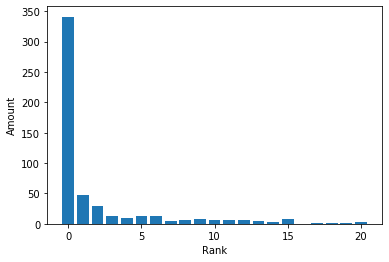

In [43]:
plt.bar(list(sorted_count.keys())[0:20], list(sorted_count.values())[0:20])
plt.xlabel('Rank')
plt.ylabel('Amount')

In [44]:
range0 = 0
range1_4 = 0
range5_9 = 0
range10_19 = 0
for i, v in list(sorted_count.items())[0:19]:
    if i == 0:
        range0 += v
    elif i>=1 and i<=4:
        range1_4 += v
    elif i>=5 and i<=9:
        range5_9 += v
    else:
        range10_19 += v
        
print(f"Top1:     {(range0 / N)*100:.2f} %")
print(f"Top2-5:   {(range1_4 / N)*100:.2f} %")
print(f"Top5-10:  {(range5_9 / N)*100:.2f} %")
print(f"Top11-20: {(range10_19 / N)*100:.2f} %")

Top1:     34.10 %
Top2-5:   9.90 %
Top5-10:  4.50 %
Top11-20: 3.90 %
